In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import copy
import numpy as np
import math
import numpy.linalg as npla
import scipy.linalg as spla
import pickle
import pandas as pd
import plotnine as gg
import warnings
warnings.filterwarnings('ignore')

In [2]:

def round_down(val, amt):
    return amt*math.floor(val/amt)

def round_up(val, amt):
    return amt*math.ceil(val/amt)

def intervals(xmin,xmax,spacing):
    return [xmin + spacing*i for i in range(int((xmax-xmin)/spacing)+1)]

def make_hist(a, bin_length):
    a_min = np.min(a)
    a_max = np.max(a)
    # round down bin length
    hist, edges = np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length))
    return hist, edges

def make_hist_from_std_dev(a,factor):
    s = np.std(a)
    bin_length = factor*s
    return make_hist(a, bin_length)

def make_hists(arrs, bin_length):
    a_min = np.min(arrs)
    a_max = np.max(arrs)
    # round down bin length
    li = [np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length)) for a in arrs]
    edges = li[0][1]
    hists = [t[0] for t in li] 
    return hists, edges

def make_hists_from_std_dev(arrs, factor):
    s = np.std(arrs[0])
    bin_length = factor*s
    return make_hists(arrs, bin_length)

def tv(a1,a2):
    return np.sum(np.abs((a1-a2).astype(float)))/(2*np.sum(a1))

#first array is ground truth
def merr(arrs, factor,verbosity=1):
    (num_arrs, sample_size, d) = arrs.shape
    tvs = np.zeros((num_arrs-1, d))
    hists_list = []
    for i in range(d):
        arr_i = arrs[:,:,i]
        hists, edges = make_hists_from_std_dev(arr_i, factor)
        printv(hists, verbosity,1)
        hists_list += [hists]
        for j in range(num_arrs-1):
            tvs[j,i] = tv(hists[0], hists[j+1])
    merrs = np.sum(tvs, axis=1)/d
    return tvs, merrs, hists
#def ma(true_samples, samples, side_length):

def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    print('SEED: %d' % seed)
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def redraw_samples(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):

def redraw_samples_for_agents(agents, num, verbosity=1):
    samples_list = []

    for agent in agents:
        samples = redraw_samples(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [3]:
num_articles = 1
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.1
T=1000

verbosity=0

In [4]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

# Experiments 1

SEED: 1
theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experiment: 

Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: Step 430
Experiment: S

Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: Step 821
Experiment: S

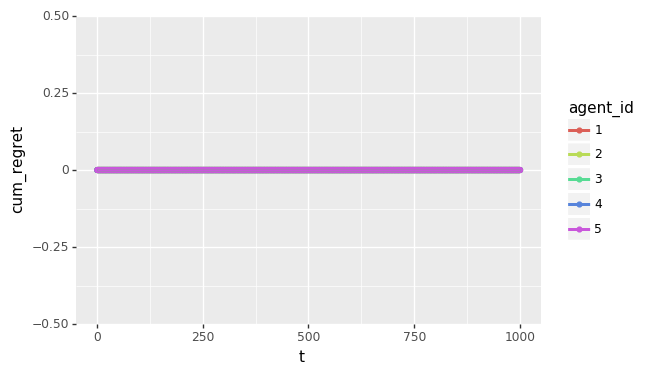

<ggplot: (8735489554057)>


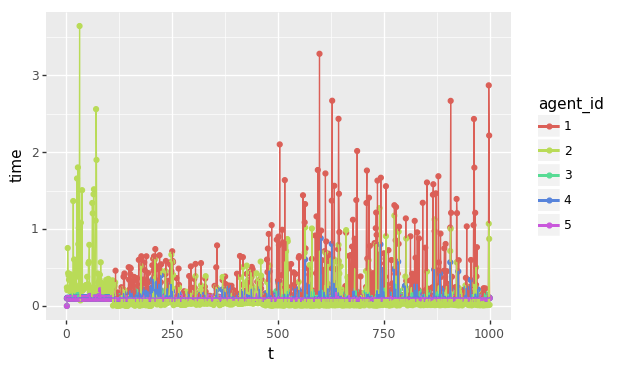

<ggplot: (8735662095149)>


([      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
  0             1        1     0.999721         0.0             0.0     1   
  1             2        2     0.999721         0.0             0.0     1   
  2             3        3     0.999721         0.0             0.0     1   
  3             4        4     0.999721         0.0             0.0     1   
  4             5        5     0.999721         0.0             0.0     1   
  5             6        1     1.645979         0.0             0.0     2   
  6             7        2     1.645979         0.0             0.0     2   
  7             8        3     1.645979         0.0             0.0     2   
  8             9        4     1.645979         0.0             0.0     2   
  9            10        5     1.645979         0.0             0.0     2   
  10           11        1     1.891335         0.0             0.0     3   
  11           12        2     1.891335         0.0             0.0     3   

In [5]:
agents = [make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
simple_compare(agents, num_articles, dim, var, T, 1, verbosity=1)

In [6]:
samples_list = []
agents[0].v=1
agents[0].time=0
agents[0].n_steps=500
for agent in agents:
    samples = redraw_samples(agent, 1000, 2)
    samples_list += [samples]
samples_list = np.asarray(samples_list)

Drawing sample 1
 Sample: array([ 1.89060736, -0.57617725, -0.57697235, -1.22066159,  0.48557952,
       -2.31013704,  1.76840489, -0.44858173,  0.35641314, -0.32523614,
        1.46680555, -1.64263754, -0.37229494, -0.50831109,  0.91998676,
       -1.10788552,  0.12079969, -0.37305896,  0.16600571,  0.36728299])
 Accept proportion: 0.864000
 Steps taken: 500
 array([ 1.89060736, -0.57617725, -0.57697235, -1.22066159,  0.48557952,
       -2.31013704,  1.76840489, -0.44858173,  0.35641314, -0.32523614,
        1.46680555, -1.64263754, -0.37229494, -0.50831109,  0.91998676,
       -1.10788552,  0.12079969, -0.37305896,  0.16600571,  0.36728299])
Drawing sample 2
 Sample: array([ 1.81316958, -0.32965996, -0.69015607, -0.90723587,  0.82702346,
       -1.86886327,  1.65898821, -0.46468913,  0.39011735, -0.39852202,
        1.52501244, -1.6578091 , -0.20875542, -0.31593673,  0.88665678,
       -0.71100441, -0.1575022 , -0.5919268 ,  0.02065634,  0.75568936])
 Accept proportion: 0.896000
 Ste

 Sample: array([ 0.99143969, -0.40992252, -0.7517808 , -0.55548876,  1.10468322,
       -2.18324604,  1.69721908, -0.3052942 ,  0.57749804, -0.43386031,
        1.43812172, -1.58769465, -0.07680394, -0.30651319,  1.00642972,
       -0.58775858, -0.31100165, -0.52995661,  0.06929246,  0.3840328 ])
 Accept proportion: 0.886000
 Steps taken: 500
 array([ 0.99143969, -0.40992252, -0.7517808 , -0.55548876,  1.10468322,
       -2.18324604,  1.69721908, -0.3052942 ,  0.57749804, -0.43386031,
        1.43812172, -1.58769465, -0.07680394, -0.30651319,  1.00642972,
       -0.58775858, -0.31100165, -0.52995661,  0.06929246,  0.3840328 ])
Drawing sample 15
 Sample: array([ 1.42103102, -0.72394833, -0.74522488, -0.66761418,  0.83924298,
       -1.83504996,  1.93468314, -0.73425303,  0.33619034, -0.07676375,
        1.66010455, -1.78927832, -0.24499084, -0.2704672 ,  1.04993931,
       -1.11720703, -0.05789568, -0.35383213, -0.13773726,  0.56032502])
 Accept proportion: 0.900000
 Steps taken: 500
 a

 Sample: array([ 1.70279328, -0.73236368, -0.77004115, -0.76947349,  0.48000657,
       -1.90111106,  2.00909731, -0.76763005,  0.11130609, -0.50727917,
        1.25945944, -1.79641955, -0.27161809, -0.4751014 ,  1.35457832,
       -1.11420568,  0.163352  , -0.11170032, -0.07016983,  0.57346479])
 Accept proportion: 0.852000
 Steps taken: 500
 array([ 1.70279328, -0.73236368, -0.77004115, -0.76947349,  0.48000657,
       -1.90111106,  2.00909731, -0.76763005,  0.11130609, -0.50727917,
        1.25945944, -1.79641955, -0.27161809, -0.4751014 ,  1.35457832,
       -1.11420568,  0.163352  , -0.11170032, -0.07016983,  0.57346479])
Drawing sample 28
 Sample: array([ 1.76512645, -0.57738702, -0.57860257, -0.5442329 ,  0.60667129,
       -2.14234536,  1.77464563, -0.48794999,  0.4710739 , -0.2773454 ,
        1.49174195, -1.85330136,  0.28967826, -0.67150136,  1.21858279,
       -0.93794769,  0.0181457 , -0.56362074, -0.04242787,  0.92926476])
 Accept proportion: 0.880000
 Steps taken: 500
 a

 Sample: array([ 1.30321616, -0.10420726, -0.60301752, -0.4714391 ,  0.73445423,
       -2.221222  ,  1.94384283, -0.58143127, -0.00233713, -0.56900835,
        1.59745561, -1.51461089, -0.24836141, -0.16802647,  0.94729587,
       -0.67309089, -0.06396881, -0.63265292,  0.3757729 ,  0.64510814])
 Accept proportion: 0.858000
 Steps taken: 500
 array([ 1.30321616, -0.10420726, -0.60301752, -0.4714391 ,  0.73445423,
       -2.221222  ,  1.94384283, -0.58143127, -0.00233713, -0.56900835,
        1.59745561, -1.51461089, -0.24836141, -0.16802647,  0.94729587,
       -0.67309089, -0.06396881, -0.63265292,  0.3757729 ,  0.64510814])
Drawing sample 41
 Sample: array([ 1.75420819, -0.35704995, -0.54714445, -1.02450575,  0.75771641,
       -2.1027027 ,  1.61226645, -0.52711042,  0.66669247, -0.38920207,
        1.48471516, -1.40219895, -0.35195121, -0.37881243,  0.91429285,
       -1.14389505, -0.18930744, -0.7025539 ,  0.10573122,  0.81440344])
 Accept proportion: 0.896000
 Steps taken: 500
 a

 Sample: array([ 1.10738615, -0.21046662, -0.61561516, -0.8749429 ,  0.97172188,
       -2.18894093,  1.65099087, -0.61564467,  0.28659148, -0.73302581,
        1.45356546, -1.92857381, -0.45653536, -0.47362211,  1.08192978,
       -0.7467688 ,  0.15912739, -0.56906557, -0.20314708,  0.7557976 ])
 Accept proportion: 0.892000
 Steps taken: 500
 array([ 1.10738615, -0.21046662, -0.61561516, -0.8749429 ,  0.97172188,
       -2.18894093,  1.65099087, -0.61564467,  0.28659148, -0.73302581,
        1.45356546, -1.92857381, -0.45653536, -0.47362211,  1.08192978,
       -0.7467688 ,  0.15912739, -0.56906557, -0.20314708,  0.7557976 ])
Drawing sample 54
 Sample: array([ 1.5316551 , -0.56329915, -0.60240331, -0.82611873,  0.99146123,
       -2.22812189,  1.98978214, -0.21545454,  0.26985118, -0.49529107,
        1.50690649, -1.79743172, -0.25135054, -0.57246202,  0.96866611,
       -0.88866984,  0.06050716, -0.89828618,  0.32492434,  0.47983577])
 Accept proportion: 0.844000
 Steps taken: 500
 a

 Sample: array([ 1.73923325, -0.37509341, -0.50444207, -0.81640249,  0.6916975 ,
       -1.76860321,  1.82350253, -0.61896456,  0.14946339, -0.40581822,
        1.90980413, -1.424075  , -0.00952156, -0.44538169,  0.98207851,
       -0.68098291, -0.20991439, -0.49907378,  0.14861925,  0.46599086])
 Accept proportion: 0.880000
 Steps taken: 500
 array([ 1.73923325, -0.37509341, -0.50444207, -0.81640249,  0.6916975 ,
       -1.76860321,  1.82350253, -0.61896456,  0.14946339, -0.40581822,
        1.90980413, -1.424075  , -0.00952156, -0.44538169,  0.98207851,
       -0.68098291, -0.20991439, -0.49907378,  0.14861925,  0.46599086])
Drawing sample 67
 Sample: array([ 1.45740315, -0.33250255, -0.61558544, -0.83907911,  0.92931848,
       -2.26165165,  1.90935217, -0.56034681,  0.33855569, -0.67646823,
        1.53189918, -1.82232461,  0.05865621, -0.66068774,  0.97100643,
       -0.94467456,  0.24796114, -0.55273214,  0.19952572,  0.60654437])
 Accept proportion: 0.886000
 Steps taken: 500
 a

 Sample: array([ 1.31420507, -0.23281939, -0.43184494, -0.56873772,  0.82420145,
       -2.33047314,  1.75468439, -0.22273437,  0.21041192, -0.12007582,
        1.37762288, -1.87876122, -0.25403673, -0.23704073,  1.15901122,
       -0.55693615,  0.24996789, -0.70281709, -0.20746397,  0.44029326])
 Accept proportion: 0.886000
 Steps taken: 500
 array([ 1.31420507, -0.23281939, -0.43184494, -0.56873772,  0.82420145,
       -2.33047314,  1.75468439, -0.22273437,  0.21041192, -0.12007582,
        1.37762288, -1.87876122, -0.25403673, -0.23704073,  1.15901122,
       -0.55693615,  0.24996789, -0.70281709, -0.20746397,  0.44029326])
Drawing sample 80
 Sample: array([ 1.59123925, -0.82551241, -0.67032416, -0.87643236,  1.17313153,
       -2.10231967,  1.89836747, -0.23145707,  0.30535871, -0.4606562 ,
        1.2850096 , -1.96308043, -0.10108594, -0.3297888 ,  1.00165209,
       -0.69041054,  0.13608427, -0.85794489,  0.24018611,  0.94859835])
 Accept proportion: 0.866000
 Steps taken: 500
 a

 Sample: array([ 1.46604792, -0.36569094, -1.04724042, -0.93241605,  0.78913226,
       -1.8778418 ,  1.68920628, -0.5931678 ,  0.14997929, -0.41460583,
        1.43343339, -1.86010941,  0.03890416, -0.84817739,  0.94497044,
       -0.27569398, -0.0754498 , -0.3911691 , -0.00738877,  0.70131437])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.46604792, -0.36569094, -1.04724042, -0.93241605,  0.78913226,
       -1.8778418 ,  1.68920628, -0.5931678 ,  0.14997929, -0.41460583,
        1.43343339, -1.86010941,  0.03890416, -0.84817739,  0.94497044,
       -0.27569398, -0.0754498 , -0.3911691 , -0.00738877,  0.70131437])
Drawing sample 93
 Sample: array([ 1.83389191, -0.36421929, -0.55352699, -0.59499815,  0.55652705,
       -1.86916393,  1.59518705, -0.72909442,  0.54076491, -0.372079  ,
        1.87661189, -1.74898348, -0.26004426, -0.34750989,  0.66891325,
       -0.73134762,  0.09317015, -0.24637075,  0.11077377,  0.64457083])
 Accept proportion: 0.854000
 Steps taken: 500
 a

 Sample: array([ 1.43098884, -0.24240693, -0.5487695 , -0.49991895,  0.45461004,
       -1.84300248,  1.55852085, -0.4475593 ,  0.31481637, -0.50189476,
        1.67303867, -1.6449541 , -0.22719242, -0.26309679,  0.79115779,
       -0.86329644, -0.32582503, -0.32630021,  0.10399403,  0.51681391])
 Accept proportion: 0.890000
 Steps taken: 500
 array([ 1.43098884, -0.24240693, -0.5487695 , -0.49991895,  0.45461004,
       -1.84300248,  1.55852085, -0.4475593 ,  0.31481637, -0.50189476,
        1.67303867, -1.6449541 , -0.22719242, -0.26309679,  0.79115779,
       -0.86329644, -0.32582503, -0.32630021,  0.10399403,  0.51681391])
Drawing sample 106
 Sample: array([ 1.50480982, -0.70324424, -0.59226671, -0.96592362,  1.12321854,
       -1.66797293,  1.53060723, -0.23776331,  0.01732448, -0.36572318,
        1.26844077, -1.61186949, -0.32504646, -0.22529963,  1.10573054,
       -1.13616092,  0.13125775, -0.39617406, -0.04926731,  0.72803028])
 Accept proportion: 0.886000
 Steps taken: 500
 

 Sample: array([ 1.86893321, -0.42112248, -0.24940282, -0.73463958,  0.79771777,
       -2.27129315,  1.65458002, -0.03152699,  0.32591322, -0.23747649,
        1.72908608, -1.61563067, -0.25558097, -0.29784811,  0.8451076 ,
       -0.95843631,  0.15136246, -0.75779282,  0.06727566,  0.69383525])
 Accept proportion: 0.852000
 Steps taken: 500
 array([ 1.86893321, -0.42112248, -0.24940282, -0.73463958,  0.79771777,
       -2.27129315,  1.65458002, -0.03152699,  0.32591322, -0.23747649,
        1.72908608, -1.61563067, -0.25558097, -0.29784811,  0.8451076 ,
       -0.95843631,  0.15136246, -0.75779282,  0.06727566,  0.69383525])
Drawing sample 119
 Sample: array([ 1.29818427, -0.42251282, -0.47638761, -0.70462544,  0.69341684,
       -2.1925858 ,  1.61396087, -0.36944789,  0.09171669, -0.22706308,
        1.37797933, -1.73446774, -0.09080271, -0.30026992,  0.95687513,
       -0.9534809 ,  0.00397878, -0.71941099, -0.0090616 ,  0.8776096 ])
 Accept proportion: 0.870000
 Steps taken: 500
 

 Sample: array([ 1.12380188, -0.10953659, -0.72347752, -1.12346059,  0.97612267,
       -2.04776357,  1.85781985, -0.53750427,  0.05285895, -0.34198594,
        1.74078498, -1.66222993, -0.04970846, -0.46800661,  1.04389164,
       -0.69152085, -0.16010639, -0.32415071,  0.09021844,  1.19724823])
 Accept proportion: 0.880000
 Steps taken: 500
 array([ 1.12380188, -0.10953659, -0.72347752, -1.12346059,  0.97612267,
       -2.04776357,  1.85781985, -0.53750427,  0.05285895, -0.34198594,
        1.74078498, -1.66222993, -0.04970846, -0.46800661,  1.04389164,
       -0.69152085, -0.16010639, -0.32415071,  0.09021844,  1.19724823])
Drawing sample 132
 Sample: array([ 1.3132987 , -0.36748067, -0.6379724 , -0.50351529,  0.44019624,
       -2.2350818 ,  1.44369884, -0.43154308,  0.16177483, -0.73731238,
        1.41055018, -1.49800399, -0.05640505, -0.23683298,  0.77321916,
       -0.71383656, -0.25810528, -0.40742892,  0.00238643,  0.55709811])
 Accept proportion: 0.884000
 Steps taken: 500
 

 Sample: array([ 1.47977876, -0.70647186, -0.67652657, -0.6152815 ,  0.57405379,
       -2.21457779,  2.22423442, -0.43691243,  0.21681273, -0.05934175,
        1.62216201, -1.5059518 ,  0.24996775, -0.39890923,  1.15820057,
       -0.93046393, -0.23254342, -0.49319787, -0.0515504 ,  0.73170145])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.47977876, -0.70647186, -0.67652657, -0.6152815 ,  0.57405379,
       -2.21457779,  2.22423442, -0.43691243,  0.21681273, -0.05934175,
        1.62216201, -1.5059518 ,  0.24996775, -0.39890923,  1.15820057,
       -0.93046393, -0.23254342, -0.49319787, -0.0515504 ,  0.73170145])
Drawing sample 145
 Sample: array([ 1.41079419, -0.22679353, -0.51917674, -0.49682518,  0.83501944,
       -1.88885076,  1.70843108, -0.55422754,  0.54463985, -0.21621702,
        1.85278667, -1.63163598, -0.10902086, -0.45728958,  0.92940567,
       -0.47163121,  0.09266447, -0.24729356,  0.07478456,  0.38269242])
 Accept proportion: 0.896000
 Steps taken: 500
 

 Sample: array([ 1.39505476, -0.32053143, -0.54617051, -0.71802256,  1.07319886,
       -2.02742908,  1.71405352, -0.53815811,  0.28646209, -0.64512061,
        1.81449655, -1.78016164, -0.44364854, -0.68641142,  0.84136636,
       -0.8266174 ,  0.23683929, -0.51642788, -0.33726836,  0.7620239 ])
 Accept proportion: 0.870000
 Steps taken: 500
 array([ 1.39505476, -0.32053143, -0.54617051, -0.71802256,  1.07319886,
       -2.02742908,  1.71405352, -0.53815811,  0.28646209, -0.64512061,
        1.81449655, -1.78016164, -0.44364854, -0.68641142,  0.84136636,
       -0.8266174 ,  0.23683929, -0.51642788, -0.33726836,  0.7620239 ])
Drawing sample 158
 Sample: array([ 1.56119294, -0.46178083, -0.48532926, -0.63823572,  0.93429289,
       -2.01819991,  1.46269487, -0.3889836 , -0.2162998 , -0.16870205,
        1.59356757, -1.55255842, -0.52379612, -0.37754182,  0.97923448,
       -0.68636911, -0.04564726, -0.59344425, -0.10339276,  0.78716336])
 Accept proportion: 0.872000
 Steps taken: 500
 

 Sample: array([ 1.4169122 , -0.60283176, -0.73711949, -0.55825087,  0.44982863,
       -2.15420947,  1.57509439, -0.52784879,  0.17504165, -0.50421696,
        1.44443507, -1.53907521, -0.19179035, -0.36188047,  0.59897758,
       -1.16529954,  0.02045299, -0.26471919, -0.05075964,  0.87128667])
 Accept proportion: 0.892000
 Steps taken: 500
 array([ 1.4169122 , -0.60283176, -0.73711949, -0.55825087,  0.44982863,
       -2.15420947,  1.57509439, -0.52784879,  0.17504165, -0.50421696,
        1.44443507, -1.53907521, -0.19179035, -0.36188047,  0.59897758,
       -1.16529954,  0.02045299, -0.26471919, -0.05075964,  0.87128667])
Drawing sample 171
 Sample: array([ 1.54829058, -0.66721923, -0.64361957, -0.71238467,  0.78813134,
       -2.12860589,  1.73707618, -0.70383943,  0.01622438, -0.50934136,
        1.53281196, -1.37710439, -0.37595254, -0.53788017,  1.18136434,
       -0.87877939, -0.10517894, -0.70852602,  0.30224468,  0.71494106])
 Accept proportion: 0.882000
 Steps taken: 500
 

 Sample: array([ 1.41016662, -0.36319968, -0.54589917, -0.902736  ,  0.65597046,
       -1.53765923,  1.63919907, -0.78714158,  0.12165997, -0.64312899,
        1.5390751 , -1.51105832, -0.47842776, -0.15728342,  1.22330948,
       -0.77907369, -0.04997728, -0.55897542,  0.32620708,  0.86705967])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.41016662, -0.36319968, -0.54589917, -0.902736  ,  0.65597046,
       -1.53765923,  1.63919907, -0.78714158,  0.12165997, -0.64312899,
        1.5390751 , -1.51105832, -0.47842776, -0.15728342,  1.22330948,
       -0.77907369, -0.04997728, -0.55897542,  0.32620708,  0.86705967])
Drawing sample 184
 Sample: array([ 1.73798928, -0.57304884, -0.43298721, -0.44263281,  0.49346573,
       -2.04819193,  1.60384855, -0.46003588,  0.27664014, -0.20605751,
        1.51163389, -1.50819349, -0.40198807, -0.417798  ,  0.73519057,
       -0.78455998, -0.06676806, -0.39199712, -0.09727436,  0.88333322])
 Accept proportion: 0.862000
 Steps taken: 500
 

 Sample: array([ 1.74241939, -0.47377043, -0.71627246, -0.82094495,  0.72875545,
       -2.28996871,  1.86234966, -0.43963178,  0.00452355, -0.27357573,
        1.45416188, -1.99038162, -0.18846624, -0.4261221 ,  1.04011575,
       -0.91896764, -0.20292996, -0.70141724,  0.14365097,  0.55666887])
 Accept proportion: 0.860000
 Steps taken: 500
 array([ 1.74241939, -0.47377043, -0.71627246, -0.82094495,  0.72875545,
       -2.28996871,  1.86234966, -0.43963178,  0.00452355, -0.27357573,
        1.45416188, -1.99038162, -0.18846624, -0.4261221 ,  1.04011575,
       -0.91896764, -0.20292996, -0.70141724,  0.14365097,  0.55666887])
Drawing sample 197
 Sample: array([ 1.55341092, -0.35288041, -0.75138149, -0.97778447,  0.82056406,
       -2.15090714,  1.95287268, -0.81732048,  0.42193335,  0.1336241 ,
        1.48899811, -2.02846558, -0.39739637, -0.18825428,  1.1276808 ,
       -0.46030874, -0.10916516, -0.52106743, -0.01281836,  0.69667881])
 Accept proportion: 0.880000
 Steps taken: 500
 

 Sample: array([ 1.51341406, -0.31946641, -0.75477637, -0.68533537,  1.11495513,
       -2.11230905,  1.76155792, -0.49023147,  0.10282056, -0.20173463,
        1.37836598, -1.68911194, -0.44563148,  0.03832785,  1.23007088,
       -0.65090151, -0.02379473, -0.60226376,  0.10676421,  0.5932772 ])
 Accept proportion: 0.866000
 Steps taken: 500
 array([ 1.51341406, -0.31946641, -0.75477637, -0.68533537,  1.11495513,
       -2.11230905,  1.76155792, -0.49023147,  0.10282056, -0.20173463,
        1.37836598, -1.68911194, -0.44563148,  0.03832785,  1.23007088,
       -0.65090151, -0.02379473, -0.60226376,  0.10676421,  0.5932772 ])
Drawing sample 210
 Sample: array([ 1.36332924, -0.35838746, -0.90216844, -0.59210711,  0.39071756,
       -2.47277505,  1.9910024 , -0.29693323,  0.51249095, -0.44600727,
        1.16853805, -1.84097131, -0.15750405, -0.75602717,  0.98782932,
       -0.76258756, -0.33159628, -0.39230183,  0.02930966,  0.6499137 ])
 Accept proportion: 0.876000
 Steps taken: 500
 

 Sample: array([ 1.74245282, -0.23984193, -0.80026736, -0.87424041,  0.40722234,
       -2.08435158,  1.58622342, -0.30494934,  0.19801917, -0.6384541 ,
        1.82172413, -1.47309609, -0.09212748, -0.08311633,  1.02910163,
       -0.51922028, -0.21039806, -0.35217168,  0.16620792,  0.8271876 ])
 Accept proportion: 0.868000
 Steps taken: 500
 array([ 1.74245282, -0.23984193, -0.80026736, -0.87424041,  0.40722234,
       -2.08435158,  1.58622342, -0.30494934,  0.19801917, -0.6384541 ,
        1.82172413, -1.47309609, -0.09212748, -0.08311633,  1.02910163,
       -0.51922028, -0.21039806, -0.35217168,  0.16620792,  0.8271876 ])
Drawing sample 223
 Sample: array([ 1.41304274, -0.38902021, -0.68434207, -0.87929229,  0.42798886,
       -2.20788351,  1.66406554, -0.39053768,  0.34307712,  0.0560236 ,
        1.21045912, -1.64017097,  0.06036438, -0.31224115,  0.70155508,
       -0.43215679,  0.06269963, -0.87783222, -0.11331439,  0.56845157])
 Accept proportion: 0.886000
 Steps taken: 500
 

 Sample: array([ 1.67363064, -0.67509173, -0.58007562, -0.88404551,  0.57898241,
       -2.29912567,  1.69939567, -0.60873746,  0.1772952 , -0.5330376 ,
        1.70455906, -1.78596624, -0.35149995, -0.34489128,  0.96948243,
       -0.93072115,  0.0204395 , -1.0150995 ,  0.21571886,  0.7371764 ])
 Accept proportion: 0.856000
 Steps taken: 500
 array([ 1.67363064, -0.67509173, -0.58007562, -0.88404551,  0.57898241,
       -2.29912567,  1.69939567, -0.60873746,  0.1772952 , -0.5330376 ,
        1.70455906, -1.78596624, -0.35149995, -0.34489128,  0.96948243,
       -0.93072115,  0.0204395 , -1.0150995 ,  0.21571886,  0.7371764 ])
Drawing sample 236
 Sample: array([ 1.50842556, -0.13115617, -0.87239852, -0.81257432,  0.86004062,
       -2.27202642,  1.42273918, -0.53295508,  0.28521136, -0.47322708,
        1.40901817, -1.59496045, -0.09102188, -0.10715205,  0.96626375,
       -0.59473574,  0.02931708, -0.78283812, -0.2694134 ,  0.52129826])
 Accept proportion: 0.874000
 Steps taken: 500
 

 Sample: array([ 1.33577421, -0.30324372, -0.45963852, -0.49925233,  0.5491831 ,
       -1.6841774 ,  1.35806219, -0.48002338,  0.57555933, -0.64508429,
        1.64060718, -1.7230335 , -0.33982513, -0.45579053,  0.87928512,
       -0.99713603, -0.15426141, -0.36838321,  0.27894795,  0.92505556])
 Accept proportion: 0.880000
 Steps taken: 500
 array([ 1.33577421, -0.30324372, -0.45963852, -0.49925233,  0.5491831 ,
       -1.6841774 ,  1.35806219, -0.48002338,  0.57555933, -0.64508429,
        1.64060718, -1.7230335 , -0.33982513, -0.45579053,  0.87928512,
       -0.99713603, -0.15426141, -0.36838321,  0.27894795,  0.92505556])
Drawing sample 249
 Sample: array([ 1.52745203, -0.33786525, -0.9479458 , -0.56323502,  0.67438823,
       -1.81512522,  1.90719   , -0.77863948,  0.3136049 , -0.4131509 ,
        1.47573797, -1.48411459,  0.03802434, -0.38348811,  1.04480213,
       -0.58979049, -0.34705411, -0.62357439,  0.02873013,  0.45113032])
 Accept proportion: 0.888000
 Steps taken: 500
 

 Sample: array([ 1.44023769, -0.27231749, -0.54492378, -1.00316655,  1.06388244,
       -1.70310659,  1.46227743, -0.51212594,  0.33320831, -0.7131665 ,
        1.22618943, -1.49327129, -0.10377211, -0.35759904,  0.72767692,
       -0.49004462,  0.26376441, -0.31857511,  0.12423376,  0.77315987])
 Accept proportion: 0.872000
 Steps taken: 500
 array([ 1.44023769, -0.27231749, -0.54492378, -1.00316655,  1.06388244,
       -1.70310659,  1.46227743, -0.51212594,  0.33320831, -0.7131665 ,
        1.22618943, -1.49327129, -0.10377211, -0.35759904,  0.72767692,
       -0.49004462,  0.26376441, -0.31857511,  0.12423376,  0.77315987])
Drawing sample 262
 Sample: array([ 1.61387856, -0.56088059, -0.36202593, -0.60689371,  0.32663186,
       -2.19943707,  1.5974047 , -0.27861571,  0.30617262, -0.6045037 ,
        1.72699677, -1.78946096,  0.02556568, -0.52376251,  0.96242383,
       -0.85028594,  0.26254467, -0.55431648, -0.15835542,  0.8058372 ])
 Accept proportion: 0.886000
 Steps taken: 500
 

 Sample: array([ 1.39492198, -0.41868471, -0.45042961, -0.73220602,  0.63557324,
       -1.98582915,  1.78763186, -0.39082419,  0.26165408, -0.35796256,
        1.52735324, -1.39785733,  0.32000861, -0.30834403,  1.03053908,
       -1.15434211, -0.17980981, -0.77835913, -0.04195967,  0.56503025])
 Accept proportion: 0.876000
 Steps taken: 500
 array([ 1.39492198, -0.41868471, -0.45042961, -0.73220602,  0.63557324,
       -1.98582915,  1.78763186, -0.39082419,  0.26165408, -0.35796256,
        1.52735324, -1.39785733,  0.32000861, -0.30834403,  1.03053908,
       -1.15434211, -0.17980981, -0.77835913, -0.04195967,  0.56503025])
Drawing sample 275
 Sample: array([ 1.29438939,  0.09576704, -0.34795449, -0.73891556,  0.84196287,
       -1.83703435,  1.63687218, -0.4881019 ,  0.41172429, -0.39155082,
        1.28698799, -1.76679723, -0.06210493, -0.42642271,  1.11640687,
       -0.64222143,  0.27424678, -0.34895701,  0.2649835 ,  0.79048652])
 Accept proportion: 0.900000
 Steps taken: 500
 

 Sample: array([ 1.49620593, -0.49204511, -0.5816605 , -0.49390664,  0.99278495,
       -1.99742383,  1.68815266, -0.47402199,  0.42955375, -0.77341369,
        1.63069437, -1.68821734, -0.34399513, -0.33285233,  1.02634779,
       -0.89858151, -0.26738367, -0.69880041, -0.00623821,  0.85598348])
 Accept proportion: 0.872000
 Steps taken: 500
 array([ 1.49620593, -0.49204511, -0.5816605 , -0.49390664,  0.99278495,
       -1.99742383,  1.68815266, -0.47402199,  0.42955375, -0.77341369,
        1.63069437, -1.68821734, -0.34399513, -0.33285233,  1.02634779,
       -0.89858151, -0.26738367, -0.69880041, -0.00623821,  0.85598348])
Drawing sample 288
 Sample: array([ 1.66910711, -0.41271321, -0.44722015, -1.0301278 ,  1.05635208,
       -2.22138702,  1.76267637, -0.62073413,  0.33615604, -0.37159299,
        1.59858939, -1.52554593, -0.51907709, -0.70115473,  1.09564834,
       -0.35796633,  0.04532233, -0.33523998, -0.0817242 ,  0.72882544])
 Accept proportion: 0.906000
 Steps taken: 500
 

 Sample: array([ 1.57690319, -0.31664452, -0.69003292, -0.54884271,  0.52806152,
       -1.97909168,  1.58975353, -0.32616464,  0.34552198, -0.44533949,
        1.44907438, -1.70567677,  0.01665265, -0.27826407,  0.81367685,
       -1.14737495, -0.12371687, -0.45180875,  0.15485735,  0.63143667])
 Accept proportion: 0.870000
 Steps taken: 500
 array([ 1.57690319, -0.31664452, -0.69003292, -0.54884271,  0.52806152,
       -1.97909168,  1.58975353, -0.32616464,  0.34552198, -0.44533949,
        1.44907438, -1.70567677,  0.01665265, -0.27826407,  0.81367685,
       -1.14737495, -0.12371687, -0.45180875,  0.15485735,  0.63143667])
Drawing sample 301
 Sample: array([ 1.73950533, -0.50469589, -0.73678032, -0.73452941,  1.11855971,
       -2.46263523,  1.88847475, -0.51010822,  0.42262896, -0.03570489,
        1.32376258, -1.44143689, -0.28973011, -0.2809254 ,  0.88330944,
       -0.82688631, -0.12558709, -0.44480172, -0.01367402,  0.95080522])
 Accept proportion: 0.856000
 Steps taken: 500
 

 Sample: array([ 1.52404589, -0.35451673, -0.66636211, -0.92550922,  0.88127468,
       -1.7560121 ,  1.83698637, -0.5332725 ,  0.50698843, -0.6697615 ,
        1.44081309, -1.7416208 , -0.31622301, -0.44179301,  0.8762975 ,
       -1.15386695,  0.07544882, -0.64896293, -0.12926543,  0.73819416])
 Accept proportion: 0.866000
 Steps taken: 500
 array([ 1.52404589, -0.35451673, -0.66636211, -0.92550922,  0.88127468,
       -1.7560121 ,  1.83698637, -0.5332725 ,  0.50698843, -0.6697615 ,
        1.44081309, -1.7416208 , -0.31622301, -0.44179301,  0.8762975 ,
       -1.15386695,  0.07544882, -0.64896293, -0.12926543,  0.73819416])
Drawing sample 314
 Sample: array([ 1.56285531, -0.0955698 , -0.41823997, -0.32053354,  0.80083408,
       -2.09350373,  1.51914398, -0.13569424,  0.12427683, -0.42902593,
        1.39897773, -1.72809835, -0.14483332, -0.3268031 ,  0.78275095,
       -0.76641948,  0.16141366, -0.59196073, -0.10322971,  0.37196377])
 Accept proportion: 0.894000
 Steps taken: 500
 

 Sample: array([ 1.43871988, -0.54648923, -0.58087248, -0.57727781,  0.64648084,
       -2.08046022,  2.05295421, -0.49939275,  0.14490319, -0.01387879,
        1.50740792, -1.96518861, -0.00248935, -0.38965274,  1.0263788 ,
       -1.10448577, -0.16342321, -0.85139285,  0.12628911,  0.67764518])
 Accept proportion: 0.884000
 Steps taken: 500
 array([ 1.43871988, -0.54648923, -0.58087248, -0.57727781,  0.64648084,
       -2.08046022,  2.05295421, -0.49939275,  0.14490319, -0.01387879,
        1.50740792, -1.96518861, -0.00248935, -0.38965274,  1.0263788 ,
       -1.10448577, -0.16342321, -0.85139285,  0.12628911,  0.67764518])
Drawing sample 327
 Sample: array([ 1.40302826, -0.52894233, -0.64437702, -0.73703695,  0.75903019,
       -2.05820297,  1.90323545, -0.17403239,  0.19946102, -0.27227856,
        1.39670113, -1.77991381, -0.36393789, -0.22893295,  0.84391979,
       -0.81435133, -0.17337562, -0.63433453,  0.3292588 ,  0.51872099])
 Accept proportion: 0.874000
 Steps taken: 500
 

 Sample: array([ 1.52051966, -0.48870152, -0.26906208, -1.00860872,  1.04130588,
       -1.71909275,  1.65818607, -0.51483911,  0.40191207, -0.30313631,
        1.4297392 , -1.7965737 , -0.16250206, -0.3907938 ,  1.03235499,
       -0.68751363, -0.05763152, -0.58702695, -0.05885795,  0.44160452])
 Accept proportion: 0.880000
 Steps taken: 500
 array([ 1.52051966, -0.48870152, -0.26906208, -1.00860872,  1.04130588,
       -1.71909275,  1.65818607, -0.51483911,  0.40191207, -0.30313631,
        1.4297392 , -1.7965737 , -0.16250206, -0.3907938 ,  1.03235499,
       -0.68751363, -0.05763152, -0.58702695, -0.05885795,  0.44160452])
Drawing sample 340
 Sample: array([ 1.7381316 , -0.19603535, -0.67414179, -0.61917185,  0.67114864,
       -1.94877056,  1.12891943, -0.60712436,  0.13621799, -0.4773137 ,
        1.51658818, -1.35809128, -0.54952532, -0.41692109,  0.99117075,
       -0.68222733,  0.06131807, -0.57624183,  0.16698313,  0.59735594])
 Accept proportion: 0.862000
 Steps taken: 500
 

 Sample: array([ 1.43003189, -0.30011628, -0.71596222, -0.6909293 ,  0.68428071,
       -2.26423144,  1.95432644, -0.22605318,  0.37095569, -0.41694779,
        1.45426478, -1.39790448, -0.1673496 , -0.25067573,  0.83796888,
       -0.71042726, -0.02754971, -0.9846465 ,  0.23017773,  0.42722992])
 Accept proportion: 0.878000
 Steps taken: 500
 array([ 1.43003189, -0.30011628, -0.71596222, -0.6909293 ,  0.68428071,
       -2.26423144,  1.95432644, -0.22605318,  0.37095569, -0.41694779,
        1.45426478, -1.39790448, -0.1673496 , -0.25067573,  0.83796888,
       -0.71042726, -0.02754971, -0.9846465 ,  0.23017773,  0.42722992])
Drawing sample 353
 Sample: array([ 1.64629074, -0.32428262, -0.68526556, -0.90969234,  0.8505354 ,
       -2.38206555,  1.7278488 , -0.94622313,  0.01403318, -0.65429801,
        1.42251167, -2.10905026, -0.25253445, -0.63392068,  1.30234874,
       -0.55603462, -0.24963792, -0.28992272, -0.21953306,  0.66010289])
 Accept proportion: 0.908000
 Steps taken: 500
 

 Sample: array([ 1.41207063, -0.51896663, -0.66300605, -0.79642029,  0.53575856,
       -1.91396368,  1.27761978, -0.44818639,  0.28416125, -0.21253816,
        1.33615938, -1.75793553, -0.06576825, -0.28324508,  1.14708839,
       -0.55371271,  0.47042214, -0.52257089, -0.07055408,  0.23516149])
 Accept proportion: 0.888000
 Steps taken: 500
 array([ 1.41207063, -0.51896663, -0.66300605, -0.79642029,  0.53575856,
       -1.91396368,  1.27761978, -0.44818639,  0.28416125, -0.21253816,
        1.33615938, -1.75793553, -0.06576825, -0.28324508,  1.14708839,
       -0.55371271,  0.47042214, -0.52257089, -0.07055408,  0.23516149])
Drawing sample 366
 Sample: array([ 1.76054495e+00, -1.43223819e-01, -4.15062457e-01, -5.54392289e-01,
        9.13752979e-01, -2.31810394e+00,  1.81865178e+00, -4.74326195e-01,
        8.68350454e-01, -3.86772349e-01,  1.81430773e+00, -1.88304572e+00,
       -3.67548945e-01, -2.46597938e-01,  1.07774154e+00, -8.19204119e-01,
        1.11400438e-01, -9.22649958e-

 Sample: array([ 1.44423887, -0.26675772, -0.73665175, -0.89981396,  0.70785851,
       -2.28551977,  1.46110781, -0.57757892,  0.77964974, -0.59030179,
        1.50514388, -1.91120425, -0.32072083, -0.59859698,  1.08735173,
       -0.66194009, -0.01174799, -0.62682902, -0.2803395 ,  0.59025067])
 Accept proportion: 0.862000
 Steps taken: 500
 array([ 1.44423887, -0.26675772, -0.73665175, -0.89981396,  0.70785851,
       -2.28551977,  1.46110781, -0.57757892,  0.77964974, -0.59030179,
        1.50514388, -1.91120425, -0.32072083, -0.59859698,  1.08735173,
       -0.66194009, -0.01174799, -0.62682902, -0.2803395 ,  0.59025067])
Drawing sample 379
 Sample: array([ 1.36432573, -0.66086301, -0.65210453, -1.00750126,  0.59385885,
       -2.09328833,  1.61488347, -0.33042019,  0.08863556, -0.23468313,
        1.44905806, -1.40866373, -0.03472047, -0.45861163,  0.90654218,
       -0.39518664,  0.13833079, -0.26685048, -0.03286075,  0.54090529])
 Accept proportion: 0.888000
 Steps taken: 500
 

 Sample: array([ 1.48604668, -0.47974408, -0.62714953, -1.05812252,  0.90334182,
       -2.21781736,  1.89293899, -0.41560529,  0.26037075, -0.09925529,
        1.32651695, -1.76049017, -0.29930314, -0.52741712,  0.99839434,
       -1.11316736, -0.25835986, -0.96583588,  0.06400195,  0.83632279])
 Accept proportion: 0.870000
 Steps taken: 500
 array([ 1.48604668, -0.47974408, -0.62714953, -1.05812252,  0.90334182,
       -2.21781736,  1.89293899, -0.41560529,  0.26037075, -0.09925529,
        1.32651695, -1.76049017, -0.29930314, -0.52741712,  0.99839434,
       -1.11316736, -0.25835986, -0.96583588,  0.06400195,  0.83632279])
Drawing sample 392
 Sample: array([ 1.68999428, -0.66981244, -0.69648564, -0.89566169,  0.72091333,
       -2.53142225,  1.7930682 , -0.28931005,  0.07881743, -0.47541105,
        2.18383849, -1.6300139 , -0.17909723, -0.5098187 ,  1.04337504,
       -0.72936156,  0.00541422, -0.71045214, -0.13973392,  0.50284378])
 Accept proportion: 0.882000
 Steps taken: 500
 

 Sample: array([ 1.70445966, -0.42189952, -0.77945276, -0.68646592,  0.73544809,
       -2.15785672,  1.44840029, -0.38057471,  0.21165289, -0.51062843,
        1.48089008, -1.625832  , -0.03720562, -0.38082122,  0.73970658,
       -1.04709085,  0.12812828, -0.55767121,  0.18902595,  0.56083074])
 Accept proportion: 0.876000
 Steps taken: 500
 array([ 1.70445966, -0.42189952, -0.77945276, -0.68646592,  0.73544809,
       -2.15785672,  1.44840029, -0.38057471,  0.21165289, -0.51062843,
        1.48089008, -1.625832  , -0.03720562, -0.38082122,  0.73970658,
       -1.04709085,  0.12812828, -0.55767121,  0.18902595,  0.56083074])
Drawing sample 405
 Sample: array([ 1.5966378 , -0.03023929, -0.30881321, -0.97357827,  0.7014068 ,
       -1.75065007,  1.74299272, -0.28354822,  0.28125682, -0.34450798,
        1.64026184, -1.60850192, -0.31729702, -0.34611486,  0.82722396,
       -0.65750453, -0.01309415, -0.48181138, -0.29962412,  0.58304858])
 Accept proportion: 0.864000
 Steps taken: 500
 

 Sample: array([ 1.29564294, -0.4613797 , -0.54026444, -0.75900913,  0.80963347,
       -1.60948105,  1.92951777, -0.22576062,  0.51259795, -0.47770338,
        1.30225884, -1.54965498, -0.1675666 , -0.31734642,  1.09064217,
       -0.68522289, -0.21999242, -0.52504242, -0.09562272,  0.64359981])
 Accept proportion: 0.876000
 Steps taken: 500
 array([ 1.29564294, -0.4613797 , -0.54026444, -0.75900913,  0.80963347,
       -1.60948105,  1.92951777, -0.22576062,  0.51259795, -0.47770338,
        1.30225884, -1.54965498, -0.1675666 , -0.31734642,  1.09064217,
       -0.68522289, -0.21999242, -0.52504242, -0.09562272,  0.64359981])
Drawing sample 418
 Sample: array([ 1.55723161, -0.21058855, -0.69591746, -1.02477275,  0.88536881,
       -2.05209242,  1.91703298, -0.28130673,  0.6126398 , -0.13838045,
        1.61908057, -1.9414835 , -0.09843119, -0.61624061,  1.11010971,
       -0.90877657,  0.09007668, -0.52667256,  0.01077969,  0.52975177])
 Accept proportion: 0.884000
 Steps taken: 500
 

 Sample: array([ 1.76697273, -0.52507569, -0.67301299, -0.62220966,  0.63244963,
       -2.18913308,  1.74886585, -0.36951537,  0.55963925, -0.67405719,
        1.48134204, -1.68604872, -0.13974426, -0.44470313,  0.85456513,
       -0.93393495,  0.11709069, -0.32477475,  0.26889258,  0.44274507])
 Accept proportion: 0.866000
 Steps taken: 500
 array([ 1.76697273, -0.52507569, -0.67301299, -0.62220966,  0.63244963,
       -2.18913308,  1.74886585, -0.36951537,  0.55963925, -0.67405719,
        1.48134204, -1.68604872, -0.13974426, -0.44470313,  0.85456513,
       -0.93393495,  0.11709069, -0.32477475,  0.26889258,  0.44274507])
Drawing sample 431
 Sample: array([ 1.13657303, -0.31548334, -0.11632317, -0.86257438,  0.76036434,
       -1.9381662 ,  1.46168466, -0.38934352,  0.28718783, -0.44038858,
        1.56512648, -1.83737666, -0.2946365 , -0.47130203,  1.06546161,
       -0.5864894 ,  0.11671761, -0.33880382, -0.03424581,  0.68145155])
 Accept proportion: 0.896000
 Steps taken: 500
 

 Sample: array([ 1.64725116, -0.4936325 , -0.67562702, -0.8041222 ,  1.14847434,
       -2.5470357 ,  1.77035428, -0.58239156,  0.32627786, -0.11770977,
        1.51342332, -1.72657707, -0.30698906, -0.34574764,  0.42836432,
       -0.89823359, -0.46655191, -0.58840979,  0.33965675,  0.56636831])
 Accept proportion: 0.864000
 Steps taken: 500
 array([ 1.64725116, -0.4936325 , -0.67562702, -0.8041222 ,  1.14847434,
       -2.5470357 ,  1.77035428, -0.58239156,  0.32627786, -0.11770977,
        1.51342332, -1.72657707, -0.30698906, -0.34574764,  0.42836432,
       -0.89823359, -0.46655191, -0.58840979,  0.33965675,  0.56636831])
Drawing sample 444
 Sample: array([ 1.48842027, -0.58413807, -0.85652503, -1.00345833,  0.82170345,
       -2.25011217,  2.08504643, -0.62989632,  0.45459485, -0.16531572,
        1.58044408, -2.08117237, -0.03569821, -0.33572372,  0.95856408,
       -0.62734262, -0.20570618, -0.53533955,  0.17992808,  0.73308506])
 Accept proportion: 0.890000
 Steps taken: 500
 

 Sample: array([ 1.51122349, -0.06309738, -0.83787051, -0.53273813,  0.87583758,
       -2.15084773,  1.80441604, -0.65594803,  0.50746746, -0.89256113,
        1.87534208, -1.72905247, -0.34125009, -0.36642721,  1.03327087,
       -0.86821939, -0.15925008, -0.55128528,  0.28523825,  0.66331141])
 Accept proportion: 0.890000
 Steps taken: 500
 array([ 1.51122349, -0.06309738, -0.83787051, -0.53273813,  0.87583758,
       -2.15084773,  1.80441604, -0.65594803,  0.50746746, -0.89256113,
        1.87534208, -1.72905247, -0.34125009, -0.36642721,  1.03327087,
       -0.86821939, -0.15925008, -0.55128528,  0.28523825,  0.66331141])
Drawing sample 457
 Sample: array([ 1.60207031, -0.57043383, -0.56385092, -0.71478212,  0.62984177,
       -1.86360204,  1.84159963, -0.73307556,  0.41120262, -0.48094962,
        1.46832718, -1.67498388, -0.22141902, -0.35321415,  1.42320048,
       -0.66253787,  0.14632951, -0.74285008,  0.09957691,  0.29624012])
 Accept proportion: 0.902000
 Steps taken: 500
 

 Sample: array([ 1.6115256 , -0.66304693, -0.47978779, -0.85797152,  0.95152845,
       -2.48703397,  1.62170493, -0.61232981,  0.11791272, -0.38886284,
        1.64237838, -1.96552209, -0.32689006, -0.5260029 ,  0.72066649,
       -0.61003126, -0.28760503, -0.21818884, -0.22963574,  0.83028365])
 Accept proportion: 0.878000
 Steps taken: 500
 array([ 1.6115256 , -0.66304693, -0.47978779, -0.85797152,  0.95152845,
       -2.48703397,  1.62170493, -0.61232981,  0.11791272, -0.38886284,
        1.64237838, -1.96552209, -0.32689006, -0.5260029 ,  0.72066649,
       -0.61003126, -0.28760503, -0.21818884, -0.22963574,  0.83028365])
Drawing sample 470
 Sample: array([ 1.41680102, -0.12554909, -0.70546151, -0.45588973,  0.58930566,
       -2.01650551,  1.73177173, -0.25370175,  0.04099535, -0.58193084,
        1.98657603, -1.83804661, -0.10386686, -0.51826262,  0.95714821,
       -0.61504441,  0.09302366, -0.48000807,  0.03619601,  0.68881742])
 Accept proportion: 0.870000
 Steps taken: 500
 

 Sample: array([ 1.75243   , -0.86738004, -0.57978353, -1.02106512,  0.73059707,
       -2.13051833,  1.9630588 , -0.30625933,  0.41693672, -0.45295972,
        1.59104655, -1.60013726, -0.19224604, -0.46445954,  1.36631323,
       -0.77170286,  0.02187176, -0.41315312, -0.04444085,  0.55748081])
 Accept proportion: 0.866000
 Steps taken: 500
 array([ 1.75243   , -0.86738004, -0.57978353, -1.02106512,  0.73059707,
       -2.13051833,  1.9630588 , -0.30625933,  0.41693672, -0.45295972,
        1.59104655, -1.60013726, -0.19224604, -0.46445954,  1.36631323,
       -0.77170286,  0.02187176, -0.41315312, -0.04444085,  0.55748081])
Drawing sample 483
 Sample: array([ 1.88693291, -0.52274663, -0.28886296, -0.78337303,  0.78434413,
       -1.94808322,  2.03960246, -0.36357854,  0.2123036 , -0.82527501,
        1.76472841, -1.84960315, -0.30430985, -0.41477287,  1.19132419,
       -0.51579346, -0.53661589, -0.65856964, -0.02745278,  0.6987767 ])
 Accept proportion: 0.896000
 Steps taken: 500
 

 Sample: array([ 1.54605498, -0.40483018, -0.66130266, -0.87540868,  0.59286868,
       -2.26548054,  2.25889923, -0.6863396 ,  0.3472613 , -0.50090534,
        1.32891448, -1.2358729 ,  0.00989946, -0.50835916,  1.09468689,
       -0.9946861 ,  0.3233762 , -0.66277761, -0.08585392,  0.70490134])
 Accept proportion: 0.872000
 Steps taken: 500
 array([ 1.54605498, -0.40483018, -0.66130266, -0.87540868,  0.59286868,
       -2.26548054,  2.25889923, -0.6863396 ,  0.3472613 , -0.50090534,
        1.32891448, -1.2358729 ,  0.00989946, -0.50835916,  1.09468689,
       -0.9946861 ,  0.3233762 , -0.66277761, -0.08585392,  0.70490134])
Drawing sample 496
 Sample: array([ 1.87694631, -0.43518474, -1.04301905, -0.59310136,  0.90307582,
       -2.31284913,  1.89535067, -0.46998164,  0.55985155, -0.53291422,
        1.71887402, -1.66923613, -0.19229539, -0.69212732,  1.17732361,
       -0.96093654, -0.14533027, -0.55609545,  0.34424573,  0.62181477])
 Accept proportion: 0.896000
 Steps taken: 500
 

 Sample: array([ 1.45896594, -0.25223171, -0.17037971, -0.45597013,  0.70774156,
       -1.89932631,  1.5281809 , -0.46468993,  0.20608953, -0.58189608,
        1.47693087, -1.2504418 , -0.06115511, -0.18343343,  0.8280572 ,
       -0.8560024 , -0.01974129, -0.66383997, -0.23177618,  0.54069475])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.45896594, -0.25223171, -0.17037971, -0.45597013,  0.70774156,
       -1.89932631,  1.5281809 , -0.46468993,  0.20608953, -0.58189608,
        1.47693087, -1.2504418 , -0.06115511, -0.18343343,  0.8280572 ,
       -0.8560024 , -0.01974129, -0.66383997, -0.23177618,  0.54069475])
Drawing sample 509
 Sample: array([ 1.54523734, -0.32974347, -0.44995665, -0.78718426,  0.87661033,
       -2.10400233,  1.80008264, -0.3571579 ,  0.48359783, -0.54364175,
        1.71496993, -1.71662405, -0.29071704, -0.40628779,  1.12226013,
       -0.94055   , -0.16025439, -0.55652367, -0.17958427,  0.62024465])
 Accept proportion: 0.870000
 Steps taken: 500
 

 Sample: array([ 1.24478823, -0.07379761, -0.73487384, -0.97912779,  0.75962488,
       -2.08898248,  1.62039553, -0.48507351,  0.30528585, -0.44858188,
        1.32157789, -1.49941673, -0.31355171, -0.42247927,  0.91172489,
       -0.71691286, -0.14144213, -0.39564871,  0.27103827,  0.74094332])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.24478823, -0.07379761, -0.73487384, -0.97912779,  0.75962488,
       -2.08898248,  1.62039553, -0.48507351,  0.30528585, -0.44858188,
        1.32157789, -1.49941673, -0.31355171, -0.42247927,  0.91172489,
       -0.71691286, -0.14144213, -0.39564871,  0.27103827,  0.74094332])
Drawing sample 522
 Sample: array([ 1.39676797e+00, -2.85305822e-01, -7.85201187e-01, -7.01774714e-01,
        6.00978926e-01, -2.13883098e+00,  1.91499213e+00, -7.90570119e-01,
       -1.06246959e-03, -2.86799996e-02,  1.53430681e+00, -1.61370376e+00,
       -1.59449634e-01, -2.07049779e-01,  9.05658157e-01, -8.78440489e-01,
       -1.11044781e-01, -7.07561795e-

 Sample: array([ 1.79856438, -0.1247638 , -0.76581254, -0.69537625,  0.65698151,
       -1.82414547,  1.33383774, -0.71410427,  0.51043905, -0.45286314,
        1.24576283, -1.87244637, -0.20458635, -0.45827627,  0.86265678,
       -1.15686603, -0.05639306, -0.61435585,  0.22129484,  0.36675998])
 Accept proportion: 0.876000
 Steps taken: 500
 array([ 1.79856438, -0.1247638 , -0.76581254, -0.69537625,  0.65698151,
       -1.82414547,  1.33383774, -0.71410427,  0.51043905, -0.45286314,
        1.24576283, -1.87244637, -0.20458635, -0.45827627,  0.86265678,
       -1.15686603, -0.05639306, -0.61435585,  0.22129484,  0.36675998])
Drawing sample 535
 Sample: array([ 1.68210595, -0.43213435, -0.44303148, -0.78439013,  1.00422853,
       -2.13666008,  1.98717304, -0.08039948,  0.21824008, -0.46864641,
        1.49571539, -2.0210795 , -0.19099613, -0.53279579,  1.3116257 ,
       -0.99366264,  0.26063604, -0.58560869, -0.53373719,  0.88653729])
 Accept proportion: 0.866000
 Steps taken: 500
 

 Sample: array([ 1.65046431, -0.17482652, -0.68690758, -1.12393876,  0.70584587,
       -2.36970117,  1.64370527, -0.47726463,  0.6080617 , -0.32358597,
        1.29416044, -1.61930897, -0.21352691, -0.43460106,  1.31495998,
       -0.50429594, -0.21847257, -0.56134385,  0.28802606,  0.93899009])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.65046431, -0.17482652, -0.68690758, -1.12393876,  0.70584587,
       -2.36970117,  1.64370527, -0.47726463,  0.6080617 , -0.32358597,
        1.29416044, -1.61930897, -0.21352691, -0.43460106,  1.31495998,
       -0.50429594, -0.21847257, -0.56134385,  0.28802606,  0.93899009])
Drawing sample 548
 Sample: array([ 1.42441694, -0.4514988 , -1.03093404, -0.69835892,  0.77246609,
       -2.12150563,  2.03134963, -0.68664866,  0.62167014, -0.1833746 ,
        1.31097674, -2.01136924,  0.08586653, -0.54534295,  1.23184465,
       -0.78658287, -0.18700514, -0.71645346,  0.21420678,  0.65302017])
 Accept proportion: 0.892000
 Steps taken: 500
 

 Sample: array([ 1.94232321, -0.21303337, -0.41888635, -0.71609242,  0.84379355,
       -2.45422411,  1.65731957, -0.43940236,  0.07488361, -0.81441405,
        1.24570115, -2.02843718, -0.27112882, -0.2555072 ,  1.29366227,
       -0.85022785,  0.2690148 , -0.43926887,  0.20173411,  0.98520295])
 Accept proportion: 0.846000
 Steps taken: 500
 array([ 1.94232321, -0.21303337, -0.41888635, -0.71609242,  0.84379355,
       -2.45422411,  1.65731957, -0.43940236,  0.07488361, -0.81441405,
        1.24570115, -2.02843718, -0.27112882, -0.2555072 ,  1.29366227,
       -0.85022785,  0.2690148 , -0.43926887,  0.20173411,  0.98520295])
Drawing sample 561
 Sample: array([ 1.25236076, -0.41526413, -0.44738694, -0.71018529,  0.70552768,
       -2.33215775,  1.90725476, -0.70061788, -0.17962326, -0.2806078 ,
        1.77014211, -1.76268433, -0.01380119, -0.17702928,  1.39764208,
       -0.77515505, -0.14918917, -0.49690024, -0.0843263 ,  0.83611974])
 Accept proportion: 0.868000
 Steps taken: 500
 

 Sample: array([ 1.71524434, -0.82322294, -0.72354125, -0.79689683,  0.79839478,
       -1.95719766,  1.73739693, -0.25124046,  0.28122887, -0.6241209 ,
        1.32056627, -1.68210672,  0.07451935, -0.38796823,  1.17493824,
       -0.8902474 ,  0.02445672, -0.66031212, -0.03336919,  0.56674893])
 Accept proportion: 0.886000
 Steps taken: 500
 array([ 1.71524434, -0.82322294, -0.72354125, -0.79689683,  0.79839478,
       -1.95719766,  1.73739693, -0.25124046,  0.28122887, -0.6241209 ,
        1.32056627, -1.68210672,  0.07451935, -0.38796823,  1.17493824,
       -0.8902474 ,  0.02445672, -0.66031212, -0.03336919,  0.56674893])
Drawing sample 573
 Sample: array([ 1.75113818, -0.18133716, -0.42269556, -0.89117797,  0.65537834,
       -2.07569563,  1.71785969, -0.74209729,  0.37985157, -0.53230982,
        1.42670096, -1.79699443, -0.05520725, -0.64598491,  1.0684637 ,
       -0.83652868, -0.07153323, -0.55807812,  0.08374425,  0.7706415 ])
 Accept proportion: 0.864000
 Steps taken: 500
 

 Sample: array([ 1.49745317, -0.23597217, -0.39581105, -0.76752235,  1.07035333,
       -2.00756942,  1.51260104, -0.51607187,  0.44141295, -0.2317634 ,
        1.71265642, -1.87275656, -0.26737854, -0.14431476,  0.92510519,
       -0.96683693,  0.13349979, -0.87725741,  0.04102978,  0.79228966])
 Accept proportion: 0.884000
 Steps taken: 500
 array([ 1.49745317, -0.23597217, -0.39581105, -0.76752235,  1.07035333,
       -2.00756942,  1.51260104, -0.51607187,  0.44141295, -0.2317634 ,
        1.71265642, -1.87275656, -0.26737854, -0.14431476,  0.92510519,
       -0.96683693,  0.13349979, -0.87725741,  0.04102978,  0.79228966])
Drawing sample 586
 Sample: array([ 1.15037069, -0.23827575, -0.64365768, -0.59248827,  0.43377247,
       -1.88014763,  1.79582968, -0.31008834,  0.11879833, -0.40005706,
        1.52775759, -1.77697376, -0.25593842, -0.08797569,  1.18855134,
       -0.72678855, -0.39473178, -0.72887122,  0.01913036,  0.80805637])
 Accept proportion: 0.842000
 Steps taken: 500
 

 Sample: array([ 1.26613209, -0.64685815, -0.37404038, -0.70863347,  0.89408409,
       -1.90726783,  1.87711413, -0.66675945,  0.39651628, -0.55288195,
        1.89878145, -1.41263324, -0.26574118, -0.4618927 ,  1.21184344,
       -0.72112087,  0.12385202, -0.63831409,  0.18024235,  0.43554198])
 Accept proportion: 0.870000
 Steps taken: 500
 array([ 1.26613209, -0.64685815, -0.37404038, -0.70863347,  0.89408409,
       -1.90726783,  1.87711413, -0.66675945,  0.39651628, -0.55288195,
        1.89878145, -1.41263324, -0.26574118, -0.4618927 ,  1.21184344,
       -0.72112087,  0.12385202, -0.63831409,  0.18024235,  0.43554198])
Drawing sample 599
 Sample: array([ 1.79372264, -0.34646154, -0.34412697, -0.48774719,  1.17359371,
       -2.42788588,  2.02110049, -0.58612821,  0.2556285 , -0.61973755,
        1.59748121, -2.13845864, -0.01253386, -0.62493208,  1.18544835,
       -0.54115372,  0.01612654, -0.4875139 ,  0.16007442,  0.75169794])
 Accept proportion: 0.864000
 Steps taken: 500
 

 Sample: array([ 1.59265367, -0.23475962, -0.53713388, -0.8518456 ,  0.75963695,
       -1.78512952,  1.50530262, -0.32604363,  0.18756596, -0.46932017,
        1.42420963, -1.50668931, -0.06110333, -0.13218721,  0.93440627,
       -0.66138698,  0.19023444, -0.75730337,  0.27082061,  0.45829335])
 Accept proportion: 0.890000
 Steps taken: 500
 array([ 1.59265367, -0.23475962, -0.53713388, -0.8518456 ,  0.75963695,
       -1.78512952,  1.50530262, -0.32604363,  0.18756596, -0.46932017,
        1.42420963, -1.50668931, -0.06110333, -0.13218721,  0.93440627,
       -0.66138698,  0.19023444, -0.75730337,  0.27082061,  0.45829335])
Drawing sample 612
 Sample: array([ 1.3378213 , -0.55395401, -0.5632529 , -1.05293592,  0.91915711,
       -2.18044807,  1.81686737, -0.39681779, -0.05914627, -0.23206233,
        1.81367927, -1.78653789, -0.15085248, -0.08870457,  0.98181458,
       -0.57494457, -0.26038089, -0.56299104,  0.43276729,  0.93479028])
 Accept proportion: 0.868000
 Steps taken: 500
 

 Sample: array([ 1.32048552, -0.3774357 , -0.57956865, -0.94981558,  0.76397278,
       -2.05956959,  1.68336185, -0.55029233,  0.31014629, -0.34206382,
        1.35578369, -1.72941878, -0.31752596, -0.41403743,  0.69082437,
       -0.81816816, -0.18372255, -0.7260115 , -0.14931527,  0.46941276])
 Accept proportion: 0.878000
 Steps taken: 500
 array([ 1.32048552, -0.3774357 , -0.57956865, -0.94981558,  0.76397278,
       -2.05956959,  1.68336185, -0.55029233,  0.31014629, -0.34206382,
        1.35578369, -1.72941878, -0.31752596, -0.41403743,  0.69082437,
       -0.81816816, -0.18372255, -0.7260115 , -0.14931527,  0.46941276])
Drawing sample 625
 Sample: array([ 1.63210443, -0.5310837 , -0.67384402, -0.70137924,  0.83448271,
       -2.01149847,  1.7086384 , -0.38347822,  0.24580623, -0.58106078,
        1.47651788, -1.84239581,  0.12139963, -0.5461113 ,  0.94453608,
       -0.86795544, -0.3135394 , -0.5627518 ,  0.07558418,  0.57045628])
 Accept proportion: 0.862000
 Steps taken: 500
 

 Sample: array([ 1.35128221e+00, -3.55711356e-01, -5.07459628e-01, -7.15839819e-01,
        5.82497274e-01, -2.06393475e+00,  1.63499823e+00, -2.94123402e-01,
        6.27036252e-01, -4.38786900e-01,  1.60152789e+00, -1.53240064e+00,
       -3.40852000e-01, -3.12935820e-01,  1.08609487e+00, -4.41862918e-01,
        1.43144780e-03, -6.19819835e-01, -8.06835928e-02,  7.56216469e-01])
 Accept proportion: 0.896000
 Steps taken: 500
 array([ 1.35128221e+00, -3.55711356e-01, -5.07459628e-01, -7.15839819e-01,
        5.82497274e-01, -2.06393475e+00,  1.63499823e+00, -2.94123402e-01,
        6.27036252e-01, -4.38786900e-01,  1.60152789e+00, -1.53240064e+00,
       -3.40852000e-01, -3.12935820e-01,  1.08609487e+00, -4.41862918e-01,
        1.43144780e-03, -6.19819835e-01, -8.06835928e-02,  7.56216469e-01])
Drawing sample 638
 Sample: array([ 1.91805719, -0.50475553, -0.76185485, -1.20858029,  1.05590635,
       -2.65293113,  1.72530086, -0.70372994,  0.17507596, -0.46201631,
        1.898046  ,

 Sample: array([ 1.73779456, -0.3485481 , -0.53293084, -0.88540259,  0.68333626,
       -1.90451255,  1.57759903, -0.51780295,  0.53106312, -0.3633008 ,
        1.64759538, -1.90330021, -0.14331415, -0.64292889,  1.18404274,
       -0.80154635,  0.19789206, -0.96010929,  0.09819621,  0.66668946])
 Accept proportion: 0.872000
 Steps taken: 500
 array([ 1.73779456, -0.3485481 , -0.53293084, -0.88540259,  0.68333626,
       -1.90451255,  1.57759903, -0.51780295,  0.53106312, -0.3633008 ,
        1.64759538, -1.90330021, -0.14331415, -0.64292889,  1.18404274,
       -0.80154635,  0.19789206, -0.96010929,  0.09819621,  0.66668946])
Drawing sample 650
 Sample: array([ 1.35823318, -0.42469914, -0.49945117, -0.78476185,  0.56653097,
       -2.23382271,  1.80654047, -0.42202738,  0.6420589 , -0.15906056,
        1.62921012, -1.75145974, -0.34785975, -0.66027597,  0.71900827,
       -1.0061271 , -0.06638093, -0.64803843, -0.34573676,  0.66760344])
 Accept proportion: 0.864000
 Steps taken: 500
 

 Sample: array([ 1.61968688, -0.30684708, -0.57380741, -0.40775553,  0.96429884,
       -1.74583997,  1.79509081, -0.61428283,  0.22172432, -0.43180124,
        1.44721042, -1.87581365,  0.04429789, -0.23116832,  0.81951122,
       -0.70020983,  0.18174206, -0.49439158, -0.202769  ,  0.57065028])
 Accept proportion: 0.876000
 Steps taken: 500
 array([ 1.61968688, -0.30684708, -0.57380741, -0.40775553,  0.96429884,
       -1.74583997,  1.79509081, -0.61428283,  0.22172432, -0.43180124,
        1.44721042, -1.87581365,  0.04429789, -0.23116832,  0.81951122,
       -0.70020983,  0.18174206, -0.49439158, -0.202769  ,  0.57065028])
Drawing sample 663
 Sample: array([ 1.23556849, -0.51387881, -0.59832979, -0.63967237,  0.79051722,
       -2.50630449,  1.79511039, -0.62774111,  0.3678236 , -0.65981672,
        1.49459128, -1.75805539, -0.24982531, -0.50195086,  1.33814031,
       -0.72657366,  0.34000214, -0.56667294,  0.01455432,  0.46621188])
 Accept proportion: 0.882000
 Steps taken: 500
 

 Sample: array([ 1.39543795e+00, -5.70529251e-01, -1.12413484e+00, -9.15232398e-01,
        5.25995896e-01, -2.29584547e+00,  1.85278739e+00, -5.15035842e-01,
        3.49774545e-01, -1.86532186e-01,  1.27780303e+00, -1.52641597e+00,
        4.55816179e-02, -4.55909801e-01,  1.00171701e+00, -8.81743798e-01,
        2.63914086e-04, -5.63813700e-01,  1.57225320e-01,  1.77224938e-01])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.39543795e+00, -5.70529251e-01, -1.12413484e+00, -9.15232398e-01,
        5.25995896e-01, -2.29584547e+00,  1.85278739e+00, -5.15035842e-01,
        3.49774545e-01, -1.86532186e-01,  1.27780303e+00, -1.52641597e+00,
        4.55816179e-02, -4.55909801e-01,  1.00171701e+00, -8.81743798e-01,
        2.63914086e-04, -5.63813700e-01,  1.57225320e-01,  1.77224938e-01])
Drawing sample 676
 Sample: array([ 1.77844044, -0.41891021, -0.44093163, -0.99926446,  0.97204912,
       -1.96412489,  1.7003577 , -0.59908651,  0.27817478, -0.34722451,
        1.34743438,

 Sample: array([ 1.70416655, -0.66968031, -0.72800411, -0.92575887,  1.0810072 ,
       -2.09780507,  2.01632525, -0.66758596,  0.49157453, -0.50845229,
        1.679506  , -1.6810029 , -0.21389333, -0.35029875,  1.11118624,
       -0.6635094 , -0.10807414, -0.65508779, -0.17112912,  0.56853533])
 Accept proportion: 0.880000
 Steps taken: 500
 array([ 1.70416655, -0.66968031, -0.72800411, -0.92575887,  1.0810072 ,
       -2.09780507,  2.01632525, -0.66758596,  0.49157453, -0.50845229,
        1.679506  , -1.6810029 , -0.21389333, -0.35029875,  1.11118624,
       -0.6635094 , -0.10807414, -0.65508779, -0.17112912,  0.56853533])
Drawing sample 689
 Sample: array([ 1.6177364 , -0.43433468, -0.65532004, -0.66688287,  1.03512934,
       -2.25325093,  1.76432747, -0.70406783,  0.17816074, -0.64306264,
        1.44848966, -1.57595315, -0.1626071 , -0.18030842,  0.94284564,
       -0.88936694,  0.13445989, -0.40014034,  0.26602066,  0.77517213])
 Accept proportion: 0.882000
 Steps taken: 500
 

 Sample: array([ 1.39778636, -0.29472879, -0.50877626, -0.76462862,  0.81380465,
       -2.14987027,  1.92195403, -0.33149192,  0.26516875, -0.43609386,
        1.45942193, -1.61230249, -0.12429318, -0.31092615,  0.88869144,
       -0.86501169, -0.21043765, -0.33509667,  0.16891186,  0.88908284])
 Accept proportion: 0.864000
 Steps taken: 500
 array([ 1.39778636, -0.29472879, -0.50877626, -0.76462862,  0.81380465,
       -2.14987027,  1.92195403, -0.33149192,  0.26516875, -0.43609386,
        1.45942193, -1.61230249, -0.12429318, -0.31092615,  0.88869144,
       -0.86501169, -0.21043765, -0.33509667,  0.16891186,  0.88908284])
Drawing sample 702
 Sample: array([ 1.52134842, -0.57709102, -0.43451719, -0.32819477,  0.60222735,
       -1.88811089,  1.52493231, -0.47110834,  0.31401158, -0.30870442,
        1.48690773, -1.71986606, -0.06157719, -0.45912628,  1.05990126,
       -0.80989078, -0.01163794, -0.60714711,  0.06910609,  0.62671281])
 Accept proportion: 0.886000
 Steps taken: 500
 

 Sample: array([ 1.2293725 , -0.63764294, -0.25370248, -0.83168061,  0.67486026,
       -1.84031269,  1.52824379, -0.43371834,  0.36417823, -0.4597757 ,
        1.17285152, -1.61274698, -0.15986332, -0.56399668,  1.19360773,
       -0.62765118, -0.02231007, -0.48365737, -0.04501983,  0.7578333 ])
 Accept proportion: 0.878000
 Steps taken: 500
 array([ 1.2293725 , -0.63764294, -0.25370248, -0.83168061,  0.67486026,
       -1.84031269,  1.52824379, -0.43371834,  0.36417823, -0.4597757 ,
        1.17285152, -1.61274698, -0.15986332, -0.56399668,  1.19360773,
       -0.62765118, -0.02231007, -0.48365737, -0.04501983,  0.7578333 ])
Drawing sample 714
 Sample: array([ 1.24373792, -0.24708556, -0.4396262 , -0.69097469,  0.80642278,
       -2.24572834,  1.36038186, -0.75900896,  0.19377221, -0.40294471,
        1.49045265, -1.45373927, -0.12025406, -0.4274357 ,  0.93606409,
       -0.96031256, -0.00933515, -0.56310554, -0.00654806,  0.54812195])
 Accept proportion: 0.886000
 Steps taken: 500
 

 Sample: array([ 1.69025805, -0.53441464, -0.680602  , -0.8115216 ,  1.18343145,
       -2.06757574,  1.54419068, -0.52515361,  0.22001099, -0.72966832,
        1.74882622, -1.79473405, -0.11891373, -0.22521037,  1.31166113,
       -0.56558902, -0.02353671, -0.42052056, -0.19950005,  0.7418053 ])
 Accept proportion: 0.892000
 Steps taken: 500
 array([ 1.69025805, -0.53441464, -0.680602  , -0.8115216 ,  1.18343145,
       -2.06757574,  1.54419068, -0.52515361,  0.22001099, -0.72966832,
        1.74882622, -1.79473405, -0.11891373, -0.22521037,  1.31166113,
       -0.56558902, -0.02353671, -0.42052056, -0.19950005,  0.7418053 ])
Drawing sample 727
 Sample: array([ 1.71140944, -0.43032565, -0.6559212 , -0.95461752,  0.88551982,
       -2.09092322,  1.93552771, -0.66351919,  0.114085  , -0.17391151,
        1.63289931, -1.73424036, -0.34445975, -0.5167033 ,  1.34963729,
       -0.80741329, -0.30004449, -0.47937067,  0.0208838 ,  0.83025691])
 Accept proportion: 0.896000
 Steps taken: 500
 

 Sample: array([ 1.76427781, -0.63056493,  0.07135554, -0.44559714,  0.91392861,
       -2.20017916,  1.67387996, -0.18173226,  0.50215898, -0.32842902,
        1.37696975, -1.94039566, -0.30062758, -0.41631871,  1.42291672,
       -0.89262657, -0.18370232, -0.97436993, -0.08543315,  0.52409554])
 Accept proportion: 0.872000
 Steps taken: 500
 array([ 1.76427781, -0.63056493,  0.07135554, -0.44559714,  0.91392861,
       -2.20017916,  1.67387996, -0.18173226,  0.50215898, -0.32842902,
        1.37696975, -1.94039566, -0.30062758, -0.41631871,  1.42291672,
       -0.89262657, -0.18370232, -0.97436993, -0.08543315,  0.52409554])
Drawing sample 740
 Sample: array([ 1.55771084, -0.34727848, -0.68337734, -0.86444927,  0.6763105 ,
       -2.46076788,  1.7036069 , -0.71100858,  0.62275466, -0.62387985,
        1.60600116, -1.54563668, -0.70634634, -0.6628802 ,  0.85479667,
       -0.81795264, -0.06248095, -0.62048274, -0.27080656,  0.54619363])
 Accept proportion: 0.884000
 Steps taken: 500
 

 Sample: array([ 1.55354772, -0.13954137, -0.42742988, -0.64352179,  0.35662696,
       -1.98374504,  1.62523592, -0.60234102,  0.2520063 , -0.48262979,
        1.21348669, -1.83031581, -0.00534971, -0.31335456,  1.20505166,
       -0.52635136, -0.04583621, -0.61588009,  0.04932309,  0.84217026])
 Accept proportion: 0.890000
 Steps taken: 500
 array([ 1.55354772, -0.13954137, -0.42742988, -0.64352179,  0.35662696,
       -1.98374504,  1.62523592, -0.60234102,  0.2520063 , -0.48262979,
        1.21348669, -1.83031581, -0.00534971, -0.31335456,  1.20505166,
       -0.52635136, -0.04583621, -0.61588009,  0.04932309,  0.84217026])
Drawing sample 753
 Sample: array([ 1.79491527, -0.34360712, -0.58287657, -0.67768209,  0.74144376,
       -2.21541467,  1.64037625, -0.60091257,  0.15408273, -0.69429469,
        1.34493033, -1.88743773, -0.11573915, -0.52321478,  0.89459988,
       -1.4345729 , -0.58702115, -0.39886598,  0.07124834,  0.62328655])
 Accept proportion: 0.866000
 Steps taken: 500
 

 Sample: array([ 1.4193019 , -0.64441799, -0.72382029, -0.6694092 ,  1.01474969,
       -2.35851664,  1.83402593, -0.63300142,  0.10337964, -0.24599841,
        1.66859305, -1.73410498, -0.15039883, -0.42548291,  0.68274074,
       -0.45150005, -0.16931899, -0.8540378 , -0.08891496,  0.66566692])
 Accept proportion: 0.882000
 Steps taken: 500
 array([ 1.4193019 , -0.64441799, -0.72382029, -0.6694092 ,  1.01474969,
       -2.35851664,  1.83402593, -0.63300142,  0.10337964, -0.24599841,
        1.66859305, -1.73410498, -0.15039883, -0.42548291,  0.68274074,
       -0.45150005, -0.16931899, -0.8540378 , -0.08891496,  0.66566692])
Drawing sample 766
 Sample: array([ 1.71862927, -0.6336866 , -0.81586261, -0.77299545,  0.557391  ,
       -2.08125   ,  1.70461871, -0.38327511,  0.38063228, -0.33339284,
        1.46146909, -2.16411443, -0.14545381, -0.51049243,  1.0068068 ,
       -0.89721659, -0.17933745, -0.04656055,  0.02511176,  0.83871126])
 Accept proportion: 0.880000
 Steps taken: 500
 

 Sample: array([ 1.17936628, -0.31712941, -0.60239507, -0.4799718 ,  0.91103125,
       -2.1830664 ,  1.90229037, -0.82889972,  0.10053285, -0.79389422,
        1.80979489, -1.3701191 , -0.33754203, -0.20350096,  0.92466063,
       -0.78433971, -0.26581567, -0.17138743,  0.09683845,  0.81487032])
 Accept proportion: 0.894000
 Steps taken: 500
 array([ 1.17936628, -0.31712941, -0.60239507, -0.4799718 ,  0.91103125,
       -2.1830664 ,  1.90229037, -0.82889972,  0.10053285, -0.79389422,
        1.80979489, -1.3701191 , -0.33754203, -0.20350096,  0.92466063,
       -0.78433971, -0.26581567, -0.17138743,  0.09683845,  0.81487032])
Drawing sample 779
 Sample: array([ 1.19257708, -0.24271035, -0.56093094, -1.11684977,  0.93443734,
       -1.76800138,  1.28890046, -0.38522195,  0.48246858, -0.36479954,
        1.73906425, -1.43255102, -0.14626343, -0.57277773,  0.8139094 ,
       -0.65472413, -0.40502667, -0.46915592,  0.1916582 ,  0.69090723])
 Accept proportion: 0.882000
 Steps taken: 500
 

 Sample: array([ 1.76920374, -0.15147875, -0.46939535, -1.03524341,  0.70803544,
       -1.93199121,  1.91638361, -0.34031107,  0.35583966, -0.36249676,
        1.43200472, -1.65720892, -0.01251871, -0.35304807,  0.90722141,
       -0.59281682, -0.17767121, -0.48598182, -0.06706502,  0.54850825])
 Accept proportion: 0.886000
 Steps taken: 500
 array([ 1.76920374, -0.15147875, -0.46939535, -1.03524341,  0.70803544,
       -1.93199121,  1.91638361, -0.34031107,  0.35583966, -0.36249676,
        1.43200472, -1.65720892, -0.01251871, -0.35304807,  0.90722141,
       -0.59281682, -0.17767121, -0.48598182, -0.06706502,  0.54850825])
Drawing sample 792
 Sample: array([ 1.65973194, -0.32145729, -0.36338894, -0.5610101 ,  0.84046166,
       -2.11105664,  1.96925725, -0.36730294,  0.320719  , -0.12064711,
        1.52787403, -1.83276203, -0.49706111, -0.5041474 ,  1.19195521,
       -0.60250691, -0.20120654, -0.58821724,  0.17803392,  0.42219756])
 Accept proportion: 0.900000
 Steps taken: 500
 

 Sample: array([ 1.58684577, -0.01275398, -0.71227057, -0.46418483,  0.50762925,
       -2.16302494,  1.54700562, -0.4072285 ,  0.41492588, -0.1184175 ,
        1.36943511, -1.3581519 , -0.3022279 , -0.32642561,  0.77993008,
       -0.88548   , -0.04840576, -0.68265122,  0.06295601,  0.64945626])
 Accept proportion: 0.862000
 Steps taken: 500
 array([ 1.58684577, -0.01275398, -0.71227057, -0.46418483,  0.50762925,
       -2.16302494,  1.54700562, -0.4072285 ,  0.41492588, -0.1184175 ,
        1.36943511, -1.3581519 , -0.3022279 , -0.32642561,  0.77993008,
       -0.88548   , -0.04840576, -0.68265122,  0.06295601,  0.64945626])
Drawing sample 805
 Sample: array([ 1.71759519, -0.33503711, -0.5183508 , -0.6898168 ,  0.51581283,
       -2.09314719,  1.37912485, -0.17140357,  0.3702587 , -0.37592023,
        1.60746876, -1.66218196, -0.23073507, -0.41406124,  1.01550535,
       -0.80096327, -0.28430936, -0.60751337, -0.05474977,  0.55266255])
 Accept proportion: 0.856000
 Steps taken: 500
 

 Sample: array([ 1.23430999, -0.37958503, -0.27002648, -0.61627041,  0.86488107,
       -2.11558398,  1.65866354, -0.3967559 ,  0.18618291, -0.15490821,
        1.77945738, -1.78297078,  0.02698544, -0.50209529,  1.11075176,
       -0.67077825,  0.05320267, -0.67894854,  0.22011474,  0.33578935])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.23430999, -0.37958503, -0.27002648, -0.61627041,  0.86488107,
       -2.11558398,  1.65866354, -0.3967559 ,  0.18618291, -0.15490821,
        1.77945738, -1.78297078,  0.02698544, -0.50209529,  1.11075176,
       -0.67077825,  0.05320267, -0.67894854,  0.22011474,  0.33578935])
Drawing sample 818
 Sample: array([ 1.40164341, -0.40843354, -0.89387194, -0.68130033,  0.98759177,
       -2.14668782,  1.93959339, -0.81986591,  0.43630067, -0.45202978,
        1.66654925, -1.73452417,  0.00723568, -0.1075173 ,  0.87226418,
       -0.97506977, -0.16303835, -0.65123887, -0.02267536,  0.71878838])
 Accept proportion: 0.866000
 Steps taken: 500
 

 Sample: array([ 1.49331306, -0.40505976, -0.60954692, -0.77692317,  0.74965223,
       -2.03858243,  1.65825854, -0.51734653,  0.28681361, -0.42886917,
        1.55505883, -1.54004472, -0.2212569 ,  0.04391435,  0.80877136,
       -0.83288746,  0.2649375 , -0.35267812,  0.18752462,  0.66357393])
 Accept proportion: 0.882000
 Steps taken: 500
 array([ 1.49331306, -0.40505976, -0.60954692, -0.77692317,  0.74965223,
       -2.03858243,  1.65825854, -0.51734653,  0.28681361, -0.42886917,
        1.55505883, -1.54004472, -0.2212569 ,  0.04391435,  0.80877136,
       -0.83288746,  0.2649375 , -0.35267812,  0.18752462,  0.66357393])
Drawing sample 831
 Sample: array([ 1.45457208, -0.64874855, -0.58500385, -1.00450221,  0.87571861,
       -1.76086507,  1.64511019, -0.54607234,  0.09145071, -0.54220722,
        1.85429001, -1.70922263, -0.3072747 , -0.4985653 ,  0.96657261,
       -0.6415781 ,  0.26224473, -0.47341754,  0.07251329,  0.28248947])
 Accept proportion: 0.864000
 Steps taken: 500
 

 Sample: array([ 1.53580447, -0.52370023, -0.44971782, -1.31375784,  1.00962038,
       -2.22479504,  1.65254957, -0.42006485,  0.38760964, -0.27105796,
        1.14647593, -1.60689026, -0.18812171, -0.68809105,  0.89461233,
       -0.72315869, -0.05143271, -0.75550664,  0.28647623,  0.62537201])
 Accept proportion: 0.896000
 Steps taken: 500
 array([ 1.53580447, -0.52370023, -0.44971782, -1.31375784,  1.00962038,
       -2.22479504,  1.65254957, -0.42006485,  0.38760964, -0.27105796,
        1.14647593, -1.60689026, -0.18812171, -0.68809105,  0.89461233,
       -0.72315869, -0.05143271, -0.75550664,  0.28647623,  0.62537201])
Drawing sample 844
 Sample: array([ 1.48277513, -0.74932171, -0.80848773, -1.08669117,  0.88943534,
       -1.83220479,  1.99185452, -0.59968074,  0.29234793, -0.30745897,
        1.66959602, -2.05022427, -0.09746754, -0.6889397 ,  1.15989024,
       -0.79534597, -0.26273122, -0.30257799, -0.18068568,  0.90903029])
 Accept proportion: 0.892000
 Steps taken: 500
 

 Sample: array([ 1.80282412, -0.34127104, -0.93059585, -0.61416319,  1.15730516,
       -2.38869862,  1.75577875, -0.10965761,  0.28760953, -0.54175791,
        1.6257234 , -2.03695771, -0.0305116 , -0.36286223,  0.91166028,
       -1.00749792, -0.17853718, -0.77752153,  0.40047239,  0.72702128])
 Accept proportion: 0.892000
 Steps taken: 500
 array([ 1.80282412, -0.34127104, -0.93059585, -0.61416319,  1.15730516,
       -2.38869862,  1.75577875, -0.10965761,  0.28760953, -0.54175791,
        1.6257234 , -2.03695771, -0.0305116 , -0.36286223,  0.91166028,
       -1.00749792, -0.17853718, -0.77752153,  0.40047239,  0.72702128])
Drawing sample 857
 Sample: array([ 1.29962656, -0.46353979, -0.5571099 , -0.75551708,  1.01348749,
       -2.20001108,  1.98555843, -0.76245614,  0.40414328, -0.1641065 ,
        1.32212567, -2.03377168, -0.31001748, -0.49197678,  1.02521741,
       -0.54921654,  0.02971759, -0.37958719,  0.12680525,  0.43348153])
 Accept proportion: 0.884000
 Steps taken: 500
 

 Sample: array([ 1.39038861, -0.51184732, -0.76575958, -0.79510122,  1.06906379,
       -2.20355742,  1.68242412, -0.63008012,  0.12471803, -0.4858489 ,
        2.1515572 , -1.6934196 , -0.29640531, -0.56089635,  0.72818176,
       -0.71548231,  0.0865929 , -0.69298989,  0.12414637,  0.82262971])
 Accept proportion: 0.842000
 Steps taken: 500
 array([ 1.39038861, -0.51184732, -0.76575958, -0.79510122,  1.06906379,
       -2.20355742,  1.68242412, -0.63008012,  0.12471803, -0.4858489 ,
        2.1515572 , -1.6934196 , -0.29640531, -0.56089635,  0.72818176,
       -0.71548231,  0.0865929 , -0.69298989,  0.12414637,  0.82262971])
Drawing sample 870
 Sample: array([ 1.12470251, -0.63272745, -0.52637287, -0.7178375 ,  0.93313128,
       -2.14828918,  1.74554191, -0.4718387 ,  0.43047202, -0.71184508,
        1.53555683, -1.66996415,  0.13238178, -0.54688482,  1.25701212,
       -0.92305293, -0.31945017, -0.83312342,  0.19144396,  0.39802491])
 Accept proportion: 0.884000
 Steps taken: 500
 

 Sample: array([ 1.55510317, -0.50605073, -0.53309079, -0.94686653,  0.98651743,
       -2.2371249 ,  1.97472075, -0.87440432, -0.06451485, -0.90919618,
        1.78623561, -1.356083  , -0.31721405, -0.18821692,  0.98047469,
       -1.15406802, -0.1367903 , -0.54897682, -0.06854164,  0.55092491])
 Accept proportion: 0.888000
 Steps taken: 500
 array([ 1.55510317, -0.50605073, -0.53309079, -0.94686653,  0.98651743,
       -2.2371249 ,  1.97472075, -0.87440432, -0.06451485, -0.90919618,
        1.78623561, -1.356083  , -0.31721405, -0.18821692,  0.98047469,
       -1.15406802, -0.1367903 , -0.54897682, -0.06854164,  0.55092491])
Drawing sample 883
 Sample: array([ 1.5448918 , -0.55760469, -0.60261447, -0.51119442,  0.91478232,
       -1.91670433,  1.46476785, -0.71585993,  0.26041081, -0.67400428,
        1.31643751, -2.27871984, -0.07307557, -0.48374514,  0.94286503,
       -0.93830168,  0.28285375, -0.55163701,  0.55194539,  0.89074357])
 Accept proportion: 0.880000
 Steps taken: 500
 

 Sample: array([ 1.22502611, -0.56709843, -0.83396892, -0.46157701,  0.54858085,
       -2.35742934,  1.85491813, -0.72978793,  0.16686426, -0.20484855,
        1.61089318, -1.3236977 , -0.27174252, -0.42237805,  1.16898395,
       -0.84055995,  0.16204787, -0.90533894, -0.08342241,  0.52165496])
 Accept proportion: 0.884000
 Steps taken: 500
 array([ 1.22502611, -0.56709843, -0.83396892, -0.46157701,  0.54858085,
       -2.35742934,  1.85491813, -0.72978793,  0.16686426, -0.20484855,
        1.61089318, -1.3236977 , -0.27174252, -0.42237805,  1.16898395,
       -0.84055995,  0.16204787, -0.90533894, -0.08342241,  0.52165496])
Drawing sample 896
 Sample: array([ 1.09533886, -0.44088453, -0.32727143, -0.67151616,  0.73597911,
       -1.79676647,  1.54590502, -0.75265442,  0.24377118, -0.11521525,
        1.69481864, -1.41079321, -0.23106394, -0.00516763,  1.01476387,
       -0.60524224, -0.07852174, -0.39621671,  0.04687105,  0.48122428])
 Accept proportion: 0.876000
 Steps taken: 500
 

 Sample: array([ 1.57283028, -0.18663128, -0.53677907, -0.68785771,  0.8141907 ,
       -2.21160359,  1.95490609, -0.3327999 ,  0.496514  , -0.28092365,
        1.70409409, -1.54144509, -0.0355012 , -0.5046535 ,  0.80785387,
       -0.40387009,  0.15698991, -0.68450774,  0.04195889,  0.59393111])
 Accept proportion: 0.882000
 Steps taken: 500
 array([ 1.57283028, -0.18663128, -0.53677907, -0.68785771,  0.8141907 ,
       -2.21160359,  1.95490609, -0.3327999 ,  0.496514  , -0.28092365,
        1.70409409, -1.54144509, -0.0355012 , -0.5046535 ,  0.80785387,
       -0.40387009,  0.15698991, -0.68450774,  0.04195889,  0.59393111])
Drawing sample 908
 Sample: array([ 1.36330175, -0.42335959, -0.57721605, -0.74054435,  0.55055603,
       -2.07913053,  1.6033176 , -0.02598842,  0.19169442, -0.25789223,
        1.40371057, -1.80454273, -0.27158447, -0.3725215 ,  1.21152339,
       -0.75147024,  0.06750477, -0.5534035 , -0.14219144,  0.33796157])
 Accept proportion: 0.866000
 Steps taken: 500
 

 Sample: array([ 1.26902517, -0.51888646, -0.57956199, -0.66143538,  1.09269782,
       -1.89030259,  1.70227182, -0.363574  ,  0.15219426, -0.35083405,
        1.50879612, -2.05500476, -0.46801505, -0.8971625 ,  0.96837209,
       -0.66960864, -0.06888714, -0.50265102,  0.16927964,  0.78901355])
 Accept proportion: 0.866000
 Steps taken: 500
 array([ 1.26902517, -0.51888646, -0.57956199, -0.66143538,  1.09269782,
       -1.89030259,  1.70227182, -0.363574  ,  0.15219426, -0.35083405,
        1.50879612, -2.05500476, -0.46801505, -0.8971625 ,  0.96837209,
       -0.66960864, -0.06888714, -0.50265102,  0.16927964,  0.78901355])
Drawing sample 921
 Sample: array([ 1.70920681, -0.6623139 , -0.25323125, -0.55789413,  0.60182563,
       -2.13081011,  1.54491536, -0.44209635,  0.34943341, -0.36902641,
        1.36590965, -1.97564352,  0.00924483, -0.58738963,  1.07172778,
       -0.80387613,  0.04324368, -0.3606278 , -0.09308628,  0.53061809])
 Accept proportion: 0.882000
 Steps taken: 500
 

 Sample: array([ 1.47995162, -0.34220886, -0.69285713, -0.780736  ,  0.61963216,
       -1.70634888,  1.48934431, -0.44532353,  0.40793767, -0.24409656,
        1.20173263, -1.71364053, -0.19149643,  0.04306669,  0.8040467 ,
       -0.73536909,  0.0714354 , -0.56320809,  0.3430626 ,  0.36761075])
 Accept proportion: 0.874000
 Steps taken: 500
 array([ 1.47995162, -0.34220886, -0.69285713, -0.780736  ,  0.61963216,
       -1.70634888,  1.48934431, -0.44532353,  0.40793767, -0.24409656,
        1.20173263, -1.71364053, -0.19149643,  0.04306669,  0.8040467 ,
       -0.73536909,  0.0714354 , -0.56320809,  0.3430626 ,  0.36761075])
Drawing sample 934
 Sample: array([ 1.71713012e+00, -5.92171671e-01, -5.19706989e-01, -7.28418302e-01,
        5.73105939e-01, -2.50163676e+00,  1.84002905e+00, -1.66799484e-01,
        4.30698793e-01, -6.50283274e-01,  1.71714404e+00, -1.81794282e+00,
        6.89575855e-04, -1.88840708e-02,  1.03442748e+00, -7.24923663e-01,
       -1.41702941e-02, -7.49312661e-

 Sample: array([ 1.52574708, -0.28918358, -0.5974252 , -0.4537971 ,  0.83017439,
       -2.13236526,  1.54423673, -0.59097881,  0.2107213 , -0.57835004,
        1.64789483, -1.94562902, -0.24489766, -0.43072098,  0.63834307,
       -0.68843293, -0.01631972, -0.59845064,  0.03374287,  0.91260614])
 Accept proportion: 0.882000
 Steps taken: 500
 array([ 1.52574708, -0.28918358, -0.5974252 , -0.4537971 ,  0.83017439,
       -2.13236526,  1.54423673, -0.59097881,  0.2107213 , -0.57835004,
        1.64789483, -1.94562902, -0.24489766, -0.43072098,  0.63834307,
       -0.68843293, -0.01631972, -0.59845064,  0.03374287,  0.91260614])
Drawing sample 946
 Sample: array([ 1.65764945, -0.03821358, -0.78841914, -1.01340662,  1.0051703 ,
       -2.14570064,  1.69953567, -0.43749934, -0.12010676, -0.26528799,
        1.77522321, -1.59460917, -0.035974  , -0.53197868,  1.1387376 ,
       -0.57577069,  0.32424188, -0.46021492, -0.25748159,  0.8862144 ])
 Accept proportion: 0.860000
 Steps taken: 500
 

 Sample: array([ 1.50321284, -0.47152802, -0.47668643, -0.5435299 ,  1.01433513,
       -2.20895512,  1.90457692, -0.49786784,  0.56686937, -0.60469128,
        1.48865662, -1.77725165, -0.11421798, -0.15322892,  0.95090084,
       -0.54424077, -0.22637107, -0.46618212, -0.18583772,  0.47770136])
 Accept proportion: 0.860000
 Steps taken: 500
 array([ 1.50321284, -0.47152802, -0.47668643, -0.5435299 ,  1.01433513,
       -2.20895512,  1.90457692, -0.49786784,  0.56686937, -0.60469128,
        1.48865662, -1.77725165, -0.11421798, -0.15322892,  0.95090084,
       -0.54424077, -0.22637107, -0.46618212, -0.18583772,  0.47770136])
Drawing sample 959
 Sample: array([ 1.48014639, -0.38479025, -0.45444591, -0.6710972 ,  0.79794836,
       -2.58129122,  1.81998307, -0.39977463,  0.3967867 , -0.29996568,
        1.79944848, -1.73016921, -0.15962092, -0.51604281,  0.88727582,
       -0.74359716, -0.1393876 , -0.56515275,  0.00583549,  0.82257167])
 Accept proportion: 0.876000
 Steps taken: 500
 

 Sample: array([ 1.59152311, -0.5068951 , -0.74464437, -0.79423222,  0.59727404,
       -2.3382246 ,  2.06958935, -0.93055609,  0.21537186, -0.44793221,
        1.77561185, -1.67254602, -0.18841638, -0.3344706 ,  1.17220229,
       -0.80420633,  0.23188605, -0.41727386,  0.17766288,  0.90193534])
 Accept proportion: 0.898000
 Steps taken: 500
 array([ 1.59152311, -0.5068951 , -0.74464437, -0.79423222,  0.59727404,
       -2.3382246 ,  2.06958935, -0.93055609,  0.21537186, -0.44793221,
        1.77561185, -1.67254602, -0.18841638, -0.3344706 ,  1.17220229,
       -0.80420633,  0.23188605, -0.41727386,  0.17766288,  0.90193534])
Drawing sample 972
 Sample: array([ 1.62203778, -0.36717897, -0.23952947, -0.90851293,  0.78208497,
       -1.95450414,  1.74888709, -0.73335252,  0.28938621, -0.43245241,
        1.61479252, -1.89934149, -0.2063241 , -0.49870638,  1.06168287,
       -0.60963487,  0.07784338, -0.71342068,  0.22847246,  0.47092189])
 Accept proportion: 0.878000
 Steps taken: 500
 

 Sample: array([ 1.5669163 , -0.29815004, -0.35775336, -0.89680358,  0.76050994,
       -1.89144252,  2.04691599, -0.32118966,  0.30066323, -0.35094191,
        1.79286099, -1.62369897, -0.25764323, -0.50336536,  1.26006554,
       -0.90413725,  0.24594738, -0.57550125,  0.00780879,  0.6819403 ])
 Accept proportion: 0.878000
 Steps taken: 500
 array([ 1.5669163 , -0.29815004, -0.35775336, -0.89680358,  0.76050994,
       -1.89144252,  2.04691599, -0.32118966,  0.30066323, -0.35094191,
        1.79286099, -1.62369897, -0.25764323, -0.50336536,  1.26006554,
       -0.90413725,  0.24594738, -0.57550125,  0.00780879,  0.6819403 ])
Drawing sample 985
 Sample: array([ 1.56601786, -0.42423589, -0.62830988, -0.78408332,  0.94828702,
       -2.13556893,  1.38343397, -0.39391949,  0.49833375, -0.46733875,
        1.76663689, -1.54885368, -0.63071299, -0.44240422,  0.95914124,
       -0.50208248,  0.090955  , -0.57206931,  0.13257937,  0.34100009])
 Accept proportion: 0.886000
 Steps taken: 500
 

 Sample: array([ 1.67123164, -0.16688919, -0.55351685, -0.6232071 ,  0.74455425,
       -2.01090512,  1.62651847, -0.31764895,  0.16918202, -0.74904039,
        1.64814619, -1.29334361, -0.02820408, -0.13376224,  1.03273253,
       -0.59244291, -0.2388364 , -0.58909131,  0.26113615,  0.94579053])
 Accept proportion: 0.884000
 Steps taken: 500
 array([ 1.67123164, -0.16688919, -0.55351685, -0.6232071 ,  0.74455425,
       -2.01090512,  1.62651847, -0.31764895,  0.16918202, -0.74904039,
        1.64814619, -1.29334361, -0.02820408, -0.13376224,  1.03273253,
       -0.59244291, -0.2388364 , -0.58909131,  0.26113615,  0.94579053])
Drawing sample 998
 Sample: array([ 1.45683745, -0.39946357, -0.77265864, -0.60174367,  0.58952138,
       -1.81227334,  1.57773632, -0.30861792, -0.15414685, -0.11678817,
        1.4030723 , -1.74541196, -0.40015555, -0.29709616,  0.67537182,
       -0.79209972, -0.04789912, -0.47183757,  0.1162444 ,  0.5986004 ])
 Accept proportion: 0.880000
 Steps taken: 500
 

Drawing sample 86
 array([ 1.33543682, -0.74231931, -0.75781469, -0.57798309,  0.85122767,
       -1.83557683,  1.96757774, -0.46134754,  0.50391228, -0.7945106 ,
        1.88589109, -1.77278529, -0.18331087, -0.51236076,  1.41177293,
       -0.95918718,  0.11970614, -0.67448184, -0.15762904,  0.39994531])
Drawing sample 87
 array([ 1.55454626, -0.13113038, -0.39818709, -0.75107307,  0.77991149,
       -2.41663283,  2.11138392, -0.98585313,  0.19434292, -0.37574786,
        2.07630244, -2.04517576, -0.05615632, -0.45229263,  1.35112502,
       -1.06768091, -0.20546677, -0.74866645,  0.32692164,  0.9821637 ])
Drawing sample 88
 array([ 1.66578899, -0.91714659, -0.49506571, -1.111022  ,  0.4268103 ,
       -2.27600531,  1.80080624, -0.44878276,  0.46291391, -0.65875525,
        1.75995749, -1.50983589,  0.1081284 , -0.22132067,  1.3697915 ,
       -1.32193413,  0.05724765, -0.83007175, -0.12328909,  0.70572759])
Drawing sample 89
 array([ 1.53492723, -0.19550167, -0.66595844, -0.68870199

       -0.91784162,  0.07233527, -0.4993072 , -0.30489411,  0.42519844])
Drawing sample 203
 array([ 1.04973754e+00, -1.74410328e-01, -2.74609082e-01, -8.44775069e-01,
        9.09850248e-01, -2.05667120e+00,  1.98149973e+00, -7.20847343e-01,
        4.86545052e-01, -3.36596596e-01,  1.43579995e+00, -1.99736757e+00,
       -4.01000821e-04, -4.45640536e-01,  1.19029844e+00, -1.10591709e+00,
        2.84246449e-02, -5.73939968e-01,  2.24624424e-01,  5.57384920e-01])
Drawing sample 204
 array([ 1.67771515, -0.41456087, -0.48168323, -0.66133736,  0.8326835 ,
       -2.08356936,  2.04946386, -1.09325527,  0.21642896, -0.25181925,
        1.55570896, -1.79891127,  0.21277627, -0.446011  ,  0.99587977,
       -1.0311511 , -0.10629989, -0.64872533,  0.41388504,  0.25524976])
Drawing sample 205
 array([ 1.56907828, -0.06952068, -0.48757063, -1.10156067,  0.97474442,
       -1.95279811,  1.79040631, -0.99877529,  0.59348063, -0.40849846,
        1.88981269, -1.64115992, -0.45258966, -0.78943203,

       -0.55677006, -0.03054262, -0.73908651, -0.30423439,  0.51456935])
Drawing sample 264
 array([ 1.84054949, -0.60406773, -1.16909246, -0.4802757 ,  0.72125736,
       -2.69304383,  1.72919656, -0.69517954,  0.09663786, -0.31674691,
        1.86694698, -1.8360946 , -0.38876159, -0.43997521,  0.75805475,
       -1.05689866, -0.18278551, -0.15243728, -0.06121557,  1.1518329 ])
Drawing sample 265
 array([ 1.91772787, -0.28019011, -0.64370129, -1.11334839,  1.03775257,
       -2.37093471,  1.97243784,  0.16775122, -0.00963016, -0.6825051 ,
        1.75409048, -1.79106451,  0.07861225, -0.19739191,  0.95443343,
       -0.86821791, -0.14336362, -0.72397206, -0.01417003,  0.52587036])
Drawing sample 266
 array([ 1.30047677, -0.36103273, -0.33091561, -0.95104126,  0.99772065,
       -2.52693891,  1.88952819, -0.32936728,  0.27216604, -0.47185876,
        1.81622504, -1.98296596,  0.00645795, -0.72967285,  1.144101  ,
       -0.75658316, -0.45096052, -0.40683697, -0.05873331,  0.63737205])


 array([ 1.56152277, -0.4757594 , -0.71991644, -0.99655669,  0.64021657,
       -1.96827567,  2.09540188, -0.56357073,  0.38279971, -0.0613485 ,
        1.54007441, -1.57496101, -0.06834582, -0.9665485 ,  0.85771162,
       -0.87948292,  0.11617623, -0.49003039, -0.23561905,  0.54662401])
Drawing sample 392
 array([ 1.57040668, -0.18561401, -0.8900528 , -0.96274588,  0.87939243,
       -2.54218871,  1.7176822 , -0.62304762, -0.20898412, -0.25189453,
        1.21422635, -1.88926499, -0.05403904, -0.0990809 ,  1.05165864,
       -0.73121267, -0.28831275, -0.48952772, -0.19312023,  0.64383577])
Drawing sample 393
 array([ 1.41931653, -0.32523369, -0.57814142, -0.78461459,  1.05965068,
       -2.11094058,  2.14064647, -0.56127069,  0.15898419, -0.97255411,
        1.84891103, -1.74822591,  0.02579336, -0.70935881,  1.0998677 ,
       -0.77719844,  0.22257195, -0.81775972, -0.29816911,  0.48003485])
Drawing sample 394
 array([ 1.87652018, -0.47292522, -0.53930397, -0.77091109,  0.79783413,


 array([ 1.75637199, -0.39753486, -0.65175832, -0.95422841,  0.80946336,
       -2.28645952,  2.46848026, -0.33897189,  0.41992483, -0.93408798,
        1.45167324, -1.71482145, -0.22530882, -0.29060336,  1.13421899,
       -0.84110142, -0.17213833, -0.92857513, -0.22284591,  0.98181493])
Drawing sample 512
 array([ 1.40717978, -0.30991443, -0.68195321, -0.95432024,  1.01971053,
       -2.11076518,  1.57675733, -0.31941911,  0.23373722, -0.60275741,
        1.24636367, -1.84750154,  0.00633378, -0.49210035,  0.90224181,
       -0.65646718,  0.06958045, -0.70670249,  0.31805819,  0.61825389])
Drawing sample 513
 array([ 1.74043824, -0.49430715, -0.72689997, -0.97673863,  0.98786289,
       -1.76033015,  1.27557622, -0.7757665 ,  0.32662155, -0.83681653,
        1.59339495, -1.95938177, -0.03603974, -0.40899056,  0.61991693,
       -0.48749479, -0.13266136, -0.86181058,  0.11837311,  0.43977052])
Drawing sample 514
 array([ 1.61222068, -0.51716304, -0.29156302, -0.86293465,  0.96442651,


       -0.4505244 , -0.18484868, -0.09937889, -0.06336858,  0.91789979])
Drawing sample 576
 array([ 1.68410635, -0.74070307, -0.75202162, -1.04107098,  0.80057979,
       -2.28611222,  1.70106987, -0.49670644,  0.68911472, -0.66578777,
        1.55325705, -1.7554166 , -0.17997915, -0.20218007,  1.01490743,
       -0.50508533,  0.44294288, -0.82878271,  0.22416668,  0.53405666])
Drawing sample 577
 array([ 1.67415156, -0.48011494, -1.05924963, -0.56317952,  1.0870583 ,
       -2.26185926,  1.79892277, -0.67224357,  0.30571006, -0.26788946,
        1.99799442, -1.68418296, -0.17245187, -0.75965762,  1.38423777,
       -1.07889144, -0.16868673, -0.61602055,  0.22488268,  0.73346499])
Drawing sample 578
 array([ 1.12151337, -0.68184546, -0.74829796, -1.14915175,  0.65128948,
       -2.91411784,  1.8677406 , -0.43006683,  0.13838941, -0.99481235,
        1.63180099, -1.86085676, -0.42917999, -0.44635989,  1.23302457,
       -0.88823565, -0.06362649, -0.78199627, -0.0108363 ,  0.93198975])


       -0.72251942, -0.29529099, -0.52286957, -0.05995535,  0.56223939])
Drawing sample 655
 array([ 1.68887161, -0.73138826, -0.38661134, -0.83264892,  0.40365744,
       -2.5567011 ,  2.26797614, -0.58483306, -0.03889545, -0.04474863,
        1.74860664, -1.72029918, -0.27135409, -0.80678161,  0.94889119,
       -0.56800141, -0.05068299, -0.62712093, -0.53823187,  0.24993676])
Drawing sample 656
 array([ 1.8896471 , -0.77509343, -0.74793634, -0.88828203,  1.00977959,
       -2.1204741 ,  1.52944932, -0.55379964, -0.16953838, -0.57652399,
        1.9084335 , -1.79876952, -0.33808173, -0.06779023,  0.88819864,
       -0.46032699,  0.26862811, -0.71287689,  0.02327548,  0.95495509])
Drawing sample 657
 array([ 1.74864341, -0.12904318, -0.3904003 , -0.97076455,  1.09487415,
       -1.79978914,  1.75802689, -0.28001269,  0.64880454, -0.91751571,
        1.51582714, -1.98745163, -0.65974041, -0.52894999,  1.22876947,
       -0.53984572, -0.0302107 , -0.52090664, -0.24578396,  0.76501788])


       -0.71487547, -0.07655008, -0.58559556,  0.01609278,  0.75280813])
Drawing sample 689
 array([ 1.81189071, -0.58309779, -0.86341549, -0.72198542,  0.6941175 ,
       -2.21516566,  2.13252268, -0.76913823,  0.08645868, -0.47548471,
        1.71108732, -1.98075513, -0.1593239 , -0.30460905,  1.41584669,
       -0.73942829, -0.06242484, -0.39384334, -0.11117219,  0.68258788])
Drawing sample 690
 array([ 2.06052193, -0.37022881, -0.68886258, -0.88073546,  1.26822712,
       -2.28170714,  1.91309082, -0.9218125 ,  0.28788299, -0.37980636,
        1.72831471, -1.8915674 , -0.35995577, -0.34934269,  1.52467389,
       -0.46341214, -0.06393465, -1.04459222, -0.23862131,  1.08385882])
Drawing sample 691
 array([ 1.36023328, -0.54489965, -0.66311603, -0.88646288,  0.84360391,
       -1.96569813,  1.67984864, -0.60288613,  0.12522788,  0.08004497,
        1.42107221, -1.90710475, -0.20647812, -0.54072996,  0.90143945,
       -1.17742495, -0.12494349, -0.74220995,  0.29691551,  0.76640112])


Drawing sample 718
 array([ 1.67934825, -0.51776973, -0.59605921, -0.49112261,  0.45679385,
       -2.41696423,  1.82579229, -0.57443193,  0.53809043, -0.10964121,
        1.66167678, -1.90664232, -0.30420345, -0.84749328,  1.11446687,
       -0.78515612, -0.36755273, -0.86912142,  0.34533777,  0.78568083])
Drawing sample 719
 array([ 2.0039324 , -0.68949694, -0.86252863, -0.68533988,  0.59500889,
       -2.11201262,  1.95808411, -0.50019876,  0.52506825, -0.37745377,
        1.89297715, -1.90270159, -0.03100539, -0.30930479,  0.79536386,
       -1.30710742, -0.18980125, -0.49021676,  0.05864678,  0.75868875])
Drawing sample 720
 array([ 1.89966461, -0.70716434, -0.64251799, -1.04892037,  0.9823067 ,
       -2.18768519,  1.54295955, -0.43845914,  0.55549173, -0.69242477,
        1.99595537, -2.36779603, -0.33629207, -0.0052321 ,  0.62379563,
       -1.00854979, -0.47019161, -0.55044336, -0.03680096,  0.78869943])
Drawing sample 721
 array([ 1.85414123, -0.35872558, -0.73199535, -1.0334

       -0.6172938 , -0.25207402, -0.87172622,  0.24326041,  0.82904536])
Drawing sample 751
 array([ 1.71689082, -0.50351556, -0.11681817, -0.55373018,  1.04690369,
       -1.99734757,  1.65159356, -0.41285686,  0.26204084, -0.28417029,
        1.55732423, -1.42812124, -0.34971341,  0.03875092,  0.89319425,
       -0.52498434, -0.53536498, -0.91895169,  0.09146531,  0.92100864])
Drawing sample 752
 array([ 1.81248777, -0.33138079, -0.72698263, -0.95589951,  0.95931516,
       -1.84446998,  2.08991456, -0.18512028,  0.18515887,  0.10460336,
        1.45041456, -2.08032301, -0.29098668, -0.28954643,  0.56230722,
       -0.7584863 , -0.22777103, -0.51209841, -0.21892887,  0.90397027])
Drawing sample 753
 array([ 1.63689337, -0.34823869, -0.63688149, -0.992298  ,  0.93231498,
       -2.09506549,  1.72248145, -0.82532361, -0.28054784, -0.39842846,
        1.35346153, -2.07648401, -0.16486259, -0.41726665,  0.99110968,
       -0.68760311, -0.05374865, -0.60183492, -0.1225468 ,  0.83086448])


       -0.94532811, -0.10575624, -1.00819276, -0.17260651,  0.75766915])
Drawing sample 784
 array([ 1.43316088, -0.72632043, -0.93761866, -1.08055241,  1.24155535,
       -2.49553315,  2.16588364, -0.43018672,  0.4963951 , -0.37700844,
        1.48963183, -1.91721164,  0.30561808, -0.74037896,  1.06656232,
       -1.12523607, -0.33829484, -0.55520069, -0.01847942,  0.7589117 ])
Drawing sample 785
 array([ 1.79670576, -0.70795589, -0.87916183, -0.92985128,  0.61358801,
       -2.08109492,  2.01959689, -0.76585332,  0.64359055, -0.50259735,
        1.73334601, -2.03129584, -0.33834282, -0.55080545,  0.86731824,
       -1.05218725,  0.29289758, -0.82954551,  0.1363495 ,  0.62114613])
Drawing sample 786
 array([ 1.81617239, -0.28221833, -0.60850141, -0.91988808,  0.98431498,
       -2.38138978,  2.18154768, -0.48806976,  0.55309746, -0.30905582,
        1.8967709 , -1.30214977, -0.36856195, -0.40520776,  0.69861829,
       -0.83700185, -0.30318236, -0.99857242,  0.35874441,  0.564824  ])


       -0.68956257,  0.07445411, -0.68923366,  0.00443189,  0.83198241])
Drawing sample 842
 array([ 1.43153039, -0.40495503, -1.18777844, -0.96246892,  1.05446324,
       -1.96538855,  1.39260579, -1.00926967,  0.25161258, -0.35732536,
        1.78543332, -1.88676256, -0.48759421, -0.62670615,  0.60038746,
       -0.72980292, -0.48964507, -0.91594019, -0.00518461,  0.51957563])
Drawing sample 843
 array([ 1.46120374, -0.80146655, -0.12644096, -0.80035329,  0.93953408,
       -2.07958112,  1.82850362, -0.36237482,  0.45875637,  0.04412195,
        1.62207175, -1.70931299, -0.04480651, -0.67248076,  1.17968251,
       -0.77059257, -0.00782035, -0.42908279,  0.1890032 ,  0.87415947])
Drawing sample 844
 array([ 1.34649818, -0.32446869, -0.5737284 , -0.7021024 ,  0.74023491,
       -1.67208684,  2.21226523, -0.37407961,  0.4456762 , -0.46726592,
        1.61650615, -1.77765402,  0.32080133, -0.74280005,  1.19129604,
       -0.96387205, -0.33738839, -0.77398724,  0.00371796,  0.51017261])


       -0.55571165,  0.19064624, -0.96577431, -0.0378894 ,  0.47721594])
Drawing sample 922
 array([ 2.09376956, -0.67697186, -0.88603587, -1.04301443,  0.33345468,
       -1.71406064,  1.99384456, -0.21483125,  0.26384221, -0.03658998,
        1.75913351, -1.9261249 ,  0.28931606, -0.39732708,  1.03302271,
       -0.96048773, -0.09693867, -0.71930446,  0.4022702 ,  0.64340758])
Drawing sample 923
 array([ 1.79905015, -0.65761762, -0.54263146, -0.8464431 ,  0.9134925 ,
       -2.21154995,  2.08437578, -0.40250476,  0.46943368, -0.26554195,
        1.39094689, -1.561966  , -0.40022767, -0.13572148,  1.13704852,
       -0.83087418, -0.20171179, -0.8596665 ,  0.11567213,  0.82095219])
Drawing sample 924
 array([ 1.53256524, -0.41142058, -0.12109428, -0.71245495,  0.90509847,
       -2.39945212,  2.26215384, -0.44184985, -0.20885543, -0.57057515,
        1.24331496, -2.36846034, -0.23625568, -0.60743198,  1.29911239,
       -0.62863507,  0.21262496, -0.33087351, -0.24848429,  0.59585038])


 array([ 1.15150147, -0.37803729, -0.74615832, -0.86251757,  1.03462472,
       -1.73487194,  1.6414358 , -0.63618703,  0.48968575, -0.58900737,
        1.63921197, -1.33326542, -0.07757756, -0.6478833 ,  0.67769286,
       -0.69736506,  0.22138652, -0.55347056,  0.11253846,  0.53406225])
Drawing sample 2
 array([ 1.38835432, -0.83418691, -0.7626655 , -0.80983192,  0.53801954,
       -1.96573853,  2.01886146, -0.23728047,  0.20626427, -0.3152354 ,
        1.7500062 , -1.5252551 , -0.24636153,  0.04203097,  1.2752072 ,
       -0.61182138,  0.04423195, -0.33003698, -0.12959385,  0.23318623])
Drawing sample 3
 array([ 1.83189716, -0.24457884, -0.82471661, -0.62472274,  0.83176109,
       -1.96442018,  1.53042303, -0.57020739, -0.13821755, -0.7944569 ,
        1.66832213, -1.44805258, -0.70011096, -0.412717  ,  1.33627997,
       -0.77743209,  0.14575037, -0.63850764, -0.50220928,  0.69030632])
Drawing sample 4
 array([ 1.37662005, -0.48816974, -0.49692042, -0.58398551,  0.71699718,
      

 array([ 1.48743419, -0.4438516 , -0.41249524,  0.11066668,  0.86472647,
       -2.41624966,  2.10354671, -0.92809241,  0.09501154, -0.35942261,
        1.68629457, -1.57142405, -0.35756459, -0.33757816,  1.03947623,
       -0.77947322, -0.25388244, -0.63918224,  0.10157979,  0.5192611 ])
Drawing sample 29
 array([ 1.53395666,  0.08522784, -0.51650071, -0.73226396,  0.61426262,
       -1.97309446,  2.09100889, -0.65856893,  0.40412397, -0.43288236,
        1.50434565, -1.22390513, -0.15943983, -0.0630083 ,  1.21572358,
       -1.07510537, -0.14032485, -0.59635828,  0.15474214,  0.55438565])
Drawing sample 30
 array([ 1.27164098, -0.19022429, -0.62768095, -0.98948799,  0.39010915,
       -2.38126715,  2.17431828, -0.3168283 ,  0.29770392, -0.22099306,
        1.73365444, -1.79736208, -0.39992393, -0.09372911,  1.00777069,
       -0.86140569,  0.39929917, -0.53143935,  0.20958538,  0.60049859])
Drawing sample 31
 array([ 1.55934284, -0.56695976, -1.16616861, -0.87614163,  0.72526494,
   

 array([ 1.75760462, -0.48174849, -0.36631331, -0.43818559,  0.54278178,
       -2.00305328,  1.48629445, -0.47540365,  0.44535415, -0.30244269,
        1.54056073, -1.55336036, -0.48085696, -0.3449539 ,  1.54848814,
       -0.95141425, -0.5800619 , -0.63956676,  0.22009202,  0.54365166])
Drawing sample 57
 array([ 1.0053161 , -0.35916198, -0.54342611, -1.26408691,  0.92214366,
       -2.29120577,  2.06897023, -0.20789867,  0.54181176, -0.49900455,
        1.67254246, -1.47926515,  0.01714929, -0.31214085,  1.01039295,
       -0.43051255, -0.07985097, -0.26935306, -0.07058818,  0.79240697])
Drawing sample 58
 array([ 1.26740731, -0.38319671, -0.97675895, -0.52708595,  0.6170059 ,
       -2.2561848 ,  1.63215759, -0.48614214,  0.15287057, -0.52882906,
        1.03235101, -1.76531481,  0.06703357, -0.93629398,  1.34865978,
       -0.9746581 , -0.21765985, -0.8660427 , -0.21435537,  0.45708297])
Drawing sample 59
 array([ 1.66737671, -0.38118143, -0.33778525, -0.15583964,  0.91198851,
   

 array([ 1.8664087 , -0.20275074, -0.45669517, -0.83518395,  0.89992862,
       -2.29472994,  1.88589416, -0.51261014, -0.00731857, -0.34011433,
        1.77044939, -1.64941506, -0.19678046, -0.47227198,  0.82828087,
       -0.59425735, -0.41254947, -0.75075341, -0.09935581,  0.76794495])
Drawing sample 85
 array([ 1.69566044, -0.38507786, -0.34071358, -0.8061118 ,  0.88108719,
       -1.88228941,  1.57560199, -0.26621368,  0.37290519, -0.46187652,
        1.57970371, -1.67916218, -0.57462603, -0.66184409,  0.78466868,
       -1.08850007, -0.16247645, -0.76463612,  0.08630506,  0.72984791])
Drawing sample 86
 array([ 1.89837651, -0.47044153, -0.49169794, -0.72964267,  0.88635103,
       -2.1802742 ,  1.27411024,  0.04760422,  0.18810004, -0.70062025,
        1.40163261, -2.00856228, -0.24941426, -0.54785288,  1.00114163,
       -0.85280659,  0.08995809, -0.54893456, -0.47767068,  0.643967  ])
Drawing sample 87
 array([ 1.6590936 , -0.12497084, -0.84988452, -0.99955736,  0.60025669,
   

 array([ 1.71881054, -0.26423206, -0.67158884, -0.5868807 ,  1.23826485,
       -2.00517755,  1.72702636, -0.34172811,  0.09074745, -0.34986604,
        2.06929178, -1.85050589, -0.29021257, -0.52688645,  0.6361484 ,
       -0.25349489, -0.34725089, -0.27077267, -0.27779792,  0.6471242 ])
Drawing sample 112
 array([ 2.01484015,  0.15701203, -0.82555855, -0.80696002,  0.72419057,
       -2.2792756 ,  1.90660911, -0.52846924,  0.58136928, -0.52570827,
        1.8821712 , -1.94083584, -0.29830125, -0.51711785,  1.28130161,
       -0.86671285,  0.32684793, -0.66594623,  0.08731264,  0.96997975])
Drawing sample 113
 array([ 1.61689086, -1.13759107, -0.43825643, -1.12326032,  0.93605037,
       -1.55703445,  2.00264003, -0.5577631 ,  0.39827827, -0.40073563,
        1.58899444, -2.31403878, -0.71166309, -0.31406129,  0.86448519,
       -1.12064134, -0.04975703, -0.84538929, -0.09609122,  0.56582325])
Drawing sample 114
 array([ 1.32960157, -0.63915072, -0.72442889, -0.76422857,  0.65070868,


 array([ 1.24710099, -0.27262986, -0.61826135, -0.19374344,  1.13629655,
       -2.16142634,  1.65963291, -0.34850378,  0.43758767, -0.26896794,
        1.04193191, -1.84858936, -0.16512059, -0.4839837 ,  1.04112795,
       -1.11097888,  0.10355261, -0.50722615, -0.36081654,  0.66153098])
Drawing sample 140
 array([ 1.55205316, -0.43815359, -0.62489301, -1.1030859 ,  0.55948458,
       -1.93796109,  1.52613635, -0.62851488, -0.11268938, -0.46581901,
        1.61568823, -1.90725414,  0.13033838,  0.13154011,  1.12527059,
       -0.75570317,  0.28351137, -0.44587126,  0.01107804,  0.6060669 ])
Drawing sample 141
 array([ 1.28094768, -0.54499229, -0.43978479, -0.45452656,  1.20619519,
       -1.67321905,  1.51833208, -0.25045832,  0.18400478, -0.49480011,
        1.56986343, -1.65470575,  0.21876786, -0.46196991,  1.03228428,
       -0.68961179, -0.16136963, -0.26378219, -0.47198826,  0.61042568])
Drawing sample 142
 array([ 1.23307756,  0.10575789, -0.28624132, -0.66671548,  0.76006645,


 array([ 1.47237331, -0.5002026 , -0.23109185, -0.65648676,  0.73103395,
       -2.0092479 ,  1.72777063, -0.39675935,  0.53543203, -0.03600025,
        1.67146371, -1.81936534, -0.2556944 , -0.10318087,  1.20696886,
       -0.66809657, -0.03025984, -0.36664453, -0.06779783,  0.67951883])
Drawing sample 168
 array([ 1.23527127, -0.56134177, -0.41522967, -0.88186882,  0.35260118,
       -2.64654969,  1.85314508, -0.54582338,  0.17531698, -0.48817175,
        1.83882277, -2.12492296,  0.14944403, -0.4374473 ,  0.66043932,
       -0.85119915,  0.29685205, -0.45051911, -0.1407801 ,  0.79215151])
Drawing sample 169
 array([ 1.32038813, -0.45328348, -0.7084814 , -0.97411498,  0.68473305,
       -2.12530492,  1.63816999, -0.42650665,  0.56242313, -0.08499258,
        1.60032991, -1.77139203, -0.36067559, -0.59676944,  0.95662908,
       -1.12790631,  0.21692757, -0.26253434, -0.01461974,  0.58062109])
Drawing sample 170
 array([ 1.25740309, -0.82963996, -0.81268049, -0.56749555,  0.68724279,


 array([ 1.98346019, -0.53561288, -0.97819164, -0.5482973 ,  0.70379145,
       -2.28190394,  1.87869707, -0.49487036,  0.17575283, -0.30617516,
        1.82050724, -1.97398473, -0.04634343, -0.36396476,  0.87749691,
       -0.59670622,  0.23236998, -0.78545599,  0.14263385,  0.98186438])
Drawing sample 196
 array([ 1.41033756, -0.0565505 , -0.41355928, -0.85262799,  0.87248867,
       -1.87980906,  1.45482358, -0.71993187,  0.26263495, -0.46089692,
        1.40989133, -1.78897129, -0.15889447, -0.63033664,  0.89707779,
       -0.51325556, -0.06450071, -0.49174587,  0.25901591,  0.741791  ])
Drawing sample 197
 array([ 1.24379492,  0.1454212 , -0.45550729, -1.07025569,  0.70895719,
       -1.89070377,  1.80953183, -0.70912029,  0.12807   , -0.32224316,
        1.70987618, -1.49552334, -0.34289315, -0.0647974 ,  1.13266891,
       -0.70624498,  0.05987304, -0.63014188,  0.08019991,  0.52540293])
Drawing sample 198
 array([ 1.46878862, -0.82383187, -0.84215897, -0.73043195,  1.06484912,


 array([ 1.87360133,  0.03253159, -0.9317737 , -1.08447139,  0.72303512,
       -2.11484005,  1.9265072 , -0.74874482, -0.05188028, -0.37154973,
        1.34651793, -2.00975214, -0.13372219, -0.40840813,  1.0539778 ,
       -0.59809624,  0.23166949, -0.27166981,  0.14953162,  0.89372125])
Drawing sample 224
 array([ 1.49048004, -0.07079803, -0.47837018, -0.52616375,  0.72979284,
       -2.15976178,  1.91708717, -0.63537424,  0.67179284, -0.41924191,
        1.04251589, -1.46851258,  0.12433867, -0.31382976,  1.41369361,
       -0.40084259, -0.31359376, -0.69124475, -0.07739939,  0.57594139])
Drawing sample 225
 array([ 1.53772404, -0.21235781, -0.5580804 , -1.3011814 ,  1.13173593,
       -2.53689896,  2.15710798, -0.32827925,  0.04502701, -0.52509466,
        1.70490483, -1.81741402,  0.07467876, -0.29019029,  0.89994873,
       -0.71134323,  0.26563278, -0.80171823, -0.2210567 ,  0.87975876])
Drawing sample 226
 array([ 1.42348919, -0.42940139, -0.6340608 , -0.86537425,  0.63548196,


 array([ 1.51343675, -0.69964751, -0.56681026, -0.52117487,  0.53016397,
       -1.95988197,  1.34527977, -0.47338369,  0.74912602, -0.35052576,
        1.19859787, -1.68025773, -0.58655673, -0.41162826,  0.4466449 ,
       -0.50722849, -0.03515523, -0.80542526,  0.20866619,  0.55155208])
Drawing sample 252
 array([ 1.37095325, -0.22510252, -0.58322083, -0.64419658,  0.87274409,
       -2.22902229,  1.58417767, -0.67392933,  0.41483281, -0.82895359,
        1.73795398, -1.72122173, -0.13705881, -0.05497105,  0.72019215,
       -0.55773709,  0.10870485, -0.545289  ,  0.52674993,  0.55996195])
Drawing sample 253
 array([ 1.54355247, -0.41682418, -0.86393113, -0.70473053,  0.74957834,
       -2.27958489,  1.4412669 , -0.55953214,  0.14856065, -0.59175633,
        1.64287794, -2.31087892, -0.13023248, -0.49032323,  0.86565354,
       -0.76339762, -0.18125375, -0.54827654,  0.40299207,  0.73182751])
Drawing sample 254
 array([ 1.14146891, -0.18446885, -0.78426971, -0.72117723,  0.64359396,


 array([ 1.76706529, -0.46164339, -0.36400641, -0.96281761,  0.60372532,
       -2.11255178,  1.58618141, -0.13674712,  0.2754639 ,  0.3797297 ,
        1.59186443, -1.97276398,  0.12139439, -0.44669517,  1.16896732,
       -0.65039375, -0.29164387, -0.63934334,  0.3930561 ,  0.69207801])
Drawing sample 280
 array([ 1.60633754, -0.01729238, -0.73471529, -0.98931663,  0.70955467,
       -2.5193458 ,  1.95503369, -0.56965455,  0.63518297, -0.49618172,
        1.62294255, -1.74647898, -0.28725318, -0.54656046,  1.0449417 ,
       -0.92474171,  0.1138055 , -0.74603801,  0.06085007,  0.51646658])
Drawing sample 281
 array([ 1.40770997,  0.00953779, -0.28678762, -0.96689775,  0.26402548,
       -1.81063345,  1.51941873, -0.5387593 ,  0.12654421,  0.01031999,
        1.2271279 , -1.84424526,  0.01864708, -0.11596511,  1.02306563,
       -0.37234975, -0.37908377, -0.2722936 ,  0.21241981,  0.6180613 ])
Drawing sample 282
 array([ 1.44524984, -0.84089869, -0.46316197, -1.13436557,  0.61524975,


 array([ 1.68541402, -0.53558854, -0.7956386 , -0.70338338,  0.89203467,
       -1.92739309,  1.397869  ,  0.14744423, -0.00611187, -0.72313645,
        2.00058951, -1.74178422, -0.10596721, -0.4823494 ,  0.90388624,
       -0.87010384,  0.07971537, -0.67240368, -0.10875817,  0.83514586])
Drawing sample 308
 array([ 1.44869882, -0.33607835, -0.82954649, -0.94688025,  0.9054123 ,
       -1.88100429,  1.40707904, -0.46216704,  0.44669148, -0.27337179,
        1.46106043, -1.79113537, -0.18494137, -0.80567283,  1.09379094,
       -0.83856229,  0.19888434, -0.10915962,  0.02127615,  0.3824283 ])
Drawing sample 309
 array([ 1.5222186 , -0.2410729 , -0.4637457 , -0.68807575,  0.87261337,
       -1.98812542,  1.67805985, -0.52268462,  0.57902148,  0.09268276,
        1.37671278, -1.64791162, -0.18225498, -0.88861354,  0.97208102,
       -0.75950921,  0.0371948 , -0.93556537,  0.00256066,  0.78670231])
Drawing sample 310
 array([ 1.32422734, -0.82409157, -0.79870939, -1.13857892,  0.73100418,


 array([ 1.58698561, -0.43043435, -0.78756673, -0.58685982,  1.24483944,
       -1.82750641,  1.51622457,  0.0711178 ,  0.7511273 , -0.66685677,
        1.65342562, -2.18952446, -0.1085972 , -0.35567539,  1.00385394,
       -0.51103864,  0.0134965 , -0.51919405, -0.42654342,  0.69373247])
Drawing sample 336
 array([ 1.31374543, -0.71264742, -0.8363747 , -0.56051087,  0.87314679,
       -2.09887137,  1.2312555 , -0.52168428, -0.04909029, -0.50606598,
        1.44805673, -1.4624779 ,  0.23449497, -0.87065314,  1.19943574,
       -0.88797579, -0.21394671, -0.54970319,  0.14743371,  0.55298441])
Drawing sample 337
 array([ 1.31456349, -0.04580332, -0.62993154, -0.50063716,  0.85499434,
       -1.66684259,  1.43764035, -0.6160988 ,  0.62604648, -0.02505773,
        1.43950502, -1.5986341 ,  0.04981942, -0.31939016,  1.42520025,
       -0.78146963,  0.22205835, -0.47398978,  0.34009807,  0.91956261])
Drawing sample 338
 array([ 1.67920291, -0.45649035, -0.80752501, -0.57938076,  0.73829476,


 array([ 1.34077765, -0.41093441, -0.50116853, -0.2630897 ,  0.51677104,
       -2.07344894,  1.95693294, -0.27179928,  0.42252047, -0.30291171,
        0.9540581 , -1.47453095, -0.34715196, -0.27219178,  0.96669131,
       -0.70830701, -0.03020332, -0.63391854, -0.05836123,  0.69270065])
Drawing sample 364
 array([ 1.50025352, -0.58694858, -0.82463356, -0.74829829,  1.3238816 ,
       -2.13840761,  1.61914952, -0.5059174 ,  0.2976121 , -0.36680408,
        1.24935567, -1.74327708, -0.18173168, -0.48127674,  1.24886078,
       -0.68392274, -0.00688296, -0.4093689 , -0.00512609,  0.61609984])
Drawing sample 365
 array([ 1.81029883, -0.58443245, -0.78013243, -1.14368903,  0.88947305,
       -1.5934791 ,  1.74726995, -0.29237209,  0.2726592 , -0.49025363,
        1.28337403, -1.3984273 , -0.47976027, -0.74980467,  1.05198163,
       -0.80458336, -0.14711923, -0.29452271,  0.07899654,  0.87063811])
Drawing sample 366
 array([ 1.77384662, -0.36262177, -0.42074318, -0.78488646,  0.8052038 ,


 array([ 1.05766352, -0.08746374, -0.63954575, -0.24399419,  0.52046954,
       -2.37388031,  1.63094731, -0.20393493,  0.42673363, -0.30150554,
        1.14874601, -1.77539764,  0.13720773, -0.10478505,  0.98061441,
       -0.55844962,  0.13221065, -0.95598749, -0.14845115,  0.62310019])
Drawing sample 392
 array([ 1.66935582, -0.46639396, -0.6008887 , -0.48968061,  0.98437515,
       -2.191967  ,  1.49353921, -0.57620659,  0.01958337, -0.31028608,
        1.78953908, -2.02421344,  0.25232744, -0.86130906,  0.87599252,
       -0.82459141, -0.1192796 , -0.71861368, -0.30186947,  0.69947103])
Drawing sample 393
 array([ 1.41636058, -0.06945437, -0.67462707, -1.02820238,  0.90120806,
       -2.11369439,  2.27573508, -0.29828175,  0.35865164, -0.74259846,
        2.11092009, -2.17646818, -0.19187863, -0.76199241,  1.19812464,
       -0.60936161, -0.21083294, -0.7089898 ,  0.18340115,  1.03516774])
Drawing sample 394
 array([ 1.66278552, -0.56729608, -0.71606257, -1.03944053,  0.57177335,


 array([ 1.09686682, -0.65368098, -0.00623175, -0.83057574,  0.74497741,
       -1.73082259,  1.29459158, -0.70501545,  0.86232586, -1.0310642 ,
        1.45545343, -1.63846484, -0.5010331 , -0.36813131,  0.80083994,
       -0.59271971,  0.00497634, -0.38024416, -0.16112028,  0.71844014])
Drawing sample 418
 array([ 1.32254552, -0.4016233 , -0.47857849, -0.80692765,  0.74730769,
       -2.10493107,  1.77958308, -0.58072374,  0.41969363, -0.41434245,
        1.64686231, -1.7684919 , -0.32369289, -0.45946611,  1.08216978,
       -0.88417598, -0.4537126 , -0.3557501 ,  0.30867097,  0.33065369])
Drawing sample 419
 array([ 1.50215158, -0.67440938, -0.75294265, -0.55366693,  0.42492285,
       -1.66655425,  1.78423165, -0.27188274,  0.40895913, -0.11708493,
        1.38194954, -1.8885103 ,  0.00379962, -0.70578196,  1.24364917,
       -0.76825658, -0.01096689, -0.55297857,  0.25374659,  0.89252658])
Drawing sample 420
 array([ 1.24411747, -0.48903936, -0.58014481, -0.72977571,  0.05696868,


 array([ 1.7509175 , -0.50307342, -0.88568838, -0.45397472,  0.66375975,
       -1.89912605,  1.57095335, -0.63197625,  0.30954839, -0.76101874,
        1.9601959 , -1.45585965, -0.29498714, -0.14269421,  1.00769159,
       -0.7524205 , -0.34319095, -0.79318709,  0.13004804,  0.92917871])
Drawing sample 446
 array([ 1.7377689 , -0.16050368, -0.78381432, -0.57048791,  0.90653374,
       -2.4902507 ,  2.15756861, -0.67862107,  0.24294084, -0.1856613 ,
        1.80258584, -1.50398784,  0.10622736, -0.30521917,  1.10054916,
       -0.99279887, -0.07360483, -0.58660071, -0.00347897,  0.22347792])
Drawing sample 447
 array([ 1.64218742, -0.36298756, -0.53245215, -0.47490534,  0.91570677,
       -1.68145636,  1.87364008, -0.28610136,  0.01551854, -0.28174924,
        1.70250161, -2.05258425, -0.30496185, -0.82925947,  1.29324041,
       -0.71784602, -0.25870696, -0.76352705,  0.41211047,  0.74426326])
Drawing sample 448
 array([ 1.73012649, -0.42075723, -0.83478156, -0.61733264,  0.88268876,


 array([ 1.63582259, -0.45690417, -0.86341682, -1.07188176,  0.43947288,
       -2.01233864,  1.47301163, -0.26491416,  0.15237494, -0.41797185,
        1.31977999, -1.8071241 , -0.33828099, -0.41291751,  1.13860827,
       -0.68518056,  0.04482873, -0.54564905,  0.34627178,  0.62406638])
Drawing sample 474
 array([ 1.40355589, -0.22342449, -0.28961588, -0.67768439,  1.14975218,
       -1.89685942,  1.84898313, -0.22368249,  0.53297355, -0.8740016 ,
        1.71244185, -1.72918649, -0.40375203, -0.2493814 ,  1.39550185,
       -1.01324589,  0.17822164, -0.41898874, -0.07298612,  0.56615397])
Drawing sample 475
 array([ 1.61639359e+00, -2.35823967e-01, -1.65059168e-01, -8.47232453e-01,
        9.83039722e-01, -2.39441966e+00,  2.00198702e+00, -4.74043241e-01,
        2.88542419e-01, -9.07567945e-05,  1.88803641e+00, -1.56779819e+00,
       -1.62312187e-01, -7.33347872e-01,  1.07385403e+00, -9.29774576e-01,
        2.34004582e-01, -9.46814678e-01, -4.05078792e-01,  9.04889759e-01])
Drawi

 array([ 1.21255975, -0.35754016, -0.66294433, -0.35149534,  1.35366184,
       -2.21934499,  1.61418428, -0.65655054,  0.48517307, -0.38729293,
        1.96705849, -2.15783602, -0.27162543, -0.37959392,  0.96093901,
       -0.71051121, -0.08793955, -0.38435699, -0.01919284,  0.69543704])
Drawing sample 500
 array([ 1.4993205 , -0.18046281, -0.93839404, -0.86321471,  0.98779969,
       -2.02208236,  1.48106065, -0.40682237,  0.51553296, -0.88210383,
        1.67887169, -1.71149112,  0.03971311, -0.91161918,  0.81714546,
       -1.125587  , -0.01993802, -0.64616864,  0.34483632,  0.94203626])
Drawing sample 501
 array([ 1.67909678, -0.67706814, -0.52052083, -0.43220845,  0.69132605,
       -1.89258775,  2.07372303, -0.46795865,  0.16259509, -0.45044631,
        1.59772227, -1.71430755, -0.10163042, -0.68829522,  0.7603836 ,
       -1.01608733, -0.01393356, -0.43404669,  0.06566625,  0.43903403])
Drawing sample 502
 array([ 1.84076655, -0.54282121, -0.20708798, -0.57941583,  0.75938776,


 array([ 1.35796136, -0.81717395, -0.57080436, -0.85219662,  0.78849604,
       -2.17124614,  1.9088329 , -0.6220027 ,  0.0304657 , -0.525342  ,
        1.58820013, -1.62798119, -0.09146653, -0.58668116,  1.18522963,
       -0.52326156, -0.30775651, -0.55102664,  0.01622211,  0.43477138])
Drawing sample 528
 array([ 1.89442063, -0.6646417 , -0.36569906, -0.56858168,  1.1380977 ,
       -2.20475803,  1.46783862, -0.84139892,  0.30596178, -0.40807285,
        1.44471928, -1.48986599, -0.57571512, -0.20664211,  1.21278247,
       -0.69722336, -0.30891939, -0.80957383,  0.07099778,  0.76502415])
Drawing sample 529
 array([ 1.54849538, -0.35180751, -0.55127373, -0.67077886,  0.67863367,
       -1.64788048,  1.63070835, -0.54625133, -0.04829696, -0.72075327,
        1.47434576, -1.36003714, -0.24594789, -0.53717329,  1.34225286,
       -0.5375849 ,  0.03115073, -0.33978042,  0.1938532 ,  0.49057075])
Drawing sample 530
 array([ 1.48144085, -0.41325286, -0.42368856, -0.97326512,  0.81465522,


 array([ 1.88733195, -0.36735329, -0.57697998, -0.51528249,  0.66954223,
       -1.98845548,  1.91494357, -0.42010393,  0.68993642, -0.52510729,
        1.39431172, -2.01382227,  0.02802275, -0.52433381,  0.77994135,
       -0.63577626,  0.08566281, -0.82792347,  0.05781921,  0.75361837])
Drawing sample 554
 array([ 1.59924089, -0.62780339, -0.20677939, -0.74610342,  0.51070944,
       -2.13467621,  1.26593522, -0.23361259,  0.35162299, -0.2337709 ,
        0.99183336, -1.7662552 , -0.1587781 , -0.80513921,  0.58675112,
       -0.79888188,  0.00547763, -0.71574428,  0.33615594,  0.65383194])
Drawing sample 555
 array([ 1.04064793, -0.35613334, -0.68833114, -0.79476489,  1.01023087,
       -1.97388235,  1.74772571, -0.25982037,  0.57463976, -0.76115364,
        2.06321773, -1.90243932,  0.07382925, -0.52178799,  1.09015932,
       -1.06190622, -0.02877222, -0.6276518 , -0.12803736,  0.60308897])
Drawing sample 556
 array([ 1.68477182, -0.25462279, -0.62189428, -0.66248341,  0.45977465,


 array([ 1.87481062, -0.46513486, -0.55073908, -0.75980728,  1.11802559,
       -2.24551256,  1.80133894, -0.84811322,  0.2508723 , -0.21021112,
        2.01638798, -1.70002978,  0.08876022, -0.43293516,  0.79849243,
       -0.74142438,  0.12613851, -0.62455633, -0.069926  ,  0.74741263])
Drawing sample 580
 array([ 1.45641727, -0.43453495, -0.60723754, -1.1472819 ,  0.80644573,
       -1.73591118,  1.58188723, -0.57299444,  0.35327354, -0.66127716,
        1.41394633, -1.59543061, -0.48340985, -0.09583925,  1.38794868,
       -0.59828831,  0.01198676, -0.8347623 ,  0.33715966,  0.87444864])
Drawing sample 581
 array([ 1.47265293, -0.48916126, -0.38769697, -1.09709432,  0.95524444,
       -2.48950405,  1.75190332, -0.64793562,  0.2423159 , -0.68519966,
        2.1363523 , -1.92095606, -0.05124044, -0.27428345,  1.42710885,
       -0.90115857,  0.03194771, -0.51886706,  0.21114838,  0.73287069])
Drawing sample 582
 array([ 1.29343049, -0.23543147, -0.92051832, -0.53862665,  1.06813864,


 array([ 1.33381259, -0.65333307, -0.49939043, -0.58801409,  0.92140215,
       -2.08438923,  1.45616896, -0.48532365,  0.61025708, -0.46397018,
        1.696949  , -1.87978962, -0.24803481, -0.42694308,  1.29519758,
       -0.46118463,  0.28045614, -0.5555224 ,  0.16627213,  0.69101011])
Drawing sample 606
 array([ 1.64294193, -0.22112882, -0.77449881, -0.71130257,  0.99797701,
       -1.95491856,  2.0034394 , -0.81853163,  0.27781532, -0.14047683,
        1.56539959, -1.8670959 , -0.27774904, -0.61647632,  0.86514008,
       -0.71916505,  0.12358134, -1.04098457, -0.01897585,  0.61158033])
Drawing sample 607
 array([ 1.69020491, -0.82905997, -0.30976445, -0.50273957,  0.58726225,
       -1.99351664,  1.76923612, -0.25821967,  0.32687862, -0.69476798,
        1.21019817, -1.40366377, -0.33354638, -0.45511876,  1.092889  ,
       -0.85084335, -0.34978945, -0.49968079,  0.03966815,  0.66226928])
Drawing sample 608
 array([ 1.76592879, -0.30910563, -1.07811322, -0.85441579,  0.89127838,


 array([ 1.35927179, -0.19190798, -0.63517495, -0.75156043,  0.86135706,
       -1.97652506,  1.64840135, -0.78713035,  0.25419233, -0.42482867,
        1.43637877, -1.53942492, -0.08705223, -0.09495086,  1.13527857,
       -0.70054195,  0.05053884, -0.79188547,  0.17528397,  0.71183967])
Drawing sample 634
 array([ 1.17981413, -0.65314949, -0.49247389, -1.29459001,  0.52197818,
       -2.0764358 ,  1.8059122 , -0.79374997,  0.36827266, -0.2063271 ,
        1.53009587, -2.22354023, -0.7965917 , -0.18731976,  0.75020725,
       -0.51419826, -0.08745584, -0.79295009,  0.44437594,  0.83766623])
Drawing sample 635
 array([ 1.12901319, -0.28046833, -0.50748209, -0.41023619,  0.58237207,
       -1.9054186 ,  1.77303309, -0.33299869,  0.258314  , -0.80402806,
        1.4903858 , -2.07422707, -0.30472663, -0.46358576,  1.27975158,
       -1.00936726,  0.37336142, -0.76633946,  0.31860316,  0.62692574])
Drawing sample 636
 array([ 1.50305422, -0.680771  , -0.84587608, -1.05971384,  0.82053981,


 array([ 1.60856127, -0.61116429, -0.57667374, -0.79539955,  1.05169085,
       -2.04873573,  1.86018762, -0.35063351,  0.10472317, -0.42871812,
        1.47574954, -1.91960349,  0.13827265, -0.37361037,  1.35569187,
       -0.78477306, -0.17168437, -0.46143241,  0.26591688,  0.47258836])
Drawing sample 662
 array([ 1.56093388, -0.37827146, -0.22093592, -0.95048539,  1.15124666,
       -1.75497474,  1.92425725, -0.51147332,  0.41305917, -0.25143772,
        1.04330844, -2.20531003, -0.32705907, -0.50605463,  0.78382161,
       -0.87938675, -0.08176391, -0.36297918,  0.16497798,  0.84390829])
Drawing sample 663
 array([ 1.68406973, -0.55940314, -0.43182507, -0.76674812,  1.1504281 ,
       -2.36433738,  2.02054095, -0.65932309,  0.31718685, -0.64690415,
        1.36444178, -1.72475528, -0.30213959, -0.07458583,  1.02742711,
       -1.03138381,  0.1482361 , -0.48047456, -0.1822448 ,  0.56732526])
Drawing sample 664
 array([ 1.34860449, -0.60915863, -0.87262863, -0.68108075,  0.96273535,


 array([ 1.85977478, -0.41618381, -0.75107898, -0.42569358,  1.13418301,
       -1.84005497,  2.1043283 , -0.31687275,  0.15440427, -0.86225941,
        1.73478517, -2.05710243, -0.08676957, -0.36152942,  1.11339289,
       -1.08288407,  0.04129776, -0.66085162,  0.15440133,  0.45942912])
Drawing sample 690
 array([ 1.7614278 , -0.58866123, -0.59333806, -0.55576528,  0.85703163,
       -1.97130329,  1.48009185, -0.31738423,  0.06756818, -0.44724438,
        1.3745763 , -1.97794329,  0.05868604, -0.43575587,  1.51072383,
       -0.78179702,  0.00439838, -0.81082501, -0.20485741,  0.3897954 ])
Drawing sample 691
 array([ 1.38993204, -0.42618544, -0.68837343, -1.1714473 ,  0.61489187,
       -2.46407919,  1.86563388, -0.58766676,  0.21757028, -1.07352523,
        1.39505936, -1.32675739, -0.6257293 , -0.51702178,  1.37073564,
       -0.5206705 , -0.25651061, -0.58528995,  0.04994051,  0.44253547])
Drawing sample 692
 array([ 1.61145232, -0.56858739, -0.57801702, -1.14528164,  0.63743022,


 array([ 1.52594991, -0.10008524, -0.20812997, -0.58235499,  0.5987817 ,
       -2.19615769,  2.00315663, -0.05138671,  0.44672247, -0.44360491,
        1.71901343, -1.93128053, -0.04510071, -0.43909842,  1.06060898,
       -1.08454586, -0.14363709, -0.78090233,  0.20440746,  0.48060674])
Drawing sample 718
 array([ 1.74270114, -0.43561069, -0.82004849, -0.79617438,  1.07859485,
       -1.69516721,  1.92248306, -0.91652242, -0.05617073, -0.52274409,
        1.43171596, -2.236644  , -0.30914841, -0.35641692,  1.07681218,
       -0.62180377, -0.24628435, -0.43653388, -0.12461446,  0.66418708])
Drawing sample 719
 array([ 1.30364468, -0.08902873, -0.52388664, -0.92719647,  0.57121504,
       -1.84050176,  1.47236725, -0.40383841,  0.52639313, -0.31092164,
        1.55050151, -1.53097861, -0.01748476, -0.2534903 ,  0.88578059,
       -0.30577002, -0.25175873, -0.70805798,  0.05758933,  0.79487621])
Drawing sample 720
 array([ 1.32073837, -0.6126244 , -0.5421717 , -0.84307067,  0.57524141,


 array([ 1.16699022, -0.30291108, -1.05106935, -0.83904796,  0.68602451,
       -1.7167191 ,  2.34782777, -0.48987552,  0.41696203, -0.41464026,
        1.75897421, -1.93543246, -0.25276023, -0.46573394,  1.2517651 ,
       -0.59969438, -0.04996342, -0.10745178,  0.26613972,  0.99213747])
Drawing sample 746
 array([ 1.34823644, -0.67915839, -0.8333812 , -0.50758404,  0.97958427,
       -1.9191572 ,  1.77085584, -0.31028956,  0.58252386, -0.45141548,
        1.65945336, -1.79574854, -0.37983562, -0.47979939,  1.01392604,
       -0.75045599,  0.36917345, -0.60250885,  0.06183841,  0.89861926])
Drawing sample 747
 array([ 1.486582  , -0.83223181, -0.680158  , -0.81143179,  0.61918787,
       -2.42323627,  1.77653066, -0.35431056,  0.56066111, -0.93453992,
        1.5151841 , -1.85473116, -0.46922499, -0.81690764,  1.04435085,
       -1.16839839, -0.05102323, -0.36152349,  0.00836703,  0.33945322])
Drawing sample 748
 array([ 1.39343917, -0.56235908, -0.78603903, -1.01181133,  0.96072236,


 array([ 1.62295516, -0.54794371, -0.46315786, -1.04913125,  0.76974102,
       -1.95991004,  1.62843552, -0.63025978,  0.17404283, -0.63291299,
        1.05490065, -1.77473348, -0.43483206, -0.4954931 ,  0.85746014,
       -0.44411642,  0.25185223, -0.10083372,  0.31773403,  0.31573083])
Drawing sample 774
 array([ 1.41146129, -0.16865782, -0.29721541, -0.62973257,  0.88331051,
       -1.84842184,  1.22123417, -0.22161045,  0.59266591, -0.09129357,
        1.4003585 , -1.49102339, -0.11800326, -0.25559572,  1.14854687,
       -0.54028713, -0.03056027, -0.73999477,  0.24338978,  0.65710799])
Drawing sample 775
 array([ 1.21635822, -0.06894876, -0.1306039 , -0.33800503,  0.56953199,
       -1.53082684,  1.46257127, -0.35569999,  0.26482576, -0.67563356,
        1.42910667, -1.40091376, -0.12291257, -0.66099682,  0.74561807,
       -0.8938947 ,  0.06816904, -0.48588606,  0.20293777,  0.45967778])
Drawing sample 776
 array([ 1.36595292, -0.22031648, -0.40621035, -0.88491692,  0.67132702,


 array([ 1.50854507, -0.25295078, -0.40913861, -0.92931687,  0.88800215,
       -2.06565253,  1.3228236 , -0.81507201,  0.24768659, -0.66233786,
        1.51575505, -1.78499563, -0.14103529, -0.46626346,  1.01033675,
       -0.75926719, -0.28501937, -0.57077016, -0.01749552,  0.90000635])
Drawing sample 802
 array([ 1.37411256, -0.41931253, -0.73303078, -0.69412187,  0.90431977,
       -2.3053445 ,  1.80066418, -0.4831963 ,  0.21227167, -0.75430703,
        1.37950671, -1.8846704 , -0.02070011, -0.0774839 ,  1.21583793,
       -1.258972  , -0.18135858, -0.71070651,  0.14515506,  0.49066594])
Drawing sample 803
 array([ 1.41773899, -0.39160022, -0.52387221, -0.40826732,  0.61185251,
       -2.2301142 ,  2.02291694, -0.29683549,  0.42588018, -0.20674525,
        1.98006931, -1.76148773, -0.47158211, -0.33984157,  0.6921945 ,
       -0.47760682,  0.0710662 , -0.53343188,  0.43778568,  0.82225393])
Drawing sample 804
 array([ 1.26832321, -0.61536391, -0.21224553, -0.82402267,  0.96290218,


 array([ 1.59688228, -0.49113737, -0.73109375, -0.4183029 ,  0.90865565,
       -2.06250098,  2.03560746, -0.57742448,  0.18843965, -0.23518504,
        1.77575408, -1.7518107 , -0.39895507, -0.4483234 ,  0.98985702,
       -0.54973896, -0.20804187, -0.47694978, -0.15181491,  0.76768112])
Drawing sample 830
 array([ 1.86932165, -0.25434492, -0.43169467, -0.65228926,  0.79895643,
       -2.13302256,  1.84629619, -0.52294348,  0.40392557, -0.83462626,
        1.67284468, -1.55563371, -0.00738164, -0.40564325,  0.95858775,
       -0.74918123,  0.02674282, -0.33251127,  0.10097568,  0.64992738])
Drawing sample 831
 array([ 1.62520926, -0.48916108, -0.7413475 , -0.11849948,  0.65179839,
       -1.84654749,  2.00744728, -0.2340497 ,  0.33704466, -0.37800457,
        1.34439795, -1.77440862, -0.58920855, -0.32568682,  0.96264514,
       -0.84556852, -0.21860964, -0.61693925,  0.21326363,  0.73234423])
Drawing sample 832
 array([ 1.21246518, -0.51421844, -0.50686406, -0.52572252,  0.6613131 ,


 array([ 0.939798  , -0.34901541, -0.62048064, -0.91592728,  0.5844504 ,
       -1.95396995,  1.41875194, -0.31497073,  0.10135721, -0.28519464,
        1.75089089, -1.53581611,  0.01763291, -0.57505205,  0.91205852,
       -0.76687543,  0.02778005, -0.38750503, -0.00867279,  0.83748933])
Drawing sample 858
 array([ 1.63528537, -0.27321502, -1.06120234, -0.80808144,  1.29393869,
       -2.08187446,  1.83002934, -0.5311123 ,  0.46499279, -0.83638898,
        1.16362088, -1.92433399, -0.44195022, -0.58218591,  0.9389477 ,
       -1.06863231, -0.46577552, -0.89594684, -0.02913458,  0.52954401])
Drawing sample 859
 array([ 1.3330138 , -0.42443516, -0.59105685, -1.20562882,  0.4398095 ,
       -2.33976758,  1.55933983, -0.56075058,  0.24560891, -0.63742307,
        1.8318517 , -1.56559056,  0.06142859, -0.58522762,  0.83749541,
       -0.62378914,  0.0185389 , -0.31110709,  0.22146365,  0.26171021])
Drawing sample 860
 array([ 1.55563815, -0.30745674, -0.41484156, -0.54749958,  0.97114418,


 array([ 1.616829  ,  0.11942777, -0.43176299, -0.34354301,  1.10130015,
       -2.04203346,  1.97417222, -0.31609808,  0.08102622, -0.3723523 ,
        1.55193737, -1.57917806, -0.28758756, -0.43624866,  1.22688295,
       -0.53896189,  0.19191339, -0.50158729,  0.28650154,  0.95245699])
Drawing sample 886
 array([ 1.42386576, -0.36139264, -0.49931021, -1.15908136,  1.42887296,
       -1.82700988,  1.48056218, -0.62678385,  0.07619767, -0.60732915,
        2.03324268, -1.54903367,  0.03654489, -0.39469094,  1.2625695 ,
       -0.91692787,  0.0279828 , -0.35274512, -0.02567041,  0.90370471])
Drawing sample 887
 array([ 1.34765612, -0.32635169, -0.75287514, -0.82586676,  1.23596279,
       -2.05049738,  1.52590613, -0.33092493,  0.6023087 , -0.63787128,
        1.89778753, -1.99517739, -0.08654548, -0.4635809 ,  1.16217472,
       -0.47228005, -0.09852404, -0.24240118,  0.1450369 ,  0.48019641])
Drawing sample 888
 array([ 1.21809682, -0.35753565, -0.81279912, -0.70306333,  0.79293447,


 array([ 1.16882705, -0.29657058, -1.00894478, -0.64981892,  0.55430291,
       -1.47428521,  1.54245529, -0.29015907,  0.42819637, -0.59130987,
        1.61340807, -1.92009935, -0.36516716, -0.16374327,  1.21193838,
       -0.55711266, -0.34453011, -0.46841763,  0.04979175,  0.43579231])
Drawing sample 912
 array([ 1.60209014, -0.38553921, -0.72945056, -0.9329682 ,  1.10992777,
       -2.10774196,  1.67654758, -0.52827054,  0.21984217, -0.79315016,
        1.36757953, -1.9286753 ,  0.14713299, -0.26533038,  0.88574906,
       -0.25298763, -0.04300562, -0.4708869 ,  0.00938461,  0.35530547])
Drawing sample 913
 array([ 1.85953261, -0.35790354, -0.88637219, -1.04425638,  0.86187328,
       -2.05471187,  1.37970215, -0.56019444,  0.6373633 , -0.56785456,
        1.76482216, -1.82199489, -0.27569496, -0.66363198,  0.94401696,
       -0.79286345, -0.13130709, -0.54791028,  0.47529005,  0.25709757])
Drawing sample 914
 array([ 1.46142782, -0.52561279, -0.63126136, -0.28601795,  0.82792017,


 array([ 1.16182655, -0.5946181 , -0.55841809, -0.68695498,  0.61974152,
       -1.96414575,  1.40358065,  0.01480415, -0.52153804, -0.43721183,
        1.40795427, -2.11116535, -0.03018592, -0.53608016,  1.08358706,
       -0.84862483,  0.13823929, -0.80405217,  0.14884195,  0.65904849])
Drawing sample 940
 array([ 1.77644744, -0.14756819, -0.83583911, -1.07382243,  1.16052023,
       -1.87080344,  2.20513789, -0.63236933,  0.34818545, -0.32405404,
        1.46685474, -2.19226379, -0.18824349, -0.1059782 ,  1.5545904 ,
       -1.32526165, -0.07003406, -0.51423365, -0.06568646,  0.75615189])
Drawing sample 941
 array([ 1.44078029,  0.07583275, -0.54800001, -0.28113645,  1.0808908 ,
       -1.68764522,  1.57073807, -0.03080321,  0.2731184 , -0.18163948,
        1.7176984 , -1.88873352, -0.20315861, -0.57245412,  0.98223851,
       -0.68540052, -0.36990383, -0.19278927,  0.2134731 ,  0.45338451])
Drawing sample 942
 array([ 1.5971914 , -0.23877803, -0.79784971, -0.51357902,  0.70248784,


 array([ 1.36336712, -0.87545588, -0.6661557 , -0.80975465,  0.51950779,
       -2.38381182,  1.77472315, -0.57485219,  0.52942695, -0.82056773,
        1.57542724, -1.41600652, -0.50066504, -0.38626318,  1.02632491,
       -0.61227364,  0.10211407, -0.52803052,  0.34860939,  0.74351821])
Drawing sample 968
 array([ 1.61549179, -0.69884278, -1.14385227, -0.87764145,  0.68713313,
       -2.13632247,  2.17880688, -0.35333631,  0.6852342 , -0.27640191,
        1.31267375, -1.84440336, -0.20416447, -0.56025922,  1.26624338,
       -0.82062995,  0.1793218 , -0.88565409,  0.0230339 ,  0.48803336])
Drawing sample 969
 array([ 1.65593276, -0.58984273, -0.60778046, -0.45422972,  0.88448264,
       -2.34415061,  1.68800187, -0.32254162,  0.79088862, -0.5478848 ,
        1.50539787, -2.06124197, -0.182288  , -0.61657656,  0.9566118 ,
       -1.05105962, -0.30544615, -0.77257481, -0.31980347,  0.65837731])
Drawing sample 970
 array([ 1.27966748, -0.38041465, -0.43276984, -1.23598513,  0.59216607,


 array([ 1.78482407, -0.48768954, -0.6755421 , -0.64805641,  0.07694855,
       -2.27186582,  1.87063351, -0.42805794,  0.26969585, -0.12101772,
        1.31756589, -1.45319803,  0.11864469, -0.28585479,  0.9146545 ,
       -0.86267438,  0.15092784, -0.7440829 , -0.02886555,  0.64846418])
Drawing sample 995
 array([ 1.89073359, -0.2409863 , -0.7380767 , -0.6708718 ,  1.04517949,
       -2.44292953,  1.60112719, -0.18723445, -0.02346026, -0.47983828,
        1.70192893, -1.89013267, -0.38649123,  0.18930499,  0.90267128,
       -0.52063323,  0.2813583 , -0.16235291, -0.06426736,  0.89548769])
Drawing sample 996
 array([ 1.69312665, -0.4047482 , -0.25760741, -0.25212421,  0.8244441 ,
       -2.27488999,  1.77928209, -0.71307915,  0.49008173, -0.77255483,
        1.52096094, -1.75501853,  0.31374608, -0.46255947,  1.11832888,
       -0.50403856, -0.06233016, -0.58149796, -0.60892728,  0.80423663])
Drawing sample 997
 array([ 1.27517648, -0.3196903 , -0.67299011, -0.75954795,  0.98324031,


 array([ 1.73107463, -0.08990836, -0.42750973, -0.70582717,  0.65235443,
       -2.26663046,  1.98637692, -0.50678411,  0.25243288, -0.01158898,
        1.34622242, -1.49423374,  0.15858878, -0.28877301,  0.75659376,
       -1.1765795 , -0.21153239, -0.77039371,  0.42542895,  0.78597515])
Drawing sample 23
 array([ 1.57243193, -0.29169727, -0.64189059, -0.5883315 ,  0.67173176,
       -2.55633477,  1.95711773, -0.5841445 ,  0.221692  , -0.21629846,
        1.66115667, -1.54088198, -0.0085024 , -0.28121811,  0.64316945,
       -1.15213756, -0.32778098, -0.89612294,  0.37394116,  0.69143006])
Drawing sample 24
 array([ 1.49408413, -0.31828395, -0.63433352, -0.78793671,  0.78749466,
       -2.46887286,  1.83591593, -0.89744932,  0.21906376, -0.22202938,
        1.61244726, -1.869538  , -0.1474008 , -0.21094727,  0.92598424,
       -0.86956645, -0.14892165, -1.12217914,  0.5401219 ,  0.67218261])
Drawing sample 25
 array([ 1.62846963, -0.36261292, -0.60345655, -0.67526879,  0.79238018,
   

 array([ 1.51389128, -0.71636246, -0.43843028, -0.78517399,  0.78071398,
       -2.01003596,  1.28504458, -0.66129746,  0.51079205, -0.82031917,
        1.52093301, -1.3529487 , -0.18119268, -0.15727745,  0.82520117,
       -1.1372039 ,  0.14765913, -0.8173247 , -0.15019487,  0.71350925])
Drawing sample 51
 array([ 1.25386123, -0.73820744, -0.34635321, -0.84764002,  0.67874058,
       -1.80629552,  1.60220207, -0.47453756,  0.43292266, -0.84386158,
        1.1254292 , -1.66296789, -0.09173177, -0.16061166,  0.81838747,
       -1.14310171,  0.07806913, -0.53838555, -0.09283601,  0.95260531])
Drawing sample 52
 array([ 1.35017535, -0.93912343, -0.59350488, -0.79835035,  0.66833672,
       -1.74651716,  1.4842443 , -0.44640793,  0.23055108, -0.63757061,
        1.23291286, -1.92953504, -0.22093107, -0.36265904,  0.87312563,
       -1.05033068,  0.21636453, -0.37492699, -0.07442155,  0.73839892])
Drawing sample 53
 array([ 1.178586  , -0.81662905, -0.54028133, -0.57743961,  0.65357857,
   

 array([ 1.34315042, -0.65567999, -0.62517095, -0.81346448,  1.14813347,
       -2.11439439,  1.94910616, -0.68018272, -0.33851887, -0.34421922,
        1.58111023, -2.08695747, -0.09839727, -0.15872556,  1.41029975,
       -0.74983296,  0.05378788, -0.90983565, -0.20489002,  0.7996809 ])
Drawing sample 79
 array([ 1.39229387, -0.78958507, -0.66497218, -0.84940211,  1.17712594,
       -2.09395641,  1.9555107 , -0.73470797, -0.29831859, -0.36763277,
        1.49858541, -2.08779673, -0.08245386, -0.16172715,  1.36658337,
       -0.8205879 , -0.11539635, -0.92358295, -0.11469799,  0.74975629])
Drawing sample 80
 array([ 1.44403365, -0.69920169, -0.61816506, -0.75654013,  1.15010126,
       -1.96787104,  2.01288486, -0.67968415, -0.31747649, -0.34004306,
        1.48235133, -2.12909518, -0.10484638, -0.15050649,  1.41324403,
       -0.80127565, -0.04175494, -0.86980994, -0.1612775 ,  0.61816657])
Drawing sample 81
 array([ 1.52702041, -0.59517652, -0.50669445, -0.90292305,  1.07435914,
   

 array([ 1.43592163, -0.54437932, -0.27993842, -0.73793236,  0.93568948,
       -2.6375394 ,  2.17445953, -0.35134914,  0.55727283, -0.17069368,
        1.40216974, -1.83842203,  0.19474183, -0.28572174,  0.99257039,
       -0.65230074, -0.02162109, -0.50417529, -0.30681636,  0.81031964])
Drawing sample 107
 array([ 1.54997699, -0.64133031, -0.3906379 , -1.01385023,  0.94765377,
       -2.5215523 ,  2.04735586, -0.24156917,  0.26227189, -0.08329899,
        1.81459013, -1.87468666,  0.24308211, -0.26270566,  0.89960045,
       -0.6839555 , -0.04563549, -0.18228686, -0.40102808,  0.29250825])
Drawing sample 108
 array([ 1.63689996, -0.30656101, -0.39634737, -0.90829745,  1.14687189,
       -2.57864756,  2.31055732, -0.27824502, -0.01919468, -0.28258442,
        1.70039836, -2.04933309, -0.08213189, -0.51165491,  0.88891609,
       -0.67781664,  0.03320488, -0.15836957, -0.63519526,  0.73867504])
Drawing sample 109
 array([ 1.78885235, -0.41828475, -0.39976416, -0.98027426,  1.03547669,


 array([ 1.85259426, -0.34053294, -0.61365959, -0.78716424,  0.78420149,
       -2.33974144,  2.1423025 , -0.74138984,  0.47170194, -0.25308927,
        1.36186243, -1.68679453, -0.09711691, -0.73021988,  0.99480004,
       -0.67402738, -0.2178979 , -0.54582898,  0.18464857,  0.60653067])
Drawing sample 133
 array([ 1.81732175, -0.24198964, -0.3505555 , -0.47991943,  0.86972741,
       -2.52921283,  2.10472257, -0.60761433,  0.45244254, -0.3336401 ,
        1.28496037, -1.85464326, -0.63228354, -0.76464792,  0.87214914,
       -0.80918472, -0.02179599, -0.39119504,  0.23904834,  0.85580863])
Drawing sample 134
 array([ 1.66774461, -0.48721445, -0.21881158, -0.49251231,  0.83951566,
       -2.22727374,  2.05132018, -0.62110585,  0.29221277, -0.3917859 ,
        1.36323562, -2.0025428 , -0.2863363 , -0.15714826,  0.89828801,
       -0.96313381,  0.05335823, -0.54220464,  0.23619331,  0.39180433])
Drawing sample 135
 array([ 1.39818499, -0.23287602, -0.41852409, -0.52196238,  0.73035924,


 array([ 1.53354868, -0.48665314, -0.68137999, -0.70352926,  0.91848343,
       -2.32386216,  2.07319767, -0.36505266,  0.43056702, -0.36212141,
        1.42313966, -2.1257422 , -0.39410608, -0.4744968 ,  0.97806384,
       -0.73093015,  0.16070605, -0.59311591, -0.04435649,  0.82762705])
Drawing sample 159
 array([ 1.8485541 , -0.20445898, -0.57346987, -0.8646987 ,  0.85102088,
       -2.14640244,  2.14037509, -0.43784403,  0.18764667, -0.36701535,
        1.47829158, -1.84742967, -0.43214316, -0.52402814,  0.83084626,
       -0.65538263,  0.12591564, -0.66608663, -0.19690751,  0.93831475])
Drawing sample 160
 array([ 1.96321494, -0.43799745, -0.46295635, -0.69233854,  0.78345822,
       -2.10686623,  2.05335271, -0.7606041 ,  0.39732224, -0.21681506,
        1.6585061 , -1.91677432, -0.51092331, -0.43073286,  0.64122191,
       -0.34213382,  0.01433006, -0.55877718, -0.20636456,  0.84389585])
Drawing sample 161
 array([ 1.98819631, -0.28387484, -0.82290978, -0.78920335,  0.73862778,


 array([ 1.43535682, -0.6930221 , -0.76017673, -0.71787245,  0.89224814,
       -2.10199617,  1.8589702 , -0.60587782, -0.04865866,  0.03869478,
        1.43042024, -1.76829533, -0.14978569, -0.17224285,  0.64590269,
       -0.62022946,  0.28486371, -0.49636726,  0.10010185,  0.69756821])
Drawing sample 187
 array([ 1.2023723 , -0.66788088, -0.42403234, -0.62177015,  0.84555011,
       -2.04520672,  1.4802506 , -0.32500486, -0.23317302, -0.450527  ,
        1.60838873, -1.7999703 , -0.1442496 , -0.34646878,  0.827388  ,
       -0.76028832,  0.22704965, -0.57030763,  0.06508342,  0.48465465])
Drawing sample 188
 array([ 1.18139708, -0.77186302, -0.53340394, -0.46626479,  1.00590075,
       -2.22710624,  1.48590543, -0.51433806, -0.27713897, -0.33582562,
        1.65038779, -1.88715048, -0.17645306, -0.4402842 ,  0.76335677,
       -0.6414968 ,  0.33153857, -0.42409973,  0.00556897,  0.49523388])
Drawing sample 189
 array([ 1.21926006, -0.67254773, -0.54070638, -0.51979867,  0.94420384,


 array([ 1.87438405, -0.1692835 , -0.50286463, -0.60651057,  0.32849505,
       -2.08908835,  2.23225715, -0.09627229,  0.98112715, -0.35219875,
        1.62517956, -1.61299814, -0.11491025, -0.29259479,  1.37242562,
       -1.02368494, -0.18819084, -1.00724346,  0.33040836,  0.50626918])
Drawing sample 215
 array([ 1.79486114, -0.08354146, -0.60156142, -0.53560026,  0.20909048,
       -2.16757463,  2.47024207, -0.45782631,  0.72587625, -0.22647327,
        1.46195995, -1.63024012, -0.17710143, -0.14532112,  1.07479043,
       -0.90051932, -0.15559871, -0.7800377 ,  0.06443259,  0.50617233])
Drawing sample 216
 array([ 1.72645261, -0.11026319, -0.70719837, -0.50063999,  0.42458854,
       -2.13645063,  2.33194063, -0.35658201,  0.7872729 , -0.15193652,
        1.6210578 , -1.56206223, -0.13320192, -0.21480623,  1.14447795,
       -0.92064127, -0.1464771 , -0.70849248, -0.0307099 ,  0.66086888])
Drawing sample 217
 array([ 1.43997554, -0.17804091, -0.71356328, -0.55848989,  0.35485289,


 array([ 1.51041311, -0.51107759, -0.35946966, -1.00522136,  0.8419828 ,
       -2.10778537,  1.48001051, -0.46563364,  0.10335407, -0.45075372,
        1.49346078, -2.06480267, -0.52284606, -0.55981744,  1.37154413,
       -0.80787768, -0.2238323 , -0.39226097, -0.22010618,  0.70307364])
Drawing sample 243
 array([ 1.70509055, -0.16529268, -0.50695667, -0.95642193,  0.66766481,
       -1.96751304,  1.60307598, -0.54633456,  0.12785477, -0.46788681,
        1.73287556, -2.17701195, -0.34786901, -0.61569215,  1.42492426,
       -0.7834143 , -0.05218853, -0.43698179, -0.18691492,  0.63733361])
Drawing sample 244
 array([ 1.44158889, -0.27604542, -0.73827603, -1.00550307,  0.46824703,
       -2.0247348 ,  1.68036338, -0.36005815, -0.01219998, -0.41446866,
        1.61666797, -2.37452854, -0.19868192, -0.70688626,  1.53462397,
       -0.74187115,  0.0551919 , -0.93912345, -0.32864334,  0.87458757])
Drawing sample 245
 array([ 1.31652752, -0.523877  , -0.82733747, -0.78275544,  0.6937362 ,


 array([ 1.62267836, -0.46498924, -0.27928795, -0.66519706,  0.43492965,
       -2.33462922,  1.75611328, -0.36554217,  0.14134533, -0.31180433,
        1.54697349, -1.94621643, -0.23057534, -0.11804538,  0.89660251,
       -0.48443386,  0.08115123, -0.62528357, -0.2429685 ,  0.85248941])
Drawing sample 271
 array([ 1.49246881, -0.23224094, -0.47838545, -0.67913007,  0.67756449,
       -2.03166065,  1.98137545, -0.28383143,  0.07571372, -0.55295049,
        1.76378664, -2.06044306, -0.15149065, -0.24760879,  0.89699155,
       -0.66073677,  0.07157146, -0.69039215, -0.24540075,  1.09388231])
Drawing sample 272
 array([ 1.55581736, -0.21152486, -0.43532943, -0.77906087,  0.94179688,
       -2.140993  ,  2.00692896, -0.69516468,  0.22899309, -0.64799993,
        1.86923871, -1.8247572 , -0.0269581 , -0.26737304,  1.03843802,
       -0.45183671, -0.43582662, -0.9091301 , -0.44395199,  0.68763267])
Drawing sample 273
 array([ 1.6032854 , -0.27017375, -0.59059618, -0.6318157 ,  1.09673881,


 array([ 1.86547372, -0.11623   , -0.31880454, -0.44830183,  0.91641338,
       -2.24299946,  2.2323381 , -0.88628853,  0.46557027, -0.53989324,
        1.52252367, -1.43446304,  0.05966109, -0.17604873,  0.91864492,
       -0.99567514, -0.14575248, -0.71102121,  0.14478378,  0.33876647])
Drawing sample 298
 array([ 1.97762169, -0.05997343, -0.45250014, -0.63538848,  1.09252502,
       -2.19305971,  1.79606632, -0.83314461,  0.31320595, -0.50488581,
        1.56257911, -1.42978144, -0.15995144, -0.34599706,  1.08004729,
       -0.90988795, -0.14280073, -0.52550205,  0.09428267,  0.06959168])
Drawing sample 299
 array([ 1.85491554, -0.16919644, -0.28690057, -0.78095781,  1.4438839 ,
       -2.50154246,  1.96013321, -0.80950931,  0.38166762, -0.44020622,
        1.59132338, -1.70571701,  0.00904534, -0.76949044,  1.35229221,
       -1.07869291, -0.17313694, -0.42724971,  0.13321162,  0.28751719])
Drawing sample 300
 array([ 1.56277639, -0.10844531, -0.40589829, -0.95071635,  1.11028508,


 array([ 1.58289123, -0.57337247, -0.58550958, -0.60112926,  1.09210049,
       -2.24821493,  1.42947128, -0.50307516,  0.26520077, -0.55490694,
        1.79652554, -1.98223422, -0.13703896, -0.70010367,  0.88742049,
       -0.50411886,  0.16210463, -0.94987068, -0.05586412,  0.51438208])
Drawing sample 326
 array([ 2.04420628, -0.80415507, -0.42946672, -0.67516475,  1.38822544,
       -2.20490423,  1.39880826, -0.92029294,  0.31975044, -0.62376745,
        1.84564245, -2.10836073, -0.15321952, -0.63690326,  1.20346221,
       -0.59957505,  0.297944  , -0.77398491, -0.17667053,  0.41718255])
Drawing sample 327
 array([ 2.01994596, -0.59158335, -0.35972199, -0.59429754,  1.03204235,
       -2.2464905 ,  1.43390332, -0.61989059,  0.27505098, -0.50287747,
        1.92612105, -2.18931934, -0.14484954, -0.54354427,  1.25414286,
       -0.40262307,  0.2723073 , -0.61164928, -0.01711675,  0.49390808])
Drawing sample 328
 array([ 1.75280206, -0.57115283, -0.50585011, -0.55639521,  1.14830134,


 array([ 1.45320185, -0.58360756, -0.52743161, -0.77756632,  1.07642962,
       -2.4096696 ,  1.39233283, -0.46232471,  0.36325978, -0.69607237,
        1.66960733, -1.65587021,  0.08824812, -0.8681323 ,  1.19542166,
       -0.76060834,  0.07114075, -0.57291707, -0.19581995,  0.74270937])
Drawing sample 352
 array([ 1.52344602, -0.42498833, -0.53909235, -0.77123349,  0.89030846,
       -2.40229036,  1.47716976, -0.38458316,  0.27371253, -0.68213024,
        1.61313313, -1.79291924, -0.095353  , -0.73908961,  1.23387179,
       -0.7176907 ,  0.09536987, -0.62111352, -0.15469519,  0.87685132])
Drawing sample 353
 array([ 1.54745815, -0.41289466, -0.69340368, -0.92170621,  1.05607933,
       -2.27872483,  1.83323738, -0.25900871,  0.28006857, -0.7090237 ,
        1.68039756, -1.80228119, -0.3886029 , -0.62682531,  1.30307423,
       -0.52093564,  0.1212917 , -0.51579969, -0.17081316,  0.5409302 ])
Drawing sample 354
 array([ 1.6388338 , -0.27191541, -0.99211578, -0.87777591,  0.95286839,


 array([ 1.47811652, -0.50313105, -0.40647412, -1.17217684,  0.81824899,
       -1.81150119,  1.99867865, -0.52133915,  0.5929961 , -0.42961778,
        1.73222825, -1.36263524, -0.29024749, -0.33249788,  0.97932546,
       -0.69512805,  0.15942799, -0.69088854, -0.23031479,  0.93560791])
Drawing sample 380
 array([ 1.41624829, -0.58588662, -0.49557929, -1.16214349,  0.72825546,
       -1.79376434,  2.05077808, -0.42130683,  0.60607762, -0.43171175,
        1.76447166, -1.30124201, -0.32900713, -0.50894474,  0.67380768,
       -0.95304307,  0.19129256, -0.6946114 , -0.30096037,  0.82081294])
Drawing sample 381
 array([ 1.51721099, -0.37762084, -0.25172097, -0.86082689,  0.95981553,
       -1.72634975,  2.09000407, -0.29232162,  0.46014586, -0.47313032,
        1.92693977, -1.14403574, -0.16071549, -0.27084494,  0.78869801,
       -0.69083472,  0.21444943, -0.51474188, -0.39851759,  0.54318683])
Drawing sample 382
 array([ 1.54647496, -0.25665753, -0.80890557, -0.66885062,  1.14998045,


 array([ 1.26390354, -0.66037862, -0.4160849 , -0.61200261,  0.71305822,
       -2.21874855,  2.05556912, -0.34565414,  0.65781983, -0.94192774,
        1.30522794, -1.22745996, -0.06994287, -0.49772407,  0.92802975,
       -1.11528177, -0.00433101, -1.26169199,  0.36738048,  1.02066407])
Drawing sample 406
 array([ 1.41613303, -0.45104935, -0.76961668, -0.62386975,  0.76633534,
       -1.89579991,  1.87461795, -0.4344584 ,  0.71135111, -0.51422549,
        1.21639032, -1.47541165, -0.25116993, -0.43808602,  1.00712328,
       -0.92859376,  0.03688886, -0.9919009 ,  0.22743053,  1.01228841])
Drawing sample 407
 array([ 1.27392757, -0.37129768, -0.47068803, -0.48441383,  0.72492203,
       -1.75115176,  1.83617463, -0.39394329,  0.85189916, -0.31366551,
        1.15110568, -1.55339438, -0.22801377, -0.36316239,  1.03717191,
       -1.11495277,  0.21898019, -1.00213539,  0.25161603,  1.11261729])
Drawing sample 408
 array([ 1.33205329, -0.243849  , -0.5120245 , -0.61067336,  0.52959205,


 array([ 1.58695085, -0.29376521, -0.68836532, -0.90312077,  1.07515927,
       -1.88455536,  1.61363212, -0.39239174,  0.48782729, -0.98970795,
        1.85378943, -1.7593895 , -0.2783582 , -0.31054534,  0.75836361,
       -0.49727538, -0.23637748, -0.32592264,  0.10435261,  0.7790823 ])
Drawing sample 433
 array([ 1.54569023, -0.48907756, -0.66456407, -1.07586107,  1.18191395,
       -1.99924825,  1.49732959, -0.30373966,  0.36902064, -0.84564914,
        1.80849197, -1.81275374, -0.24418067, -0.27998292,  0.64183699,
       -0.52067524, -0.21779557, -0.29743185, -0.04833203,  0.89850493])
Drawing sample 434
 array([ 1.49057573, -0.15572383, -0.52251079, -1.11715725,  1.54963236,
       -2.02714446,  1.63460857, -0.35768352,  0.12959813, -0.65616307,
        1.89206413, -1.61197136, -0.07955636, -0.43273432,  0.87937758,
       -0.46519036, -0.24577981, -0.418771  , -0.08909114,  0.66215592])
Drawing sample 435
 array([ 1.43864732, -0.16141778, -0.57007819, -1.0913727 ,  1.57669822,


 array([ 1.5503618 , -0.08470495, -0.95533419, -1.1040202 ,  0.7472121 ,
       -2.21192181,  2.02033001, -0.49930153,  0.2071045 , -0.59428518,
        1.30502463, -1.71342867, -0.04433314, -0.69633069,  1.09108618,
       -0.8260952 ,  0.04395352, -0.11327621,  0.20381243,  0.70467261])
Drawing sample 460
 array([ 1.60605721, -0.15388722, -0.7821831 , -1.2242712 ,  0.82692984,
       -2.29853339,  1.99951365, -0.60285641,  0.22875035, -0.85013769,
        1.58555332, -1.78179151,  0.03393477,  0.00710383,  1.12935729,
       -0.20337789, -0.27672511, -0.5049861 , -0.24371876,  0.58323242])
Drawing sample 461
 array([ 1.52381277, -0.13388524, -0.60948483, -0.92327578,  1.07330981,
       -2.4237136 ,  1.64929293, -0.82422567, -0.09806263, -0.56850431,
        1.68920219, -1.69919876, -0.35815298, -0.10027164,  1.16289561,
       -0.30368984, -0.02873548, -0.58349475, -0.16022727,  0.43418735])
Drawing sample 462
 array([ 1.59819935, -0.20342453, -0.70541023, -1.02454878,  0.97109056,


 array([ 1.57054201e+00, -2.74464806e-01, -1.76616822e-01, -2.67406123e-01,
        8.57457944e-01, -2.04250329e+00,  2.04512066e+00, -2.28321908e-01,
        1.71415529e-04, -4.65950648e-01,  1.70077782e+00, -2.00713154e+00,
       -1.25775562e-01, -4.96869338e-01,  1.16603217e+00, -7.32006388e-01,
       -3.61202687e-01, -1.08255068e+00,  2.13248823e-01,  5.56760356e-01])
Drawing sample 488
 array([ 1.59923956, -0.36473425, -0.31248539, -0.45838519,  0.829764  ,
       -2.12053043,  2.01159652, -0.05511584, -0.03257365, -0.53062043,
        1.73352908, -1.88004272, -0.22554033, -0.48548755,  1.21113259,
       -1.0696753 , -0.26151843, -1.10860164,  0.09936243,  0.4983919 ])
Drawing sample 489
 array([ 1.58614067, -0.42050613, -0.20075445, -0.37581569,  0.86651132,
       -2.02290662,  2.00726087,  0.01470063,  0.2765193 , -0.46805638,
        1.6406389 , -1.93496312, -0.13941457, -0.4137931 ,  1.12142407,
       -1.06334045, -0.39273762, -0.95244742, -0.09759146,  0.43356045])
Drawi

 array([ 1.39115941, -0.35252469, -0.46126064, -0.68570246,  0.95680596,
       -1.89288483,  2.05638038, -0.29871263,  0.09014465, -0.33941469,
        1.12553691, -1.31524748, -0.32023593,  0.01980604,  1.1092245 ,
       -1.24234489,  0.07645324, -0.24624921,  0.22891073,  0.41982035])
Drawing sample 516
 array([ 1.36456028, -0.44787789, -0.46758706, -0.55212251,  0.77713762,
       -1.84549702,  1.97714871, -0.50299133,  0.11893816, -0.37924329,
        1.24847694, -1.31735377, -0.36420095, -0.12886917,  0.8611218 ,
       -1.43183286, -0.18950563, -0.11999551,  0.20457193,  0.51193395])
Drawing sample 517
 array([ 1.47485429, -0.48146267, -0.52259604, -0.58226918,  0.69214243,
       -1.68846409,  1.96728787, -0.40450666,  0.21985291, -0.43576124,
        1.10663893, -1.50797645, -0.29084624, -0.35412872,  0.75822283,
       -1.20476263, -0.05415881, -0.43839861,  0.0619363 ,  0.89147484])
Drawing sample 518
 array([ 1.55656457, -0.56255385, -0.67878531, -0.5826164 ,  0.59588192,


 array([ 1.2780474 , -0.22252503, -0.89005115, -0.73919912,  1.14259378,
       -1.93414904,  1.3145772 , -0.82605459,  0.55861532, -0.69473263,
        1.67858648, -1.5471099 ,  0.28634697, -0.64759116,  0.886467  ,
       -0.9486667 , -0.49310869, -0.8031092 , -0.21552148,  0.24245228])
Drawing sample 544
 array([ 1.22547213, -0.13715163, -0.80976164, -0.59773991,  1.10265875,
       -1.91741954,  1.32273362, -0.84257801,  0.58662337, -0.76248369,
        1.77609188, -1.69066264,  0.19246846, -0.68397431,  0.83347482,
       -1.02352918, -0.49244159, -0.61267682, -0.2313276 ,  0.40181841])
Drawing sample 545
 array([ 1.21402711, -0.08221895, -0.74565784, -0.62572901,  0.97102123,
       -1.92626535,  1.34832134, -0.78852081,  0.58510179, -0.65127631,
        1.72058713, -1.79117189,  0.30493147, -0.56851918,  0.75161701,
       -0.98515913, -0.49756667, -0.58158443, -0.19285313,  0.32195842])
Drawing sample 546
 array([ 1.39567312, -0.0592837 , -0.77729085, -0.49970486,  1.14202014,


 array([ 1.56862428, -0.64839499, -0.30158489, -0.36869512,  1.05392842,
       -2.00189146,  1.68372872, -0.35005723,  0.21872005, -0.34613738,
        1.51688074, -1.35332227, -0.03191122, -0.51255305,  0.93460402,
       -0.79335331, -0.35128118, -0.42566465,  0.17842239,  0.75768626])
Drawing sample 572
 array([ 1.77755582, -0.54805086, -0.3976607 , -0.48521583,  1.01188238,
       -1.864619  ,  1.6056889 , -0.30838574,  0.3000358 , -0.39462911,
        1.58617404, -1.32802624, -0.13640238, -0.54722558,  0.9066463 ,
       -0.84859157, -0.34096179, -0.37254335,  0.18138239,  0.55946447])
Drawing sample 573
 array([ 1.55924086, -0.51792555, -0.66577932, -0.6050419 ,  0.9753732 ,
       -1.66451158,  1.8090746 , -0.64920974,  0.27285699, -0.48423285,
        1.67086346, -1.34293465, -0.29695888, -0.40255328,  1.00723765,
       -0.5333666 , -0.05434007, -0.57406545,  0.08001603,  0.82220798])
Drawing sample 574
 array([ 1.31562398, -0.23799159, -0.69915833, -0.61398526,  1.07030484,


 array([ 1.44957139, -0.55830931, -0.08974418, -0.99356529,  0.75235985,
       -1.90405267,  1.70086872, -0.56700371,  0.36556654, -0.82710119,
        1.80379943, -1.492957  , -0.32318195, -0.54055299,  1.19707274,
       -0.50958727, -0.15962037, -0.70571231,  0.04173467,  0.83040911])
Drawing sample 600
 array([ 1.57245124, -0.61122065, -0.08312237, -0.99437333,  0.83330945,
       -1.86739105,  1.71633131, -0.68776912,  0.4056053 , -0.83089078,
        1.7395573 , -1.51549846, -0.38123631, -0.59153127,  1.16405614,
       -0.480631  ,  0.02020572, -0.69817086, -0.00513902,  0.89942004])
Drawing sample 601
 array([ 1.5647381 , -0.54341806, -0.12759678, -1.04367321,  0.69988194,
       -1.82732254,  1.78533881, -0.69396433,  0.32727609, -0.92820379,
        1.70146282, -1.55257327, -0.40320151, -0.50179741,  1.17819635,
       -0.49381985,  0.13939791, -0.71100336, -0.00927376,  0.83746959])
Drawing sample 602
 array([ 1.77476058, -0.39993303, -0.26858311, -0.92832907,  0.81085698,


 array([ 1.83561807, -0.26213574, -0.55436074, -0.66236783,  0.4991153 ,
       -2.37996489,  1.44724542, -0.45505006,  0.96165861, -0.7273027 ,
        1.24044286, -1.53483284, -0.36453298,  0.00448104,  0.81875262,
       -0.74060084, -0.08765704, -0.24782117, -0.12630444,  0.55443776])
Drawing sample 628
 array([ 1.56996247, -0.28233234, -0.59928629, -0.65707604,  0.4724194 ,
       -2.15513106,  1.5407265 , -0.49007594,  1.07508947, -0.48834023,
        1.28468406, -1.47718688, -0.52377503,  0.01914209,  0.71056143,
       -0.95271264, -0.07774334, -0.23659382, -0.08002354,  0.53648409])
Drawing sample 629
 array([ 1.6890753 , -0.28060726, -0.52532388, -0.66067297,  0.48741993,
       -2.28056365,  1.67729867, -0.35046338,  0.94534566, -0.3995649 ,
        1.17419471, -1.38361846, -0.28428043, -0.03115147,  0.69719367,
       -1.23604904, -0.08294156, -0.40870758,  0.03703316,  0.49044992])
Drawing sample 630
 array([ 1.59439137, -0.04252981, -0.43372021, -0.54545955,  0.70624506,


 array([ 1.70582523, -0.37776022, -0.7970759 , -0.55335969,  0.47675497,
       -1.69546721,  2.09096596, -0.42652162,  0.43819998, -0.39669616,
        1.49997478, -1.36166714, -0.1163304 , -0.45754519,  1.05430427,
       -0.50472504, -0.34150975, -0.88522002, -0.06033201,  0.54432784])
Drawing sample 655
 array([ 1.94795395, -0.2114128 , -0.8661326 , -0.5568876 ,  0.68827402,
       -2.42103645,  2.27560653, -0.44081236,  0.29403831, -0.07136196,
        1.46611236, -1.32879271, -0.2995848 , -0.40686344,  1.27281052,
       -1.08863182,  0.14778669, -0.57968433, -0.05938453,  0.95219998])
Drawing sample 656
 array([ 1.69145721e+00, -4.16515308e-01, -8.60828965e-01,  1.71165261e-03,
        4.99613062e-01, -2.16082222e+00,  2.53087017e+00, -4.91561183e-01,
        4.78427326e-01, -3.20192643e-01,  1.35563242e+00, -1.50897893e+00,
        2.50109265e-02, -3.66630233e-01,  1.49216093e+00, -7.69351447e-01,
        8.97596148e-02, -6.43403703e-01, -9.37047542e-02,  6.52240543e-01])
Drawi

 array([ 1.60929301, -0.42298108, -0.6320104 , -0.45888851,  0.88244738,
       -2.50020915,  2.0011925 , -0.50329242,  0.10520123, -0.47040044,
        1.81186151, -1.74955123, -0.21056768, -0.73942642,  1.11853359,
       -0.92643254, -0.08651467, -0.88232995, -0.07340607,  0.7070415 ])
Drawing sample 681
 array([ 1.33050911, -0.36802777, -0.36013606, -0.53835104,  0.90483042,
       -2.27397265,  1.9156147 , -0.73002985,  0.46962833, -0.07058356,
        1.43575219, -1.78887894, -0.30471333, -0.62088411,  0.9931801 ,
       -0.95120959, -0.29673357, -0.77517499, -0.11136789,  0.763272  ])
Drawing sample 682
 array([ 1.63407332, -0.50147812, -0.75549256, -0.56737149,  0.94714342,
       -2.10496645,  1.55891645, -0.80220817,  0.56018218, -0.45461174,
        1.76006287, -1.90294868, -0.14124718, -0.47415798,  1.31255248,
       -0.60512287, -0.20327087, -0.6115878 ,  0.37121931,  0.55522015])
Drawing sample 683
 array([ 1.51262365, -0.3434699 , -0.75161351, -0.54447191,  1.03875934,


 array([ 1.76217283, -0.34665319, -0.86432143, -0.90751972,  0.74106342,
       -2.2631476 ,  1.57348509, -0.58688869,  0.52538096, -0.45572592,
        1.6241282 , -2.05322471, -0.06461884, -0.33009039,  0.94896548,
       -0.89999127,  0.18279672, -0.66920923,  0.02168827,  0.33060275])
Drawing sample 709
 array([ 1.75435973, -0.22357121, -0.81118335, -0.88014878,  0.64977035,
       -2.27561085,  1.60963046, -0.58241322,  0.49629781, -0.41291439,
        1.54884648, -1.96083152, -0.05778777, -0.39728949,  1.03625935,
       -0.80356396,  0.18433291, -0.57438522,  0.03982205,  0.30977183])
Drawing sample 710
 array([ 1.52203858, -0.38654869, -0.49541508, -0.59955015,  0.38095276,
       -2.48506486,  1.66219129, -0.64037001,  0.37629041, -0.60331899,
        1.2978075 , -1.71373934, -0.22023557, -0.65209352,  1.01625856,
       -0.66471374,  0.26017367, -0.67355727,  0.03798753,  0.44168974])
Drawing sample 711
 array([ 1.70778988, -0.71099619, -0.6705826 , -0.5210716 ,  0.64107782,


 array([ 1.6392613 , -0.18565099, -0.66299248, -0.94043386,  0.79424623,
       -1.82046978,  1.41512065, -0.46224685,  0.71804029, -0.31713549,
        1.44023467, -1.27271776,  0.03204388, -0.31680559,  0.93173782,
       -1.36652248, -0.12728205, -0.59859843, -0.05502395,  0.93506102])
Drawing sample 737
 array([ 1.49722164, -0.14288739, -0.67700757, -0.86801095,  0.7456545 ,
       -1.76610308,  1.39254002, -0.60788654,  0.65176952, -0.22370805,
        1.5468584 , -1.23589442,  0.02236612, -0.32566298,  0.90150641,
       -1.23738744, -0.0026975 , -0.54608705, -0.06073489,  0.87507684])
Drawing sample 738
 array([ 1.41888591, -0.00904529, -0.60894125, -0.81280127,  0.83713815,
       -1.67107219,  1.35303523, -0.5884704 ,  0.7033933 , -0.24244874,
        1.4635585 , -1.08156139,  0.01209628, -0.311998  ,  0.80876827,
       -1.00798779,  0.05167054, -0.54529633, -0.03484077,  0.75504914])
Drawing sample 739
 array([ 1.40152174,  0.03135494, -0.61664626, -0.93066809,  0.86243753,


 array([ 1.38087976, -0.41298934, -0.53152288, -0.87386603,  0.89434795,
       -2.02130278,  1.85249863, -0.60944663,  0.23339794, -0.51866138,
        1.10327252, -1.64862642,  0.0197616 , -0.62124978,  0.75211138,
       -1.07965617, -0.23914606, -0.44625372,  0.08916893,  0.51560746])
Drawing sample 765
 array([ 1.39363937, -0.20660526, -0.41018283, -1.03072501,  0.77628655,
       -1.93999229,  2.09854245, -0.54335986,  0.14414879, -0.31669033,
        1.12124293, -1.49196614, -0.26459212, -0.57312779,  0.7630338 ,
       -0.95344336, -0.16674981, -0.61251317, -0.07061468,  0.69584432])
Drawing sample 766
 array([ 1.54007033, -0.28938096, -0.48094645, -0.72857315,  0.72891949,
       -1.97473638,  2.12552982, -0.55822711,  0.27843337, -0.14587038,
        1.36028694, -1.63778988, -0.22722178, -0.8683992 ,  0.72903926,
       -0.98609426, -0.23445869, -0.65284069,  0.06915111,  0.70374224])
Drawing sample 767
 array([ 1.56086026, -0.24979811, -0.55557232, -0.47638053,  0.58181954,


 array([ 1.29197632, -0.40062276, -0.60531178, -0.96921385,  0.87321058,
       -1.80411968,  1.88081732, -0.55842291,  0.19769511, -0.40754506,
        1.3684836 , -1.95996635, -0.09983876, -0.88895099,  1.13790338,
       -1.38076678, -0.32629918, -0.84961527,  0.02842588,  0.28033599])
Drawing sample 791
 array([ 1.27080843, -0.44411443, -0.59892907, -0.89629034,  0.67516002,
       -1.78631725,  1.74792005, -0.41712889,  0.37110037, -0.27986006,
        1.21078128, -1.82641285, -0.04821388, -0.79837417,  1.01610508,
       -1.35136298, -0.26346032, -0.82282904,  0.06111752,  0.33003062])
Drawing sample 792
 array([ 1.49406302, -0.50313923, -0.68286447, -0.97268064,  0.67678765,
       -1.68571987,  1.83108617, -0.32094731,  0.29253552, -0.2903711 ,
        1.43381482, -1.70292902, -0.10870216, -0.77765652,  1.27246305,
       -1.47902164, -0.22495177, -0.68714226,  0.09594222,  0.23605039])
Drawing sample 793
 array([ 1.45280177, -0.45295279, -0.68684035, -0.82264064,  0.60938903,


 array([ 1.29958976, -0.10772982, -0.69913629, -0.90367381,  0.59218794,
       -2.26172932,  1.57582007, -0.267275  ,  0.34333309, -0.51855905,
        1.37838692, -1.33747049,  0.24260953, -0.27659423,  1.38348755,
       -1.05614342,  0.27453307, -0.61988161,  0.42379382,  0.95595581])
Drawing sample 819
 array([ 1.38065805, -0.21530907, -0.67288206, -0.81928317,  0.91012189,
       -2.15427169,  1.59479552, -0.23493767,  0.35902673, -0.5887008 ,
        1.39530859, -1.38754741,  0.12293943, -0.33159521,  1.33628298,
       -1.08310883,  0.14177473, -0.61508755,  0.38866862,  1.02255687])
Drawing sample 820
 array([ 1.61468672, -0.09414217, -0.73957791, -0.87262496,  0.50747292,
       -2.20600944,  1.83972006, -0.23871578,  0.27543009, -0.69023506,
        1.3387207 , -1.60668786,  0.35637081, -0.51619724,  1.05016095,
       -0.7795872 , -0.03598372, -0.60000868,  0.23991375,  0.81483909])
Drawing sample 821
 array([ 1.5129468 , -0.27720306, -0.70608459, -0.62620359,  0.42200599,


 array([ 1.590733  , -0.24719715, -0.47794594, -0.40572334,  0.54838497,
       -2.0826237 ,  1.69894066, -0.44122328,  0.3633053 , -0.43163151,
        1.51181327, -1.8276225 , -0.68801679, -0.37451086,  0.79939139,
       -0.84326878,  0.34353246, -0.35790699,  0.17071859,  1.18701819])
Drawing sample 846
 array([ 1.44936466, -0.230023  , -0.57489049, -0.83802152,  0.53041253,
       -2.19593805,  1.85623299, -0.32273134,  0.30118277, -0.24951121,
        1.57599568, -1.74223411, -0.62979978, -0.11025632,  0.72038483,
       -0.93591451,  0.01979994, -0.38652728,  0.16277687,  0.94219395])
Drawing sample 847
 array([ 1.69751004, -0.25164333, -0.73017027, -0.62795813,  0.74799567,
       -2.34562902,  2.02516966, -0.34175358,  0.36544427, -0.2652382 ,
        1.74550849, -1.57106779, -0.50576904, -0.06751252,  0.97241425,
       -0.93735394,  0.10720135, -0.51191654,  0.01387676,  0.64787595])
Drawing sample 848
 array([ 1.12581934e+00, -3.12445320e-01, -6.31149106e-01, -9.60332359e-0

 array([ 1.43371224e+00, -4.33927313e-01, -7.22006127e-01, -4.73173660e-01,
        8.29090398e-01, -1.88734493e+00,  1.84409672e+00, -2.36315548e-01,
        5.82396990e-08, -5.35537428e-01,  1.70995798e+00, -1.63773286e+00,
       -8.71520118e-02, -4.74259236e-01,  9.80645597e-01, -9.84084796e-01,
        9.27576739e-02, -7.27763038e-01,  3.10474915e-02,  1.16355973e+00])
Drawing sample 872
 array([ 1.33093441, -0.64649462, -0.62371222, -0.56966718,  0.99694225,
       -2.38439264,  1.80739921, -0.29058979,  0.15152166, -0.61209484,
        1.77329912, -1.69268145,  0.02261929,  0.02007932,  1.06630893,
       -0.59494975,  0.01298996, -0.32137622,  0.1252682 ,  0.71519634])
Drawing sample 873
 array([ 1.29741157, -0.50943774, -0.69409328, -0.72951284,  0.88816453,
       -2.19659339,  1.75867974, -0.50534009,  0.28048701, -0.51763457,
        1.60062614, -1.70355481, -0.11768536, -0.18326186,  0.96995252,
       -0.58166008, -0.18004354, -0.4705651 , -0.05145065,  0.61990988])
Drawi

 array([ 1.60355121, -0.09854641, -0.68529177, -0.80898393,  0.44143345,
       -2.25535638,  1.99164008, -0.63714862,  0.27223549, -0.38291562,
        1.46745348, -1.58372863, -0.3985353 , -0.73276156,  0.86350865,
       -0.84840275,  0.12067742, -0.70845093,  0.12392241,  0.66374946])
Drawing sample 899
 array([ 1.79110835, -0.48595452, -0.68410587, -0.78067319,  0.56638553,
       -2.53887416,  2.18653306, -0.79627847,  0.45347257, -0.40279939,
        1.74091729, -1.6513568 , -0.24672597, -0.85775909,  1.11727649,
       -0.78806096, -0.20918741, -0.7853372 , -0.10122932,  0.81491185])
Drawing sample 900
 array([ 1.88607949, -0.7149458 , -0.70343726, -0.63014883,  0.5460636 ,
       -2.64026513,  1.89724526, -0.40208116,  0.31876895, -0.42958786,
        1.98855803, -1.76009883, -0.0895578 , -0.63200483,  1.13144228,
       -0.83575819, -0.21934507, -0.90490673,  0.22608   ,  0.84804362])
Drawing sample 901
 array([ 1.49855728, -0.30352514, -0.60926811, -0.70174768,  0.42112679,


 array([ 1.18770987, -0.66969571, -0.2203942 , -0.73178721,  0.58116896,
       -1.72473227,  1.73189795, -0.35530184,  0.2246636 , -0.75409973,
        0.96755064, -1.5039645 ,  0.06006971, -0.58587373,  1.0206772 ,
       -0.96447068, -0.15685258, -0.68144074,  0.07333277,  0.82983562])
Drawing sample 927
 array([ 1.26618654, -0.54855839, -0.70929694, -1.01746233,  0.78292275,
       -2.0605188 ,  1.79305285, -0.69018258,  0.34794339, -0.64857095,
        1.31356885, -1.94228523,  0.08936281, -0.36532825,  0.68078163,
       -0.67515757, -0.2510084 , -0.93114995,  0.18223167,  0.68475289])
Drawing sample 928
 array([ 1.45941533, -0.61700461, -0.97181722, -0.84485116,  1.11329901,
       -1.91918654,  1.33711049, -1.00695947, -0.05802469, -0.46527053,
        1.38004953, -1.64212896, -0.46812682, -0.1904682 ,  0.7453056 ,
       -0.56155622, -0.0762502 , -0.81856406,  0.04750291,  0.68251794])
Drawing sample 929
 array([ 1.13890882, -0.31904289, -0.60435093, -0.83981547,  0.81126881,


 array([ 1.24917507, -0.4889708 , -0.58295761, -1.18494968,  1.01194974,
       -2.17529337,  1.95400463, -0.46689182,  0.2161513 , -0.49945201,
        1.51602095, -1.75287621, -0.38779985, -0.60089588,  1.01101127,
       -1.03942671, -0.29963878, -0.65345764,  0.05287455,  0.61236325])
Drawing sample 955
 array([ 1.54168535, -0.64908981, -0.27868158, -0.99302106,  0.86451946,
       -2.15383552,  1.88361267, -0.70200276,  0.50169809, -0.4677588 ,
        1.21203765, -1.6743391 , -0.08161348, -0.50097472,  0.7082288 ,
       -0.83620109, -0.20009024, -0.57644397,  0.04520516,  0.64163632])
Drawing sample 956
 array([ 1.47767307, -0.48708032, -0.36063544, -0.86014009,  0.9042585 ,
       -1.89246247,  1.75893375, -0.681432  ,  0.51596852, -0.71686767,
        1.31086594, -1.63179617,  0.01326005, -0.29143608,  0.63169801,
       -0.88536028, -0.43608928, -0.47698592,  0.40028639,  0.65200785])
Drawing sample 957
 array([ 1.35913307, -0.21755927, -0.51990718, -0.86668904,  0.78981536,


 array([ 1.68239255, -0.05047229, -0.43161256, -0.82566274,  1.03468773,
       -2.2876662 ,  1.45148233, -0.60829927,  0.14607289, -0.17747118,
        1.4843625 , -1.79758472, -0.38745251, -0.48930173,  0.92687535,
       -0.85291537, -0.22231443, -0.77463664,  0.15572705,  0.74031745])
Drawing sample 983
 array([ 1.80997809, -0.09656817, -0.73237702, -0.33945195,  0.86503267,
       -2.60609335,  1.68067764, -0.60776004,  0.25066883, -0.61761619,
        1.54681904, -1.72655186, -0.47321511, -0.4238231 ,  0.81670857,
       -0.8762115 ,  0.08077424, -0.72479859,  0.05295434,  0.96605703])
Drawing sample 984
 array([ 1.81381078, -0.09671737, -0.64432163, -0.82165613,  0.93556397,
       -2.47036993,  1.87779802, -0.64320508,  0.28006817, -0.46331205,
        1.54662914, -1.9842298 , -0.55783833, -0.32714307,  1.25997644,
       -0.76200364, -0.08733476, -0.55332449,  0.10794082,  0.89021724])
Drawing sample 985
 array([ 1.77588968, -0.1535119 , -0.77729901, -0.8766586 ,  0.75286507,


 array([ 1.97132852, -0.18957807, -0.47844638, -0.73458908,  0.5444961 ,
       -2.36419015,  1.86556967, -0.71373788,  0.31138724, -0.60176553,
        1.40566751, -1.83591844,  0.0626921 , -0.42308416,  1.20488738,
       -1.1731135 , -0.24983615, -0.51629611,  0.10831878,  0.42250055])
Drawing sample 11
 array([ 1.7905303 , -0.42501486, -0.29163878, -0.59483246,  1.04328061,
       -2.18794506,  1.65524474, -0.84509716, -0.19666903, -0.10909413,
        1.50334348, -1.7883826 , -0.22476597, -0.21206558,  0.87200387,
       -0.88192539, -0.03235966, -0.49286755,  0.11105469,  0.45052122])
Drawing sample 12
 array([ 1.39792617, -0.53295798, -0.59233217, -1.19274914,  1.07542389,
       -1.88360499,  1.49729623, -0.60263991,  0.22420556, -0.30598712,
        1.50997114, -1.80135774, -0.42029317, -0.4855096 ,  1.04447877,
       -0.55171912,  0.10073201, -0.49520503,  0.09510807,  0.3776344 ])
Drawing sample 13
 array([ 1.7481674 , -0.48675884, -0.89042766, -0.61305059,  0.58435871,
   

 array([ 1.43638921, -0.55257066, -0.46514676, -0.88095548,  0.38671107,
       -1.83941327,  1.74248666, -0.48920309,  0.09555414, -0.27893713,
        1.50761939, -1.52502227,  0.09502604, -0.38086982,  1.40482047,
       -0.63700133, -0.14324982, -0.43592389, -0.00952954,  0.64375092])
Drawing sample 39
 array([ 1.58667263, -0.87289976, -0.66326491, -0.54377666,  0.76999036,
       -1.77411868,  1.65112698, -0.52790397,  0.37007819, -0.40735456,
        1.09863   , -1.87167741, -0.25805255, -0.34358534,  1.02529124,
       -1.19241163, -0.09422954, -0.6992634 ,  0.2060379 ,  0.73140219])
Drawing sample 40
 array([ 1.61522702, -0.76876314, -0.88638461, -0.58776084, -0.07222511,
       -2.05967253,  1.8263477 , -0.36477784, -0.06983188, -0.60094047,
        1.30294885, -1.33288662, -0.15424657, -0.35588813,  0.98297509,
       -1.02935963, -0.15040663, -0.62728435,  0.1983658 ,  0.5720234 ])
Drawing sample 41
 array([ 1.25743175, -0.42714976, -0.61089883, -0.7830408 ,  0.65988025,
   

 array([ 1.18446274, -0.57089192, -0.78539279, -0.71139941,  0.44493771,
       -2.37332402,  1.83503956, -0.45543267,  0.44905918, -0.1845886 ,
        1.36314988, -1.50855483,  0.01048204, -0.18041193,  0.98597474,
       -0.8616716 , -0.18533375, -0.77878424,  0.16107566,  0.42321795])
Drawing sample 67
 array([ 1.64098703, -0.53844795, -0.88828707, -0.7812082 ,  0.47134589,
       -2.25534972,  2.10613257, -0.93068107,  0.27163048, -0.44281694,
        1.58394717, -1.94668179, -0.01625402, -0.69649537,  1.55920992,
       -0.74078474,  0.09895593, -0.50689691,  0.19046222,  0.53567704])
Drawing sample 68
 array([ 1.81085342, -0.46927358, -0.55301355, -0.59758196,  0.89680024,
       -2.28943574,  1.65801884, -0.60940554,  0.57058765, -0.25616497,
        1.6032069 , -1.46966504, -0.36527547, -0.38310819,  1.3963184 ,
       -0.76125589, -0.08881299, -0.89227526, -0.05277163,  0.51018163])
Drawing sample 69
 array([ 1.36603575, -0.5501264 , -0.68608968, -0.94375604,  0.74586222,
   

 array([ 1.13970743, -0.5392315 , -0.59025791, -0.87960353,  0.70254873,
       -1.97232446,  1.31468466, -0.30909302,  0.45490836, -0.13643362,
        1.64415895, -1.15186894, -0.11867124, -0.44205938,  0.76326931,
       -0.77410327,  0.06891534, -0.5830776 ,  0.36866492,  0.58111496])
Drawing sample 94
 array([ 1.08653282, -0.34868182, -0.67606712, -0.60630584,  1.22724939,
       -2.00477126,  1.6437358 , -0.35094904,  0.51733244,  0.02759133,
        1.59955507, -1.72658523, -0.08171287, -0.31356283,  1.08071808,
       -1.10337329, -0.23784688, -0.3253619 ,  0.05951606,  0.72951818])
Drawing sample 95
 array([ 1.33943525, -0.47822757, -0.70288006, -0.75400265,  0.57021358,
       -2.37929878,  2.0575975 , -0.42599588,  0.25568376, -0.46762356,
        1.29808151, -1.91275938, -0.04388269, -0.23573308,  1.24837295,
       -0.61388344,  0.31873184, -0.36272718, -0.05633841,  0.68310691])
Drawing sample 96
 array([ 1.0089518 , -0.51544546, -0.51491972, -0.38199739,  0.44619369,
   

 array([ 1.88790248, -0.39547307, -0.34490508, -0.70415558,  0.44760477,
       -2.32230712,  1.99216656, -0.67815645,  0.00415361, -0.20469088,
        1.81678055, -1.49000785, -0.10268289, -0.23563875,  1.11991565,
       -0.79797769, -0.16699503, -0.58468301,  0.02638543,  0.48210904])
Drawing sample 122
 array([ 1.50210793, -0.51496775, -0.03013102, -0.72092525,  0.9995853 ,
       -2.29133358,  1.7708373 , -0.93468269, -0.07516911, -0.07413179,
        2.00336689, -2.04073053, -0.40192258, -0.25511703,  1.32081587,
       -0.91841057, -0.10302844, -0.60959914,  0.13201143,  0.63190165])
Drawing sample 123
 array([ 1.74737911, -0.39716064, -0.31949065, -0.70592901,  1.12186797,
       -2.29786302,  1.45772238, -0.57259543,  0.74003758, -0.32133163,
        1.53965722, -1.496474  , -0.12417128,  0.06196741,  1.48581591,
       -0.92618123, -0.05309435, -0.56102787, -0.14624368,  0.76258637])
Drawing sample 124
 array([ 1.54509533, -0.80318865, -0.87991125, -0.93086296,  0.70401884,


 array([ 1.52576312, -0.37871357, -0.4448409 , -1.31939817,  0.66057885,
       -2.5998331 ,  1.99463028, -0.64462675,  0.41738102, -0.15731295,
        1.38001251, -1.40683464, -0.10848789, -0.68030608,  1.25178751,
       -0.77471295,  0.08053785, -0.60127169, -0.13332593,  0.75165379])
Drawing sample 150
 array([ 2.24497237, -0.65286884, -0.96427731, -0.52695928,  0.72597312,
       -2.41652222,  1.95078262, -0.95485439,  0.33292955, -0.93185614,
        2.06958329, -1.65248654, -0.34786247, -0.19795328,  1.17736421,
       -1.13550315,  0.07826071, -0.68387163,  0.25585014,  0.49707749])
Drawing sample 151
 array([ 1.92361397, -0.6628314 , -0.52136431, -0.72541716,  0.34058369,
       -1.91952444,  1.94687907, -0.45732414,  0.68732084, -0.68671738,
        1.48340833, -1.61848033, -0.1615548 , -0.34794167,  1.09372338,
       -0.98190617,  0.28042254, -0.80297045, -0.08796525,  0.25782435])
Drawing sample 152
 array([ 1.5638002 , -0.33733509, -1.28377767, -1.29128572,  1.00521475,


 array([ 1.77010066, -0.05012742, -0.38805117, -0.64038268,  1.19242456,
       -2.24878249,  1.8848669 , -0.79798085,  0.21613822, -0.42527445,
        1.51682147, -1.50706058, -0.43231959, -0.57711838,  0.92846297,
       -0.68785069, -0.06891753, -0.78903902,  0.41236597,  0.86750708])
Drawing sample 178
 array([ 1.49820593, -0.21373974, -0.92005592, -0.81273036,  0.6275219 ,
       -2.20198143,  1.51471828, -0.46418982,  0.16646043, -0.68566019,
        1.71932411, -1.41223366, -0.65813022, -0.21733309,  0.99642339,
       -1.29897927, -0.20191897, -0.77040207,  0.29698463,  0.55050249])
Drawing sample 179
 array([ 1.24272236, -0.67074334, -0.50223668, -0.76028978,  0.77135376,
       -2.0024092 ,  1.74225634, -0.70934799,  0.1400634 , -0.14301956,
        1.97717631, -1.87272021, -0.30288494, -0.66379306,  1.42024305,
       -1.05549621, -0.05443158, -0.36361172, -0.06013934,  0.82495914])
Drawing sample 180
 array([ 1.67637199, -0.54032576, -0.69481011, -0.50918524,  0.78880496,


 array([ 1.34672533, -0.28117783, -0.65123225, -1.19422416,  0.68528551,
       -2.13048089,  1.72289005, -0.67049952,  0.44417994, -0.35091857,
        1.58929315, -1.88985117, -0.12820127, -0.34991313,  1.37486685,
       -0.62436254, -0.12418816, -0.83474106,  0.16786699,  0.8444762 ])
Drawing sample 206
 array([ 1.42477249, -0.34822492, -1.00555128, -0.43404037,  0.88439533,
       -1.97820974,  1.58724358, -0.89123089,  0.42844631, -0.19994393,
        1.60037519, -1.83123328, -0.06314286, -0.40703939,  0.7896574 ,
       -1.04472746, -0.13456709, -0.32298904,  0.08582186,  0.63211791])
Drawing sample 207
 array([ 1.79764051, -0.34972274, -0.39763707, -1.00619584,  0.8312894 ,
       -1.85985659,  1.62899939, -0.67393844, -0.09476691, -0.68958191,
        1.76251679, -1.4577696 , -0.31048081, -0.49688417,  1.11923093,
       -0.40428599,  0.04950356, -0.93128434,  0.44326812,  0.53560459])
Drawing sample 208
 array([ 1.43940351, -0.25114001, -0.33006698, -0.92692377,  1.08448481,


 array([ 1.66329429, -0.17715495, -0.93292837, -0.81967371,  1.0412589 ,
       -2.05171479,  1.35373331, -0.50325856,  0.23906847, -0.45746564,
        1.34406217, -1.8060376 , -0.70160658, -0.11148745,  0.6691723 ,
       -0.68842396, -0.31481694, -1.15569893,  0.23986374,  0.69085533])
Drawing sample 234
 array([ 1.90820188, -0.67299322, -0.78825657, -0.74587639,  0.75758737,
       -2.24720608,  1.5092886 , -0.50091778,  0.46616507, -0.61510667,
        1.80264753, -1.74261474, -0.53894678, -0.51192778,  1.00914167,
       -0.81339305, -0.42213614, -0.4804513 ,  0.1950618 ,  0.59952567])
Drawing sample 235
 array([ 1.94776585, -0.21575191, -0.49018395, -0.69108776,  1.23161103,
       -1.99827386,  1.52018095, -0.54685263,  0.13463145, -0.2702172 ,
        1.61468895, -1.66727921, -0.3784266 , -0.08708195,  0.74757424,
       -0.89950309, -0.42798388, -0.22069277,  0.3529811 ,  0.7129035 ])
Drawing sample 236
 array([ 1.37383261, -0.23654226, -0.32802517, -1.06370642,  0.53066413,


 array([ 1.89456193e+00, -7.63004098e-01, -4.87611156e-01, -7.30730372e-01,
        7.10657098e-01, -2.14386222e+00,  1.59433035e+00, -4.26300597e-01,
        3.29460208e-01, -3.29425576e-04,  1.41809297e+00, -1.65006792e+00,
       -6.11189954e-01, -6.13515056e-01,  8.75913063e-01, -6.45381789e-01,
        3.61890196e-02, -3.20781387e-01,  1.05994582e-02,  2.73906713e-01])
Drawing sample 262
 array([ 1.81735615, -0.52116436, -1.07940625, -1.18565999,  0.61888356,
       -2.28587263,  2.29251458, -0.50510987,  0.21371337, -0.18572929,
        1.76424758, -1.6823034 , -0.11344236, -0.57088787,  1.26857007,
       -0.8842331 , -0.04438957, -0.61477231, -0.26733849,  1.02906863])
Drawing sample 263
 array([ 1.69172313, -0.4194242 , -0.59591996, -0.5039677 ,  0.83793987,
       -2.29208697,  1.61574927, -0.71172434,  0.47963325, -0.61870596,
        1.21081066, -1.92183304, -0.44505746, -0.64798177,  0.82251742,
       -0.68728023, -0.41117136, -0.36314788,  0.67289298,  0.61564306])
Drawi

 array([ 1.79539806, -0.31454549, -0.6786344 , -1.0129111 ,  0.78932552,
       -2.45281735,  1.7542085 , -0.68992571,  0.1837543 , -0.53957125,
        1.23006447, -1.81323723, -0.3560258 , -0.86779614,  0.93962044,
       -0.65685912, -0.05055688, -0.33386776, -0.24961904,  0.92057834])
Drawing sample 288
 array([ 1.29099283, -0.37236051, -0.48429039, -0.79680185,  0.76666297,
       -1.55403419,  1.62651477, -0.26914469,  0.53203997, -0.51508179,
        1.43104963, -1.44317876, -0.19303046, -0.60171895,  0.84574872,
       -0.6331543 ,  0.32428663, -0.56189951,  0.10957914,  0.75215939])
Drawing sample 289
 array([ 1.53500527, -0.58744009, -0.73728526, -0.50513641,  0.80094671,
       -1.91132779,  1.47827383, -0.41214959,  0.04896107, -0.76223399,
        1.1421592 , -1.84809708, -0.29372067, -0.39507457,  1.02424538,
       -0.86449636,  0.01065782, -0.57966096,  0.12903818,  0.83165312])
Drawing sample 290
 array([ 1.63173642, -0.26301265, -0.60660567, -0.60863311,  0.99383263,


 array([ 1.57492506, -0.38459662, -0.86278902, -0.75326025,  1.06632225,
       -1.91438916,  1.4911564 , -0.91411668,  0.83108857, -0.88038625,
        1.83920525, -2.31871534, -0.37276166, -0.37419655,  1.17073916,
       -0.70776062, -0.113375  , -0.43349856,  0.10565927,  0.9299282 ])
Drawing sample 316
 array([ 1.59609738, -0.32098606, -0.68168414, -0.40362063,  0.51605424,
       -2.10408579,  2.11020314, -1.14052449,  0.19010228, -0.47995002,
        1.71815834, -1.69513115, -0.07288994, -0.09159114,  1.34700507,
       -1.34979499,  0.0769531 , -0.65621254,  0.02706739,  0.31839933])
Drawing sample 317
 array([ 1.20969907, -0.43518551, -0.3567992 , -0.64871197,  0.71690106,
       -1.59703292,  1.78841613, -0.90303813,  0.36197183, -0.1642059 ,
        1.33794537, -1.60258426, -0.1000756 ,  0.04237598,  0.89084127,
       -0.81625403, -0.14730259, -0.76994837, -0.26766999,  0.48871334])
Drawing sample 318
 array([ 1.28286814, -0.47603978, -0.02654624, -0.95326974,  0.65416351,


 array([ 1.67906332, -0.04896789, -0.49886194, -0.65639174,  1.01276911,
       -1.67476304,  1.67605247, -0.78015605,  0.38299986, -0.89563664,
        1.68929475, -1.90997463, -0.33197896, -0.42592164,  1.09908759,
       -0.7984396 , -0.0772742 , -0.89341813,  0.26356204,  0.68556649])
Drawing sample 344
 array([ 1.2765293 , -0.34480922, -0.83106157, -0.82600386,  0.3642692 ,
       -1.77962096,  1.39731247, -0.56384619,  0.66126731, -0.35619312,
        1.27752203, -1.36453204,  0.10346506, -0.59751586,  1.14990838,
       -1.18345122, -0.11204048, -0.89784709, -0.08002655,  0.22876268])
Drawing sample 345
 array([ 1.17664124, -0.32384089, -0.33246012, -1.13045388,  0.69668569,
       -1.88406308,  1.5784305 , -0.03239748,  0.09268573, -0.01413783,
        1.2820532 , -1.86972857, -0.09102136, -0.29853132,  0.70634915,
       -0.81621127,  0.44918179, -0.45698239, -0.34790601,  0.91778268])
Drawing sample 346
 array([ 1.58502564, -0.47123456, -0.22898074, -0.8823378 ,  1.09395091,


 array([ 1.32391165,  0.02897642, -0.48170304, -0.62211065,  0.48020635,
       -2.18281896,  1.78681038, -0.85058918, -0.18228665, -0.25376081,
        1.71287158, -1.78335495, -0.36053089, -0.55424515,  0.9123775 ,
       -1.16005072, -0.06086893, -0.48660312,  0.40207522,  0.85658597])
Drawing sample 372
 array([ 1.66952044, -0.35213269, -0.57160059, -0.4169242 ,  0.93623983,
       -1.81589075,  2.22158187, -0.57135904,  0.42939468, -0.36543595,
        1.34467174, -2.15844417, -0.20826514, -0.60312761,  0.98073011,
       -1.04223774, -0.27454467, -0.69704541, -0.00744229,  0.44791012])
Drawing sample 373
 array([ 1.35794033e+00, -2.07301590e-01, -8.42428391e-01, -7.42507626e-01,
        1.07299290e+00, -2.00747800e+00,  1.29026572e+00, -3.17461004e-01,
        7.01688986e-02, -6.43498884e-01,  1.57885333e+00, -1.56404628e+00,
        7.94072969e-06, -6.50747979e-01,  9.40286056e-01, -8.36487719e-01,
       -2.96388924e-01, -2.18951770e-01,  1.28466448e-01,  7.33892775e-01])
Drawi

 array([ 1.40579688, -0.67820714, -0.31570246, -0.84846058,  0.93859676,
       -2.01095976,  2.10665109, -0.84183053,  0.30912915, -0.53494385,
        1.2914286 , -1.73351579, -0.02222794, -0.49731839,  0.87249717,
       -1.0341791 , -0.02415558, -0.51425242,  0.14267888,  0.64048468])
Drawing sample 400
 array([ 1.80261242, -0.51593814, -0.31639535, -1.11199989,  0.68232473,
       -1.80126597,  1.8684121 , -0.12157854,  0.06101731, -0.73570397,
        1.3215225 , -2.05006188, -0.13162058, -0.17744258,  1.04975219,
       -0.52063329, -0.35133997, -0.75751446, -0.22260401,  0.62437627])
Drawing sample 401
 array([ 1.58467966, -0.29236991, -0.86527306, -0.90704601,  0.72328204,
       -2.00992516,  1.53127634, -0.33910585,  0.23515114,  0.01681181,
        1.42025698, -1.83627837, -0.03394532, -0.04656217,  0.75743081,
       -0.88211647,  0.05193014, -0.64766169, -0.12446669,  0.83304526])
Drawing sample 402
 array([ 1.85727487, -0.08559926, -0.76881463, -0.80965731,  0.80516403,


 array([ 1.52365464, -0.16096211, -0.33027059, -0.45054948,  0.62297674,
       -1.97987407,  1.75624212, -0.54233724,  0.08163536, -0.56753618,
        1.47479836, -1.78616361,  0.06586311, -0.51070129,  0.55999485,
       -0.97966147,  0.31732027, -0.5757516 , -0.00311788,  0.9456495 ])
Drawing sample 428
 array([ 1.63907943,  0.08200097, -0.63105573, -0.71342532,  0.61981702,
       -2.12316969,  1.57317707, -0.0670271 , -0.22758453, -0.49414369,
        1.95677161, -1.45266183, -0.27614643, -0.35399918,  0.49069181,
       -0.68521275,  0.02588782, -0.70653999,  0.02284185,  0.48716988])
Drawing sample 429
 array([ 1.48933434, -0.29763226, -1.26978871, -0.60803588,  0.42158569,
       -2.088181  ,  1.92204506, -0.67308767,  0.39717509, -0.24195785,
        1.90501745, -2.05756426, -0.20771718, -0.46761663,  1.45271459,
       -0.71995315, -0.37073147, -0.52247709,  0.30213934,  0.35382048])
Drawing sample 430
 array([ 1.73533235, -0.40325718, -0.36181613, -0.42962454,  0.71871311,


 array([ 1.75929823, -0.58683037, -0.68383218, -0.66310331,  0.50660102,
       -2.18693554,  2.0113558 , -0.74462988,  0.37609521, -0.39013766,
        1.95865757, -1.75196785, -0.08639587, -0.08634391,  1.31514022,
       -1.067087  ,  0.11171794, -0.96032401,  0.18914341,  1.15429298])
Drawing sample 457
 array([ 1.5603265 , -0.33967941, -0.62319028, -1.54720422,  0.9686148 ,
       -2.22782613,  1.77259424, -0.19566301,  0.17775348, -0.63612981,
        1.79177713, -2.02804401, -0.34604163, -0.24815546,  1.07348831,
       -0.21742703, -0.13069407, -0.60204462, -0.33016627,  0.9125079 ])
Drawing sample 458
 array([ 1.3280823 , -0.52968332, -0.3554342 , -0.53765451,  0.54929086,
       -2.18998873,  1.75666068, -0.26731885,  0.71886908, -0.58774202,
        1.41006759, -1.74588638, -0.16960231, -0.33960955,  0.93618302,
       -1.34327927, -0.19739747, -0.58401045,  0.26238536,  0.89109108])
Drawing sample 459
 array([ 1.05926551, -0.53379014, -0.46130518, -0.75264957,  0.88434124,


 array([ 1.81162109, -0.54982606, -0.82583126, -0.9318577 ,  1.02532465,
       -2.64819166,  1.96953783, -0.79685126, -0.0280326 , -0.50213595,
        1.32181519, -1.89448974, -0.31211063, -0.56986294,  1.30188213,
       -0.72534248,  0.31573757, -0.53512139,  0.28266173,  0.91253759])
Drawing sample 485
 array([ 1.99056128, -0.14854184, -0.63025176, -0.70564858,  0.62373986,
       -2.08987256,  2.10051739, -0.771868  ,  0.59146434, -0.54438147,
        1.53242438, -1.88161262, -0.04340356, -0.81675172,  1.00203301,
       -0.6523252 , -0.03142585, -0.59199342, -0.14295279,  0.69474627])
Drawing sample 486
 array([ 1.44616303, -0.4693157 , -0.21638406, -0.70074751,  0.92842578,
       -2.14753966,  1.76002007, -0.74557237,  0.42099105, -0.45233184,
        1.128673  , -1.33342717, -0.23838667, -0.31937248,  0.62929782,
       -0.80757009,  0.26950305, -0.13792635,  0.30965604,  0.53038913])
Drawing sample 487
 array([ 1.57523023, -0.31981137, -0.58163104, -0.92036708,  0.81759496,


 array([ 1.14268095, -0.40590947, -0.34195497, -1.08258926,  1.27606232,
       -1.97247339,  1.88546082,  0.01883896,  0.26095411, -0.56561147,
        1.52941546, -1.92708452, -0.14092935, -0.30442936,  1.1285883 ,
       -0.79800165, -0.32421047, -0.512922  ,  0.11830591,  0.63157109])
Drawing sample 513
 array([ 1.68442085, -0.60310649, -0.57197429, -0.87372589,  1.05607157,
       -2.44171275,  2.17341475, -0.91034845,  0.30351656, -0.148523  ,
        1.64242194, -1.86437481,  0.07155199, -0.36084899,  0.74529726,
       -0.90448335, -0.02157711, -0.64101844, -0.14181814,  0.84718093])
Drawing sample 514
 array([ 1.44627416, -0.08040264, -0.7088741 , -0.76436584,  1.04963994,
       -2.16073661,  1.98219654, -0.34501469,  0.32193493, -0.84777801,
        1.49272126, -1.35493441,  0.05411852, -0.24970224,  0.81757172,
       -0.49463641, -0.21116578, -0.45727291, -0.02617   ,  0.75787473])
Drawing sample 515
 array([ 1.08849953, -0.71121853, -0.18583404, -1.02657213,  0.84492996,


 array([ 1.97537713, -0.24491915, -0.30064918, -0.7469228 ,  0.63125861,
       -2.40153041,  1.91191804, -1.00834519,  0.42237694, -0.36756903,
        1.47176074, -1.66794932, -0.48980196, -1.07769145,  0.75640051,
       -0.85414855, -0.40047187, -0.73221199, -0.07908199,  1.05582902])
Drawing sample 541
 array([ 1.39280332, -0.27580748, -0.44254347, -1.02502104,  0.84482632,
       -1.89912927,  1.24241376, -0.25746283,  0.46101144, -0.48015746,
        1.96672903, -1.48596698, -0.01188477, -0.16093001,  0.72411991,
       -0.7334717 ,  0.5000783 , -0.79103741, -0.09359117,  0.53301334])
Drawing sample 542
 array([ 1.62690162, -0.28749913, -0.65741871, -1.26370305,  0.7980458 ,
       -2.08352845,  1.55080238, -0.55444759,  0.21245187, -0.43650932,
        1.31128396, -1.97816568,  0.00684598, -0.4411307 ,  0.90148791,
       -0.60520475,  0.15562233, -0.9792628 , -0.09261455,  0.66633027])
Drawing sample 543
 array([ 1.67667658, -0.55857466, -0.3377514 , -1.03755874,  1.03034532,


 array([ 1.59345135, -0.27294241, -0.8261794 , -0.86481423,  1.04016494,
       -2.08615676,  1.74670016, -0.82236045,  0.25197054, -0.36827816,
        1.62118502, -1.53663657,  0.02485208, -0.56924511,  0.98703882,
       -0.90781304, -0.11217578, -0.82311187, -0.21497248,  0.86910056])
Drawing sample 569
 array([ 1.67276017e+00, -4.01973298e-01, -7.65634407e-01, -7.44002115e-01,
        9.83396069e-01, -2.14712021e+00,  1.72882975e+00, -7.82871171e-01,
        3.00901533e-01, -2.72512647e-01,  1.52716431e+00, -1.47867013e+00,
       -3.55003327e-01, -4.34472219e-01,  1.14396336e+00, -8.20529445e-01,
       -1.38236475e-03, -4.02876721e-01,  5.56661593e-02,  5.10599238e-01])
Drawing sample 570
 array([ 1.27021255, -0.28427961, -0.66824512, -0.85136321,  0.67857631,
       -1.51402972,  2.03689094, -0.3949862 ,  0.23020434, -0.17149226,
        1.40067774, -1.31151636, -0.03045857, -0.37865028,  1.0362135 ,
       -0.87336347, -0.24993793, -0.86138558,  0.01807951,  0.62484454])
Drawi

 array([ 1.18783599,  0.09604934, -0.33765058, -1.11430356,  1.1098956 ,
       -2.03649181,  1.58927776, -0.47127774,  0.19403702, -0.46740102,
        1.51691515, -1.52890842, -0.09405864, -0.53624317,  0.71555911,
       -0.74687657, -0.48655282, -0.80259011,  0.16834463,  0.66022521])
Drawing sample 597
 array([ 1.62419911, -0.44877029, -1.26753804, -1.04055345,  0.72170647,
       -1.98017759,  1.67845616, -0.3561616 ,  0.19865957, -0.25737721,
        1.63186699, -1.54140321, -0.11131589, -0.3884731 ,  0.93733565,
       -0.87539922, -0.29871463, -0.60637653,  0.13322003,  0.92126385])
Drawing sample 598
 array([ 1.60914763, -0.64750462, -0.65146727, -0.68386101,  0.73340131,
       -1.75679959,  1.64441193, -0.42598222, -0.22642703, -0.37341324,
        1.67436427, -1.88077716, -0.21429833, -0.51626237,  1.39702616,
       -0.92987385, -0.12851277, -0.58795368, -0.41532324,  0.66311561])
Drawing sample 599
 array([ 2.01043095, -0.64784238, -0.53548013, -0.85771899,  0.91178541,


 array([ 1.33759559, -0.16856722, -0.69440127, -0.66102397,  0.72717354,
       -2.01523538,  1.46810952, -0.23898141,  0.53623101, -0.2499684 ,
        1.15675067, -1.77076599, -0.49739549, -0.44260963,  0.94496034,
       -0.17073594,  0.60511905, -0.25352513,  0.67941299,  0.29446658])
Drawing sample 625
 array([ 1.87841248, -0.23801677, -0.43022365, -0.81008764,  0.93752331,
       -2.57544729,  1.77655351, -0.47209445, -0.06402477, -0.58632728,
        1.69792581, -1.60414011,  0.01257335, -0.43899552,  1.19920431,
       -0.61073347, -0.35211563, -0.3935849 , -0.45932689,  0.78809469])
Drawing sample 626
 array([ 1.47016776, -0.5587199 , -0.27775744, -0.54471603,  0.92164825,
       -1.88790313,  1.89567088, -0.50387579,  0.05873682, -0.51610208,
        1.57722234, -2.01287165, -0.21221027, -0.74132806,  1.06732806,
       -0.76053638,  0.03452676, -0.39593917, -0.38325846,  0.92555242])
Drawing sample 627
 array([ 1.49493338, -0.64611326, -0.44284966, -0.95319677,  0.94279609,


 array([ 1.48590752, -0.57583092, -0.61166774, -0.78045707,  0.63316481,
       -1.99960986,  1.435246  , -0.29199778,  0.59200575, -0.31875332,
        1.65850352, -1.58411539, -0.25628208, -0.62165907,  0.99553443,
       -0.95667844, -0.07532831, -0.4020886 , -0.44952291,  0.74693157])
Drawing sample 651
 array([ 1.34542027, -0.22731477, -0.61168538, -0.96502546,  0.98468134,
       -2.21058691,  1.96434233, -0.40738219,  0.01641659, -0.74354594,
        1.02126061, -1.85941546, -0.08720059, -0.51328016,  1.27937237,
       -0.41023939, -0.02695917, -0.84384586, -0.22635388,  0.77481164])
Drawing sample 652
 array([ 1.45974921, -0.31626522, -0.33192501, -0.74036824,  1.10340387,
       -2.00005924,  1.51972602, -0.55217397,  0.42820377, -0.28083021,
        1.52616281, -1.92004205, -0.17203979, -0.03958809,  0.82176973,
       -0.66228356,  0.09885078, -0.42592316,  0.06607667,  0.56224981])
Drawing sample 653
 array([ 1.71854161, -0.23903075, -0.68753405, -0.79822387,  1.1635358 ,


 array([ 1.78135199, -0.38565813, -0.30355667, -0.71941719,  0.74691023,
       -2.16701525,  1.48032716, -1.01608617,  0.02471674, -0.51659599,
        1.09083153, -1.61524074,  0.11955074, -0.72332357,  1.33002048,
       -1.03215333,  0.28526263, -0.61587191, -0.11906399,  1.01230572])
Drawing sample 679
 array([ 1.48403975, -0.45246778, -0.65350829, -0.89063357,  0.91998703,
       -2.16975133,  1.577052  , -0.54379527,  0.48010891, -0.70865501,
        1.63851737, -1.77270698, -0.24819744, -0.5941138 ,  1.43840825,
       -0.94082901,  0.02669777, -0.43370973, -0.26686088,  0.76706689])
Drawing sample 680
 array([ 1.48218533, -0.77234106, -0.36265042, -0.30700547,  0.6024392 ,
       -2.45352506,  1.53683283, -0.62911483,  0.24448986, -0.41260003,
        1.44522076, -1.6487707 , -0.1628656 , -0.64428133,  0.85486586,
       -1.16180537,  0.23197932, -0.5964152 ,  0.13846754,  0.54052274])
Drawing sample 681
 array([ 1.83139576,  0.06131469, -0.6790125 , -0.73863371,  0.6945662 ,


 array([ 1.33213604, -0.27985851, -0.63558368, -0.93011289,  0.85794338,
       -1.97512127,  1.52782272, -0.12758413, -0.06359472, -0.60864526,
        1.20470518, -1.85670826, -0.26633164, -0.00778627,  0.83982314,
       -0.54720401, -0.41617074, -0.35252597, -0.4147079 ,  0.83225361])
Drawing sample 707
 array([ 1.55412647, -0.4637221 , -0.57142237, -0.57954471,  0.98080796,
       -2.30136901,  1.45948331, -0.39037221,  0.54946453, -0.38979238,
        1.30785783, -2.02773275,  0.08555603, -0.30883913,  0.77317759,
       -0.88663394, -0.06055638, -0.41872899, -0.28920742,  0.40816793])
Drawing sample 708
 array([ 1.63058805, -0.46385085, -0.52788802, -0.87899369,  0.98598908,
       -1.81951557,  1.41547964, -0.29944815,  0.24037684, -0.74395743,
        1.20188703, -2.14294772,  0.03793311, -0.35113418,  0.97657061,
       -0.63466615, -0.07705671, -0.37279646, -0.10873342,  0.42983   ])
Drawing sample 709
 array([ 1.34476278, -0.47635568, -0.63262402, -0.49519351,  0.8679346 ,


 array([ 1.41207461e+00, -4.76728850e-01, -6.21563881e-01, -6.16935357e-01,
        8.79261034e-01, -1.72093847e+00,  1.83545738e+00, -1.24249174e-01,
        2.87874715e-01, -2.06426929e-01,  1.41131377e+00, -1.71632805e+00,
       -3.22335193e-01, -6.80424447e-01,  7.93870108e-01, -6.83444818e-01,
       -1.01327599e-01, -3.65135796e-01, -7.96348911e-04,  3.49480420e-01])
Drawing sample 733
 array([ 1.23106337, -0.07640886, -0.53508891, -1.02516978,  0.7189021 ,
       -2.39253372,  1.8992115 , -0.46187588,  0.35151646, -0.15221976,
        1.38784873, -1.67290836, -0.5282783 , -0.60173174,  0.90813938,
       -0.99423456, -0.0465987 , -0.46936747,  0.03847547,  0.87457321])
Drawing sample 734
 array([ 1.44165845, -0.27819074, -0.67170138, -0.14478363,  0.67790972,
       -2.05923448,  2.01116839, -0.41903113,  0.09486912, -0.50775895,
        1.46460323, -1.87902971,  0.20332002, -0.67437479,  0.89393203,
       -0.85356196,  0.21059697, -0.60198366, -0.02781975,  0.74252638])
Drawi

 array([ 1.44797705, -0.71189868, -0.40957937, -0.91925809,  1.23655436,
       -1.96444703,  1.34188831, -0.65981157,  0.60689907, -0.27795013,
        1.39151667, -1.8306491 , -0.32666251, -0.83772643,  1.19021573,
       -1.12119938, -0.17816138, -0.57619187,  0.21618904,  0.6470228 ])
Drawing sample 761
 array([ 1.80224253, -0.46620495, -0.6235303 , -0.70720047,  0.59182465,
       -2.09920533,  1.5481971 , -0.46070476,  0.32308316, -0.46456075,
        1.25264038, -1.71305425, -0.19173374, -0.24551502,  1.23548042,
       -0.98496293, -0.10382136, -0.47407161,  0.07528128,  0.44494947])
Drawing sample 762
 array([ 1.25305875, -0.10838788, -1.10079778, -0.66186717,  0.78297287,
       -2.38777034,  1.83207399, -0.64400123,  0.18373031, -0.30467648,
        1.38922119, -1.8760863 , -0.36011532, -0.51668738,  0.98158532,
       -0.73004451,  0.03553752, -0.64240107,  0.06065185,  0.43686876])
Drawing sample 763
 array([ 1.46331119, -0.30318592, -0.59261273, -0.68897513,  1.04418142,


 array([ 1.17347905, -0.61568519, -0.407854  , -0.4756856 ,  1.13060022,
       -1.88012362,  1.48612494, -0.18830408, -0.11082156, -0.72446674,
        1.48236043, -2.0694591 ,  0.17599703, -0.37894805,  1.12422886,
       -0.41690461, -0.06564263, -0.25318116, -0.21879547,  0.29178035])
Drawing sample 789
 array([ 1.26456395, -0.35719302, -0.74113134, -0.54742022,  0.83983712,
       -1.8037786 ,  1.72925261, -0.38071927,  0.4642382 , -0.50310155,
        1.58758085, -1.72817387,  0.03130386, -0.38036225,  0.63819364,
       -1.12148468, -0.52651571, -0.49952454, -0.07519201,  0.29347285])
Drawing sample 790
 array([ 1.66345717, -0.66199143, -0.5735114 , -0.98577346,  1.00939085,
       -2.11523532,  1.77860965, -0.48736735,  0.20757216, -0.58338013,
        1.76964192, -1.90819527, -0.30068487, -0.64620956,  1.20997959,
       -0.86138646, -0.24353954, -0.50521358, -0.00755452,  0.68865007])
Drawing sample 791
 array([ 1.32072025, -0.50578595, -0.36660274, -1.14341447,  0.55821709,


 array([ 1.34131461, -0.22728943, -0.65487897, -0.94115587,  1.10258656,
       -1.88460532,  1.25025605, -0.34601657,  0.03668411, -0.48388507,
        1.70859766, -1.52695699,  0.22005774, -0.4533568 ,  0.67260774,
       -0.50790245,  0.13073684, -0.58062197, -0.00481483,  0.41276619])
Drawing sample 817
 array([ 1.4509891 , -0.32980614, -0.76456499, -0.64797108,  0.97474946,
       -2.14190943,  1.73714246, -0.75903456,  0.39533978, -0.13207822,
        1.37970043, -1.79506984, -0.25672507, -0.7313842 ,  0.85931487,
       -0.99565682,  0.36271651, -0.30121313,  0.44936081,  0.99379416])
Drawing sample 818
 array([ 1.36893516, -0.7809062 , -0.30790947, -0.67748   ,  1.06673212,
       -2.24264935,  1.93436575, -0.47999173,  0.40854207, -0.67092233,
        1.44453608, -1.73822072, -0.33249334, -0.23974708,  1.39457893,
       -1.11156884,  0.1622993 , -0.46734582, -0.10953161,  0.61397896])
Drawing sample 819
 array([ 1.34886805, -0.56703494, -0.660466  , -0.57678925,  0.79718624,


 array([ 1.40209972e+00, -3.35716053e-01, -7.44260588e-01, -1.15247685e+00,
        3.19105913e-01, -2.47711509e+00,  2.00310548e+00, -8.98429392e-01,
        3.86338716e-01, -2.76075027e-01,  1.34998811e+00, -1.83311670e+00,
       -5.94102882e-04, -3.53692297e-01,  1.69193016e+00, -8.07844638e-01,
       -1.60619856e-01, -5.17360533e-01, -1.63751742e-01,  1.00385807e+00])
Drawing sample 845
 array([ 1.36085532, -0.23821414, -0.97682513, -0.9926821 ,  0.78167041,
       -2.20512696,  1.99121697, -0.72279422,  0.53854978, -0.94435712,
        1.79478698, -2.18775155, -0.00505835, -0.46135213,  0.94731298,
       -0.26301594,  0.15543937, -0.33221438,  0.3691546 ,  0.67614629])
Drawing sample 846
 array([ 1.43443693, -0.62165138, -0.83281733, -0.69145045,  0.8103518 ,
       -1.92042941,  1.85675306, -0.32452463,  0.44682866, -0.17922923,
        1.86803001, -1.77823854, -0.12995773,  0.0754702 ,  1.14839107,
       -0.60396337,  0.16784324, -0.5953273 , -0.15490741,  0.75748453])
Drawi

 array([ 2.0485921 , -0.49979346, -0.43578583, -0.68925956,  0.99554711,
       -2.28322581,  1.71856809, -0.40817739,  0.2231765 , -0.36500704,
        1.75142134, -1.60251532, -0.73289655, -0.14077921,  1.07559932,
       -0.68517033,  0.18112984, -0.63142776, -0.20972525,  0.18312209])
Drawing sample 871
 array([ 0.99195363,  0.03622911, -0.56040112, -0.37885763,  1.00398485,
       -2.06685553,  1.71430379, -0.38211304,  0.23058003, -0.41150899,
        2.05252144, -1.84888423, -0.05236586, -0.60644614,  0.61912157,
       -0.67208343, -0.242039  , -0.89699914,  0.60147452,  0.88527014])
Drawing sample 872
 array([ 1.28536935, -0.20415741, -0.4942921 , -1.15541797,  0.99584948,
       -1.71760482,  1.43441849, -0.54196657,  0.08793852, -0.25788765,
        1.46025113, -1.92291077,  0.00283115, -0.49891788,  1.00360286,
       -0.63736659,  0.22121945, -0.22290808,  0.032168  ,  0.81907346])
Drawing sample 873
 array([ 1.36311411, -0.73166873, -0.44363926, -1.31413024,  0.66770099,


 array([ 1.31828335, -0.41423092, -0.49899355, -0.59817979,  0.7520643 ,
       -2.20830991,  1.54314644, -0.26878849,  0.35407768, -0.35873674,
        1.60953522, -1.66937833, -0.12923114, -0.49286481,  1.55525895,
       -0.49090179,  0.00740718, -0.51085869, -0.01567387,  0.6526478 ])
Drawing sample 899
 array([ 1.15659744, -0.29186106, -0.74392483, -0.96160674,  0.85948538,
       -2.21181021,  1.85652625, -0.65879215,  0.047583  , -0.16149629,
        1.65158291, -1.79041676, -0.0957595 , -0.33068617,  0.67082569,
       -0.4190324 , -0.48211779, -0.57814804,  0.12110702,  0.77768824])
Drawing sample 900
 array([ 1.54450633, -0.32481271, -0.43495302, -0.64135009,  0.60795798,
       -2.33039334,  1.57257174, -0.71243171,  0.49560352, -0.34586186,
        1.59597045, -1.55603894, -0.13986823, -0.6669585 ,  1.166933  ,
       -1.01496495,  0.08361462, -0.46262273, -0.30700056,  0.52687706])
Drawing sample 901
 array([ 1.59369592, -0.30427824, -1.00618001, -1.21449711,  0.39638671,


 array([ 1.21902184, -0.52724916, -0.51910521, -1.21306594,  0.90585916,
       -1.87641929,  1.64282754, -0.52671181,  0.24276628, -0.64048978,
        1.53859258, -1.74670767, -0.17661753, -0.46608508,  1.02349541,
       -0.73011323, -0.12928158, -0.43310504,  0.05306953,  0.78061979])
Drawing sample 927
 array([ 1.15040975, -0.47648381, -0.67909738, -0.81509904,  0.50095318,
       -1.99718929,  1.51221696, -0.68275817,  0.12727969, -0.38423877,
        1.98208631, -1.77620197,  0.18195981, -0.38063539,  1.05424828,
       -0.48000659, -0.19840367, -0.3852006 ,  0.17648138,  0.63627391])
Drawing sample 928
 array([ 1.33076322, -0.39358711, -0.7066401 , -0.61674392,  0.77986862,
       -2.43422709,  1.72505599, -0.75610422,  0.3602283 , -0.84145009,
        1.52649209, -1.59740904, -0.16542319, -0.25288384,  0.63860577,
       -0.59075271, -0.25785791, -0.61803553,  0.28498393,  0.33162747])
Drawing sample 929
 array([ 1.37912656, -0.43889748, -0.94767476, -0.58494357,  0.99608069,


 array([ 1.67828211, -0.27764142, -0.19387232, -0.316552  ,  0.71783665,
       -2.30375484,  1.84436437, -0.83593298, -0.01893569, -0.55808669,
        1.95472706, -1.59966812,  0.22168624, -0.42852347,  0.75736504,
       -0.84602729, -0.32424468, -0.61750211, -0.12611256,  0.4495674 ])
Drawing sample 955
 array([ 1.75646608, -0.05984577, -0.69435914, -0.56873328,  0.99008556,
       -2.35326928,  1.91564416, -0.53899558,  0.53004771, -0.48239038,
        1.78836026, -1.72348624, -0.34175433, -0.16641171,  0.67832134,
       -0.65788609, -0.23171838, -0.39998069,  0.3311864 ,  0.35128442])
Drawing sample 956
 array([ 1.43500724, -0.2340088 , -0.96352061, -0.70933982,  0.7838265 ,
       -2.43517175,  1.58438299, -0.54612694,  0.04376836,  0.00409961,
        1.34688578, -1.48738375,  0.26909296, -0.19485202,  1.40363051,
       -0.80723383, -0.32947428, -0.90605111,  0.14646182,  0.55468619])
Drawing sample 957
 array([ 1.92956727, -0.67160516, -0.43409516, -0.63176107,  0.36604124,


 array([ 1.43062866, -0.38617672, -0.36758952, -0.47678945,  0.34898265,
       -1.99686533,  1.52959878, -0.84592685,  0.85804737, -0.78308145,
        1.895488  , -1.74554588, -0.25220327, -0.66571243,  1.05625046,
       -1.00518954, -0.34186171, -0.8099875 , -0.07929659,  0.33732476])
Drawing sample 983
 array([ 1.69122122, -0.20063442, -0.70765644, -1.05037031,  1.1521678 ,
       -2.43918692,  2.01857662, -0.2836169 ,  0.11899712, -0.24166571,
        1.60710103, -1.75428112, -0.4769791 , -0.524322  ,  1.11281732,
       -1.05348813,  0.20169059, -0.30825609, -0.08494185,  0.91340242])
Drawing sample 984
 array([ 1.45654346, -0.41155628, -0.73700939, -0.85524972,  1.13081775,
       -2.26484864,  2.20086072, -0.53729706,  0.55452862, -0.24069945,
        1.44754227, -1.43776545, -0.49382843, -0.3863182 ,  1.00150876,
       -0.50310016,  0.28875024, -0.47892525,  0.28811857,  0.72499908])
Drawing sample 985
 array([ 1.30027573, -0.349632  , -0.81278963, -0.25653151,  0.88309439,


In [7]:
pickle.dump(samples_list, open('../outputs/ma1.p','wb'))

In [8]:
merr(samples_list, 0.25)

[array([  0,   0,   1,   1,   0,   1,   1,  10,   9,  13,  24,  45,  54,
        67,  69,  83, 106, 100,  98,  79,  75,  58,  40,  28,  13,  13,
         6,   0,   5,   1,   0,   0,   0,   0,   0,   0,   0]), array([ 1,  0,  0,  0,  1,  2,  7,  5,  8,  3, 16, 27, 25, 38, 39, 63, 77,
       62, 69, 79, 93, 66, 69, 58, 51, 38, 40, 26,  9,  7,  8,  6,  3,  2,
        1,  0,  1]), array([ 0,  1,  0,  2,  3,  3,  4, 11, 19, 28, 28, 47, 46, 61, 70, 66, 85,
       92, 87, 71, 62, 72, 49, 33, 25, 15,  6,  7,  3,  1,  2,  0,  1,  0,
        0,  0,  0]), array([ 0,  0,  4,  2,  6,  3,  6,  9, 16, 19, 29, 41, 45, 69, 81, 81, 72,
       89, 82, 63, 67, 47, 56, 35, 28, 15, 15, 13,  3,  1,  3,  0,  0,  0,
        0,  0,  0]), array([ 0,  0,  0,  0,  0,  2,  5,  9, 14, 23, 39, 31, 47, 77, 72, 66, 76,
       78, 72, 70, 81, 50, 48, 42, 23, 29, 22, 12,  2,  5,  0,  4,  1,  0,
        0,  0,  0])]
[array([  0,   0,   0,   0,   0,   3,   2,   5,   9,  13,  21,  35,  43,
        47,  63,  83,  92, 100, 10

(array([[0.248, 0.15 , 0.171, 0.17 , 0.188, 0.299, 0.285, 0.187, 0.153,
         0.141, 0.272, 0.294, 0.153, 0.158, 0.234, 0.123, 0.123, 0.128,
         0.123, 0.155],
        [0.095, 0.13 , 0.139, 0.127, 0.134, 0.102, 0.113, 0.107, 0.144,
         0.131, 0.105, 0.143, 0.142, 0.116, 0.113, 0.098, 0.113, 0.112,
         0.108, 0.11 ],
        [0.114, 0.155, 0.147, 0.116, 0.146, 0.137, 0.145, 0.101, 0.117,
         0.123, 0.102, 0.114, 0.169, 0.126, 0.139, 0.086, 0.128, 0.178,
         0.141, 0.109],
        [0.139, 0.107, 0.122, 0.137, 0.133, 0.132, 0.15 , 0.11 , 0.133,
         0.142, 0.095, 0.095, 0.137, 0.129, 0.141, 0.097, 0.118, 0.103,
         0.107, 0.127]]),
 array([0.18775, 0.1191 , 0.12965, 0.1227 ]),
 [array([  0,   0,   0,   0,   1,   0,   4,   7,   4,  16,  23,  53,  61,
          55,  77,  90,  92,  84,  95, 103,  58,  65,  36,  41,  17,   8,
           5,   1,   2,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0]),
  array([ 0,  0,  0,  0,  0,  5,  2,  6, 11, 13, 26, 21,

In [9]:
"""
[make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
          """
pickle.dump((agents[0].contexts,agents[0].rewards, agents[0].theta, agents[2].theta,
             agents[3].theta, agents[4].theta,
             agents[4].gradient, agents[4].gradients), open('../outputs/ma_agents.p','wb'))
#pickle.dump(agents[0], open('../outputs/ma_agents.p','wb'))

In [30]:
agents[0].v=1
agents[0].time=0
agents[0].n_steps=1000
samples = redraw_samples(agents[0], 1000, 2)
pickle.dump(samples, open('../outputs/ma2.p','wb'))

Drawing sample 1
 Sample: array([ 1.5987518 , -0.30977293, -0.73838873, -0.84917081,  0.84198579,
       -1.86570475,  1.44359003, -0.75995788,  0.39434621, -0.35680586,
        1.37084568, -2.41351187, -0.51853026, -0.61443498,  1.27061604,
       -0.80639461, -0.10735034, -0.61960503,  0.24651678,  0.59591897])
 Accept proportion: 0.583000
 Steps taken: 1000
 array([ 1.5987518 , -0.30977293, -0.73838873, -0.84917081,  0.84198579,
       -1.86570475,  1.44359003, -0.75995788,  0.39434621, -0.35680586,
        1.37084568, -2.41351187, -0.51853026, -0.61443498,  1.27061604,
       -0.80639461, -0.10735034, -0.61960503,  0.24651678,  0.59591897])
Drawing sample 2
 Sample: array([ 1.35325517, -0.72610414, -0.72707132, -0.69006435,  0.42840623,
       -1.95582021,  1.61118909, -0.84023273,  0.50846856, -0.45804356,
        1.41091761, -2.05219677, -0.45250493, -0.64729667,  1.06897031,
       -0.55906957, -0.13528858, -0.82618435,  0.26800361,  0.57876829])
 Accept proportion: 0.552000
 St

 Sample: array([ 1.28296689, -0.39929928, -0.81202911, -0.77299538,  0.06987576,
       -1.7127348 ,  1.53763865, -0.66674292,  0.12273672, -0.53470523,
        1.50718245, -2.29216999, -0.36588504, -0.60954847,  1.2189959 ,
       -0.83107843, -0.34039753, -0.43866153,  0.35358329,  0.53721261])
 Accept proportion: 0.596000
 Steps taken: 1000
 array([ 1.28296689, -0.39929928, -0.81202911, -0.77299538,  0.06987576,
       -1.7127348 ,  1.53763865, -0.66674292,  0.12273672, -0.53470523,
        1.50718245, -2.29216999, -0.36588504, -0.60954847,  1.2189959 ,
       -0.83107843, -0.34039753, -0.43866153,  0.35358329,  0.53721261])
Drawing sample 15
 Sample: array([ 1.61197803, -0.62259404, -0.89638531, -0.9265037 ,  0.6457441 ,
       -2.01506684,  1.6602677 , -1.02270423,  0.39136652, -0.48915948,
        1.42818455, -2.40907616, -0.3620848 , -0.6018685 ,  1.05082067,
       -0.97279812, -0.29621073, -0.88079851,  0.12316916,  0.80250914])
 Accept proportion: 0.571000
 Steps taken: 1000


 Sample: array([ 1.76534486, -0.4804222 , -0.69807795, -0.76044152,  0.21693462,
       -1.96890043,  1.76400711, -1.18240174,  0.59110058, -0.32086192,
        1.47663726, -2.43116074, -0.29618011, -0.71316437,  1.16027441,
       -0.95668389, -0.19105347, -0.44993057,  0.22689026,  0.53666112])
 Accept proportion: 0.581000
 Steps taken: 1000
 array([ 1.76534486, -0.4804222 , -0.69807795, -0.76044152,  0.21693462,
       -1.96890043,  1.76400711, -1.18240174,  0.59110058, -0.32086192,
        1.47663726, -2.43116074, -0.29618011, -0.71316437,  1.16027441,
       -0.95668389, -0.19105347, -0.44993057,  0.22689026,  0.53666112])
Drawing sample 28
 Sample: array([ 1.4113764 , -0.51422782, -0.52124622, -1.10190462,  0.37832108,
       -2.10133035,  1.52397582, -0.89707288,  0.37775873, -0.40781421,
        1.55147765, -2.37230962, -0.38941835, -0.5080864 ,  1.29458247,
       -0.78865067, -0.34484777, -0.49603236,  0.3572781 ,  0.43877689])
 Accept proportion: 0.573000
 Steps taken: 1000


 Sample: array([ 1.46801781, -0.51704003, -0.83415815, -0.88722024,  0.48068535,
       -2.22437488,  1.24306864, -0.98290782,  0.56966206, -0.47865634,
        1.53388434, -2.19791097, -0.35001255, -0.53989012,  1.29013633,
       -0.67235091, -0.13542032, -0.5398588 , -0.22423095,  0.6547306 ])
 Accept proportion: 0.590000
 Steps taken: 1000
 array([ 1.46801781, -0.51704003, -0.83415815, -0.88722024,  0.48068535,
       -2.22437488,  1.24306864, -0.98290782,  0.56966206, -0.47865634,
        1.53388434, -2.19791097, -0.35001255, -0.53989012,  1.29013633,
       -0.67235091, -0.13542032, -0.5398588 , -0.22423095,  0.6547306 ])
Drawing sample 41
 Sample: array([ 1.79101733, -0.41976314, -0.68633445, -0.82651289,  0.17382085,
       -1.99911073,  1.36573792, -0.9978282 ,  0.55202893, -0.42203137,
        1.67676117, -2.47205609, -0.38260852, -0.4743766 ,  1.17651375,
       -0.94076949, -0.25359666, -0.7927346 ,  0.09372577,  0.69227917])
 Accept proportion: 0.607000
 Steps taken: 1000


 Sample: array([ 1.25452887, -0.33578538, -0.77852946, -0.97262691,  0.44147987,
       -1.94347157,  1.52702344, -0.92746957,  0.34308018, -0.04176319,
        1.3747837 , -2.32395497, -0.21523375, -0.48371536,  1.02409945,
       -0.73141942, -0.17622801, -0.40052396, -0.03348612,  0.59977625])
 Accept proportion: 0.537000
 Steps taken: 1000
 array([ 1.25452887, -0.33578538, -0.77852946, -0.97262691,  0.44147987,
       -1.94347157,  1.52702344, -0.92746957,  0.34308018, -0.04176319,
        1.3747837 , -2.32395497, -0.21523375, -0.48371536,  1.02409945,
       -0.73141942, -0.17622801, -0.40052396, -0.03348612,  0.59977625])
Drawing sample 54
 Sample: array([ 1.63673897, -0.22954748, -0.61749427, -0.83357075,  0.47607617,
       -1.91788774,  1.51641306, -1.07170213,  0.55747658, -0.53185507,
        1.478616  , -2.19371171, -0.29506446, -0.67777499,  1.10543994,
       -1.18864419, -0.43025228, -0.53271772,  0.12872716,  0.35510854])
 Accept proportion: 0.574000
 Steps taken: 1000


 Sample: array([ 1.63515801, -0.40262275, -0.57991903, -0.98707308,  0.5075194 ,
       -1.8187732 ,  1.49858098, -1.08921735,  0.52763789, -0.39182553,
        1.61525364, -2.11646995, -0.36296991, -0.50029287,  1.21474219,
       -0.8132782 , -0.11833861, -0.42185409,  0.1584712 ,  0.74127232])
 Accept proportion: 0.555000
 Steps taken: 1000
 array([ 1.63515801, -0.40262275, -0.57991903, -0.98707308,  0.5075194 ,
       -1.8187732 ,  1.49858098, -1.08921735,  0.52763789, -0.39182553,
        1.61525364, -2.11646995, -0.36296991, -0.50029287,  1.21474219,
       -0.8132782 , -0.11833861, -0.42185409,  0.1584712 ,  0.74127232])
Drawing sample 67
 Sample: array([ 1.28380999, -0.55874215, -0.69156326, -1.06826761,  0.30625421,
       -1.7065999 ,  1.24991884, -0.92000789,  0.44497002, -0.38146933,
        1.46593462, -2.34202334, -0.28183141, -0.74359818,  1.15671932,
       -0.73488003, -0.03967126, -0.49297427,  0.00378836,  0.42218808])
 Accept proportion: 0.572000
 Steps taken: 1000


 Sample: array([ 1.08451307, -0.46584472, -0.65928321, -1.02974393,  0.43260963,
       -1.84596101,  1.45619384, -0.86726884,  0.49825572, -0.39986107,
        1.57722005, -2.50840701, -0.55608426, -0.64128687,  1.30144145,
       -0.68695958, -0.47109126, -0.48292341, -0.12395178,  0.53803712])
 Accept proportion: 0.578000
 Steps taken: 1000
 array([ 1.08451307, -0.46584472, -0.65928321, -1.02974393,  0.43260963,
       -1.84596101,  1.45619384, -0.86726884,  0.49825572, -0.39986107,
        1.57722005, -2.50840701, -0.55608426, -0.64128687,  1.30144145,
       -0.68695958, -0.47109126, -0.48292341, -0.12395178,  0.53803712])
Drawing sample 80
 Sample: array([ 1.58779743, -0.56095097, -0.64101177, -1.03224779,  0.59420729,
       -2.18404331,  1.42294692, -1.06713676,  0.26446772, -0.50154183,
        1.79457842, -2.281947  , -0.32847196, -0.70162059,  1.19419693,
       -0.88431097, -0.32597023, -0.70044238, -0.10779634,  0.56530255])
 Accept proportion: 0.557000
 Steps taken: 1000


 Sample: array([ 1.51917209, -0.2666073 , -0.73615486, -0.93728344,  0.33540456,
       -2.10957686,  1.51483809, -1.08190984,  0.47255121, -0.17694425,
        1.41974383, -2.57140873, -0.27742931, -0.52001889,  1.38894483,
       -0.57544163, -0.15466279, -0.31430653,  0.04865926,  0.54812191])
 Accept proportion: 0.575000
 Steps taken: 1000
 array([ 1.51917209, -0.2666073 , -0.73615486, -0.93728344,  0.33540456,
       -2.10957686,  1.51483809, -1.08190984,  0.47255121, -0.17694425,
        1.41974383, -2.57140873, -0.27742931, -0.52001889,  1.38894483,
       -0.57544163, -0.15466279, -0.31430653,  0.04865926,  0.54812191])
Drawing sample 93
 Sample: array([ 1.27057634, -0.19979802, -0.72628462, -0.91240328,  0.51884618,
       -1.80338893,  1.82468415, -1.11661273,  0.38426341, -0.30645152,
        1.43391623, -2.04720241, -0.27511954, -0.61004079,  0.98837348,
       -1.00527415, -0.31939137, -0.52801134,  0.17691932,  0.48305645])
 Accept proportion: 0.581000
 Steps taken: 1000


 Sample: array([ 1.67909199, -0.38170175, -0.71819547, -0.92635053,  0.4761728 ,
       -2.07102566,  1.32138445, -1.11051941,  0.60799143, -0.45066208,
        1.60415202, -2.23190517, -0.32980624, -0.88295634,  1.28434873,
       -0.64843645, -0.08656361, -0.69026858,  0.1131308 ,  0.6784076 ])
 Accept proportion: 0.614000
 Steps taken: 1000
 array([ 1.67909199, -0.38170175, -0.71819547, -0.92635053,  0.4761728 ,
       -2.07102566,  1.32138445, -1.11051941,  0.60799143, -0.45066208,
        1.60415202, -2.23190517, -0.32980624, -0.88295634,  1.28434873,
       -0.64843645, -0.08656361, -0.69026858,  0.1131308 ,  0.6784076 ])
Drawing sample 106
 Sample: array([ 1.40446791, -0.42451972, -0.58861556, -0.9168788 ,  0.46753042,
       -1.83874688,  1.75471899, -1.14274614,  0.20814562, -0.23289797,
        1.48098116, -2.44201792, -0.5559552 , -0.38915673,  1.26045131,
       -0.71794377, -0.23186264, -0.57516412,  0.20920187,  0.44117555])
 Accept proportion: 0.544000
 Steps taken: 1000

 Sample: array([ 1.47896102, -0.52768638, -0.82184047, -1.01409664,  0.45074388,
       -2.10652715,  1.32988177, -1.07679143,  0.42637368, -0.20713166,
        1.43462801, -2.3422    , -0.37281274, -0.59183782,  1.24951381,
       -0.96877048, -0.29190199, -0.70774634,  0.31521829,  0.63439016])
 Accept proportion: 0.568000
 Steps taken: 1000
 array([ 1.47896102, -0.52768638, -0.82184047, -1.01409664,  0.45074388,
       -2.10652715,  1.32988177, -1.07679143,  0.42637368, -0.20713166,
        1.43462801, -2.3422    , -0.37281274, -0.59183782,  1.24951381,
       -0.96877048, -0.29190199, -0.70774634,  0.31521829,  0.63439016])
Drawing sample 119
 Sample: array([ 1.55421863, -0.29759693, -0.7777574 , -0.93577591,  0.56500483,
       -2.24795932,  1.26986921, -1.03017349,  0.49427408, -0.26166536,
        1.46052832, -2.79532006, -0.46809142, -0.57499975,  1.11707101,
       -0.88288499, -0.50129656, -0.422345  , -0.02361673,  0.27813438])
 Accept proportion: 0.565000
 Steps taken: 1000

 Sample: array([ 1.43683814, -0.62041053, -0.74920089, -0.8473493 ,  0.51307685,
       -1.92667253,  1.52528418, -0.8915739 ,  0.52048221, -0.49691253,
        1.48112712, -2.14506844, -0.31292968, -0.53154871,  0.95403571,
       -0.95450556, -0.06615814, -0.6999727 ,  0.07840512,  0.65690829])
 Accept proportion: 0.564000
 Steps taken: 1000
 array([ 1.43683814, -0.62041053, -0.74920089, -0.8473493 ,  0.51307685,
       -1.92667253,  1.52528418, -0.8915739 ,  0.52048221, -0.49691253,
        1.48112712, -2.14506844, -0.31292968, -0.53154871,  0.95403571,
       -0.95450556, -0.06615814, -0.6999727 ,  0.07840512,  0.65690829])
Drawing sample 132
 Sample: array([ 1.56192145, -0.46331967, -0.86069509, -0.76915492,  0.43643528,
       -2.0759809 ,  1.73099413, -0.87424987,  0.37192945, -0.21747644,
        1.56422867, -2.43040838, -0.48551595, -0.43412463,  0.8615033 ,
       -0.86449683, -0.22247817, -0.74338238,  0.03395407,  0.42093593])
 Accept proportion: 0.583000
 Steps taken: 1000

 Sample: array([ 1.89995834, -0.69731605, -0.68165695, -1.03238677,  0.50025279,
       -1.9159309 ,  1.5691964 , -1.18409238,  0.66211827, -0.1511044 ,
        1.57751297, -2.20088464, -0.22718626, -0.69046425,  1.21637114,
       -0.81967423, -0.22832145, -0.83612394,  0.13266598,  0.65554875])
 Accept proportion: 0.567000
 Steps taken: 1000
 array([ 1.89995834, -0.69731605, -0.68165695, -1.03238677,  0.50025279,
       -1.9159309 ,  1.5691964 , -1.18409238,  0.66211827, -0.1511044 ,
        1.57751297, -2.20088464, -0.22718626, -0.69046425,  1.21637114,
       -0.81967423, -0.22832145, -0.83612394,  0.13266598,  0.65554875])
Drawing sample 145
 Sample: array([ 1.61431466, -0.5605047 , -0.76289317, -0.77930949,  0.63118502,
       -1.76353054,  1.77072658, -1.01242359,  0.51885473, -0.60703194,
        1.3469324 , -2.25679693, -0.23827806, -0.80169307,  1.24148278,
       -0.63882752, -0.12795486, -0.66734831,  0.05674473,  0.55952647])
 Accept proportion: 0.582000
 Steps taken: 1000

 Sample: array([ 1.44158794, -0.41529891, -0.82430568, -0.86851137,  0.49166881,
       -1.86179884,  1.6072417 , -0.91245768,  0.48732579, -0.39607312,
        1.44980994, -2.30954188, -0.43752138, -0.57412512,  1.25285446,
       -0.83887581, -0.21692418, -0.45149396,  0.06916863,  0.55420487])
 Accept proportion: 0.554000
 Steps taken: 1000
 array([ 1.44158794, -0.41529891, -0.82430568, -0.86851137,  0.49166881,
       -1.86179884,  1.6072417 , -0.91245768,  0.48732579, -0.39607312,
        1.44980994, -2.30954188, -0.43752138, -0.57412512,  1.25285446,
       -0.83887581, -0.21692418, -0.45149396,  0.06916863,  0.55420487])
Drawing sample 158
 Sample: array([ 1.35660449, -0.38766001, -0.8154411 , -0.79952293,  0.67399355,
       -1.95694927,  1.74042183, -0.79233336,  0.36733788, -0.54548955,
        1.2905596 , -2.2704823 , -0.36478119, -0.46473204,  1.21902007,
       -0.968632  , -0.26179003, -0.49031135,  0.27117746,  0.72865017])
 Accept proportion: 0.591000
 Steps taken: 1000

 Sample: array([ 1.32753232, -0.23522529, -0.84306938, -0.84100699,  0.41206173,
       -1.92311531,  1.55182474, -0.78219787,  0.40862446, -0.48107997,
        1.34835173, -2.56258226, -0.43020872, -0.71061497,  1.29077713,
       -1.20504398, -0.26295711, -0.49979543,  0.12955694,  0.71479862])
 Accept proportion: 0.588000
 Steps taken: 1000
 array([ 1.32753232, -0.23522529, -0.84306938, -0.84100699,  0.41206173,
       -1.92311531,  1.55182474, -0.78219787,  0.40862446, -0.48107997,
        1.34835173, -2.56258226, -0.43020872, -0.71061497,  1.29077713,
       -1.20504398, -0.26295711, -0.49979543,  0.12955694,  0.71479862])
Drawing sample 171
 Sample: array([ 1.68943273, -0.32100833, -0.65985093, -0.92477753,  0.56257807,
       -1.92866016,  1.6236991 , -1.08428014,  0.12333168, -0.41432518,
        1.55475073, -2.46279623, -0.3927242 , -0.81400807,  1.35090491,
       -0.91338864, -0.02064854, -0.86983971, -0.22507672,  0.75228125])
 Accept proportion: 0.555000
 Steps taken: 1000

 Sample: array([ 1.71326138, -0.46796805, -0.74273326, -0.76494173,  0.30026181,
       -1.91644893,  1.85812222, -1.08154544,  0.19845085, -0.63721522,
        1.46426083, -2.37053833, -0.23688588, -0.52668126,  1.13498364,
       -0.94058343, -0.06699617, -0.47773311,  0.3910898 ,  0.57275799])
 Accept proportion: 0.576000
 Steps taken: 1000
 array([ 1.71326138, -0.46796805, -0.74273326, -0.76494173,  0.30026181,
       -1.91644893,  1.85812222, -1.08154544,  0.19845085, -0.63721522,
        1.46426083, -2.37053833, -0.23688588, -0.52668126,  1.13498364,
       -0.94058343, -0.06699617, -0.47773311,  0.3910898 ,  0.57275799])
Drawing sample 184
 Sample: array([ 1.5557686 , -0.33519793, -0.64101632, -1.00457321,  0.54458087,
       -1.77379804,  1.53527174, -0.87396475,  0.38956662, -0.20590767,
        1.52807398, -2.36693151, -0.36341346, -0.54887724,  1.17622856,
       -0.94578154, -0.22942629, -0.70708291,  0.0839039 ,  0.36860146])
 Accept proportion: 0.563000
 Steps taken: 1000

 Sample: array([ 1.40939502, -0.40337461, -0.77828696, -1.02909402,  0.49126812,
       -1.90555719,  1.42035121, -1.12222241,  0.55599503, -0.30782093,
        1.54611838, -2.22588664, -0.23625024, -0.50644345,  1.14610481,
       -0.83111778, -0.40012313, -0.72114633,  0.0070172 ,  0.6626802 ])
 Accept proportion: 0.606000
 Steps taken: 1000
 array([ 1.40939502, -0.40337461, -0.77828696, -1.02909402,  0.49126812,
       -1.90555719,  1.42035121, -1.12222241,  0.55599503, -0.30782093,
        1.54611838, -2.22588664, -0.23625024, -0.50644345,  1.14610481,
       -0.83111778, -0.40012313, -0.72114633,  0.0070172 ,  0.6626802 ])
Drawing sample 197
 Sample: array([ 1.57705973, -0.31166029, -0.68737579, -0.934389  ,  0.63945052,
       -1.99267935,  1.53655313, -0.88907643,  0.38530666, -0.04410073,
        1.67414313, -2.39475536, -0.32879486, -0.40269   ,  1.07553928,
       -0.90261299, -0.11281562, -0.46574496,  0.24280692,  0.36830443])
 Accept proportion: 0.588000
 Steps taken: 1000

 Sample: array([ 1.19598252, -0.46150736, -0.60939555, -0.88085006,  0.34623752,
       -2.10687874,  1.5718042 , -1.19843483,  0.37496982, -0.4072072 ,
        1.78701091, -2.48712697, -0.41108807, -0.76174644,  1.28831067,
       -0.81262904, -0.28426035, -0.65266104,  0.18085824,  0.51523624])
 Accept proportion: 0.573000
 Steps taken: 1000
 array([ 1.19598252, -0.46150736, -0.60939555, -0.88085006,  0.34623752,
       -2.10687874,  1.5718042 , -1.19843483,  0.37496982, -0.4072072 ,
        1.78701091, -2.48712697, -0.41108807, -0.76174644,  1.28831067,
       -0.81262904, -0.28426035, -0.65266104,  0.18085824,  0.51523624])
Drawing sample 210
 Sample: array([ 1.58393187, -0.510222  , -0.74429461, -0.89069459,  0.49938055,
       -1.95910331,  1.81884699, -0.98350211,  0.41262157, -0.43709441,
        1.65626377, -2.2520237 , -0.35200051, -0.48028003,  1.1981664 ,
       -0.59651548, -0.09997799, -0.4721049 ,  0.16093398,  0.51864762])
 Accept proportion: 0.596000
 Steps taken: 1000

 Sample: array([ 1.50404109, -0.43628262, -0.83769275, -0.79389146,  0.57043894,
       -1.84974005,  1.32380322, -0.82458409,  0.44246295, -0.59132371,
        1.69211127, -2.43286761, -0.15007983, -0.59666183,  1.09334226,
       -0.77944979, -0.12250229, -0.61054548,  0.20457541,  0.50814254])
 Accept proportion: 0.568000
 Steps taken: 1000
 array([ 1.50404109, -0.43628262, -0.83769275, -0.79389146,  0.57043894,
       -1.84974005,  1.32380322, -0.82458409,  0.44246295, -0.59132371,
        1.69211127, -2.43286761, -0.15007983, -0.59666183,  1.09334226,
       -0.77944979, -0.12250229, -0.61054548,  0.20457541,  0.50814254])
Drawing sample 223
 Sample: array([ 1.56438837, -0.55410803, -0.87111369, -1.02075886,  0.77365911,
       -1.57908152,  1.48985688, -0.72777358,  0.49809734, -0.36283052,
        1.36688203, -2.25988316, -0.59629719, -0.62857944,  0.98723554,
       -0.83127656, -0.09100135, -0.68959363,  0.06199961,  0.60505035])
 Accept proportion: 0.589000
 Steps taken: 1000

 Sample: array([ 1.78413672, -0.58288726, -0.48694078, -1.09307588,  0.38386819,
       -2.11165722,  1.63716539, -1.23447423,  0.57864236, -0.39860888,
        1.54866477, -2.39965574, -0.37951296, -0.77503198,  1.10540554,
       -0.72041699, -0.39959457, -0.73963404,  0.06553982,  0.60114631])
 Accept proportion: 0.535000
 Steps taken: 1000
 array([ 1.78413672, -0.58288726, -0.48694078, -1.09307588,  0.38386819,
       -2.11165722,  1.63716539, -1.23447423,  0.57864236, -0.39860888,
        1.54866477, -2.39965574, -0.37951296, -0.77503198,  1.10540554,
       -0.72041699, -0.39959457, -0.73963404,  0.06553982,  0.60114631])
Drawing sample 236
 Sample: array([ 1.49575436, -0.31115365, -0.78215933, -0.77534486,  0.5610753 ,
       -2.06439236,  1.29926421, -0.63887663,  0.35143725, -0.51955788,
        1.52373361, -2.19773633, -0.32652881, -0.82344232,  1.56185713,
       -1.0892399 , -0.52500173, -0.63588683, -0.03499636,  0.69396382])
 Accept proportion: 0.593000
 Steps taken: 1000

 Sample: array([ 1.56310421, -0.50517968, -0.91686344, -1.02151948,  0.5135421 ,
       -1.87779495,  1.429672  , -0.7787298 ,  0.54702674, -0.11484809,
        1.46104335, -2.36162547, -0.52216585, -0.67538621,  1.24922355,
       -0.85840124, -0.30820877, -0.376397  ,  0.29406078,  0.52724209])
 Accept proportion: 0.561000
 Steps taken: 1000
 array([ 1.56310421, -0.50517968, -0.91686344, -1.02151948,  0.5135421 ,
       -1.87779495,  1.429672  , -0.7787298 ,  0.54702674, -0.11484809,
        1.46104335, -2.36162547, -0.52216585, -0.67538621,  1.24922355,
       -0.85840124, -0.30820877, -0.376397  ,  0.29406078,  0.52724209])
Drawing sample 249
 Sample: array([ 1.29490736, -0.59570353, -0.62757671, -0.90110764,  0.35084055,
       -2.11299933,  1.56718901, -0.86760613,  0.31847579, -0.51564338,
        1.28220988, -2.40450732, -0.35318479, -0.52874803,  1.15492136,
       -0.74764565, -0.2753641 , -0.5682501 , -0.24712513,  0.62179266])
 Accept proportion: 0.542000
 Steps taken: 1000

 Sample: array([ 1.54151078, -0.61858381, -0.82101886, -0.87345569,  0.6876079 ,
       -1.78463374,  1.75517346, -1.05827865,  0.32937262, -0.37125342,
        1.57607177, -2.10869341, -0.24883787, -0.73376947,  1.20918696,
       -0.95840231, -0.25098006, -0.53343343,  0.01820674,  0.65239366])
 Accept proportion: 0.560000
 Steps taken: 1000
 array([ 1.54151078, -0.61858381, -0.82101886, -0.87345569,  0.6876079 ,
       -1.78463374,  1.75517346, -1.05827865,  0.32937262, -0.37125342,
        1.57607177, -2.10869341, -0.24883787, -0.73376947,  1.20918696,
       -0.95840231, -0.25098006, -0.53343343,  0.01820674,  0.65239366])
Drawing sample 262
 Sample: array([ 1.3510556 , -0.34047037, -0.78621356, -0.99285655,  0.66652912,
       -1.78558842,  1.64581927, -0.96733419,  0.33642237, -0.0333732 ,
        1.42701569, -2.01455782, -0.54519412, -0.47710392,  1.09699501,
       -0.77618625, -0.19229649, -0.60085262,  0.17372816,  0.67872196])
 Accept proportion: 0.564000
 Steps taken: 1000

 Sample: array([ 1.55127738, -0.53453092, -0.55419561, -0.84173463,  0.39536455,
       -1.73569833,  1.2275269 , -0.91367561,  0.39236478, -0.41257246,
        1.56325687, -2.45053483, -0.4976641 , -0.38566744,  1.12964745,
       -0.69273232, -0.04938804, -0.62546539,  0.09059939,  0.63750127])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.55127738, -0.53453092, -0.55419561, -0.84173463,  0.39536455,
       -1.73569833,  1.2275269 , -0.91367561,  0.39236478, -0.41257246,
        1.56325687, -2.45053483, -0.4976641 , -0.38566744,  1.12964745,
       -0.69273232, -0.04938804, -0.62546539,  0.09059939,  0.63750127])
Drawing sample 275
 Sample: array([ 1.46436184, -0.66076926, -0.33723138, -1.11981108,  0.56800246,
       -1.91336143,  1.29197243, -0.85017234,  0.75472679, -0.2507876 ,
        1.30964662, -2.30636541, -0.35451335, -0.553685  ,  1.25548296,
       -0.72306597, -0.24417404, -0.63197899,  0.31209517,  0.5308324 ])
 Accept proportion: 0.559000
 Steps taken: 1000

 Sample: array([ 1.41900983, -0.48676656, -0.81172884, -0.87916823,  0.62468187,
       -1.72439415,  1.58238217, -0.71511897,  0.31550333, -0.31258736,
        1.66119624, -2.31836622, -0.346265  , -0.65534317,  0.97735049,
       -1.03647457,  0.0959408 , -0.51625581,  0.05776987,  0.45230264])
 Accept proportion: 0.551000
 Steps taken: 1000
 array([ 1.41900983, -0.48676656, -0.81172884, -0.87916823,  0.62468187,
       -1.72439415,  1.58238217, -0.71511897,  0.31550333, -0.31258736,
        1.66119624, -2.31836622, -0.346265  , -0.65534317,  0.97735049,
       -1.03647457,  0.0959408 , -0.51625581,  0.05776987,  0.45230264])
Drawing sample 288
 Sample: array([ 1.52234827, -0.3266139 , -0.88943213, -0.98130825,  0.5214783 ,
       -2.02468608,  1.71036756, -1.03686238,  0.31340236, -0.12407191,
        1.50847809, -2.42158424, -0.23000056, -0.73040437,  1.25670979,
       -0.81646358, -0.24855862, -0.53877005,  0.1681624 ,  0.66969331])
 Accept proportion: 0.601000
 Steps taken: 1000

 Sample: array([ 1.64727656, -0.34352112, -0.66588607, -0.91880595,  0.54992829,
       -1.89622724,  1.64983192, -0.66877675,  0.42046727, -0.17869844,
        1.68021365, -2.4626826 , -0.53916555, -0.41930011,  1.4271618 ,
       -0.56995318, -0.22753581, -0.75451192, -0.0497337 ,  0.43847035])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.64727656, -0.34352112, -0.66588607, -0.91880595,  0.54992829,
       -1.89622724,  1.64983192, -0.66877675,  0.42046727, -0.17869844,
        1.68021365, -2.4626826 , -0.53916555, -0.41930011,  1.4271618 ,
       -0.56995318, -0.22753581, -0.75451192, -0.0497337 ,  0.43847035])
Drawing sample 301
 Sample: array([ 1.40932369, -0.42488977, -0.76698612, -0.81446656,  0.50799265,
       -2.04660144,  1.47458908, -0.80291393,  0.4355524 , -0.45081845,
        1.59502311, -2.20106595, -0.31788864, -0.2841677 ,  1.05941323,
       -1.21640187, -0.31920177, -0.61700428,  0.29171236,  0.69527031])
 Accept proportion: 0.595000
 Steps taken: 1000

 Sample: array([ 1.39004235, -0.55568472, -0.5769448 , -0.87623394,  0.48930476,
       -1.88299098,  1.62576349, -1.11985879,  0.33154604, -0.29355876,
        1.49156605, -2.40774399, -0.37339035, -0.59739467,  1.23873567,
       -0.49154131, -0.24416198, -0.73631314,  0.03636177,  0.66416064])
 Accept proportion: 0.559000
 Steps taken: 1000
 array([ 1.39004235, -0.55568472, -0.5769448 , -0.87623394,  0.48930476,
       -1.88299098,  1.62576349, -1.11985879,  0.33154604, -0.29355876,
        1.49156605, -2.40774399, -0.37339035, -0.59739467,  1.23873567,
       -0.49154131, -0.24416198, -0.73631314,  0.03636177,  0.66416064])
Drawing sample 314
 Sample: array([ 1.39338811, -0.3432795 , -0.77837282, -0.86035971,  0.61485296,
       -1.87364934,  1.64610128, -1.05792202,  0.70656187, -0.2833906 ,
        1.34663649, -2.45253849, -0.43824805, -0.64701339,  1.21124203,
       -0.68112313,  0.07437158, -0.72839861,  0.10298411,  0.56994799])
 Accept proportion: 0.586000
 Steps taken: 1000

 Sample: array([ 1.72556218, -0.55898143, -0.63307123, -0.95346738,  0.34739049,
       -2.00626747,  1.55367799, -0.85190387,  0.42262062, -0.5345363 ,
        1.36233099, -2.18035369, -0.30704422, -0.59239386,  1.30828086,
       -0.93309748, -0.2429306 , -0.68236699,  0.16088499,  0.65419261])
 Accept proportion: 0.575000
 Steps taken: 1000
 array([ 1.72556218, -0.55898143, -0.63307123, -0.95346738,  0.34739049,
       -2.00626747,  1.55367799, -0.85190387,  0.42262062, -0.5345363 ,
        1.36233099, -2.18035369, -0.30704422, -0.59239386,  1.30828086,
       -0.93309748, -0.2429306 , -0.68236699,  0.16088499,  0.65419261])
Drawing sample 327
 Sample: array([ 1.46952702, -0.31294272, -0.82322335, -0.81396131,  0.53754061,
       -1.88468455,  1.3302049 , -0.76043951,  0.27025178, -0.40022614,
        1.26306501, -2.24489691, -0.52688213, -0.72603238,  1.11786329,
       -0.93227403, -0.20554279, -0.62138624,  0.03277468,  0.56933899])
 Accept proportion: 0.571000
 Steps taken: 1000

 Sample: array([ 1.42981974, -0.41893143, -0.77065298, -0.96453437,  0.58317667,
       -1.75673406,  1.68237536, -0.87318761,  0.54745811, -0.34487478,
        1.3161384 , -2.41520826, -0.61839993, -0.28781735,  1.11207315,
       -1.20371402, -0.28734309, -0.48663581,  0.14350232,  0.40028127])
 Accept proportion: 0.576000
 Steps taken: 1000
 array([ 1.42981974, -0.41893143, -0.77065298, -0.96453437,  0.58317667,
       -1.75673406,  1.68237536, -0.87318761,  0.54745811, -0.34487478,
        1.3161384 , -2.41520826, -0.61839993, -0.28781735,  1.11207315,
       -1.20371402, -0.28734309, -0.48663581,  0.14350232,  0.40028127])
Drawing sample 340
 Sample: array([ 1.56601415, -0.26782096, -0.61275548, -0.90596898,  0.52846334,
       -2.05248195,  1.43314277, -0.89425537,  0.36652718, -0.39748838,
        1.70095107, -2.30039903, -0.48853124, -0.44122423,  1.21486359,
       -0.91797865, -0.37469033, -0.52925351,  0.01605222,  0.63024345])
 Accept proportion: 0.562000
 Steps taken: 1000

 Sample: array([ 1.44187735, -0.27087018, -1.01735452, -0.81484242,  0.27305494,
       -1.95289545,  1.41091735, -0.83332274,  0.43411374, -0.22396299,
        1.32230796, -2.33925793, -0.26458613, -0.47831172,  1.22136247,
       -0.7997578 , -0.35450734, -0.52854714,  0.02346327,  0.5995267 ])
 Accept proportion: 0.547000
 Steps taken: 1000
 array([ 1.44187735, -0.27087018, -1.01735452, -0.81484242,  0.27305494,
       -1.95289545,  1.41091735, -0.83332274,  0.43411374, -0.22396299,
        1.32230796, -2.33925793, -0.26458613, -0.47831172,  1.22136247,
       -0.7997578 , -0.35450734, -0.52854714,  0.02346327,  0.5995267 ])
Drawing sample 353
 Sample: array([ 1.5081876 , -0.54621057, -0.82969974, -0.78137958,  0.36326969,
       -1.99245317,  1.55402616, -0.8347095 ,  0.61057801, -0.40245204,
        1.56442301, -2.26530869, -0.45478827, -0.74815571,  1.18677436,
       -1.00498835, -0.11374446, -0.78201278,  0.29674008,  0.38085086])
 Accept proportion: 0.585000
 Steps taken: 1000

 Sample: array([ 1.21719308, -0.34961833, -0.65332721, -0.89663984,  0.21074213,
       -1.98253773,  1.59200145, -1.01721948,  0.37028163, -0.40145671,
        1.53199752, -2.43903855, -0.35239819, -0.55370748,  0.97988595,
       -0.91986205, -0.25588673, -0.57298898,  0.02179112,  0.54683475])
 Accept proportion: 0.567000
 Steps taken: 1000
 array([ 1.21719308, -0.34961833, -0.65332721, -0.89663984,  0.21074213,
       -1.98253773,  1.59200145, -1.01721948,  0.37028163, -0.40145671,
        1.53199752, -2.43903855, -0.35239819, -0.55370748,  0.97988595,
       -0.91986205, -0.25588673, -0.57298898,  0.02179112,  0.54683475])
Drawing sample 366
 Sample: array([ 1.55636225, -0.44968717, -0.71643056, -0.8803688 ,  0.64111979,
       -2.18008438,  1.58796805, -0.9159499 ,  0.34641448, -0.1628494 ,
        1.41751384, -2.33595964, -0.31130616, -0.74722101,  0.92038031,
       -0.86381754, -0.22740929, -0.58120136, -0.29891613,  0.46953727])
 Accept proportion: 0.592000
 Steps taken: 1000

 Sample: array([ 1.51430257, -0.68499595, -0.87286262, -0.80712907,  0.69406807,
       -2.06842408,  1.51198376, -0.86107591,  0.4441599 , -0.47554979,
        1.46389995, -2.52104336, -0.51200228, -0.62449929,  1.29552488,
       -0.68962608, -0.14464668, -0.53900184,  0.06233617,  0.50422931])
 Accept proportion: 0.578000
 Steps taken: 1000
 array([ 1.51430257, -0.68499595, -0.87286262, -0.80712907,  0.69406807,
       -2.06842408,  1.51198376, -0.86107591,  0.4441599 , -0.47554979,
        1.46389995, -2.52104336, -0.51200228, -0.62449929,  1.29552488,
       -0.68962608, -0.14464668, -0.53900184,  0.06233617,  0.50422931])
Drawing sample 379
 Sample: array([ 1.56113279, -0.64606229, -0.58621656, -1.03644539,  0.49588317,
       -2.04846842,  1.75713058, -1.07481695,  0.26186201, -0.325356  ,
        1.43971611, -2.25623222, -0.36454271, -0.51651612,  1.46284853,
       -0.71962757, -0.13519194, -0.50034223,  0.07141686,  0.68469342])
 Accept proportion: 0.571000
 Steps taken: 1000

 Sample: array([ 1.39648568, -0.34186534, -0.6729632 , -0.96193262,  0.61846375,
       -1.94301703,  1.58600598, -0.93165341,  0.48610932, -0.18852224,
        1.4716396 , -2.44108798, -0.50533215, -0.49464169,  1.01196481,
       -1.01130014, -0.32116198, -0.6170265 , -0.10880575,  0.53065394])
 Accept proportion: 0.576000
 Steps taken: 1000
 array([ 1.39648568, -0.34186534, -0.6729632 , -0.96193262,  0.61846375,
       -1.94301703,  1.58600598, -0.93165341,  0.48610932, -0.18852224,
        1.4716396 , -2.44108798, -0.50533215, -0.49464169,  1.01196481,
       -1.01130014, -0.32116198, -0.6170265 , -0.10880575,  0.53065394])
Drawing sample 392
 Sample: array([ 1.49083255, -0.58667798, -0.52314963, -0.71711086,  0.26155028,
       -1.73998986,  1.61140614, -0.84135424,  0.39432174, -0.33889841,
        1.42210028, -2.3405004 , -0.4550517 , -0.63427208,  1.19592939,
       -0.68169289, -0.12277406, -0.97267428,  0.10472903,  0.82450768])
 Accept proportion: 0.588000
 Steps taken: 1000

 Sample: array([ 1.64205621, -0.54907321, -0.62289927, -0.73335327,  0.51864804,
       -1.56918598,  1.68160391, -1.14914927,  0.54510684, -0.2226164 ,
        1.56917756, -2.21192264, -0.41532515, -0.75602358,  1.07646179,
       -0.74349964, -0.19977022, -0.54125548,  0.27027342,  0.6458384 ])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.64205621, -0.54907321, -0.62289927, -0.73335327,  0.51864804,
       -1.56918598,  1.68160391, -1.14914927,  0.54510684, -0.2226164 ,
        1.56917756, -2.21192264, -0.41532515, -0.75602358,  1.07646179,
       -0.74349964, -0.19977022, -0.54125548,  0.27027342,  0.6458384 ])
Drawing sample 405
 Sample: array([ 1.67120124, -0.7742178 , -0.53746068, -0.88591397,  0.58664686,
       -1.80320722,  1.64129801, -0.73930102,  0.39528648, -0.34092851,
        1.54586642, -2.3213384 , -0.31696976, -0.46144054,  1.23993782,
       -0.67062908, -0.15962762, -0.79707562,  0.19948702,  0.84796252])
 Accept proportion: 0.579000
 Steps taken: 1000

 Sample: array([ 1.38381959, -0.32853459, -0.85608005, -1.02810661,  0.70799409,
       -1.80467446,  1.5361936 , -0.97611844,  0.42664697, -0.24550307,
        1.41696003, -2.45172745, -0.55638138, -0.62622519,  1.13402572,
       -0.90916282, -0.29228149, -0.7794002 ,  0.03961187,  0.51408646])
 Accept proportion: 0.593000
 Steps taken: 1000
 array([ 1.38381959, -0.32853459, -0.85608005, -1.02810661,  0.70799409,
       -1.80467446,  1.5361936 , -0.97611844,  0.42664697, -0.24550307,
        1.41696003, -2.45172745, -0.55638138, -0.62622519,  1.13402572,
       -0.90916282, -0.29228149, -0.7794002 ,  0.03961187,  0.51408646])
Drawing sample 418
 Sample: array([ 1.38357482, -0.36866275, -0.72032701, -0.77810563,  0.75953219,
       -2.01804496,  1.415929  , -0.9339078 ,  0.36862092, -0.28969467,
        1.45246838, -2.32420874, -0.35984169, -0.47589752,  1.23595843,
       -0.81970802, -0.37307378, -0.8857532 ,  0.11982998,  0.68045513])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.54901759, -0.4536668 , -0.49029192, -0.64692837,  0.52912655,
       -1.75258316,  1.37037973, -1.16969441,  0.58552937, -0.30514863,
        1.30571291, -2.22592323, -0.35344738, -0.65864484,  0.99254413,
       -0.85534593, -0.29577072, -0.68726444,  0.08056325,  0.50128439])
 Accept proportion: 0.585000
 Steps taken: 1000
 array([ 1.54901759, -0.4536668 , -0.49029192, -0.64692837,  0.52912655,
       -1.75258316,  1.37037973, -1.16969441,  0.58552937, -0.30514863,
        1.30571291, -2.22592323, -0.35344738, -0.65864484,  0.99254413,
       -0.85534593, -0.29577072, -0.68726444,  0.08056325,  0.50128439])
Drawing sample 431
 Sample: array([ 1.51308318, -0.47128667, -0.8152921 , -1.01330718,  0.51419198,
       -1.84842185,  1.47273238, -0.9506169 ,  0.39663988, -0.21672939,
        1.52390949, -2.16086117, -0.26070233, -0.76320572,  1.27960927,
       -0.81215496, -0.3193569 , -0.54538371,  0.29993598,  0.62270773])
 Accept proportion: 0.559000
 Steps taken: 1000

 Sample: array([ 1.36635941, -0.41339954, -0.93814911, -1.10378445,  0.76598305,
       -1.93832642,  1.66956224, -0.86755164,  0.46965685, -0.33719067,
        1.29626793, -2.1955596 , -0.51160356, -0.46915289,  1.19669721,
       -0.8235944 , -0.24628576, -0.73186874,  0.01329462,  0.46791748])
 Accept proportion: 0.562000
 Steps taken: 1000
 array([ 1.36635941, -0.41339954, -0.93814911, -1.10378445,  0.76598305,
       -1.93832642,  1.66956224, -0.86755164,  0.46965685, -0.33719067,
        1.29626793, -2.1955596 , -0.51160356, -0.46915289,  1.19669721,
       -0.8235944 , -0.24628576, -0.73186874,  0.01329462,  0.46791748])
Drawing sample 444
 Sample: array([ 1.64308591, -0.4513774 , -0.90429224, -0.93748471,  0.64146128,
       -1.87334615,  1.52849929, -0.84610623,  0.32068267, -0.35322925,
        1.28188248, -2.57393744, -0.51678683, -0.47877548,  1.30348225,
       -0.93819313, -0.17114395, -0.78877107,  0.1387375 ,  0.59149617])
 Accept proportion: 0.578000
 Steps taken: 1000

 Sample: array([ 1.49344933, -0.4124217 , -0.58711511, -0.89227989,  0.62940735,
       -1.79178614,  1.40858891, -0.9841503 ,  0.73605892, -0.28017833,
        1.25778085, -2.17559766, -0.31945364, -0.60339462,  1.07396908,
       -0.95772285, -0.16431543, -0.66143915, -0.03326113,  0.38993136])
 Accept proportion: 0.556000
 Steps taken: 1000
 array([ 1.49344933, -0.4124217 , -0.58711511, -0.89227989,  0.62940735,
       -1.79178614,  1.40858891, -0.9841503 ,  0.73605892, -0.28017833,
        1.25778085, -2.17559766, -0.31945364, -0.60339462,  1.07396908,
       -0.95772285, -0.16431543, -0.66143915, -0.03326113,  0.38993136])
Drawing sample 457
 Sample: array([ 1.52090217, -0.56182456, -0.71305621, -1.03265584,  0.69449018,
       -1.80974263,  1.55216715, -0.90964873,  0.41555622, -0.23389687,
        1.38156935, -2.15655188, -0.24683949, -0.43706147,  1.0246611 ,
       -0.74293374,  0.06305323, -0.67178603,  0.0183649 ,  0.38840619])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.33848857e+00, -4.71836062e-01, -7.44990105e-01, -1.17428039e+00,
        5.58473863e-01, -1.67147372e+00,  1.31195404e+00, -9.92196387e-01,
        3.06122809e-01, -3.20746634e-01,  1.50305280e+00, -2.22865568e+00,
       -4.21024942e-01, -5.11845612e-01,  1.19153197e+00, -1.02461283e+00,
        8.21867991e-04, -8.68039650e-01,  1.44349618e-01,  4.11887180e-01])
 Accept proportion: 0.575000
 Steps taken: 1000
 array([ 1.33848857e+00, -4.71836062e-01, -7.44990105e-01, -1.17428039e+00,
        5.58473863e-01, -1.67147372e+00,  1.31195404e+00, -9.92196387e-01,
        3.06122809e-01, -3.20746634e-01,  1.50305280e+00, -2.22865568e+00,
       -4.21024942e-01, -5.11845612e-01,  1.19153197e+00, -1.02461283e+00,
        8.21867991e-04, -8.68039650e-01,  1.44349618e-01,  4.11887180e-01])
Drawing sample 470
 Sample: array([ 1.42242901, -0.54617064, -0.7259135 , -0.95506887,  0.62930894,
       -1.83232056,  1.41631697, -0.95941402,  0.28375668, -0.41137554,
        1.34583251

 Sample: array([ 1.47471505, -0.3855166 , -0.75559443, -0.6679769 ,  0.46859633,
       -2.16180907,  1.64762414, -1.32866737,  0.23708584, -0.42899324,
        1.37894492, -2.29381585, -0.53521592, -0.76637057,  1.30975511,
       -1.02695916, -0.1876545 , -0.81555574,  0.2386279 ,  0.76809296])
 Accept proportion: 0.538000
 Steps taken: 1000
 array([ 1.47471505, -0.3855166 , -0.75559443, -0.6679769 ,  0.46859633,
       -2.16180907,  1.64762414, -1.32866737,  0.23708584, -0.42899324,
        1.37894492, -2.29381585, -0.53521592, -0.76637057,  1.30975511,
       -1.02695916, -0.1876545 , -0.81555574,  0.2386279 ,  0.76809296])
Drawing sample 483
 Sample: array([ 1.68192582, -0.62159661, -0.66920525, -0.77401812,  0.66347982,
       -2.06679443,  1.3537705 , -0.68456571,  0.53915091, -0.21107351,
        1.58657684, -2.39090024, -0.31921735, -0.51255474,  1.14387105,
       -0.8159652 , -0.13592025, -0.71334817,  0.22491719,  0.35346502])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.70385497, -0.62556227, -0.74731372, -0.79498331,  0.52564993,
       -1.98396034,  1.54113649, -1.0541993 ,  0.54216578, -0.40687924,
        1.45807392, -2.30634623, -0.48772512, -0.57561275,  1.071683  ,
       -1.05290834, -0.24280669, -0.83117282,  0.11694719,  0.86916571])
 Accept proportion: 0.555000
 Steps taken: 1000
 array([ 1.70385497, -0.62556227, -0.74731372, -0.79498331,  0.52564993,
       -1.98396034,  1.54113649, -1.0541993 ,  0.54216578, -0.40687924,
        1.45807392, -2.30634623, -0.48772512, -0.57561275,  1.071683  ,
       -1.05290834, -0.24280669, -0.83117282,  0.11694719,  0.86916571])
Drawing sample 496
 Sample: array([ 1.59230112, -0.35117143, -0.69513785, -0.69705756,  0.57914585,
       -1.81792996,  1.59400891, -0.6897867 ,  0.49033749, -0.20686175,
        1.55739915, -2.51924463, -0.35099265, -0.69862947,  1.14832051,
       -1.11150954, -0.37094257, -0.51473962,  0.01151765,  0.50756072])
 Accept proportion: 0.574000
 Steps taken: 1000

 Sample: array([ 1.53543797, -0.69451885, -0.86554471, -0.70913831,  0.65062384,
       -1.8561678 ,  1.48904949, -1.0197268 ,  0.53035349, -0.48626257,
        1.75027072, -2.23092477, -0.36826427, -0.47815915,  1.37063997,
       -0.70347802, -0.23240792, -0.71181932,  0.00884194,  0.49717998])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.53543797, -0.69451885, -0.86554471, -0.70913831,  0.65062384,
       -1.8561678 ,  1.48904949, -1.0197268 ,  0.53035349, -0.48626257,
        1.75027072, -2.23092477, -0.36826427, -0.47815915,  1.37063997,
       -0.70347802, -0.23240792, -0.71181932,  0.00884194,  0.49717998])
Drawing sample 509
 Sample: array([ 1.73532109, -0.59461601, -0.89310437, -0.91445748,  0.5241427 ,
       -1.89705201,  1.40790535, -0.73157042,  0.5042823 , -0.35655307,
        1.49874815, -2.49451988, -0.28020478, -0.37158774,  1.24991909,
       -0.85479794, -0.39912244, -0.66188033,  0.06731448,  0.54025763])
 Accept proportion: 0.578000
 Steps taken: 1000

 Sample: array([ 1.46931115, -0.26184765, -0.90613062, -1.07681531,  0.4641298 ,
       -1.8585024 ,  1.34719789, -0.7873723 ,  0.49459982, -0.29747034,
        1.48902565, -2.04031258, -0.38407932, -0.66004144,  1.25088139,
       -0.85973566, -0.36707863, -0.51997639, -0.0147569 ,  0.49498048])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.46931115, -0.26184765, -0.90613062, -1.07681531,  0.4641298 ,
       -1.8585024 ,  1.34719789, -0.7873723 ,  0.49459982, -0.29747034,
        1.48902565, -2.04031258, -0.38407932, -0.66004144,  1.25088139,
       -0.85973566, -0.36707863, -0.51997639, -0.0147569 ,  0.49498048])
Drawing sample 522
 Sample: array([ 1.42415114, -0.49431685, -0.80108441, -0.90954273,  0.43849887,
       -1.84803794,  1.32827484, -0.75174144,  0.66952141, -0.42139789,
        1.37323495, -2.36370002, -0.40382753, -0.47690656,  1.35208378,
       -0.5103508 , -0.26147245, -0.61628362,  0.13989639,  0.6710651 ])
 Accept proportion: 0.567000
 Steps taken: 1000

 Sample: array([ 1.570042  , -0.2899681 , -0.69775206, -1.07535429,  0.50920162,
       -2.05868745,  1.45617049, -0.74818699,  0.6358211 , -0.2265778 ,
        1.57902196, -2.47082037, -0.42857408, -0.83568564,  1.25918546,
       -0.90542142, -0.16647299, -0.58830597,  0.1544039 ,  0.54365709])
 Accept proportion: 0.558000
 Steps taken: 1000
 array([ 1.570042  , -0.2899681 , -0.69775206, -1.07535429,  0.50920162,
       -2.05868745,  1.45617049, -0.74818699,  0.6358211 , -0.2265778 ,
        1.57902196, -2.47082037, -0.42857408, -0.83568564,  1.25918546,
       -0.90542142, -0.16647299, -0.58830597,  0.1544039 ,  0.54365709])
Drawing sample 535
 Sample: array([ 1.47901164, -0.58105097, -1.08488959, -0.76756411,  0.41374882,
       -1.96746622,  1.65293005, -0.97450471,  0.37946619, -0.35232389,
        1.43442019, -2.1532235 , -0.16697241, -0.54227482,  0.82668245,
       -0.75732965, -0.22732342, -0.48532757,  0.15880773,  0.58100016])
 Accept proportion: 0.559000
 Steps taken: 1000

 Sample: array([ 1.34211615, -0.32283477, -0.56164775, -0.81646201,  0.40408184,
       -1.79658907,  1.38526549, -0.9454652 ,  0.36273668, -0.23018818,
        1.35033892, -2.2587348 , -0.31244415, -0.48415176,  1.16225558,
       -0.81635148, -0.08253534, -0.60203948,  0.33337399,  0.50277323])
 Accept proportion: 0.568000
 Steps taken: 1000
 array([ 1.34211615, -0.32283477, -0.56164775, -0.81646201,  0.40408184,
       -1.79658907,  1.38526549, -0.9454652 ,  0.36273668, -0.23018818,
        1.35033892, -2.2587348 , -0.31244415, -0.48415176,  1.16225558,
       -0.81635148, -0.08253534, -0.60203948,  0.33337399,  0.50277323])
Drawing sample 548
 Sample: array([ 1.60385023, -0.26848884, -0.64690408, -1.16307315,  0.76868736,
       -2.14245619,  1.33180968, -0.98986674,  0.53708294, -0.231783  ,
        1.59564854, -2.27871727, -0.14541558, -0.50844015,  1.15424937,
       -0.97375932, -0.27950858, -0.53969967,  0.1327712 ,  0.65097791])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.46436571, -0.56927047, -0.5179726 , -0.81380425,  0.63423912,
       -1.84809505,  1.40357481, -0.90513942,  0.53573744, -0.32798143,
        1.47245446, -2.34823441, -0.29804952, -0.79417746,  1.40741928,
       -0.81134606,  0.05570512, -0.64983559, -0.28313414,  0.72902532])
 Accept proportion: 0.597000
 Steps taken: 1000
 array([ 1.46436571, -0.56927047, -0.5179726 , -0.81380425,  0.63423912,
       -1.84809505,  1.40357481, -0.90513942,  0.53573744, -0.32798143,
        1.47245446, -2.34823441, -0.29804952, -0.79417746,  1.40741928,
       -0.81134606,  0.05570512, -0.64983559, -0.28313414,  0.72902532])
Drawing sample 561
 Sample: array([ 1.43013441, -0.24063866, -0.93689548, -0.71334993,  0.44496899,
       -2.00712821,  1.61407983, -0.87417451,  0.25708201, -0.37036446,
        1.33378177, -2.255396  , -0.42169673, -0.51261488,  1.28533088,
       -1.05599823, -0.15006835, -0.68646436,  0.24064662,  0.47505455])
 Accept proportion: 0.540000
 Steps taken: 1000

 Sample: array([ 1.48424773, -0.77555268, -0.87327465, -0.83142573,  0.67234969,
       -1.78421472,  1.50602477, -1.01111383,  0.16470665, -0.37814544,
        1.38578786, -2.50822308, -0.39340094, -0.57390409,  1.42171372,
       -1.05424536, -0.31706685, -0.73333383,  0.19764397,  0.82058269])
 Accept proportion: 0.595000
 Steps taken: 1000
 array([ 1.48424773, -0.77555268, -0.87327465, -0.83142573,  0.67234969,
       -1.78421472,  1.50602477, -1.01111383,  0.16470665, -0.37814544,
        1.38578786, -2.50822308, -0.39340094, -0.57390409,  1.42171372,
       -1.05424536, -0.31706685, -0.73333383,  0.19764397,  0.82058269])
Drawing sample 574
 Sample: array([ 1.30565814, -0.40590751, -0.88666174, -0.76836075,  0.52268708,
       -1.95174872,  1.57879269, -0.96035086,  0.24042543, -0.17128621,
        1.40704404, -2.19430123, -0.25927024, -0.22317258,  1.11183639,
       -0.85216931, -0.21058722, -0.92012612,  0.28457695,  0.6259666 ])
 Accept proportion: 0.593000
 Steps taken: 1000

 Sample: array([ 1.56322489, -0.35401985, -0.85088807, -0.62682807,  0.75866604,
       -1.86803888,  1.73733314, -0.87372909,  0.34128718, -0.43839929,
        1.5231708 , -2.266836  , -0.33582943, -0.52966102,  1.16801641,
       -0.71957765, -0.3010249 , -0.65987031,  0.32517962,  0.78725115])
 Accept proportion: 0.608000
 Steps taken: 1000
 array([ 1.56322489, -0.35401985, -0.85088807, -0.62682807,  0.75866604,
       -1.86803888,  1.73733314, -0.87372909,  0.34128718, -0.43839929,
        1.5231708 , -2.266836  , -0.33582943, -0.52966102,  1.16801641,
       -0.71957765, -0.3010249 , -0.65987031,  0.32517962,  0.78725115])
Drawing sample 587
 Sample: array([ 1.64327393, -0.31499678, -0.73500905, -0.97335364,  0.50977227,
       -1.93313317,  1.4965716 , -1.12223727,  0.44793088, -0.30859809,
        1.55239073, -2.27115212, -0.33377875, -0.44060587,  1.11779197,
       -1.11112364, -0.20305991, -0.60545271,  0.28756274,  0.72547368])
 Accept proportion: 0.568000
 Steps taken: 1000

 Sample: array([ 1.52713443, -0.39298984, -0.78767128, -0.95987846,  0.71125785,
       -2.16991182,  1.62403149, -1.14470562,  0.35614777, -0.60112769,
        1.32203387, -2.3197626 , -0.42881144, -0.5354132 ,  0.92128583,
       -0.94980005, -0.15335419, -0.85246084,  0.13671466,  0.64748351])
 Accept proportion: 0.570000
 Steps taken: 1000
 array([ 1.52713443, -0.39298984, -0.78767128, -0.95987846,  0.71125785,
       -2.16991182,  1.62403149, -1.14470562,  0.35614777, -0.60112769,
        1.32203387, -2.3197626 , -0.42881144, -0.5354132 ,  0.92128583,
       -0.94980005, -0.15335419, -0.85246084,  0.13671466,  0.64748351])
Drawing sample 600
 Sample: array([ 1.61801752, -0.31416133, -0.73142297, -0.92730895,  0.3440346 ,
       -2.08700595,  1.44462026, -0.9965695 ,  0.4448448 , -0.26656463,
        1.55417977, -2.37522853, -0.39073534, -0.73020713,  1.13937887,
       -0.89073522, -0.17077844, -0.65232107,  0.05456521,  0.6580634 ])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.50056202, -0.30077177, -0.63996707, -1.25039782,  0.55045286,
       -2.04845796,  1.51054844, -0.88443316,  0.55973653, -0.34378616,
        1.2623758 , -2.27342135, -0.45341085, -0.4718683 ,  0.98937912,
       -1.0233609 , -0.14299326, -0.52869895,  0.41315148,  0.67154538])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.50056202, -0.30077177, -0.63996707, -1.25039782,  0.55045286,
       -2.04845796,  1.51054844, -0.88443316,  0.55973653, -0.34378616,
        1.2623758 , -2.27342135, -0.45341085, -0.4718683 ,  0.98937912,
       -1.0233609 , -0.14299326, -0.52869895,  0.41315148,  0.67154538])
Drawing sample 613
 Sample: array([ 1.50852786, -0.43108442, -0.62457867, -0.88610558,  0.39386528,
       -1.98428601,  1.47882059, -0.88206146,  0.21325132, -0.41153493,
        1.29728358, -2.03650499, -0.3498008 , -0.6319192 ,  1.31444823,
       -0.73625475, -0.18830476, -0.66417429,  0.17482892,  0.47320289])
 Accept proportion: 0.597000
 Steps taken: 1000

 Sample: array([ 1.30660704, -0.65419799, -0.63610986, -0.70410154,  0.40556707,
       -1.87833294,  1.53428801, -0.90758736,  0.3743328 , -0.36540278,
        1.67168789, -2.59612017, -0.33017461, -0.68547563,  1.06536806,
       -0.80143954, -0.02775775, -0.81635346, -0.03855887,  0.55386104])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.30660704, -0.65419799, -0.63610986, -0.70410154,  0.40556707,
       -1.87833294,  1.53428801, -0.90758736,  0.3743328 , -0.36540278,
        1.67168789, -2.59612017, -0.33017461, -0.68547563,  1.06536806,
       -0.80143954, -0.02775775, -0.81635346, -0.03855887,  0.55386104])
Drawing sample 626
 Sample: array([ 1.53105836, -0.23692867, -0.61493318, -0.83592399,  0.68984068,
       -1.91224366,  1.28825212, -1.11908031,  0.41709161, -0.32064829,
        1.36091451, -2.28949038, -0.39562618, -0.71228415,  1.30334979,
       -0.65955961, -0.33580223, -0.5234015 ,  0.0651932 ,  0.56001508])
 Accept proportion: 0.549000
 Steps taken: 1000

 Sample: array([ 1.38396219, -0.3818046 , -0.86156025, -1.14571512,  0.4844128 ,
       -2.1892096 ,  1.68068492, -0.98890108,  0.30038686, -0.48120655,
        1.43689268, -2.57190871, -0.44177552, -0.76469737,  1.00339212,
       -0.72118141, -0.38182829, -0.30289995,  0.11409774,  0.51032787])
 Accept proportion: 0.551000
 Steps taken: 1000
 array([ 1.38396219, -0.3818046 , -0.86156025, -1.14571512,  0.4844128 ,
       -2.1892096 ,  1.68068492, -0.98890108,  0.30038686, -0.48120655,
        1.43689268, -2.57190871, -0.44177552, -0.76469737,  1.00339212,
       -0.72118141, -0.38182829, -0.30289995,  0.11409774,  0.51032787])
Drawing sample 639
 Sample: array([ 1.33267608, -0.6100333 , -0.53980916, -0.94265258,  0.44359924,
       -2.00888179,  1.56654424, -1.11702063,  0.42912474, -0.3175119 ,
        1.36794976, -2.68953752, -0.39149699, -0.77020801,  0.99832454,
       -0.87443777, -0.08568704, -0.62761554,  0.00883707,  0.64271087])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.43187612, -0.55386393, -0.97989118, -0.92193135,  0.72092745,
       -1.94260131,  1.47402491, -0.91264018,  0.39584869, -0.15579874,
        1.34907547, -2.50825616, -0.49751078, -0.65693986,  1.02093818,
       -1.01644554, -0.38057731, -0.74836315,  0.24065363,  0.64020247])
 Accept proportion: 0.557000
 Steps taken: 1000
 array([ 1.43187612, -0.55386393, -0.97989118, -0.92193135,  0.72092745,
       -1.94260131,  1.47402491, -0.91264018,  0.39584869, -0.15579874,
        1.34907547, -2.50825616, -0.49751078, -0.65693986,  1.02093818,
       -1.01644554, -0.38057731, -0.74836315,  0.24065363,  0.64020247])
Drawing sample 652
 Sample: array([ 1.44000065, -0.39514555, -0.66703423, -0.77695589,  0.68592346,
       -1.92648387,  1.56065039, -1.06063472,  0.46482423, -0.12491556,
        1.44517404, -2.00506374, -0.45772096, -0.65372051,  1.1520119 ,
       -0.85234434, -0.51806057, -0.76122433,  0.05826282,  0.58187107])
 Accept proportion: 0.573000
 Steps taken: 1000

 Sample: array([ 1.36100962, -0.48088657, -0.62258012, -0.82230678,  0.58804664,
       -1.89757761,  1.44403094, -0.90108821,  0.26579564, -0.54368096,
        1.42951878, -2.10307002, -0.32683788, -0.59941358,  0.8145716 ,
       -0.87189345, -0.17924471, -0.79324975,  0.01933231,  0.66353505])
 Accept proportion: 0.587000
 Steps taken: 1000
 array([ 1.36100962, -0.48088657, -0.62258012, -0.82230678,  0.58804664,
       -1.89757761,  1.44403094, -0.90108821,  0.26579564, -0.54368096,
        1.42951878, -2.10307002, -0.32683788, -0.59941358,  0.8145716 ,
       -0.87189345, -0.17924471, -0.79324975,  0.01933231,  0.66353505])
Drawing sample 665
 Sample: array([ 1.62575606, -0.375455  , -0.7032404 , -0.82358436,  0.48529087,
       -1.94630978,  1.52485049, -1.02070878,  0.19167095, -0.33846315,
        1.45706807, -2.20046697, -0.42739515, -0.36513902,  1.00873478,
       -0.99262905, -0.37481088, -0.72087876,  0.2128538 ,  0.67073621])
 Accept proportion: 0.541000
 Steps taken: 1000

 Sample: array([ 1.16521131, -0.70982891, -0.58383277, -0.88373704,  0.39310228,
       -2.2725008 ,  1.30490274, -1.07902637,  0.38915157, -0.26034749,
        1.36820926, -2.26991661, -0.28086467, -0.42945558,  0.93555208,
       -1.01587436, -0.39375679, -0.48015113, -0.03078172,  0.72189372])
 Accept proportion: 0.550000
 Steps taken: 1000
 array([ 1.16521131, -0.70982891, -0.58383277, -0.88373704,  0.39310228,
       -2.2725008 ,  1.30490274, -1.07902637,  0.38915157, -0.26034749,
        1.36820926, -2.26991661, -0.28086467, -0.42945558,  0.93555208,
       -1.01587436, -0.39375679, -0.48015113, -0.03078172,  0.72189372])
Drawing sample 678
 Sample: array([ 1.55365202, -0.69190439, -0.74725104, -0.7381913 ,  0.50256559,
       -1.64695766,  1.62933374, -1.03479555,  0.53285621,  0.06620799,
        1.5946249 , -2.32211859, -0.29515945, -0.70172477,  1.43915497,
       -0.71246595, -0.05844302, -0.81886551,  0.0455447 ,  0.4756982 ])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.39391888, -0.57737652, -0.81108257, -0.83208732,  0.59291746,
       -1.92435439,  1.55848829, -0.95362384,  0.47579102, -0.32205066,
        1.39976173, -2.38728006, -0.51852881, -0.69457234,  1.36947626,
       -0.88899655, -0.53555773, -0.44305472,  0.11506022,  0.80654125])
 Accept proportion: 0.585000
 Steps taken: 1000
 array([ 1.39391888, -0.57737652, -0.81108257, -0.83208732,  0.59291746,
       -1.92435439,  1.55848829, -0.95362384,  0.47579102, -0.32205066,
        1.39976173, -2.38728006, -0.51852881, -0.69457234,  1.36947626,
       -0.88899655, -0.53555773, -0.44305472,  0.11506022,  0.80654125])
Drawing sample 691
 Sample: array([ 1.6418631 , -0.43701003, -0.62002351, -0.9532918 ,  0.42236292,
       -1.88433348,  1.48723521, -0.85791855,  0.37839157, -0.45798102,
        1.41902637, -2.29218583, -0.50311308, -0.39799783,  0.87395804,
       -0.91089306, -0.14311193, -0.71914981,  0.16588165,  0.50753079])
 Accept proportion: 0.551000
 Steps taken: 1000

 Sample: array([ 1.41487199, -0.34983977, -0.64568299, -1.24062809,  0.54773383,
       -1.99386383,  1.46544798, -0.911768  ,  0.40716667, -0.1560635 ,
        1.45763837, -1.94806213, -0.35582221, -0.54583255,  1.12776317,
       -0.72443529,  0.08968544, -0.61124439, -0.21982097,  0.53837606])
 Accept proportion: 0.573000
 Steps taken: 1000
 array([ 1.41487199, -0.34983977, -0.64568299, -1.24062809,  0.54773383,
       -1.99386383,  1.46544798, -0.911768  ,  0.40716667, -0.1560635 ,
        1.45763837, -1.94806213, -0.35582221, -0.54583255,  1.12776317,
       -0.72443529,  0.08968544, -0.61124439, -0.21982097,  0.53837606])
Drawing sample 704
 Sample: array([ 1.55963812, -0.61279174, -0.91740135, -0.89780014,  0.62864771,
       -1.92491154,  1.67730225, -1.02037979,  0.39730066, -0.28397603,
        1.67926919, -2.21079648, -0.50796125, -0.57937789,  1.06296875,
       -0.88732235, -0.10145923, -0.68414046, -0.02028784,  0.58475548])
 Accept proportion: 0.551000
 Steps taken: 1000

 Sample: array([ 1.40407895, -0.38624364, -0.92920068, -1.06045387,  0.61946482,
       -2.07448053,  1.4236815 , -0.84370583,  0.62741257, -0.21450792,
        1.55253875, -2.59772994, -0.62316563, -0.55149548,  1.00699076,
       -0.79000222, -0.31299772, -0.69422114,  0.06992541,  0.60366665])
 Accept proportion: 0.580000
 Steps taken: 1000
 array([ 1.40407895, -0.38624364, -0.92920068, -1.06045387,  0.61946482,
       -2.07448053,  1.4236815 , -0.84370583,  0.62741257, -0.21450792,
        1.55253875, -2.59772994, -0.62316563, -0.55149548,  1.00699076,
       -0.79000222, -0.31299772, -0.69422114,  0.06992541,  0.60366665])
Drawing sample 717
 Sample: array([ 1.54730225, -0.42943356, -0.5902482 , -0.90732623,  0.45846747,
       -1.73140538,  1.74022714, -1.15996907,  0.4971449 , -0.41706456,
        1.62993575, -2.51882609, -0.49417232, -0.73866992,  1.20594511,
       -0.92599836, -0.48086124, -0.62677731,  0.06049213,  0.6996417 ])
 Accept proportion: 0.576000
 Steps taken: 1000

 Sample: array([ 1.55845966, -0.6598548 , -0.69658352, -0.77749521,  0.148077  ,
       -2.06212806,  1.42675798, -0.81318463,  0.31528161, -0.19671432,
        1.57506694, -2.2642423 , -0.37149397, -0.85978539,  1.0408934 ,
       -0.44452644, -0.29839818, -0.67175243,  0.02369357,  0.5203637 ])
 Accept proportion: 0.561000
 Steps taken: 1000
 array([ 1.55845966, -0.6598548 , -0.69658352, -0.77749521,  0.148077  ,
       -2.06212806,  1.42675798, -0.81318463,  0.31528161, -0.19671432,
        1.57506694, -2.2642423 , -0.37149397, -0.85978539,  1.0408934 ,
       -0.44452644, -0.29839818, -0.67175243,  0.02369357,  0.5203637 ])
Drawing sample 730
 Sample: array([ 1.29583853, -0.23319841, -0.95934392, -1.04647289,  0.51462904,
       -2.10316509,  1.39132084, -1.00405304,  0.39694906, -0.04394184,
        1.60623317, -2.49380396, -0.53486876, -0.66369261,  1.04792419,
       -0.73008249, -0.38925825, -0.52205763,  0.15963706,  0.62470926])
 Accept proportion: 0.609000
 Steps taken: 1000

 Sample: array([ 1.52075653, -0.51562987, -0.82574147, -0.76491765,  0.49069988,
       -2.03703706,  1.75725148, -0.95061906,  0.61736931, -0.04010179,
        1.634795  , -2.56298075,  0.04501977, -0.40974138,  1.2705705 ,
       -0.9734669 , -0.29292577, -0.49697931, -0.03612945,  0.56565909])
 Accept proportion: 0.580000
 Steps taken: 1000
 array([ 1.52075653, -0.51562987, -0.82574147, -0.76491765,  0.49069988,
       -2.03703706,  1.75725148, -0.95061906,  0.61736931, -0.04010179,
        1.634795  , -2.56298075,  0.04501977, -0.40974138,  1.2705705 ,
       -0.9734669 , -0.29292577, -0.49697931, -0.03612945,  0.56565909])
Drawing sample 743
 Sample: array([ 1.41292649, -0.50322687, -0.76326488, -1.05870415,  0.50102061,
       -2.16985314,  1.76482189, -0.92836097,  0.3915789 , -0.17795704,
        1.49462227, -2.50996504, -0.47450697, -0.79949396,  1.20054761,
       -0.93039357, -0.31687409, -0.79003129,  0.16383492,  0.5663656 ])
 Accept proportion: 0.539000
 Steps taken: 1000

 Sample: array([ 1.51798424, -0.72326749, -0.64703105, -0.72967106,  0.33715231,
       -1.89232624,  1.37155412, -1.04864764,  0.38917778, -0.17967605,
        1.53026433, -2.50018618, -0.59070319, -0.57543111,  1.0737961 ,
       -1.23030702, -0.36677727, -0.61665753, -0.17083418,  0.56659125])
 Accept proportion: 0.570000
 Steps taken: 1000
 array([ 1.51798424, -0.72326749, -0.64703105, -0.72967106,  0.33715231,
       -1.89232624,  1.37155412, -1.04864764,  0.38917778, -0.17967605,
        1.53026433, -2.50018618, -0.59070319, -0.57543111,  1.0737961 ,
       -1.23030702, -0.36677727, -0.61665753, -0.17083418,  0.56659125])
Drawing sample 756
 Sample: array([ 1.64240952, -0.41552713, -0.47304894, -0.65241291,  0.55863842,
       -1.87521843,  1.45114763, -0.9511678 ,  0.46802086,  0.02469951,
        1.59808406, -2.3838652 , -0.42896032, -0.53168188,  1.09860786,
       -0.7804426 , -0.38012408, -0.94433409,  0.14567186,  0.4934075 ])
 Accept proportion: 0.563000
 Steps taken: 1000

 Sample: array([ 1.38568187, -0.40606515, -0.75535211, -0.95002214,  0.69539593,
       -1.77671672,  1.45975138, -0.84723463,  0.59139168, -0.32134784,
        1.53398565, -2.36381867, -0.18698296, -0.69792436,  1.11022989,
       -0.82258367, -0.36030821, -0.62514247, -0.06962418,  0.60240573])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.38568187, -0.40606515, -0.75535211, -0.95002214,  0.69539593,
       -1.77671672,  1.45975138, -0.84723463,  0.59139168, -0.32134784,
        1.53398565, -2.36381867, -0.18698296, -0.69792436,  1.11022989,
       -0.82258367, -0.36030821, -0.62514247, -0.06962418,  0.60240573])
Drawing sample 769
 Sample: array([ 1.42512639, -0.41503779, -0.43098806, -0.93288515,  0.47429074,
       -2.11318881,  1.65781543, -1.20544136,  0.42969041, -0.25437155,
        1.3857612 , -2.31356398, -0.3836447 , -0.5878423 ,  1.14071281,
       -0.72126927, -0.13832319, -0.77112119,  0.04137639,  0.49670005])
 Accept proportion: 0.546000
 Steps taken: 1000

 Sample: array([ 1.53127241, -0.55029155, -0.63215224, -0.94302953,  0.81634823,
       -1.79827618,  1.85668949, -0.88004773,  0.41863287, -0.38679066,
        1.37177984, -2.32151671, -0.26950465, -0.59979278,  1.1373984 ,
       -0.90672921, -0.2600699 , -0.55457234,  0.19350394,  0.60790133])
 Accept proportion: 0.602000
 Steps taken: 1000
 array([ 1.53127241, -0.55029155, -0.63215224, -0.94302953,  0.81634823,
       -1.79827618,  1.85668949, -0.88004773,  0.41863287, -0.38679066,
        1.37177984, -2.32151671, -0.26950465, -0.59979278,  1.1373984 ,
       -0.90672921, -0.2600699 , -0.55457234,  0.19350394,  0.60790133])
Drawing sample 782
 Sample: array([ 1.55573462, -0.40441098, -0.41087511, -0.924732  ,  0.50648401,
       -1.680539  ,  1.50324089, -1.0816476 ,  0.47020799, -0.36755757,
        1.52048468, -2.18212129, -0.33946528, -0.67383587,  1.13909001,
       -0.76640799, -0.07379978, -0.57493878, -0.04109982,  0.61681188])
 Accept proportion: 0.579000
 Steps taken: 1000

 Sample: array([ 1.26248711, -0.32967336, -0.69524087, -0.82218992,  0.49055888,
       -1.99013672,  1.32182268, -0.91422756,  0.50315244, -0.28502659,
        1.59546709, -2.17380057, -0.52540957, -0.68648004,  1.22508819,
       -0.87904199, -0.12960882, -0.771824  ,  0.3536715 ,  0.71952549])
 Accept proportion: 0.542000
 Steps taken: 1000
 array([ 1.26248711, -0.32967336, -0.69524087, -0.82218992,  0.49055888,
       -1.99013672,  1.32182268, -0.91422756,  0.50315244, -0.28502659,
        1.59546709, -2.17380057, -0.52540957, -0.68648004,  1.22508819,
       -0.87904199, -0.12960882, -0.771824  ,  0.3536715 ,  0.71952549])
Drawing sample 795
 Sample: array([ 1.51819534, -0.37250369, -0.73109626, -1.04684664,  0.4845838 ,
       -1.9060865 ,  1.53451934, -0.90728354,  0.24305257, -0.10764983,
        1.24744391, -2.41842677, -0.4031394 , -0.76281884,  1.08248347,
       -1.05479947, -0.18457111, -0.62246043, -0.07981792,  0.42191031])
 Accept proportion: 0.567000
 Steps taken: 1000

 Sample: array([ 1.67998193, -0.34681818, -0.85388298, -0.97414244,  0.52757845,
       -2.18059225,  1.58959257, -0.93308914,  0.2424407 , -0.32525206,
        1.58259351, -2.22530836, -0.33706245, -0.55990771,  1.18764273,
       -1.00473544, -0.34858181, -0.48222521, -0.07258246,  0.61776707])
 Accept proportion: 0.559000
 Steps taken: 1000
 array([ 1.67998193, -0.34681818, -0.85388298, -0.97414244,  0.52757845,
       -2.18059225,  1.58959257, -0.93308914,  0.2424407 , -0.32525206,
        1.58259351, -2.22530836, -0.33706245, -0.55990771,  1.18764273,
       -1.00473544, -0.34858181, -0.48222521, -0.07258246,  0.61776707])
Drawing sample 808
 Sample: array([ 1.27878955, -0.42672967, -0.45862722, -0.73590897,  0.35376526,
       -1.75837722,  1.35904271, -0.87387323,  0.32683688, -0.18054377,
        1.50688538, -2.29075674, -0.2729812 , -0.56890549,  1.20044513,
       -0.98466929,  0.05425438, -0.42800238,  0.04285254,  0.47873597])
 Accept proportion: 0.572000
 Steps taken: 1000

 Sample: array([ 1.5054591 , -0.43739568, -0.72665332, -0.79223273,  0.43018757,
       -2.15930391,  1.42119327, -1.00667977,  0.24111738, -0.06551342,
        1.34785881, -2.36550783, -0.26175854, -0.86087486,  1.38736297,
       -0.77100226, -0.2768179 , -0.63691807,  0.11551992,  0.62028466])
 Accept proportion: 0.574000
 Steps taken: 1000
 array([ 1.5054591 , -0.43739568, -0.72665332, -0.79223273,  0.43018757,
       -2.15930391,  1.42119327, -1.00667977,  0.24111738, -0.06551342,
        1.34785881, -2.36550783, -0.26175854, -0.86087486,  1.38736297,
       -0.77100226, -0.2768179 , -0.63691807,  0.11551992,  0.62028466])
Drawing sample 821
 Sample: array([ 1.57690701, -0.58723825, -0.9215566 , -0.94651197,  0.35169295,
       -2.02941933,  1.60703782, -0.91305189,  0.63901279, -0.28765222,
        1.77587782, -2.32950568, -0.31850481, -0.55886583,  1.40501488,
       -0.93154551, -0.43884956, -0.59859259,  0.1218048 ,  0.63480013])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.5077128 , -0.43711647, -0.84168454, -0.80732545,  0.56195688,
       -1.96481337,  1.5113885 , -1.08800231,  0.39280466, -0.37966811,
        1.44533005, -2.48786097, -0.24496473, -0.47166862,  1.01421047,
       -0.92510763, -0.19664785, -0.5716381 ,  0.3635531 ,  0.67078017])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.5077128 , -0.43711647, -0.84168454, -0.80732545,  0.56195688,
       -1.96481337,  1.5113885 , -1.08800231,  0.39280466, -0.37966811,
        1.44533005, -2.48786097, -0.24496473, -0.47166862,  1.01421047,
       -0.92510763, -0.19664785, -0.5716381 ,  0.3635531 ,  0.67078017])
Drawing sample 834
 Sample: array([ 1.49609849, -0.35973545, -0.69199725, -0.88312788,  0.59490382,
       -1.87897364,  1.58019823, -1.0609271 ,  0.36898796, -0.06219906,
        1.61772357, -2.31027773, -0.25036554, -0.80864682,  1.07480244,
       -0.89199604, -0.11622105, -0.65709599, -0.0490987 ,  0.59446302])
 Accept proportion: 0.556000
 Steps taken: 1000

 Sample: array([ 1.4908644 , -0.53048603, -0.56049203, -0.79306309,  0.4454045 ,
       -1.71572141,  1.48999046, -0.69862927,  0.35263651, -0.22504752,
        1.46845591, -2.32791548, -0.17244998, -0.46484253,  1.13079359,
       -1.24503945, -0.47072708, -0.84554587,  0.28999377,  0.58479286])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.4908644 , -0.53048603, -0.56049203, -0.79306309,  0.4454045 ,
       -1.71572141,  1.48999046, -0.69862927,  0.35263651, -0.22504752,
        1.46845591, -2.32791548, -0.17244998, -0.46484253,  1.13079359,
       -1.24503945, -0.47072708, -0.84554587,  0.28999377,  0.58479286])
Drawing sample 847
 Sample: array([ 1.62439651, -0.35417041, -0.67089494, -0.80008549,  0.4748101 ,
       -1.87126139,  1.43830764, -1.05884412,  0.84513686, -0.3491189 ,
        1.29934977, -2.65997911, -0.37755403, -0.67154514,  1.24678925,
       -1.04332041, -0.35586287, -0.64369526,  0.4194188 ,  0.4566072 ])
 Accept proportion: 0.563000
 Steps taken: 1000

 Sample: array([ 1.52656452, -0.45388609, -0.8569601 , -0.90138682,  0.31725156,
       -2.02204645,  1.52258647, -1.09526859,  0.61160068, -0.34694684,
        1.58543613, -2.3052948 , -0.39492738, -0.38753367,  1.26455458,
       -0.89439742, -0.06804924, -0.61918463,  0.1803828 ,  0.52591675])
 Accept proportion: 0.555000
 Steps taken: 1000
 array([ 1.52656452, -0.45388609, -0.8569601 , -0.90138682,  0.31725156,
       -2.02204645,  1.52258647, -1.09526859,  0.61160068, -0.34694684,
        1.58543613, -2.3052948 , -0.39492738, -0.38753367,  1.26455458,
       -0.89439742, -0.06804924, -0.61918463,  0.1803828 ,  0.52591675])
Drawing sample 860
 Sample: array([ 1.62583403, -0.58012757, -0.7788729 , -0.88222786,  0.53164065,
       -2.23070916,  1.96367333, -0.83979333,  0.40047972, -0.34154716,
        1.55790671, -2.30584772, -0.44669682, -0.64110166,  1.34506437,
       -0.89750829, -0.31125021, -0.67019312,  0.10861999,  0.74222319])
 Accept proportion: 0.570000
 Steps taken: 1000

 Sample: array([ 1.32997497, -0.54315215, -0.79949671, -1.06488572,  0.36243228,
       -1.87924777,  1.46602907, -0.80952546,  0.37404626, -0.05897229,
        1.50846375, -2.42817965, -0.44203835, -0.40331453,  1.14999916,
       -0.82149792,  0.0229158 , -0.69845434,  0.01389766,  0.78345549])
 Accept proportion: 0.574000
 Steps taken: 1000
 array([ 1.32997497, -0.54315215, -0.79949671, -1.06488572,  0.36243228,
       -1.87924777,  1.46602907, -0.80952546,  0.37404626, -0.05897229,
        1.50846375, -2.42817965, -0.44203835, -0.40331453,  1.14999916,
       -0.82149792,  0.0229158 , -0.69845434,  0.01389766,  0.78345549])
Drawing sample 873
 Sample: array([ 1.34064182, -0.53854189, -0.77137101, -1.06443272,  0.3898008 ,
       -1.73181357,  1.41534726, -1.14044733,  0.48306967, -0.31449506,
        1.32541052, -2.24893727, -0.42295451, -0.67293194,  0.90528849,
       -0.61690132, -0.03124817, -0.61747973,  0.25533214,  0.65344423])
 Accept proportion: 0.579000
 Steps taken: 1000

 Sample: array([ 1.30373556, -0.47757853, -0.53350049, -0.87157163,  0.54129728,
       -2.02980292,  1.73300908, -1.12403699,  0.27007276, -0.12341342,
        1.48019701, -2.46948573, -0.283734  , -0.60311897,  1.13352589,
       -0.86316268, -0.12731091, -0.64915281,  0.24483267,  0.59007918])
 Accept proportion: 0.571000
 Steps taken: 1000
 array([ 1.30373556, -0.47757853, -0.53350049, -0.87157163,  0.54129728,
       -2.02980292,  1.73300908, -1.12403699,  0.27007276, -0.12341342,
        1.48019701, -2.46948573, -0.283734  , -0.60311897,  1.13352589,
       -0.86316268, -0.12731091, -0.64915281,  0.24483267,  0.59007918])
Drawing sample 886
 Sample: array([ 1.41494098, -0.55970835, -0.86687905, -1.00879366,  0.55944402,
       -1.76277593,  1.71086   , -1.0326854 ,  0.3608503 , -0.19686073,
        1.41631048, -2.1503577 , -0.35748956, -0.67196481,  1.19200293,
       -0.95841394, -0.3820492 , -0.68637349,  0.21022264,  0.48340369])
 Accept proportion: 0.562000
 Steps taken: 1000

 Sample: array([ 1.47637304, -0.36703112, -0.78385072, -0.99377666,  0.52131581,
       -1.72973348,  1.63283034, -0.60767736,  0.55406446, -0.49671735,
        1.22137512, -2.39334361, -0.61444986, -0.43385875,  1.30094113,
       -0.67437208, -0.28625281, -0.74758681,  0.03438885,  0.68817926])
 Accept proportion: 0.563000
 Steps taken: 1000
 array([ 1.47637304, -0.36703112, -0.78385072, -0.99377666,  0.52131581,
       -1.72973348,  1.63283034, -0.60767736,  0.55406446, -0.49671735,
        1.22137512, -2.39334361, -0.61444986, -0.43385875,  1.30094113,
       -0.67437208, -0.28625281, -0.74758681,  0.03438885,  0.68817926])
Drawing sample 899
 Sample: array([ 1.36201538, -0.64039301, -0.89238984, -0.93477212,  0.57857541,
       -1.74122513,  1.46256907, -0.8739784 ,  0.32253483, -0.55154089,
        1.41804777, -2.43744109, -0.50773736, -0.41495522,  1.19971026,
       -0.83627881, -0.25438325, -0.71120454,  0.07729707,  0.43914702])
 Accept proportion: 0.574000
 Steps taken: 1000

 Sample: array([ 1.65578969, -0.5353645 , -0.65619385, -0.97803289,  0.4928995 ,
       -1.63813182,  1.57875938, -0.84882854,  0.39092096, -0.40225762,
        1.51764744, -2.45810886, -0.25105231, -0.47844706,  1.167983  ,
       -0.82218029, -0.19124421, -0.82230921,  0.21831903,  0.49692723])
 Accept proportion: 0.574000
 Steps taken: 1000
 array([ 1.65578969, -0.5353645 , -0.65619385, -0.97803289,  0.4928995 ,
       -1.63813182,  1.57875938, -0.84882854,  0.39092096, -0.40225762,
        1.51764744, -2.45810886, -0.25105231, -0.47844706,  1.167983  ,
       -0.82218029, -0.19124421, -0.82230921,  0.21831903,  0.49692723])
Drawing sample 912
 Sample: array([ 1.26337795, -0.71700642, -0.5067648 , -1.03759583,  0.54152646,
       -1.99676707,  1.50958429, -0.91597614,  0.52066629, -0.31860311,
        1.28861676, -2.56433464, -0.19047873, -0.7618323 ,  1.10674342,
       -0.82818512, -0.19455405, -0.56851367,  0.04672518,  0.63989047])
 Accept proportion: 0.573000
 Steps taken: 1000

 Sample: array([ 1.62811198, -0.53542021, -0.61985745, -0.59138456,  0.50360405,
       -1.83283588,  1.51685916, -1.08919291,  0.41451219, -0.1867706 ,
        1.4926331 , -2.2267026 , -0.28907119, -0.74278468,  1.17263484,
       -1.02839287, -0.14753551, -0.70610364,  0.02776637,  0.31824036])
 Accept proportion: 0.570000
 Steps taken: 1000
 array([ 1.62811198, -0.53542021, -0.61985745, -0.59138456,  0.50360405,
       -1.83283588,  1.51685916, -1.08919291,  0.41451219, -0.1867706 ,
        1.4926331 , -2.2267026 , -0.28907119, -0.74278468,  1.17263484,
       -1.02839287, -0.14753551, -0.70610364,  0.02776637,  0.31824036])
Drawing sample 925
 Sample: array([ 1.39371347, -0.40126731, -0.85084926, -0.86831887,  0.45194005,
       -1.87421797,  1.26791303, -0.83650037,  0.51243431, -0.45964106,
        1.35035241, -2.13870988, -0.27100102, -0.36916185,  1.05974414,
       -0.63492841, -0.24838178, -0.51498789,  0.16190106,  0.63259553])
 Accept proportion: 0.540000
 Steps taken: 1000

 Sample: array([ 1.49340573, -0.55494944, -0.62079965, -0.93287756,  0.57663626,
       -1.98596862,  1.40606726, -0.95145162,  0.40989869, -0.14099013,
        1.24237206, -2.40693665, -0.28765259, -0.60555764,  1.09003475,
       -0.85889347, -0.11008938, -0.5050103 , -0.14929524,  0.46935228])
 Accept proportion: 0.597000
 Steps taken: 1000
 array([ 1.49340573, -0.55494944, -0.62079965, -0.93287756,  0.57663626,
       -1.98596862,  1.40606726, -0.95145162,  0.40989869, -0.14099013,
        1.24237206, -2.40693665, -0.28765259, -0.60555764,  1.09003475,
       -0.85889347, -0.11008938, -0.5050103 , -0.14929524,  0.46935228])
Drawing sample 938
 Sample: array([ 1.42406806, -0.73474253, -0.75210539, -0.82323605,  0.45823885,
       -2.03244106,  1.79515338, -1.10474023,  0.59247353, -0.21829191,
        1.5319998 , -1.9785761 , -0.30402104, -0.82552301,  1.25570148,
       -0.68609001, -0.36688627, -0.39851489, -0.00236327,  0.67690096])
 Accept proportion: 0.561000
 Steps taken: 1000

 Sample: array([ 1.56927918, -0.64817379, -0.82194165, -1.04237975,  0.58783481,
       -2.11567999,  1.72418549, -1.11984125,  0.56016496, -0.29299311,
        1.59711335, -2.47148457, -0.48720593, -0.83395496,  1.0967646 ,
       -0.78629657, -0.2310179 , -0.62354884, -0.11290518,  0.78477923])
 Accept proportion: 0.552000
 Steps taken: 1000
 array([ 1.56927918, -0.64817379, -0.82194165, -1.04237975,  0.58783481,
       -2.11567999,  1.72418549, -1.11984125,  0.56016496, -0.29299311,
        1.59711335, -2.47148457, -0.48720593, -0.83395496,  1.0967646 ,
       -0.78629657, -0.2310179 , -0.62354884, -0.11290518,  0.78477923])
Drawing sample 951
 Sample: array([ 1.51462345, -0.45816362, -0.76662821, -0.95830634,  0.49930598,
       -1.89417049,  1.66535723, -1.08782954,  0.31025957, -0.28995116,
        1.64426273, -2.32450075, -0.47960745, -0.47958231,  1.10726627,
       -1.039494  , -0.15607424, -0.72477294,  0.21325087,  0.52611669])
 Accept proportion: 0.582000
 Steps taken: 1000

 Sample: array([ 1.55495182, -0.51475082, -0.68841215, -1.01656582,  0.40947086,
       -1.96374242,  1.39811612, -0.99335399,  0.44668041, -0.33999438,
        1.13804685, -2.09963175, -0.28571187, -0.60842219,  1.36682873,
       -0.83060899, -0.02367334, -0.65290675,  0.37919572,  0.59532254])
 Accept proportion: 0.584000
 Steps taken: 1000
 array([ 1.55495182, -0.51475082, -0.68841215, -1.01656582,  0.40947086,
       -1.96374242,  1.39811612, -0.99335399,  0.44668041, -0.33999438,
        1.13804685, -2.09963175, -0.28571187, -0.60842219,  1.36682873,
       -0.83060899, -0.02367334, -0.65290675,  0.37919572,  0.59532254])
Drawing sample 964
 Sample: array([ 1.74144001, -0.48295526, -0.66266679, -0.91662078,  0.21574768,
       -1.9461563 ,  1.50653934, -0.93301999,  0.29866522, -0.47124618,
        1.35597487, -2.47979446, -0.59767724, -0.64216388,  1.2683281 ,
       -0.87071072, -0.09897615, -0.58636751,  0.1737709 ,  0.74998427])
 Accept proportion: 0.594000
 Steps taken: 1000

 Sample: array([ 1.19439715, -0.28304054, -0.79246509, -0.95906524,  0.42699509,
       -1.93469137,  1.77694367, -0.93493726,  0.18502092, -0.23630071,
        1.73892485, -2.25175381, -0.29922639, -0.67706744,  1.14668921,
       -0.8591922 , -0.41802409, -0.63409599, -0.00661866,  0.69981075])
 Accept proportion: 0.561000
 Steps taken: 1000
 array([ 1.19439715, -0.28304054, -0.79246509, -0.95906524,  0.42699509,
       -1.93469137,  1.77694367, -0.93493726,  0.18502092, -0.23630071,
        1.73892485, -2.25175381, -0.29922639, -0.67706744,  1.14668921,
       -0.8591922 , -0.41802409, -0.63409599, -0.00661866,  0.69981075])
Drawing sample 977
 Sample: array([ 1.57191377, -0.38471286, -0.70171572, -0.77191303,  0.4827834 ,
       -1.76630301,  1.69343266, -1.02799511,  0.20568074, -0.29302839,
        1.50463836, -2.12077928, -0.09409431, -0.52453704,  0.93035331,
       -0.92093914, -0.24714793, -0.47513534,  0.01766227,  0.6680395 ])
 Accept proportion: 0.594000
 Steps taken: 1000

 Sample: array([ 1.3757415 , -0.39631705, -0.71674427, -0.95150635,  0.54902797,
       -1.8419048 ,  1.58237703, -0.90978989,  0.47130027, -0.43183364,
        1.70887445, -2.41945863, -0.21360574, -0.57737474,  1.11394289,
       -0.8642726 ,  0.09892811, -0.46775166,  0.31228098,  0.63647208])
 Accept proportion: 0.550000
 Steps taken: 1000
 array([ 1.3757415 , -0.39631705, -0.71674427, -0.95150635,  0.54902797,
       -1.8419048 ,  1.58237703, -0.90978989,  0.47130027, -0.43183364,
        1.70887445, -2.41945863, -0.21360574, -0.57737474,  1.11394289,
       -0.8642726 ,  0.09892811, -0.46775166,  0.31228098,  0.63647208])
Drawing sample 990
 Sample: array([ 1.49739401, -0.52532871, -0.74485647, -0.81451713,  0.7041948 ,
       -1.89969772,  1.60818254, -1.24014115,  0.48498885, -0.39400631,
        1.37511838, -2.22389661, -0.27635423, -0.60854567,  1.02089703,
       -0.72554073, -0.2075942 , -0.65682916,  0.14542897,  0.53017277])
 Accept proportion: 0.565000
 Steps taken: 1000

In [32]:
merr(np.asarray([samples, samples_list[0]]),0.25)

(array([[0.066     , 0.085     , 0.072     , 0.096     , 0.086     ,
         0.07707708, 0.058     , 0.072     , 0.1       , 0.082     ,
         0.09159159, 0.073     , 0.087     , 0.096     , 0.062     ,
         0.0615    , 0.076     , 0.087     , 0.058     , 0.09      ]]),
 array([0.07880843]))

In [44]:
#(np.append(np.asarray([samples]), samples_list[1:], axis=0))
merr((np.append(np.asarray([samples]), samples_list[1:], axis=0)), 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,
         8,  10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,
        58,  46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  2,  4,  2, 11, 14,  9, 14, 18,
       25, 24, 43, 35, 39, 55, 47, 47, 58, 54, 51, 53, 53, 44, 56, 47, 29,
       31, 31, 25, 22,  8, 12, 10,  7,  3,  4,  3,  1,  2,  1]), array([ 1,  0,  1,  0,  1,  2,  1,  2,  3, 10, 17,  9, 15, 20, 26, 23, 40,
       45, 44, 50, 66, 61, 50, 62, 75, 45, 48, 51, 46, 33, 30, 26, 25, 23,
       17,  9,  4,  8,  2,  4,  2,  1,  1,  0,  1,  0,  0,  0]), array([ 0,  0,  1,  2,  0,  3,  1,  2,  4,  4,  8, 19, 21, 17, 33, 38, 28,
       34, 51, 49, 51, 57, 58, 68, 53, 59, 44, 47, 59, 30, 28, 28, 15, 13,
       15, 13, 10, 12, 10,  6,  2,  1,  0,  4,  1,  1,  0,  0]), array([ 0,  0,  0,  0,  2,  0,  2,  8,  5,  1,  9, 13, 20, 18, 21, 28, 42,
       39

(array([[0.381 , 0.293 , 0.323 , 0.324 , 0.309 , 0.458 , 0.325 , 0.296 ,
         0.281 , 0.285 , 0.385 , 0.505 , 0.3   , 0.286 , 0.33  , 0.29  ,
         0.288 , 0.296 , 0.3   , 0.269 ],
        [0.235 , 0.296 , 0.25  , 0.263 , 0.247 , 0.264 , 0.246 , 0.284 ,
         0.2615, 0.271 , 0.266 , 0.265 , 0.289 , 0.266 , 0.289 , 0.271 ,
         0.27  , 0.275 , 0.294 , 0.2545],
        [0.269 , 0.293 , 0.286 , 0.282 , 0.281 , 0.252 , 0.283 , 0.308 ,
         0.277 , 0.268 , 0.278 , 0.2525, 0.337 , 0.259 , 0.273 , 0.285 ,
         0.268 , 0.274 , 0.241 , 0.261 ],
        [0.271 , 0.254 , 0.266 , 0.305 , 0.272 , 0.292 , 0.264 , 0.248 ,
         0.2385, 0.253 , 0.27  , 0.239 , 0.27  , 0.281 , 0.266 , 0.285 ,
         0.259 , 0.26  , 0.281 , 0.2655]]),
 array([0.3262  , 0.26785 , 0.276375, 0.267   ]))

In [46]:
samples_list2 = np.append(np.asarray([samples]), samples_list[1:], axis=0)

In [47]:
tvs, merrs, hists = merr((np.append(np.asarray([samples]), samples_list[1:], axis=0)), 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,
         8,  10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,
        58,  46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  2,  4,  2, 11, 14,  9, 14, 18,
       25, 24, 43, 35, 39, 55, 47, 47, 58, 54, 51, 53, 53, 44, 56, 47, 29,
       31, 31, 25, 22,  8, 12, 10,  7,  3,  4,  3,  1,  2,  1]), array([ 1,  0,  1,  0,  1,  2,  1,  2,  3, 10, 17,  9, 15, 20, 26, 23, 40,
       45, 44, 50, 66, 61, 50, 62, 75, 45, 48, 51, 46, 33, 30, 26, 25, 23,
       17,  9,  4,  8,  2,  4,  2,  1,  1,  0,  1,  0,  0,  0]), array([ 0,  0,  1,  2,  0,  3,  1,  2,  4,  4,  8, 19, 21, 17, 33, 38, 28,
       34, 51, 49, 51, 57, 58, 68, 53, 59, 44, 47, 59, 30, 28, 28, 15, 13,
       15, 13, 10, 12, 10,  6,  2,  1,  0,  4,  1,  1,  0,  0]), array([ 0,  0,  0,  0,  2,  0,  2,  8,  5,  1,  9, 13, 20, 18, 21, 28, 42,
       39

In [49]:
np.asarray(hists)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   1,   2,   9,  20,  35,  37,  50,  64,  74, 100,
         80,  96,  98, 105,  56,  56,  41,  28,  23,   9,   6,   5,   2,
          0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   1,   1,   1,   2,   5,
          6,   9,   9,  12,  14,  30,  23,  32,  22,  34,  51,  58,  58,
         44,  68,  47,  68,  59,  44,  51,  49,  35,  41,  24,  32,  18,
         13,  12,   7,   5,   2,   6,   1,   2,   0,   2,   0,   0,   1,
          0,   0],
       [  0,   2,   1,   0,   1,   1,   0,   1,   0,   2,   1,   5,   7,
          7,  17,   7,  14,  20,  29,  42,  27,  36,  39,  55,  64,  67,
         64,  54,  48,  48,  52,  47,  36,  42,  31,  20,  33,  22,  12,
         15,  11,   5,   8,   2,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1,   1,   1,   0,   0,   0,   1,   2,   1,   1,   0,   4,

In [50]:
def redraw_samples_1s(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    agent_copy.time = 1
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):

def redraw_samples_for_agents_1s(agents, num, verbosity=1):
    samples_list = []

    for agent in agents[1:]:
        samples = redraw_samples_1s(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [51]:
samples_list_1s=redraw_samples_for_agents_1s(agents, 1000, verbosity=1)

Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
D

Drawing sample 559
Drawing sample 560
Drawing sample 561
Drawing sample 562
Drawing sample 563
Drawing sample 564
Drawing sample 565
Drawing sample 566
Drawing sample 567
Drawing sample 568
Drawing sample 569
Drawing sample 570
Drawing sample 571
Drawing sample 572
Drawing sample 573
Drawing sample 574
Drawing sample 575
Drawing sample 576
Drawing sample 577
Drawing sample 578
Drawing sample 579
Drawing sample 580
Drawing sample 581
Drawing sample 582
Drawing sample 583
Drawing sample 584
Drawing sample 585
Drawing sample 586
Drawing sample 587
Drawing sample 588
Drawing sample 589
Drawing sample 590
Drawing sample 591
Drawing sample 592
Drawing sample 593
Drawing sample 594
Drawing sample 595
Drawing sample 596
Drawing sample 597
Drawing sample 598
Drawing sample 599
Drawing sample 600
Drawing sample 601
Drawing sample 602
Drawing sample 603
Drawing sample 604
Drawing sample 605
Drawing sample 606
Drawing sample 607
Drawing sample 608
Drawing sample 609
Drawing sample 610
Drawing samp

Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
Drawing sample 57


Drawing sample 439
Drawing sample 440
Drawing sample 441
Drawing sample 442
Drawing sample 443
Drawing sample 444
Drawing sample 445
Drawing sample 446
Drawing sample 447
Drawing sample 448
Drawing sample 449
Drawing sample 450
Drawing sample 451
Drawing sample 452
Drawing sample 453
Drawing sample 454
Drawing sample 455
Drawing sample 456
Drawing sample 457
Drawing sample 458
Drawing sample 459
Drawing sample 460
Drawing sample 461
Drawing sample 462
Drawing sample 463
Drawing sample 464
Drawing sample 465
Drawing sample 466
Drawing sample 467
Drawing sample 468
Drawing sample 469
Drawing sample 470
Drawing sample 471
Drawing sample 472
Drawing sample 473
Drawing sample 474
Drawing sample 475
Drawing sample 476
Drawing sample 477
Drawing sample 478
Drawing sample 479
Drawing sample 480
Drawing sample 481
Drawing sample 482
Drawing sample 483
Drawing sample 484
Drawing sample 485
Drawing sample 486
Drawing sample 487
Drawing sample 488
Drawing sample 489
Drawing sample 490
Drawing samp

Drawing sample 871
Drawing sample 872
Drawing sample 873
Drawing sample 874
Drawing sample 875
Drawing sample 876
Drawing sample 877
Drawing sample 878
Drawing sample 879
Drawing sample 880
Drawing sample 881
Drawing sample 882
Drawing sample 883
Drawing sample 884
Drawing sample 885
Drawing sample 886
Drawing sample 887
Drawing sample 888
Drawing sample 889
Drawing sample 890
Drawing sample 891
Drawing sample 892
Drawing sample 893
Drawing sample 894
Drawing sample 895
Drawing sample 896
Drawing sample 897
Drawing sample 898
Drawing sample 899
Drawing sample 900
Drawing sample 901
Drawing sample 902
Drawing sample 903
Drawing sample 904
Drawing sample 905
Drawing sample 906
Drawing sample 907
Drawing sample 908
Drawing sample 909
Drawing sample 910
Drawing sample 911
Drawing sample 912
Drawing sample 913
Drawing sample 914
Drawing sample 915
Drawing sample 916
Drawing sample 917
Drawing sample 918
Drawing sample 919
Drawing sample 920
Drawing sample 921
Drawing sample 922
Drawing samp

Drawing sample 308
Drawing sample 309
Drawing sample 310
Drawing sample 311
Drawing sample 312
Drawing sample 313
Drawing sample 314
Drawing sample 315
Drawing sample 316
Drawing sample 317
Drawing sample 318
Drawing sample 319
Drawing sample 320
Drawing sample 321
Drawing sample 322
Drawing sample 323
Drawing sample 324
Drawing sample 325
Drawing sample 326
Drawing sample 327
Drawing sample 328
Drawing sample 329
Drawing sample 330
Drawing sample 331
Drawing sample 332
Drawing sample 333
Drawing sample 334
Drawing sample 335
Drawing sample 336
Drawing sample 337
Drawing sample 338
Drawing sample 339
Drawing sample 340
Drawing sample 341
Drawing sample 342
Drawing sample 343
Drawing sample 344
Drawing sample 345
Drawing sample 346
Drawing sample 347
Drawing sample 348
Drawing sample 349
Drawing sample 350
Drawing sample 351
Drawing sample 352
Drawing sample 353
Drawing sample 354
Drawing sample 355
Drawing sample 356
Drawing sample 357
Drawing sample 358
Drawing sample 359
Drawing samp

Drawing sample 740
Drawing sample 741
Drawing sample 742
Drawing sample 743
Drawing sample 744
Drawing sample 745
Drawing sample 746
Drawing sample 747
Drawing sample 748
Drawing sample 749
Drawing sample 750
Drawing sample 751
Drawing sample 752
Drawing sample 753
Drawing sample 754
Drawing sample 755
Drawing sample 756
Drawing sample 757
Drawing sample 758
Drawing sample 759
Drawing sample 760
Drawing sample 761
Drawing sample 762
Drawing sample 763
Drawing sample 764
Drawing sample 765
Drawing sample 766
Drawing sample 767
Drawing sample 768
Drawing sample 769
Drawing sample 770
Drawing sample 771
Drawing sample 772
Drawing sample 773
Drawing sample 774
Drawing sample 775
Drawing sample 776
Drawing sample 777
Drawing sample 778
Drawing sample 779
Drawing sample 780
Drawing sample 781
Drawing sample 782
Drawing sample 783
Drawing sample 784
Drawing sample 785
Drawing sample 786
Drawing sample 787
Drawing sample 788
Drawing sample 789
Drawing sample 790
Drawing sample 791
Drawing samp

Drawing sample 177
Drawing sample 178
Drawing sample 179
Drawing sample 180
Drawing sample 181
Drawing sample 182
Drawing sample 183
Drawing sample 184
Drawing sample 185
Drawing sample 186
Drawing sample 187
Drawing sample 188
Drawing sample 189
Drawing sample 190
Drawing sample 191
Drawing sample 192
Drawing sample 193
Drawing sample 194
Drawing sample 195
Drawing sample 196
Drawing sample 197
Drawing sample 198
Drawing sample 199
Drawing sample 200
Drawing sample 201
Drawing sample 202
Drawing sample 203
Drawing sample 204
Drawing sample 205
Drawing sample 206
Drawing sample 207
Drawing sample 208
Drawing sample 209
Drawing sample 210
Drawing sample 211
Drawing sample 212
Drawing sample 213
Drawing sample 214
Drawing sample 215
Drawing sample 216
Drawing sample 217
Drawing sample 218
Drawing sample 219
Drawing sample 220
Drawing sample 221
Drawing sample 222
Drawing sample 223
Drawing sample 224
Drawing sample 225
Drawing sample 226
Drawing sample 227
Drawing sample 228
Drawing samp

Drawing sample 609
Drawing sample 610
Drawing sample 611
Drawing sample 612
Drawing sample 613
Drawing sample 614
Drawing sample 615
Drawing sample 616
Drawing sample 617
Drawing sample 618
Drawing sample 619
Drawing sample 620
Drawing sample 621
Drawing sample 622
Drawing sample 623
Drawing sample 624
Drawing sample 625
Drawing sample 626
Drawing sample 627
Drawing sample 628
Drawing sample 629
Drawing sample 630
Drawing sample 631
Drawing sample 632
Drawing sample 633
Drawing sample 634
Drawing sample 635
Drawing sample 636
Drawing sample 637
Drawing sample 638
Drawing sample 639
Drawing sample 640
Drawing sample 641
Drawing sample 642
Drawing sample 643
Drawing sample 644
Drawing sample 645
Drawing sample 646
Drawing sample 647
Drawing sample 648
Drawing sample 649
Drawing sample 650
Drawing sample 651
Drawing sample 652
Drawing sample 653
Drawing sample 654
Drawing sample 655
Drawing sample 656
Drawing sample 657
Drawing sample 658
Drawing sample 659
Drawing sample 660
Drawing samp

In [52]:
pickle.dump(samples_list_1s, open('../outputs/ma_1s.p','wb'))

In [60]:
samples_list_1s = pickle.load(open('../outputs/ma_1s.p','rb'))

In [61]:
samples_list_1s = np.append(np.asarray([samples]), samples_list_1s, axis=0)

In [62]:
tvs, merrs, hists = merr(samples_list_1s, 0.25)
merrs

[array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,   8,
        10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,  58,
        46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  1,  0,  1,  2,  1,  1, 11,  6,  5, 18, 12, 17, 25,
       26, 49, 37, 41, 43, 64, 53, 69, 40, 53, 58, 57, 50, 49, 37, 39, 37,
       21, 19, 11, 13,  7,  6,  7,  5,  3,  1,  0,  3,  1]), array([ 0,  0,  0,  1,  2,  2,  2,  2,  8, 11, 12, 21, 21, 28, 29, 43, 31,
       42, 50, 60, 66, 65, 61, 50, 41, 52, 48, 49, 31, 34, 32, 20, 21, 19,
       16,  7,  9,  5,  3,  3,  1,  1,  1,  0,  0,  0,  0]), array([ 0,  0,  3,  1,  1,  2,  4,  6,  5, 13, 13, 17, 19, 31, 25, 43, 37,
       47, 49, 69, 60, 66, 55, 53, 54, 49, 55, 40, 30, 31, 24, 29, 25, 14,
        7,  7,  5,  3,  3,  3,  2,  0,  0,  0,  0,  0,  0]), array([ 1,  1,  1,  1,  1,  5,  4,  7, 12,  7, 17, 17, 27, 22, 21, 31, 35,
       53, 50, 54, 46, 53,

array([0.3256  , 0.27285 , 0.269725, 0.276325])

In [65]:
merr(samples_list_1s[2:], 0.25)

[array([  0,   0,   1,   4,   2,  11,  19,  37,  38,  67,  55,  86, 100,
       106,  89,  80,  81,  59,  55,  39,  34,  14,  12,   5,   4,   2,
         0,   0]), array([  0,   2,   2,   3,   6,  10,  23,  25,  47,  54,  73,  80, 107,
       105,  95,  84,  81,  56,  48,  46,  24,  12,   7,   5,   5,   0,
         0,   0]), array([  1,   1,   3,   4,   6,  19,  17,  32,  40,  42,  79,  79,  85,
        95, 102,  89,  82,  62,  57,  48,  23,  12,   8,   9,   0,   2,
         2,   0])]
[array([  1,   1,   0,   0,   1,   5,   7,  17,  14,  35,  50,  55,  73,
        76,  98, 112,  94,  85,  82,  61,  45,  34,  21,  16,   8,   4,
         3,   1,   1,   0]), array([  0,   0,   0,   1,   1,   6,  11,   6,  31,  27,  34,  49,  62,
        74, 102, 111,  98,  93,  83,  68,  54,  34,  25,  11,   8,   5,
         3,   1,   2,   0]), array([  0,   1,   0,   2,   3,   4,   9,  11,  18,  25,  44,  45,  76,
        88,  99,  90, 102,  82,  90,  68,  49,  32,  24,  12,  13,   6,
         2,   3,   

(array([[0.063     , 0.062     , 0.091     , 0.079     , 0.1       ,
         0.098     , 0.056     , 0.069     , 0.076     , 0.08458458,
         0.106     , 0.119     , 0.08      , 0.092     , 0.059     ,
         0.073     , 0.089     , 0.065     , 0.076     , 0.1       ],
        [0.0855    , 0.066     , 0.094     , 0.0915    , 0.069     ,
         0.085     , 0.081     , 0.066     , 0.072     , 0.09059059,
         0.082     , 0.113     , 0.102     , 0.089     , 0.077     ,
         0.082     , 0.094     , 0.062     , 0.103     , 0.07      ]]),
 array([0.08187923, 0.08372953]),
 [array([  0,   3,   9,   6,   8,  17,  20,  37,  42,  73,  80,  87, 105,
         111,  78,  88,  75,  61,  33,  22,  16,  17,   6,   3,   2,   0,
           0,   1]),
  array([  1,   2,   1,   3,   9,  17,  27,  30,  41,  79,  72,  93, 111,
          82, 112,  68,  84,  44,  48,  26,  15,  13,  12,   6,   4,   0,
           0,   0]),
  array([  1,   2,   3,   4,   6,  12,  25,  29,  50,  69,  77,  81, 102

In [66]:
merr((np.append(np.asarray([samples]), samples_list, axis=0)), 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,
         8,  10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,
        58,  46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   3,
         7,  13,  17,  29,  40,  70,  68,  91, 120,  94,  98,  97,  77,
        60,  39,  29,  15,  10,  12,   5,   2,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  2,  4,  2, 11, 14,  9, 14, 18,
       25, 24, 43, 35, 39, 55, 47, 47, 58, 54, 51, 53, 53, 44, 56, 47, 29,
       31, 31, 25, 22,  8, 12, 10,  7,  3,  4,  3,  1,  2,  1]), array([ 1,  0,  1,  0,  1,  2,  1,  2,  3, 10, 17,  9, 15, 20, 26, 23, 40,
       45, 44, 50, 66, 61, 50, 62, 75, 45, 48, 51, 46, 33, 30, 26, 25, 23,
       17,  9,  4,  8,  2,  4,  2,  1,  1,  0,  1,  0,  0,  0]), array([ 0,  0,  1,  2,  0,  3

(array([[0.066 , 0.085 , 0.072 , 0.096 , 0.086 , 0.077 , 0.058 , 0.072 ,
         0.1   , 0.082 , 0.092 , 0.073 , 0.087 , 0.096 , 0.062 , 0.062 ,
         0.076 , 0.087 , 0.058 , 0.09  ],
        [0.381 , 0.293 , 0.323 , 0.324 , 0.309 , 0.458 , 0.325 , 0.296 ,
         0.281 , 0.285 , 0.385 , 0.505 , 0.3   , 0.286 , 0.33  , 0.29  ,
         0.288 , 0.296 , 0.3   , 0.269 ],
        [0.235 , 0.296 , 0.25  , 0.263 , 0.247 , 0.264 , 0.246 , 0.284 ,
         0.2615, 0.271 , 0.266 , 0.265 , 0.289 , 0.266 , 0.289 , 0.271 ,
         0.27  , 0.275 , 0.294 , 0.2545],
        [0.269 , 0.293 , 0.286 , 0.282 , 0.281 , 0.252 , 0.283 , 0.308 ,
         0.277 , 0.268 , 0.278 , 0.2525, 0.337 , 0.259 , 0.273 , 0.285 ,
         0.268 , 0.274 , 0.241 , 0.261 ],
        [0.271 , 0.254 , 0.266 , 0.305 , 0.272 , 0.292 , 0.264 , 0.248 ,
         0.2385, 0.253 , 0.27  , 0.239 , 0.27  , 0.281 , 0.266 , 0.285 ,
         0.259 , 0.26  , 0.281 , 0.2655]]),
 array([0.07885 , 0.3262  , 0.26785 , 0.276375, 0.267   ])

# Experiments 2

* Try running for different amounts of time.
* Try running for 10,000 trials. (See other notebook.)

In [5]:
num_articles = 1
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.1
T=1000

verbosity=0

# We will tune the Langevin, SGLD, and SAGA-LD agents.
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

SEED: 1
theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experiment: 

Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: Step 430
Experiment: S

Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: Step 821
Experiment: S

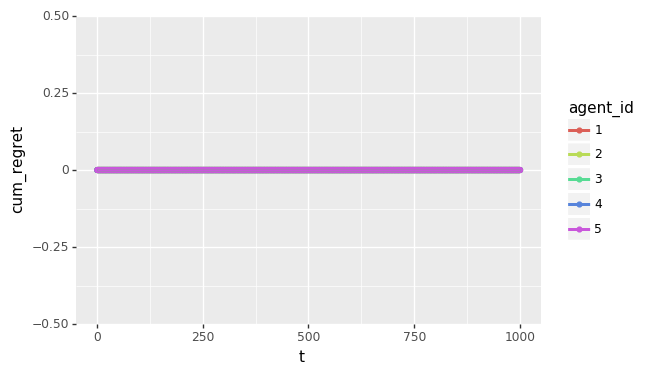

<ggplot: (8787059669537)>


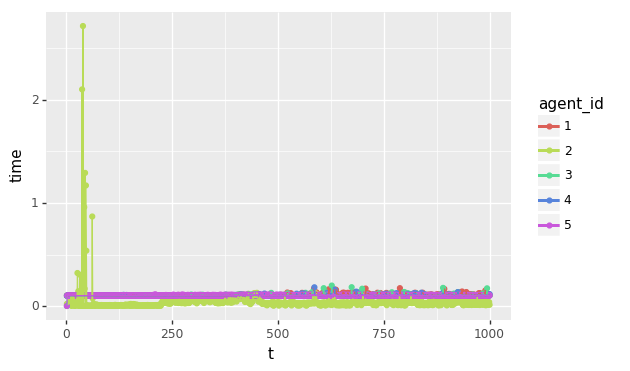

<ggplot: (8787233319769)>
Drawing sample 1
 Sample: array([ 1.62281995, -0.26394376, -0.41816807, -1.33075753,  0.29292373,
       -2.24302327,  1.50743486, -0.95174684,  0.19599976, -0.65076   ,
        1.1345371 , -1.85229813,  0.00436567, -0.22411701,  1.219091  ,
       -0.80934911, -0.20418476, -0.63087766,  0.177568  ,  0.2297532 ])
 Accept proportion: 0.540000
 Steps taken: 1000
Drawing sample 2
 Sample: array([ 1.47133904, -0.39254249, -0.25048666, -1.31732017,  0.43558081,
       -2.10022304,  1.52463953, -0.79250715,  0.24974837, -0.67595913,
        0.99716719, -1.51581238, -0.20753114, -0.40668994,  1.30990812,
       -1.01596717, -0.04302167, -0.1706388 ,  0.11692519,  0.45722011])
 Accept proportion: 0.587000
 Steps taken: 1000
Drawing sample 3
 Sample: array([ 1.43296854, -0.360245  , -0.48433118, -1.05945101,  0.56430952,
       -2.24125449,  1.78021015, -0.69886606,  0.17266193, -0.39352935,
        0.92797278, -1.66421338,  0.06250928, -0.13385677,  1.145095  ,
      

 Sample: array([ 1.5192008 , -0.30492826, -0.29889126, -1.17226505,  0.56771678,
       -2.21920721,  1.72549388, -0.72834648,  0.37094334, -0.61628021,
        1.14821011, -2.0097288 , -0.36057243, -0.45606738,  1.22300465,
       -0.91358661,  0.04731193, -0.47934314, -0.06367419,  0.25252689])
 Accept proportion: 0.589000
 Steps taken: 1000
Drawing sample 25
 Sample: array([ 1.77187523, -0.61306179, -0.43190447, -1.10105077,  0.55855328,
       -2.24468669,  1.63336025, -0.82627325,  0.32753913, -0.57562125,
        1.0236724 , -1.7530717 , -0.16444745, -0.40979826,  1.0481235 ,
       -0.98512077, -0.13668837, -0.37933267,  0.27464944,  0.08487325])
 Accept proportion: 0.541000
 Steps taken: 1000
Drawing sample 26
 Sample: array([ 1.50425343, -0.27763261, -0.28607242, -0.94818958,  0.46787432,
       -2.18346048,  1.6215907 , -0.76262771,  0.18914631, -0.53311293,
        1.06465011, -1.89390734, -0.06557545, -0.46874356,  1.34430726,
       -1.13166327,  0.02104657, -0.45882248,  

 Sample: array([ 1.45580172, -0.39640417, -0.49071123, -0.9018952 ,  0.25865943,
       -2.10923304,  1.37416881, -0.87999465,  0.30408584, -0.7202702 ,
        1.01076382, -1.64274938, -0.04436285, -0.3972971 ,  0.98003162,
       -1.21690856, -0.13130285, -0.5697771 ,  0.34401839,  0.5729246 ])
 Accept proportion: 0.561000
 Steps taken: 1000
Drawing sample 48
 Sample: array([ 1.49379377, -0.47790939, -0.39942559, -1.17172432,  0.38304987,
       -2.18719784,  1.77397016, -0.77158086,  0.16543524, -0.45956687,
        0.77842928, -1.73212903, -0.30834597, -0.41763719,  1.10188873,
       -0.83936044,  0.06842246, -0.3510253 ,  0.2084031 ,  0.32863782])
 Accept proportion: 0.555000
 Steps taken: 1000
Drawing sample 49
 Sample: array([ 1.62618863, -0.33051455, -0.19833437, -1.1337542 ,  0.73652597,
       -2.36671879,  1.65590401, -0.97132423,  0.36763713, -0.60482747,
        1.02594061, -2.04250277, -0.16632087, -0.36598213,  1.22987945,
       -0.92462288, -0.19035232, -0.38850226,  

 Sample: array([ 1.85773019, -0.47730984, -0.15587526, -0.83224204,  0.57103901,
       -2.35375761,  1.49024116, -0.68854446,  0.47689388, -0.63153645,
        1.15295169, -1.65080679, -0.28667312, -0.35208971,  1.50270971,
       -1.14119504, -0.07909194, -0.50789207, -0.06320266,  0.42604846])
 Accept proportion: 0.566000
 Steps taken: 1000
Drawing sample 71
 Sample: array([ 1.61417087, -0.34772076, -0.43572609, -1.3067866 ,  0.32668149,
       -2.13210446,  1.61953745, -0.91996144,  0.36863365, -0.69319797,
        0.89345746, -1.92490475, -0.23836256, -0.44394616,  1.34941443,
       -1.0932285 , -0.23278094, -0.50488995,  0.30151613,  0.21228647])
 Accept proportion: 0.557000
 Steps taken: 1000
Drawing sample 72
 Sample: array([ 1.64723335, -0.63042471, -0.4192742 , -1.14433425,  0.54623418,
       -2.49661494,  1.53185158, -0.81465419,  0.44075057, -0.73370822,
        0.8921688 , -1.80116512, -0.02979675, -0.37530054,  1.17857307,
       -1.05995947, -0.08608137, -0.53425109,  

 Sample: array([ 1.64399782, -0.4717805 , -0.66576216, -1.09994396,  0.2493182 ,
       -2.39687289,  1.44422305, -0.82593836,  0.22512151, -0.53582432,
        0.893105  , -1.8791616 , -0.26922829, -0.52486185,  1.19642744,
       -0.88831814, -0.31221831, -0.44418456,  0.14295918,  0.24503598])
 Accept proportion: 0.537000
 Steps taken: 1000
Drawing sample 94
 Sample: array([ 1.71532008, -0.64396223, -0.53136647, -0.9004907 ,  0.29601883,
       -2.34379979,  1.6510348 , -1.05840179,  0.30831222, -0.60598459,
        0.84417533, -1.91976641, -0.19987909, -0.27031129,  1.0898035 ,
       -0.9842056 , -0.06148467, -0.3235493 ,  0.0997837 ,  0.49713281])
 Accept proportion: 0.590000
 Steps taken: 1000
Drawing sample 95
 Sample: array([ 1.60630548, -0.55599876, -0.39101787, -1.37366139,  0.21625188,
       -2.58615515,  1.4017463 , -0.7001018 ,  0.49206942, -0.62465041,
        1.10665515, -2.18470916, -0.12276113, -0.36959971,  1.17877955,
       -1.01520196, -0.10814514, -0.58730596, -

 Sample: array([ 1.67975385, -0.36104927, -0.17467745, -0.96936359,  0.35850245,
       -2.41329253,  1.44236345, -0.82388665,  0.32372562, -0.65776635,
        0.96483529, -1.86452635, -0.24641516, -0.31073139,  1.21611561,
       -0.9002378 , -0.0975848 , -0.41430066, -0.09805049,  0.42973177])
 Accept proportion: 0.554000
 Steps taken: 1000
Drawing sample 117
 Sample: array([ 1.52298201, -0.4480177 , -0.23092782, -1.00497587,  0.31491743,
       -2.27874173,  1.65433547, -0.92782177,  0.21748024, -0.57077551,
        1.09962613, -1.77079203, -0.15302917, -0.55911134,  1.20909329,
       -0.78473801, -0.07193953, -0.5330025 ,  0.45299892,  0.22231059])
 Accept proportion: 0.552000
 Steps taken: 1000
Drawing sample 118
 Sample: array([ 1.56775068, -0.48197493, -0.35459337, -1.14134754,  0.42366962,
       -2.40205893,  1.53676183, -1.03986216,  0.17287197, -0.64196266,
        0.94178531, -1.8767542 , -0.19169273, -0.30676721,  1.00165087,
       -0.89143261, -0.10978621, -0.57009616,

 Sample: array([ 1.85520169, -0.44079267, -0.2685925 , -1.31113828,  0.36789924,
       -2.49529159,  1.43991781, -0.66848885,  0.40184405, -0.3754755 ,
        1.08950343, -2.07989681, -0.17555589, -0.37297899,  1.33729327,
       -1.2225743 , -0.28549343, -0.59681708,  0.01097737,  0.24624653])
 Accept proportion: 0.604000
 Steps taken: 1000
Drawing sample 140
 Sample: array([ 1.46672015, -0.25883097, -0.46496986, -1.27284664,  0.29857485,
       -2.20275185,  1.72835261, -0.76456628,  0.27968449, -0.54628971,
        0.95008664, -1.75876359, -0.25574249, -0.31239078,  1.10741023,
       -1.01313054, -0.02297698, -0.29932291,  0.08044419,  0.26145149])
 Accept proportion: 0.566000
 Steps taken: 1000
Drawing sample 141
 Sample: array([ 1.71200774, -0.45586272, -0.26998561, -1.1616212 ,  0.2226638 ,
       -2.34188375,  1.42449487, -0.98086509,  0.15213002, -0.62998698,
        0.97422165, -1.62964459, -0.1673375 , -0.00659291,  1.16059552,
       -1.18492253, -0.11161232, -0.41816602,

 Sample: array([ 1.5180192 , -0.49395846, -0.2898964 , -0.94832277,  0.39977984,
       -2.41917791,  1.38859146, -0.69245023,  0.29746327, -0.57802851,
        1.07688512, -1.83138775, -0.04049836, -0.43520094,  1.22104417,
       -0.76553458, -0.20218007, -0.14665563,  0.20262335,  0.36517863])
 Accept proportion: 0.542000
 Steps taken: 1000
Drawing sample 163
 Sample: array([ 1.70863988, -0.61548703, -0.2270317 , -1.17486961,  0.56211862,
       -2.31779535,  1.69373645, -0.84358811,  0.37737852, -0.69930081,
        0.99630856, -1.79860091, -0.32015865, -0.30635271,  1.31845348,
       -0.79076524, -0.21082322, -0.60002323,  0.10042705,  0.05464758])
 Accept proportion: 0.534000
 Steps taken: 1000
Drawing sample 164
 Sample: array([ 1.56709611, -0.40266615, -0.31797042, -0.95542516,  0.45903772,
       -2.31295394,  1.80018513, -1.04132619,  0.37575987, -0.73027175,
        0.96491277, -1.79486625, -0.04407253, -0.3078638 ,  1.39774675,
       -0.78246795, -0.26843991, -0.58143701,

 Sample: array([ 1.62110056, -0.53780832, -0.40888434, -0.90873455,  0.54080386,
       -2.24647782,  1.7729749 , -0.95986589,  0.17307927, -0.47088428,
        0.85965829, -1.61975588, -0.11869467, -0.44747551,  1.08089145,
       -0.97950982, -0.04676468, -0.49772718,  0.05875327,  0.31158826])
 Accept proportion: 0.559000
 Steps taken: 1000
Drawing sample 186
 Sample: array([ 1.54194768, -0.2634665 , -0.25801123, -1.34706513,  0.25628323,
       -2.63144267,  1.84121489, -0.71222668,  0.37384907, -0.68871384,
        0.98584125, -2.05090311, -0.1432882 , -0.37264972,  1.11939893,
       -1.11725608, -0.3764797 , -0.54808188,  0.15808877,  0.31377773])
 Accept proportion: 0.552000
 Steps taken: 1000
Drawing sample 187
 Sample: array([ 1.57161159, -0.26457736, -0.40424983, -1.30465077,  0.58084632,
       -2.3086465 ,  1.51168088, -0.79328313,  0.12029606, -0.66709885,
        1.2718368 , -1.80836596, -0.21099575, -0.2871749 ,  1.31626947,
       -1.06625481, -0.09473397, -0.30453916,

 Sample: array([ 1.81990335, -0.65844168, -0.28152041, -1.20316358,  0.46858533,
       -2.28404075,  1.6922936 , -0.56291076,  0.13236796, -0.61626265,
        0.92549878, -1.81795163, -0.01061024, -0.33581717,  1.26177686,
       -0.77002607, -0.09393253, -0.25993114,  0.22672754,  0.14320558])
 Accept proportion: 0.568000
 Steps taken: 1000
Drawing sample 209
 Sample: array([ 1.55768032, -0.26886995, -0.26194025, -0.94374431,  0.41680739,
       -2.23348171,  1.72317003, -0.78493515,  0.54666541, -0.75039995,
        1.16600331, -1.72502613, -0.17675171, -0.329516  ,  1.36453285,
       -0.91256696, -0.13736813, -0.50248101,  0.02415433,  0.29917083])
 Accept proportion: 0.538000
 Steps taken: 1000
Drawing sample 210
 Sample: array([ 1.6103884 , -0.53049784, -0.21117632, -1.42708898,  0.45629934,
       -2.28900533,  1.43359259, -0.57102317,  0.24395567, -0.60708095,
        0.6619216 , -1.92388736, -0.24207075, -0.44424397,  1.21402328,
       -0.61636054, -0.1340654 , -0.14503243,

 Sample: array([ 1.6344661 , -0.26935104, -0.50543233, -1.15254619,  0.60209101,
       -2.37204529,  1.52847604, -0.70731344,  0.14355176, -0.39126915,
        1.03635934, -1.86849739, -0.19624236, -0.20819076,  1.20054802,
       -0.9794025 , -0.17599078, -0.58220331, -0.08717373,  0.27073941])
 Accept proportion: 0.549000
 Steps taken: 1000
Drawing sample 232
 Sample: array([ 1.4904358 , -0.33748068, -0.39973503, -1.11280332,  0.27260756,
       -2.46412741,  1.55181975, -0.87410547,  0.43880814, -0.37624724,
        1.15741197, -1.82536183, -0.36711335, -0.44395592,  1.1160439 ,
       -0.97449486, -0.01902976, -0.63164372,  0.18298926,  0.48737573])
 Accept proportion: 0.547000
 Steps taken: 1000
Drawing sample 233
 Sample: array([ 1.85638923, -0.1621225 , -0.50916763, -1.2341486 ,  0.29825917,
       -2.40245407,  1.5482479 , -0.69526762,  0.31887735, -0.47740637,
        0.99499354, -1.83158637, -0.45672417, -0.56905595,  1.401164  ,
       -1.06324174, -0.07071234, -0.34725078,

 Sample: array([ 1.52744643e+00, -4.10538176e-01, -5.71214180e-01, -1.36188627e+00,
        1.80263797e-01, -2.66470373e+00,  1.62490419e+00, -9.40391098e-01,
        4.53623697e-01, -5.09659294e-01,  1.04143276e+00, -1.97145730e+00,
       -5.46396522e-02, -1.10490759e-03,  1.27343741e+00, -9.44058214e-01,
       -2.48961482e-01, -6.32695338e-01,  2.03745345e-01,  4.99998000e-01])
 Accept proportion: 0.553000
 Steps taken: 1000
Drawing sample 255
 Sample: array([ 1.50235637e+00, -4.41665487e-01, -1.54127693e-01, -1.04671352e+00,
        4.02317912e-01, -2.26917494e+00,  1.59737463e+00, -5.66312364e-01,
        3.56632970e-01, -6.16314116e-01,  7.64875836e-01, -1.71361261e+00,
       -1.94514571e-03, -2.97393365e-01,  1.02019047e+00, -1.19063192e+00,
       -2.94889698e-01, -6.27636766e-01,  2.61233758e-01,  1.63321619e-01])
 Accept proportion: 0.533000
 Steps taken: 1000
Drawing sample 256
 Sample: array([ 1.70671218, -0.3169396 , -0.20032413, -1.06970899,  0.36056792,
       -2.54036

 Sample: array([ 1.58488578, -0.46606617, -0.4549947 , -1.05899158,  0.31603168,
       -2.49529616,  1.4969342 , -0.7451604 ,  0.12236147, -0.58149005,
        1.00895518, -1.9112276 , -0.12088886, -0.20918309,  1.1612347 ,
       -1.18352567, -0.2683352 , -0.3762442 ,  0.1660426 ,  0.35176573])
 Accept proportion: 0.553000
 Steps taken: 1000
Drawing sample 277
 Sample: array([ 1.4786722 , -0.56272779, -0.16902989, -1.19813158,  0.42995232,
       -2.37719095,  1.57707695, -0.82956028,  0.26990435, -0.61751417,
        1.13717001, -1.79158601, -0.24690482, -0.33384395,  1.50771497,
       -0.87815186, -0.08183347, -0.45149161,  0.09275035,  0.19604923])
 Accept proportion: 0.594000
 Steps taken: 1000
Drawing sample 278
 Sample: array([ 1.49615476, -0.54986974, -0.60058758, -1.27975012,  0.42656069,
       -2.17811095,  1.71626576, -0.89445555,  0.41343292, -0.63122999,
        1.04490636, -1.91846519, -0.22844666, -0.13617983,  1.36395092,
       -1.37513361, -0.1869818 , -0.45735862,

 Sample: array([ 1.4811581 , -0.35254113, -0.32013619, -1.04074284,  0.26424387,
       -2.4251129 ,  1.61929252, -0.56200099,  0.26706421, -0.48092383,
        1.03608343, -1.87863061, -0.1244499 , -0.37828099,  1.36974193,
       -0.819528  ,  0.01063078, -0.46274654,  0.05624629,  0.29894256])
 Accept proportion: 0.546000
 Steps taken: 1000
Drawing sample 300
 Sample: array([ 1.46804367, -0.40329071, -0.5537378 , -1.17245962,  0.36900475,
       -2.10138804,  1.4662299 , -0.93121625,  0.26682783, -0.63305912,
        1.16690026, -2.07020296, -0.1642282 , -0.42761475,  1.04874814,
       -0.91320766, -0.178759  , -0.50625651, -0.00299034,  0.37156821])
 Accept proportion: 0.580000
 Steps taken: 1000
Drawing sample 301
 Sample: array([ 1.69476983, -0.389887  , -0.60769826, -1.03821323,  0.31094895,
       -2.62372099,  1.85204176, -0.70710707,  0.38254619, -0.53776737,
        0.77407811, -2.01830454, -0.03374995, -0.50236348,  1.16739453,
       -0.96045316, -0.25469657, -0.43244833,

 Sample: array([ 1.68197362, -0.37851795, -0.42977722, -1.03834491,  0.23037429,
       -2.1573334 ,  1.56526165, -0.63206799,  0.215979  , -0.67241486,
        0.90741524, -1.78057581, -0.38861743, -0.20819939,  1.10247407,
       -0.98377153, -0.37850718, -0.62526713,  0.3357659 ,  0.26922157])
 Accept proportion: 0.572000
 Steps taken: 1000
Drawing sample 322
 Sample: array([ 1.50153816, -0.49557625, -0.31365734, -1.07280626,  0.28168799,
       -2.287438  ,  1.48150267, -0.96540956,  0.36977768, -0.63499376,
        0.90547794, -1.78050002, -0.15198546, -0.09155243,  1.20869617,
       -1.17718212, -0.22214584, -0.64183468,  0.08608696,  0.27793502])
 Accept proportion: 0.552000
 Steps taken: 1000
Drawing sample 323
 Sample: array([ 1.43468871, -0.08341483, -0.28071891, -1.08779357,  0.51265009,
       -2.25780307,  1.5752642 , -0.77720343,  0.30920634, -0.43533004,
        1.00737434, -1.80007401, -0.06475473, -0.33718101,  1.09851857,
       -1.11386044, -0.06423675, -0.64178288,

 Sample: array([ 1.72884943, -0.42195331, -0.34398886, -1.32486801,  0.56792104,
       -2.28044671,  1.72067883, -0.64841501,  0.42231519, -0.42866254,
        0.91400819, -1.79552306, -0.20755101, -0.45306277,  1.10664351,
       -1.03293604, -0.4333506 , -0.3413949 ,  0.05136787,  0.29261032])
 Accept proportion: 0.571000
 Steps taken: 1000
Drawing sample 344
 Sample: array([ 1.68202046, -0.34183569, -0.6801266 , -1.30921663,  0.44957872,
       -2.53851086,  1.67485837, -0.82750121,  0.16272804, -0.50896753,
        1.05851828, -1.67421718, -0.12952844, -0.24149676,  1.26375483,
       -0.9738381 , -0.00831551, -0.34614377,  0.11683917,  0.32374849])
 Accept proportion: 0.560000
 Steps taken: 1000
Drawing sample 345
 Sample: array([ 1.51152932, -0.3480412 , -0.33661229, -1.30576054,  0.44741278,
       -2.49794386,  1.84608411, -0.86493985,  0.35365273, -0.52224568,
        1.11714527, -2.02093215, -0.14963235, -0.21643027,  1.37673245,
       -1.00197379, -0.2200918 , -0.33655005,

 Sample: array([ 1.70966789, -0.38917968, -0.52225947, -1.18430687,  0.57018707,
       -2.48905594,  1.56665567, -0.8272989 ,  0.2677497 , -0.52489135,
        0.82277807, -1.64526099, -0.35010582, -0.22372808,  1.2276783 ,
       -0.96217951, -0.08472032, -0.34658668,  0.1919439 ,  0.18920582])
 Accept proportion: 0.549000
 Steps taken: 1000
Drawing sample 367
 Sample: array([ 1.72792627, -0.6024324 , -0.07925177, -1.03983528,  0.3742908 ,
       -2.32958352,  1.52858215, -0.8127815 ,  0.27952261, -0.42358285,
        0.96115182, -1.73062112, -0.12849854, -0.25586313,  1.13729398,
       -1.253663  , -0.16395692, -0.4654161 ,  0.18970282,  0.54524167])
 Accept proportion: 0.555000
 Steps taken: 1000
Drawing sample 368
 Sample: array([ 1.69201058, -0.33828485, -0.09321129, -1.0805807 ,  0.45352225,
       -2.13680307,  1.40567606, -0.90250573,  0.04486838, -0.54518007,
        0.95263279, -1.76065667, -0.10047052, -0.37659134,  1.33453108,
       -0.97930294,  0.04709782, -0.35414536,

 Sample: array([ 1.46226825, -0.45829037, -0.43159161, -1.0500189 ,  0.45730495,
       -2.25786077,  1.39741192, -0.71279752,  0.33293468, -0.6308521 ,
        1.21315883, -1.92345748, -0.04702239, -0.05584092,  1.13888988,
       -1.04506492,  0.00868518, -0.51527018,  0.12605274,  0.35700278])
 Accept proportion: 0.585000
 Steps taken: 1000
Drawing sample 390
 Sample: array([ 1.59057093, -0.37759225, -0.34910541, -1.01314707,  0.4234664 ,
       -2.38976403,  1.34347753, -0.60513383,  0.26341866, -0.64728371,
        0.96583369, -1.49533725, -0.10657061, -0.50985485,  1.20892681,
       -1.13249318, -0.13706982, -0.78931802,  0.07295885,  0.25286174])
 Accept proportion: 0.558000
 Steps taken: 1000
Drawing sample 391
 Sample: array([ 1.60834765, -0.46054946, -0.46579729, -1.17176926,  0.35352598,
       -2.29749628,  1.63665619, -0.84245676,  0.41293155, -0.68815264,
        0.65981357, -1.82013662, -0.22833296, -0.28025602,  1.21087425,
       -1.29696789, -0.36283978, -0.23330467,

 Sample: array([ 1.5626267 , -0.43987809, -0.28154102, -1.26936562,  0.35642492,
       -2.58321427,  1.57331716, -0.76093901,  0.29662657, -0.37149155,
        0.84843898, -1.67492133, -0.13272124, -0.14577617,  1.33014451,
       -0.9496039 , -0.27918559, -0.57622091,  0.12600979,  0.3186808 ])
 Accept proportion: 0.545000
 Steps taken: 1000
Drawing sample 413
 Sample: array([ 1.74231447, -0.27337307, -0.43293784, -1.12232334,  0.4641104 ,
       -2.35627961,  1.5153767 , -0.89972818,  0.49656464, -0.63916588,
        0.93431154, -1.9074181 ,  0.02555086, -0.2851086 ,  1.2809222 ,
       -1.05613136, -0.00625396, -0.42471227,  0.20420508,  0.34034002])
 Accept proportion: 0.576000
 Steps taken: 1000
Drawing sample 414
 Sample: array([ 1.86505984, -0.33697991, -0.5438761 , -1.41714858,  0.59440996,
       -2.33478568,  1.61496851, -0.71476396,  0.45642448, -0.54359028,
        0.99716837, -2.18600606, -0.05445557, -0.15478602,  1.21625398,
       -1.1899873 , -0.38778757, -0.31058516,

 Sample: array([ 1.75205863, -0.41318466, -0.27717579, -1.13574249,  0.43110758,
       -2.48854053,  1.43535669, -0.59587461,  0.39229417, -0.36350048,
        1.11683456, -1.94787009, -0.38847925, -0.01045815,  1.0849327 ,
       -1.02743796, -0.33510285, -0.44875331,  0.28067428,  0.15813546])
 Accept proportion: 0.588000
 Steps taken: 1000
Drawing sample 436
 Sample: array([ 1.42454841, -0.57060698, -0.41969672, -1.13395008,  0.26992517,
       -2.23377473,  1.3518037 , -0.99083246, -0.06183126, -0.41887858,
        0.75337139, -2.06909635, -0.4029701 , -0.148612  ,  1.06971967,
       -0.91468929, -0.10339838, -0.6126392 ,  0.15425624,  0.35586106])
 Accept proportion: 0.546000
 Steps taken: 1000
Drawing sample 437
 Sample: array([ 1.6556896 , -0.46843243, -0.38550323, -1.28270993,  0.37315224,
       -2.15814425,  1.75773682, -0.88056589,  0.16459578, -0.75643177,
        0.90547316, -1.80785847, -0.14169919, -0.40217319,  1.16502953,
       -0.91566469, -0.20169127, -0.4508201 ,

 Sample: array([ 1.65080988, -0.43086433, -0.32610934, -0.85768064,  0.42326039,
       -2.35244261,  1.55318573, -0.95076227,  0.34893689, -0.73191044,
        0.94160965, -1.73037605, -0.28014699, -0.28149228,  1.11386516,
       -0.80207581, -0.10184358, -0.50023296,  0.11179859,  0.19633358])
 Accept proportion: 0.557000
 Steps taken: 1000
Drawing sample 459
 Sample: array([ 1.50215509, -0.63282024, -0.25127013, -1.20435299,  0.20374133,
       -2.18681034,  1.45440645, -0.82632137,  0.29378745, -0.69573306,
        1.17548166, -1.77304383, -0.35243297, -0.35713569,  1.00851868,
       -0.94088435,  0.07447615, -0.36249607,  0.15047524,  0.32103661])
 Accept proportion: 0.571000
 Steps taken: 1000
Drawing sample 460
 Sample: array([ 1.75820087, -0.29694412, -0.19735533, -1.27527743,  0.28576024,
       -2.4065228 ,  1.57453999, -0.77835743,  0.44193251, -0.4323952 ,
        0.96956247, -1.92611107,  0.14242395, -0.39112193,  1.28901929,
       -1.1536138 , -0.31813826, -0.70759069,

 Sample: array([ 1.52959159, -0.31295323, -0.27718797, -1.13164913,  0.37806526,
       -2.31736756,  1.61000145, -0.76623953,  0.20608416, -0.61725352,
        1.09289486, -1.79604033, -0.09744818, -0.20531541,  1.18036905,
       -1.1504807 , -0.11746103, -0.31034214,  0.11006016,  0.54981566])
 Accept proportion: 0.554000
 Steps taken: 1000
Drawing sample 482
 Sample: array([ 1.48949848, -0.43039248, -0.31776353, -1.25084574,  0.7084557 ,
       -2.41313853,  1.62942948, -0.79324278,  0.342919  , -0.74864525,
        1.18778954, -2.0049789 , -0.13743696, -0.43509285,  1.13185023,
       -0.95647178, -0.27308809, -0.31419126,  0.10560572,  0.47550999])
 Accept proportion: 0.571000
 Steps taken: 1000
Drawing sample 483
 Sample: array([ 1.43195977, -0.44752779, -0.38402031, -1.12792757,  0.45402651,
       -2.00312829,  1.55553086, -1.06463185,  0.17070844, -0.70238828,
        1.11691991, -1.76706894,  0.00540408, -0.32775619,  1.11052426,
       -0.86712802, -0.11363305, -0.44957757,

 Sample: array([ 1.43431261, -0.49824385, -0.26236546, -1.26999805,  0.55303999,
       -2.23692146,  1.45237071, -0.70564735,  0.24448324, -0.73862846,
        0.94604941, -1.91256767, -0.21560827, -0.0605508 ,  1.08373163,
       -1.13678453, -0.03992599, -0.29003837,  0.13894128,  0.3900054 ])
 Accept proportion: 0.553000
 Steps taken: 1000
Drawing sample 505
 Sample: array([ 1.38497738, -0.21294958, -0.56888116, -1.168998  ,  0.46158268,
       -2.20091217,  1.81629463, -0.99472477,  0.08480586, -0.43751866,
        0.8432252 , -1.45062138, -0.24931352, -0.41646432,  1.2503801 ,
       -1.06390033, -0.31209225, -0.51905165,  0.09093459,  0.38460377])
 Accept proportion: 0.573000
 Steps taken: 1000
Drawing sample 506
 Sample: array([ 1.65869272, -0.33303518, -0.38116644, -1.11916901,  0.41604502,
       -2.31059919,  1.50796667, -0.85498172,  0.1925422 , -0.6197741 ,
        0.97974258, -1.90415153, -0.01748026, -0.50816162,  1.0661508 ,
       -0.96935321, -0.32399038, -0.41489518,

 Sample: array([ 1.46271783, -0.11768949, -0.44433513, -1.39738239,  0.47065925,
       -2.3106926 ,  1.30285692, -0.93641134,  0.35552807, -0.6936064 ,
        0.87813668, -1.57644701, -0.03871303, -0.31277323,  1.14512296,
       -0.76933767, -0.07293379, -0.48293436,  0.18996157,  0.25211224])
 Accept proportion: 0.540000
 Steps taken: 1000
Drawing sample 528
 Sample: array([ 1.51195255, -0.37134513, -0.45129842, -1.34359833,  0.3448896 ,
       -2.21272682,  1.60870558, -0.82771349,  0.1164933 , -0.24458206,
        0.9727207 , -1.74196008, -0.12149993, -0.39219072,  1.16532713,
       -0.89682698, -0.09179256, -0.44719852, -0.1737984 ,  0.33107756])
 Accept proportion: 0.556000
 Steps taken: 1000
Drawing sample 529
 Sample: array([ 1.66243574, -0.34020789, -0.36022225, -1.16213737,  0.29807441,
       -2.42785385,  1.6699215 , -0.77531227,  0.38807079, -0.5047281 ,
        1.03217184, -1.9486784 , -0.1713292 , -0.11274284,  1.42888234,
       -1.04135161, -0.19486301, -0.43966355,

 Sample: array([ 1.86887036, -0.53179873, -0.18994326, -1.11097973,  0.59748608,
       -2.15682347,  1.63747604, -0.8999758 ,  0.47718741, -0.55317206,
        1.12398388, -1.7265134 , -0.19939747, -0.56221385,  1.21877754,
       -0.89735294, -0.1524952 , -0.68806291,  0.01530181,  0.27563469])
 Accept proportion: 0.559000
 Steps taken: 1000
Drawing sample 551
 Sample: array([ 1.59688331, -0.24237087, -0.43363619, -1.18818297,  0.3689865 ,
       -2.19759762,  1.90461436, -0.85284522,  0.35727561, -0.70096594,
        0.88524861, -1.77894831, -0.24564355, -0.42608145,  1.2559642 ,
       -1.31319194, -0.11306987, -0.60422435, -0.11094799,  0.26319864])
 Accept proportion: 0.574000
 Steps taken: 1000
Drawing sample 552
 Sample: array([ 1.68651058, -0.18727754, -0.27924738, -1.1958211 ,  0.19352783,
       -2.28030636,  1.64704342, -0.9080451 ,  0.25599198, -0.5752118 ,
        1.07745141, -1.8791027 , -0.0400824 , -0.28966232,  1.08674338,
       -1.11934779, -0.25775347, -0.41950778,

 Sample: array([ 1.5427984 , -0.55245666, -0.45552059, -1.1677216 ,  0.44141664,
       -2.50845833,  1.67403041, -0.71807522,  0.38566092, -0.65859405,
        0.93772709, -1.9550846 , -0.24624567, -0.25207829,  1.35676285,
       -1.07821849, -0.37242482, -0.5119874 ,  0.2498503 ,  0.35029459])
 Accept proportion: 0.562000
 Steps taken: 1000
Drawing sample 574
 Sample: array([ 1.56421881, -0.28304039, -0.37333072, -1.21785016,  0.37707207,
       -2.0099572 ,  1.46699293, -0.5307699 ,  0.27245698, -0.58762574,
        0.96816157, -1.77901377, -0.08858201, -0.23930492,  1.29004292,
       -1.00295898, -0.23309696, -0.25103996,  0.11359295,  0.60904787])
 Accept proportion: 0.565000
 Steps taken: 1000
Drawing sample 575
 Sample: array([ 1.49894128, -0.43191792, -0.43562686, -1.13157289,  0.31059875,
       -2.32651154,  1.70278614, -0.85435976,  0.65210747, -0.4457867 ,
        1.08675418, -1.82031959,  0.12640218, -0.19844829,  1.31087942,
       -1.01281428, -0.1813193 , -0.35171081,

 Sample: array([ 1.69704984, -0.30835136, -0.20055922, -1.27966023,  0.33489991,
       -2.27328256,  1.62234513, -0.80955605,  0.17489248, -0.67574957,
        0.74537644, -1.8196244 ,  0.01370602, -0.55953384,  1.06775855,
       -1.24868964, -0.13462947, -0.41494278,  0.12545808,  0.1137408 ])
 Accept proportion: 0.566000
 Steps taken: 1000
Drawing sample 597
 Sample: array([ 1.75142609, -0.53203326, -0.60005732, -1.19649591,  0.45700032,
       -2.30059663,  1.7207915 , -0.71193123,  0.26204715, -0.64424346,
        1.12505985, -2.10257289, -0.3049491 , -0.66716182,  1.39866533,
       -1.16909557, -0.33322213, -0.49550345,  0.26982118,  0.30785361])
 Accept proportion: 0.568000
 Steps taken: 1000
Drawing sample 598
 Sample: array([ 1.74074237, -0.31973111, -0.33072555, -1.14116885,  0.44515878,
       -2.18934255,  1.68961281, -0.72887743,  0.27171316, -0.71308089,
        0.94051219, -1.82812468, -0.30258543, -0.38766226,  1.10762184,
       -0.88768619, -0.1295325 , -0.40681368,

 Sample: array([ 1.40439971, -0.3133008 , -0.39493632, -1.08088411,  0.4469597 ,
       -2.02865037,  1.54415345, -0.84742664,  0.39289882, -0.5361343 ,
        1.1184587 , -1.87701608, -0.15030321, -0.29192873,  1.4379419 ,
       -1.01130351,  0.03694998, -0.55757517,  0.00887197,  0.20025289])
 Accept proportion: 0.555000
 Steps taken: 1000
Drawing sample 620
 Sample: array([ 1.70820009, -0.25534675, -0.27785013, -1.35909082,  0.31520737,
       -2.3475097 ,  1.75662731, -0.9350792 ,  0.48626604, -0.60465614,
        0.95779947, -1.99422969, -0.13845316, -0.26885361,  1.24803179,
       -0.9135821 , -0.12080559, -0.52244677, -0.0270413 ,  0.21773948])
 Accept proportion: 0.559000
 Steps taken: 1000
Drawing sample 621
 Sample: array([ 1.69064807, -0.54508685, -0.56677844, -1.07039558,  0.5269211 ,
       -2.40843567,  1.65366875, -0.84600644,  0.20149879, -0.53836967,
        0.87342174, -1.89448116, -0.0096654 , -0.25569022,  1.23912634,
       -1.00051491,  0.06158684, -0.27402606,

 Sample: array([ 1.48640694, -0.29482329, -0.27468486, -1.23490877,  0.66701865,
       -2.4028961 ,  1.7757716 , -0.6387933 ,  0.31423332, -0.56751112,
        1.10176638, -1.99501572, -0.14691431, -0.5161607 ,  1.25667054,
       -1.01416777, -0.19908327, -0.38475351,  0.24310071,  0.45912574])
 Accept proportion: 0.552000
 Steps taken: 1000
Drawing sample 643
 Sample: array([ 1.42484867, -0.29587001, -0.336401  , -1.03483403,  0.33123798,
       -2.64531994,  1.50290225, -0.90667239,  0.12755359, -0.74217486,
        1.03507493, -1.79199644, -0.12857181, -0.36402075,  1.25842953,
       -1.17898273, -0.17403847, -0.65589234,  0.01251288,  0.30952714])
 Accept proportion: 0.582000
 Steps taken: 1000
Drawing sample 644
 Sample: array([ 1.66581817, -0.53919625, -0.44082151, -1.21332097,  0.28494863,
       -2.15784113,  1.79637216, -0.56484642,  0.22273705, -0.73363552,
        0.82551038, -1.92526792, -0.28734943, -0.32623038,  1.2477438 ,
       -0.99851221, -0.12795311, -0.34705395,

 Sample: array([ 1.43332585, -0.19706136, -0.56768533, -1.00592719,  0.18441383,
       -2.24299473,  1.6649059 , -0.81975734,  0.30775631, -0.65002723,
        1.22710197, -1.87205659, -0.17351191, -0.19642235,  1.25898333,
       -1.03686906, -0.06609619, -0.31970213,  0.0419954 ,  0.35210793])
 Accept proportion: 0.575000
 Steps taken: 1000
Drawing sample 666
 Sample: array([ 1.56030484, -0.28271743, -0.37573993, -1.12333586,  0.41777689,
       -2.3032116 ,  1.68948601, -0.82853314,  0.21287958, -0.54915651,
        0.90002938, -1.95113114, -0.13697429, -0.12233988,  1.10088045,
       -1.02156251, -0.10173557, -0.57187982,  0.00915021,  0.38902224])
 Accept proportion: 0.567000
 Steps taken: 1000
Drawing sample 667
 Sample: array([ 1.45051914, -0.28371694, -0.16737916, -1.20396697,  0.31250744,
       -2.16463864,  1.73245834, -0.63145192,  0.18757513, -0.35371498,
        1.12032747, -1.8349257 , -0.08462174, -0.36693824,  1.36682045,
       -0.79913777, -0.06303673, -0.34572901,

 Sample: array([ 1.38888121, -0.3923698 , -0.17443285, -1.20038595,  0.44404403,
       -2.48405637,  1.49040019, -0.9017312 ,  0.49364882, -0.53371982,
        0.88843034, -1.80524463, -0.19214577, -0.3166196 ,  1.31148341,
       -0.9573486 , -0.11258105, -0.36969686,  0.11909467,  0.15622733])
 Accept proportion: 0.566000
 Steps taken: 1000
Drawing sample 689
 Sample: array([ 1.58872673, -0.31114165, -0.5064086 , -1.12942773,  0.22025923,
       -2.48351498,  1.60067269, -0.80867854,  0.34323213, -0.60968111,
        0.93132232, -1.7325113 , -0.40805769, -0.22187492,  1.38297468,
       -1.26893457, -0.39927472, -0.41106113,  0.2321128 ,  0.31698502])
 Accept proportion: 0.590000
 Steps taken: 1000
Drawing sample 690
 Sample: array([ 1.65717319, -0.14408894, -0.47440855, -1.29963062,  0.23868829,
       -2.35650783,  1.48580808, -0.84172988,  0.22667129, -0.51229738,
        1.06339286, -1.67910372, -0.20565429, -0.21200268,  1.25170153,
       -1.10242723, -0.15749295, -0.46893287,

 Sample: array([ 1.54348789, -0.5723024 , -0.52498455, -1.12440247,  0.18525013,
       -2.2828573 ,  1.8143718 , -0.60515247,  0.19968903, -0.83446209,
        0.77522191, -2.2390569 , -0.12269819, -0.50428247,  1.10249978,
       -0.87433126, -0.04596336, -0.41677135,  0.38988755,  0.30219972])
 Accept proportion: 0.562000
 Steps taken: 1000
Drawing sample 712
 Sample: array([ 1.38522999, -0.55210574, -0.42973668, -1.26527619,  0.58833832,
       -2.44762531,  1.60156922, -0.78065416,  0.44932556, -0.59480483,
        1.12480601, -1.93816638, -0.26535181, -0.3245955 ,  1.41254472,
       -0.77843513, -0.33472514, -0.469474  ,  0.03332702,  0.22623274])
 Accept proportion: 0.559000
 Steps taken: 1000
Drawing sample 713
 Sample: array([ 1.53477656, -0.41404706, -0.35273509, -0.87801074,  0.60486159,
       -2.31801534,  1.54303723, -0.58753495,  0.32072391, -0.70285567,
        0.89764113, -1.92901237, -0.22113193, -0.43169939,  1.31867941,
       -1.14316553, -0.18522441, -0.42865033,

 Sample: array([ 1.80279103, -0.39263397, -0.3008722 , -1.05043866,  0.32595131,
       -2.34343224,  1.64904973, -0.99933497,  0.46614033, -0.66454753,
        1.00174366, -1.91467326,  0.08152149, -0.06356331,  1.08577395,
       -0.83786653, -0.1302525 , -0.53685237, -0.0807538 ,  0.15072623])
 Accept proportion: 0.593000
 Steps taken: 1000
Drawing sample 735
 Sample: array([ 1.85600336, -0.47972457, -0.57200506, -1.33755552,  0.22687026,
       -2.67977782,  1.61975292, -0.71824389,  0.57067761, -0.74531108,
        1.1574863 , -2.00968991, -0.3649695 , -0.24520366,  1.38328561,
       -1.15715761, -0.22704728, -0.54511774,  0.22315375,  0.17040644])
 Accept proportion: 0.528000
 Steps taken: 1000
Drawing sample 736
 Sample: array([ 1.61715833, -0.42048745, -0.27610187, -1.08060423,  0.51191308,
       -2.2252663 ,  1.48014839, -0.89334531,  0.07639351, -0.39623557,
        0.76107353, -1.63956208, -0.21828563, -0.62777929,  1.4022001 ,
       -1.16386297, -0.03961742, -0.53352557,

 Sample: array([ 1.60451571, -0.21646121, -0.19559929, -1.19784115,  0.59654612,
       -2.40377923,  1.58221816, -0.83974618,  0.3960051 , -0.52970361,
        1.02131883, -2.01548209, -0.32922295, -0.28088786,  1.20141491,
       -0.91860581, -0.01420378, -0.82592933,  0.12330194,  0.38552128])
 Accept proportion: 0.585000
 Steps taken: 1000
Drawing sample 758
 Sample: array([ 1.62122515, -0.4313748 , -0.35597654, -1.15541587,  0.36850397,
       -2.39211661,  1.69936635, -0.82304679,  0.158794  , -0.62239774,
        1.07911364, -1.72284431, -0.14889881, -0.32405981,  1.30021256,
       -1.0095779 , -0.12001478, -0.46837951,  0.20711273,  0.65986967])
 Accept proportion: 0.576000
 Steps taken: 1000
Drawing sample 759
 Sample: array([ 1.50772585, -0.45952104, -0.30971808, -0.88623591,  0.38392686,
       -2.42982031,  1.44874067, -0.89138036,  0.4228578 , -0.64081955,
        0.63636583, -1.73927475,  0.02866245, -0.41084203,  1.24250477,
       -1.04879999, -0.18214115, -0.38899661,

 Sample: array([ 1.71005283, -0.51733302, -0.23961324, -1.06090366,  0.23214346,
       -2.27638728,  1.52703915, -0.70323214, -0.05977095, -0.41104558,
        0.79638833, -2.06192577, -0.21198386, -0.07919774,  1.08281414,
       -1.00692276, -0.24804104, -0.33902983,  0.20359834,  0.18132078])
 Accept proportion: 0.557000
 Steps taken: 1000
Drawing sample 781
 Sample: array([ 1.67204975, -0.62008826, -0.30347119, -1.17068135,  0.2014729 ,
       -2.31083272,  1.56965508, -0.98779079,  0.41495357, -0.49282585,
        0.94015477, -1.85304454, -0.26426476, -0.15967321,  1.29111461,
       -1.19092579, -0.18846876, -0.37301159,  0.27329087,  0.4179714 ])
 Accept proportion: 0.551000
 Steps taken: 1000
Drawing sample 782
 Sample: array([ 1.5575879 , -0.30447825, -0.12779944, -1.06101772,  0.35503438,
       -2.212983  ,  1.46622335, -0.68333386,  0.15899448, -0.29515397,
        1.08839137, -1.79644302,  0.03171105, -0.18102572,  1.20008307,
       -0.86040414, -0.22418782, -0.53144801,

 Sample: array([ 1.47432062, -0.36280834, -0.27948523, -0.84095597,  0.37949804,
       -2.56173673,  1.69906835, -0.8158556 ,  0.29311536, -0.66477017,
        0.97515979, -1.83260342, -0.07662415, -0.33997091,  1.43305398,
       -0.95464202, -0.34004386, -0.70737553,  0.04598004,  0.14546533])
 Accept proportion: 0.543000
 Steps taken: 1000
Drawing sample 804
 Sample: array([ 1.34083836, -0.49302569, -0.29617169, -1.17257121,  0.46751106,
       -2.28563849,  1.62444256, -0.89336266,  0.2900867 , -0.64543892,
        0.93360944, -1.58626483, -0.20222812, -0.38358741,  1.32562558,
       -0.76463022,  0.0051989 , -0.32866016,  0.11989147,  0.29973533])
 Accept proportion: 0.572000
 Steps taken: 1000
Drawing sample 805
 Sample: array([ 1.64413696, -0.06820838, -0.35345567, -1.07983925,  0.48105398,
       -2.27746893,  1.53948715, -0.69522414,  0.36457472, -0.65828589,
        0.85896095, -1.89072405, -0.07692912, -0.25483925,  1.2033223 ,
       -0.98456116, -0.31090693, -0.23158117,

 Sample: array([ 1.78618692, -0.38049571, -0.23114563, -1.13847785,  0.46047419,
       -2.19318813,  1.34837368, -0.69708268,  0.47146744, -0.70627824,
        0.76126199, -1.8917467 , -0.04541543, -0.48990528,  1.22455948,
       -0.95197119, -0.26720706, -0.54811063,  0.16393788,  0.3482688 ])
 Accept proportion: 0.597000
 Steps taken: 1000
Drawing sample 827
 Sample: array([ 1.75986266e+00, -4.53566968e-01, -3.88490934e-01, -9.97550348e-01,
        5.50334646e-01, -2.09597277e+00,  1.48539258e+00, -8.17430474e-01,
       -1.92675730e-02, -4.19336001e-01,  8.87311926e-01, -1.77725755e+00,
       -2.09970794e-01, -2.21268802e-01,  1.31889634e+00, -8.71822957e-01,
       -3.97429847e-01, -5.43345042e-01, -2.82120484e-04,  1.01619293e-01])
 Accept proportion: 0.549000
 Steps taken: 1000
Drawing sample 828
 Sample: array([ 1.43869554, -0.40896946, -0.36206149, -1.17898486,  0.29604411,
       -2.36193616,  1.46083992, -0.74019442,  0.2428141 , -0.60519029,
        1.10184367, -1.5920356

 Sample: array([ 1.35739062, -0.43378884, -0.39456349, -1.1120098 ,  0.55437666,
       -2.19479116,  1.50083688, -0.6178329 ,  0.30783489, -0.66229546,
        1.13715417, -1.57640605,  0.01043902, -0.45322134,  1.14880379,
       -1.03723219, -0.1667364 , -0.52094511,  0.02976666,  0.46219145])
 Accept proportion: 0.558000
 Steps taken: 1000
Drawing sample 850
 Sample: array([ 1.83362285, -0.52539243, -0.27455474, -1.236434  ,  0.38663933,
       -2.36534195,  1.66002301, -0.86301835,  0.29462638, -0.5711292 ,
        1.02198963, -1.82493649, -0.08896204, -0.3531678 ,  1.33815034,
       -1.05714683, -0.14280594, -0.44479335,  0.07318783,  0.02992262])
 Accept proportion: 0.577000
 Steps taken: 1000
Drawing sample 851
 Sample: array([ 1.47105852, -0.45485261, -0.34992129, -1.09983122,  0.52180429,
       -2.48462798,  1.70401117, -0.85673331,  0.29222492, -0.55853501,
        1.110289  , -2.00631118, -0.24054643, -0.20766307,  1.32744568,
       -1.00059623, -0.25601548, -0.385416  ,

 Sample: array([ 1.58336532, -0.61387745, -0.24185157, -1.19317939,  0.30862853,
       -2.19878427,  1.83257128, -0.95921156,  0.28830188, -0.49377678,
        1.12119618, -1.89565565, -0.07918146, -0.28178413,  1.26419425,
       -0.8519209 , -0.0178114 , -0.31014614, -0.28884964,  0.22944954])
 Accept proportion: 0.534000
 Steps taken: 1000
Drawing sample 873
 Sample: array([ 1.6566011 , -0.35253118, -0.2426963 , -1.09084171,  0.31363452,
       -2.17911186,  1.48784347, -0.86378157,  0.17531281, -0.68490398,
        1.06698857, -1.76244383, -0.3298248 , -0.60424623,  1.33510105,
       -0.98584136, -0.22670234, -0.44929845,  0.01633021,  0.29269376])
 Accept proportion: 0.546000
 Steps taken: 1000
Drawing sample 874
 Sample: array([ 1.58579819, -0.35017505, -0.42492575, -1.1800496 ,  0.44707839,
       -2.27224545,  1.6739034 , -0.77645692,  0.23981156, -0.55773567,
        1.0321393 , -1.81513079, -0.11789373, -0.10935784,  1.18443403,
       -1.06349496, -0.25208593, -0.24223613,

 Sample: array([ 1.64052658, -0.56113574, -0.43275488, -1.26186529,  0.25677578,
       -2.38522352,  1.68778534, -0.97477527,  0.2591983 , -0.76186787,
        0.69637233, -1.77814083, -0.31550394, -0.41439221,  0.94466721,
       -1.16989876, -0.42470444, -0.27190915, -0.06742703,  0.25940516])
 Accept proportion: 0.570000
 Steps taken: 1000
Drawing sample 896
 Sample: array([ 1.58296791, -0.41181664, -0.52232273, -1.00149504,  0.51387858,
       -2.13301661,  1.73713194, -0.74039199,  0.13815615, -0.51077334,
        1.22811647, -1.90308737, -0.27056846, -0.22785223,  1.1717678 ,
       -0.98864994, -0.33111182, -0.410468  , -0.04614047,  0.18814552])
 Accept proportion: 0.566000
 Steps taken: 1000
Drawing sample 897
 Sample: array([ 1.70307911, -0.46449626, -0.40542632, -1.2045752 ,  0.37718285,
       -2.24094843,  1.6868624 , -0.9046707 ,  0.38571489, -0.60658694,
        0.69501944, -1.84103438, -0.01266529, -0.29480004,  1.21131945,
       -0.73194323, -0.03673712, -0.45343649,

 Sample: array([ 1.66326382, -0.59049011, -0.24499338, -1.11930965,  0.46600124,
       -2.22643345,  1.76682781, -0.90502767,  0.25021461, -0.55099821,
        0.9658512 , -1.77804283, -0.26805991, -0.28853863,  1.13625896,
       -0.97508544, -0.22217224, -0.56490939, -0.04096922,  0.55046374])
 Accept proportion: 0.559000
 Steps taken: 1000
Drawing sample 919
 Sample: array([ 1.74444965, -0.32739091, -0.5214936 , -1.15816538,  0.52880731,
       -2.48938173,  1.51953341, -0.87832332,  0.16543352, -0.66098318,
        0.78584929, -1.84694739, -0.33657038, -0.37901918,  1.09714572,
       -0.72260064, -0.13901318, -0.56265715,  0.19736814,  0.35201341])
 Accept proportion: 0.553000
 Steps taken: 1000
Drawing sample 920
 Sample: array([ 1.5428179 , -0.50740196, -0.4584087 , -1.51084131,  0.38850398,
       -2.45265695,  1.57719838, -0.88829344,  0.19108528, -0.38255671,
        0.8031429 , -1.69458397, -0.26526748, -0.10281069,  1.42592122,
       -1.05307541,  0.06561799, -0.3162165 ,

 Sample: array([ 1.59504077, -0.46723606, -0.37494178, -1.16257083,  0.5188037 ,
       -2.29521517,  1.79793755, -0.63001165,  0.01141298, -0.65326082,
        0.92079497, -1.71645875, -0.34503205, -0.45988117,  1.25332023,
       -0.7505328 , -0.08052445, -0.60152688,  0.00706891,  0.31723684])
 Accept proportion: 0.561000
 Steps taken: 1000
Drawing sample 942
 Sample: array([ 1.58546792, -0.25020643, -0.21084469, -1.13205247,  0.57024423,
       -2.37992693,  1.58948901, -0.51008398,  0.15327851, -0.60312228,
        1.23450151, -1.83270665, -0.17154923, -0.29960578,  1.02109859,
       -0.91667924, -0.30426881, -0.33182279,  0.16733888,  0.23403285])
 Accept proportion: 0.546000
 Steps taken: 1000
Drawing sample 943
 Sample: array([ 1.54929463, -0.48474984, -0.45585495, -1.22940269,  0.77074565,
       -2.43390967,  1.71516009, -0.97324033,  0.21171699, -0.7622749 ,
        0.99033088, -1.87607996, -0.31410124, -0.21874095,  1.18908183,
       -0.77760714,  0.01953592, -0.41717578,

 Sample: array([ 1.65818832, -0.32274694, -0.41522081, -0.98073555,  0.25219768,
       -2.23839525,  1.67030763, -0.8786995 ,  0.22380381, -0.39544833,
        1.01913468, -1.52855453, -0.15408189, -0.34337386,  1.24816054,
       -0.97908986, -0.17987832, -0.43322472, -0.09945173,  0.04894297])
 Accept proportion: 0.594000
 Steps taken: 1000
Drawing sample 964
 Sample: array([ 1.65953858, -0.40599486, -0.31419878, -1.29375597,  0.26816382,
       -1.86859499,  1.52384631, -0.82322019,  0.37469153, -0.58855785,
        0.90284991, -1.83128677, -0.18461736, -0.39574673,  1.19379483,
       -1.02013958, -0.05501065, -0.30974464,  0.18127256,  0.18827971])
 Accept proportion: 0.574000
 Steps taken: 1000
Drawing sample 965
 Sample: array([ 1.64020616, -0.37213311, -0.27808798, -0.89227427,  0.61861174,
       -2.10167707,  1.36697735, -0.74310312,  0.5421831 , -0.57497426,
        1.00776472, -1.87092809, -0.0961188 , -0.2292381 ,  1.23327194,
       -0.89744186, -0.10556957, -0.69550972,

 Sample: array([ 1.67156224, -0.29656864, -0.3130145 , -1.0841816 ,  0.323604  ,
       -2.33195626,  1.68207999, -0.80624938,  0.28282924, -0.89689511,
        1.04877587, -1.61115955, -0.13002914, -0.28349891,  1.13746547,
       -0.72726365, -0.12459114, -0.53753811,  0.14076816,  0.23926217])
 Accept proportion: 0.566000
 Steps taken: 1000
Drawing sample 987
 Sample: array([ 1.61985193, -0.3281927 , -0.41694371, -1.27146771,  0.14305943,
       -2.51355815,  1.68300739, -0.62991077,  0.27031675, -0.67818641,
        1.03967394, -1.92217879, -0.16278468, -0.40939947,  1.2388966 ,
       -1.29161003, -0.35060666, -0.17647533,  0.07958054,  0.29613939])
 Accept proportion: 0.580000
 Steps taken: 1000
Drawing sample 988
 Sample: array([ 1.60206609, -0.43555872, -0.18598152, -1.18855711,  0.42008732,
       -2.36137404,  1.50299808, -0.99184552,  0.43555391, -0.73821674,
        1.18046284, -1.88541919, -0.31319896, -0.11161555,  1.26526574,
       -0.89629605, -0.08833883, -0.50268839,

In [7]:
agents = [make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
simple_compare(agents, num_articles, dim, var, T, 1, verbosity=1)
agents[0].v=1
agents[0].time=0
agents[0].n_steps=1000
samples = redraw_samples(agents[0], 1000, 1)

In [8]:
pgts_agent = agents[2]
sagald_agent = agents[4]

def retime(agent, t):
    new_agent = copy.deepcopy(agent)
    new_agent.time = t
    return new_agent

"""pgts_agent_0_03 = retime(pgts_agent, 0.03)
pgts_agent_0_01 = retime(pgts_agent, 0.01)

sagald_agent_0_03 = copy.deepcopy(sagald_agent)
sagald_agent_0_03.time = 0.03
sagald_agent_0_01 = copy.deepcopy(sagald_agent)
sagald_agent_0_01.time = 0.01"""

new_agents = [pgts_agent, retime(pgts_agent, 0.03), retime(pgts_agent, 0.01),
              sagald_agent, retime(sagald_agent, 0.03), retime(sagald_agent, 0.01)
             ]

In [9]:
samples_list = redraw_samples_for_agents(new_agents, 1000, verbosity=1)
samples_list = np.append(np.asarray([samples]), samples_list, axis=0)
tvs, merrs, hists = merr(samples_list, 0.25)
merrs

Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
D

Drawing sample 439
Drawing sample 440
Drawing sample 441
Drawing sample 442
Drawing sample 443
Drawing sample 444
Drawing sample 445
Drawing sample 446
Drawing sample 447
Drawing sample 448
Drawing sample 449
Drawing sample 450
Drawing sample 451
Drawing sample 452
Drawing sample 453
Drawing sample 454
Drawing sample 455
Drawing sample 456
Drawing sample 457
Drawing sample 458
Drawing sample 459
Drawing sample 460
Drawing sample 461
Drawing sample 462
Drawing sample 463
Drawing sample 464
Drawing sample 465
Drawing sample 466
Drawing sample 467
Drawing sample 468
Drawing sample 469
Drawing sample 470
Drawing sample 471
Drawing sample 472
Drawing sample 473
Drawing sample 474
Drawing sample 475
Drawing sample 476
Drawing sample 477
Drawing sample 478
Drawing sample 479
Drawing sample 480
Drawing sample 481
Drawing sample 482
Drawing sample 483
Drawing sample 484
Drawing sample 485
Drawing sample 486
Drawing sample 487
Drawing sample 488
Drawing sample 489
Drawing sample 490
Drawing samp

Drawing sample 872
Drawing sample 873
Drawing sample 874
Drawing sample 875
Drawing sample 876
Drawing sample 877
Drawing sample 878
Drawing sample 879
Drawing sample 880
Drawing sample 881
Drawing sample 882
Drawing sample 883
Drawing sample 884
Drawing sample 885
Drawing sample 886
Drawing sample 887
Drawing sample 888
Drawing sample 889
Drawing sample 890
Drawing sample 891
Drawing sample 892
Drawing sample 893
Drawing sample 894
Drawing sample 895
Drawing sample 896
Drawing sample 897
Drawing sample 898
Drawing sample 899
Drawing sample 900
Drawing sample 901
Drawing sample 902
Drawing sample 903
Drawing sample 904
Drawing sample 905
Drawing sample 906
Drawing sample 907
Drawing sample 908
Drawing sample 909
Drawing sample 910
Drawing sample 911
Drawing sample 912
Drawing sample 913
Drawing sample 914
Drawing sample 915
Drawing sample 916
Drawing sample 917
Drawing sample 918
Drawing sample 919
Drawing sample 920
Drawing sample 921
Drawing sample 922
Drawing sample 923
Drawing samp

Drawing sample 311
Drawing sample 312
Drawing sample 313
Drawing sample 314
Drawing sample 315
Drawing sample 316
Drawing sample 317
Drawing sample 318
Drawing sample 319
Drawing sample 320
Drawing sample 321
Drawing sample 322
Drawing sample 323
Drawing sample 324
Drawing sample 325
Drawing sample 326
Drawing sample 327
Drawing sample 328
Drawing sample 329
Drawing sample 330
Drawing sample 331
Drawing sample 332
Drawing sample 333
Drawing sample 334
Drawing sample 335
Drawing sample 336
Drawing sample 337
Drawing sample 338
Drawing sample 339
Drawing sample 340
Drawing sample 341
Drawing sample 342
Drawing sample 343
Drawing sample 344
Drawing sample 345
Drawing sample 346
Drawing sample 347
Drawing sample 348
Drawing sample 349
Drawing sample 350
Drawing sample 351
Drawing sample 352
Drawing sample 353
Drawing sample 354
Drawing sample 355
Drawing sample 356
Drawing sample 357
Drawing sample 358
Drawing sample 359
Drawing sample 360
Drawing sample 361
Drawing sample 362
Drawing samp

Drawing sample 745
Drawing sample 746
Drawing sample 747
Drawing sample 748
Drawing sample 749
Drawing sample 750
Drawing sample 751
Drawing sample 752
Drawing sample 753
Drawing sample 754
Drawing sample 755
Drawing sample 756
Drawing sample 757
Drawing sample 758
Drawing sample 759
Drawing sample 760
Drawing sample 761
Drawing sample 762
Drawing sample 763
Drawing sample 764
Drawing sample 765
Drawing sample 766
Drawing sample 767
Drawing sample 768
Drawing sample 769
Drawing sample 770
Drawing sample 771
Drawing sample 772
Drawing sample 773
Drawing sample 774
Drawing sample 775
Drawing sample 776
Drawing sample 777
Drawing sample 778
Drawing sample 779
Drawing sample 780
Drawing sample 781
Drawing sample 782
Drawing sample 783
Drawing sample 784
Drawing sample 785
Drawing sample 786
Drawing sample 787
Drawing sample 788
Drawing sample 789
Drawing sample 790
Drawing sample 791
Drawing sample 792
Drawing sample 793
Drawing sample 794
Drawing sample 795
Drawing sample 796
Drawing samp

Drawing sample 184
Drawing sample 185
Drawing sample 186
Drawing sample 187
Drawing sample 188
Drawing sample 189
Drawing sample 190
Drawing sample 191
Drawing sample 192
Drawing sample 193
Drawing sample 194
Drawing sample 195
Drawing sample 196
Drawing sample 197
Drawing sample 198
Drawing sample 199
Drawing sample 200
Drawing sample 201
Drawing sample 202
Drawing sample 203
Drawing sample 204
Drawing sample 205
Drawing sample 206
Drawing sample 207
Drawing sample 208
Drawing sample 209
Drawing sample 210
Drawing sample 211
Drawing sample 212
Drawing sample 213
Drawing sample 214
Drawing sample 215
Drawing sample 216
Drawing sample 217
Drawing sample 218
Drawing sample 219
Drawing sample 220
Drawing sample 221
Drawing sample 222
Drawing sample 223
Drawing sample 224
Drawing sample 225
Drawing sample 226
Drawing sample 227
Drawing sample 228
Drawing sample 229
Drawing sample 230
Drawing sample 231
Drawing sample 232
Drawing sample 233
Drawing sample 234
Drawing sample 235
Drawing samp

Drawing sample 623
Drawing sample 624
Drawing sample 625
Drawing sample 626
Drawing sample 627
Drawing sample 628
Drawing sample 629
Drawing sample 630
Drawing sample 631
Drawing sample 632
Drawing sample 633
Drawing sample 634
Drawing sample 635
Drawing sample 636
Drawing sample 637
Drawing sample 638
Drawing sample 639
Drawing sample 640
Drawing sample 641
Drawing sample 642
Drawing sample 643
Drawing sample 644
Drawing sample 645
Drawing sample 646
Drawing sample 647
Drawing sample 648
Drawing sample 649
Drawing sample 650
Drawing sample 651
Drawing sample 652
Drawing sample 653
Drawing sample 654
Drawing sample 655
Drawing sample 656
Drawing sample 657
Drawing sample 658
Drawing sample 659
Drawing sample 660
Drawing sample 661
Drawing sample 662
Drawing sample 663
Drawing sample 664
Drawing sample 665
Drawing sample 666
Drawing sample 667
Drawing sample 668
Drawing sample 669
Drawing sample 670
Drawing sample 671
Drawing sample 672
Drawing sample 673
Drawing sample 674
Drawing samp

Drawing sample 58
Drawing sample 59
Drawing sample 60
Drawing sample 61
Drawing sample 62
Drawing sample 63
Drawing sample 64
Drawing sample 65
Drawing sample 66
Drawing sample 67
Drawing sample 68
Drawing sample 69
Drawing sample 70
Drawing sample 71
Drawing sample 72
Drawing sample 73
Drawing sample 74
Drawing sample 75
Drawing sample 76
Drawing sample 77
Drawing sample 78
Drawing sample 79
Drawing sample 80
Drawing sample 81
Drawing sample 82
Drawing sample 83
Drawing sample 84
Drawing sample 85
Drawing sample 86
Drawing sample 87
Drawing sample 88
Drawing sample 89
Drawing sample 90
Drawing sample 91
Drawing sample 92
Drawing sample 93
Drawing sample 94
Drawing sample 95
Drawing sample 96
Drawing sample 97
Drawing sample 98
Drawing sample 99
Drawing sample 100
Drawing sample 101
Drawing sample 102
Drawing sample 103
Drawing sample 104
Drawing sample 105
Drawing sample 106
Drawing sample 107
Drawing sample 108
Drawing sample 109
Drawing sample 110
Drawing sample 111
Drawing sample 1

Drawing sample 492
Drawing sample 493
Drawing sample 494
Drawing sample 495
Drawing sample 496
Drawing sample 497
Drawing sample 498
Drawing sample 499
Drawing sample 500
Drawing sample 501
Drawing sample 502
Drawing sample 503
Drawing sample 504
Drawing sample 505
Drawing sample 506
Drawing sample 507
Drawing sample 508
Drawing sample 509
Drawing sample 510
Drawing sample 511
Drawing sample 512
Drawing sample 513
Drawing sample 514
Drawing sample 515
Drawing sample 516
Drawing sample 517
Drawing sample 518
Drawing sample 519
Drawing sample 520
Drawing sample 521
Drawing sample 522
Drawing sample 523
Drawing sample 524
Drawing sample 525
Drawing sample 526
Drawing sample 527
Drawing sample 528
Drawing sample 529
Drawing sample 530
Drawing sample 531
Drawing sample 532
Drawing sample 533
Drawing sample 534
Drawing sample 535
Drawing sample 536
Drawing sample 537
Drawing sample 538
Drawing sample 539
Drawing sample 540
Drawing sample 541
Drawing sample 542
Drawing sample 543
Drawing samp

Drawing sample 924
Drawing sample 925
Drawing sample 926
Drawing sample 927
Drawing sample 928
Drawing sample 929
Drawing sample 930
Drawing sample 931
Drawing sample 932
Drawing sample 933
Drawing sample 934
Drawing sample 935
Drawing sample 936
Drawing sample 937
Drawing sample 938
Drawing sample 939
Drawing sample 940
Drawing sample 941
Drawing sample 942
Drawing sample 943
Drawing sample 944
Drawing sample 945
Drawing sample 946
Drawing sample 947
Drawing sample 948
Drawing sample 949
Drawing sample 950
Drawing sample 951
Drawing sample 952
Drawing sample 953
Drawing sample 954
Drawing sample 955
Drawing sample 956
Drawing sample 957
Drawing sample 958
Drawing sample 959
Drawing sample 960
Drawing sample 961
Drawing sample 962
Drawing sample 963
Drawing sample 964
Drawing sample 965
Drawing sample 966
Drawing sample 967
Drawing sample 968
Drawing sample 969
Drawing sample 970
Drawing sample 971
Drawing sample 972
Drawing sample 973
Drawing sample 974
Drawing sample 975
Drawing samp

Drawing sample 362
Drawing sample 363
Drawing sample 364
Drawing sample 365
Drawing sample 366
Drawing sample 367
Drawing sample 368
Drawing sample 369
Drawing sample 370
Drawing sample 371
Drawing sample 372
Drawing sample 373
Drawing sample 374
Drawing sample 375
Drawing sample 376
Drawing sample 377
Drawing sample 378
Drawing sample 379
Drawing sample 380
Drawing sample 381
Drawing sample 382
Drawing sample 383
Drawing sample 384
Drawing sample 385
Drawing sample 386
Drawing sample 387
Drawing sample 388
Drawing sample 389
Drawing sample 390
Drawing sample 391
Drawing sample 392
Drawing sample 393
Drawing sample 394
Drawing sample 395
Drawing sample 396
Drawing sample 397
Drawing sample 398
Drawing sample 399
Drawing sample 400
Drawing sample 401
Drawing sample 402
Drawing sample 403
Drawing sample 404
Drawing sample 405
Drawing sample 406
Drawing sample 407
Drawing sample 408
Drawing sample 409
Drawing sample 410
Drawing sample 411
Drawing sample 412
Drawing sample 413
Drawing samp

Drawing sample 796
Drawing sample 797
Drawing sample 798
Drawing sample 799
Drawing sample 800
Drawing sample 801
Drawing sample 802
Drawing sample 803
Drawing sample 804
Drawing sample 805
Drawing sample 806
Drawing sample 807
Drawing sample 808
Drawing sample 809
Drawing sample 810
Drawing sample 811
Drawing sample 812
Drawing sample 813
Drawing sample 814
Drawing sample 815
Drawing sample 816
Drawing sample 817
Drawing sample 818
Drawing sample 819
Drawing sample 820
Drawing sample 821
Drawing sample 822
Drawing sample 823
Drawing sample 824
Drawing sample 825
Drawing sample 826
Drawing sample 827
Drawing sample 828
Drawing sample 829
Drawing sample 830
Drawing sample 831
Drawing sample 832
Drawing sample 833
Drawing sample 834
Drawing sample 835
Drawing sample 836
Drawing sample 837
Drawing sample 838
Drawing sample 839
Drawing sample 840
Drawing sample 841
Drawing sample 842
Drawing sample 843
Drawing sample 844
Drawing sample 845
Drawing sample 846
Drawing sample 847
Drawing samp

Drawing sample 241
Drawing sample 242
Drawing sample 243
Drawing sample 244
Drawing sample 245
Drawing sample 246
Drawing sample 247
Drawing sample 248
Drawing sample 249
Drawing sample 250
Drawing sample 251
Drawing sample 252
Drawing sample 253
Drawing sample 254
Drawing sample 255
Drawing sample 256
Drawing sample 257
Drawing sample 258
Drawing sample 259
Drawing sample 260
Drawing sample 261
Drawing sample 262
Drawing sample 263
Drawing sample 264
Drawing sample 265
Drawing sample 266
Drawing sample 267
Drawing sample 268
Drawing sample 269
Drawing sample 270
Drawing sample 271
Drawing sample 272
Drawing sample 273
Drawing sample 274
Drawing sample 275
Drawing sample 276
Drawing sample 277
Drawing sample 278
Drawing sample 279
Drawing sample 280
Drawing sample 281
Drawing sample 282
Drawing sample 283
Drawing sample 284
Drawing sample 285
Drawing sample 286
Drawing sample 287
Drawing sample 288
Drawing sample 289
Drawing sample 290
Drawing sample 291
Drawing sample 292
Drawing samp

Drawing sample 676
Drawing sample 677
Drawing sample 678
Drawing sample 679
Drawing sample 680
Drawing sample 681
Drawing sample 682
Drawing sample 683
Drawing sample 684
Drawing sample 685
Drawing sample 686
Drawing sample 687
Drawing sample 688
Drawing sample 689
Drawing sample 690
Drawing sample 691
Drawing sample 692
Drawing sample 693
Drawing sample 694
Drawing sample 695
Drawing sample 696
Drawing sample 697
Drawing sample 698
Drawing sample 699
Drawing sample 700
Drawing sample 701
Drawing sample 702
Drawing sample 703
Drawing sample 704
Drawing sample 705
Drawing sample 706
Drawing sample 707
Drawing sample 708
Drawing sample 709
Drawing sample 710
Drawing sample 711
Drawing sample 712
Drawing sample 713
Drawing sample 714
Drawing sample 715
Drawing sample 716
Drawing sample 717
Drawing sample 718
Drawing sample 719
Drawing sample 720
Drawing sample 721
Drawing sample 722
Drawing sample 723
Drawing sample 724
Drawing sample 725
Drawing sample 726
Drawing sample 727
Drawing samp

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
         2,   1,   4,   7,  19,  32,  45,  51,  58,  73,  88, 111,  90,
       105,  77,  74,  50,  35,  29,  26,   9,   7,   2,   3,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  1,  0,  2,  4,  1,  3,  5, 10,  6, 15, 19, 23, 13, 31,
       32, 40, 37, 50, 49, 48, 53, 57, 62, 47, 54, 44, 48, 41, 44, 34, 28,
       20, 23, 15, 11, 12,  5,  5,  2,  2,  3,  0,  0,  1,  0,  0,  0,  0]), array([ 0,  1,  0,  1,  1,  0,  1,  4,  3,  1,  3,  6, 10, 20, 19, 23, 23,
       39, 42, 37, 52, 61, 45, 56, 62, 41, 57, 46, 65, 43, 49, 43, 27, 27,
       22, 12, 16, 13,  8,  6,  2,  4,  2,  2,  1,  2,  1,  1,  0,  0,  0]), array([ 0,  0,  0,  0,  0,  1,  1,  3, 10,  3,  5,  4, 10, 13, 16, 16, 32,
       30, 49, 32, 34, 40, 60, 55, 68, 46, 61, 52, 48, 52, 44, 46, 26, 31,
       23, 20, 13, 14, 12,  9,  8,  7,  3,  1,  2,  0,  0,  0,  0,  0,  0]), array([ 1,  0,  1,  3,  1,  4,  2

array([0.269525, 0.274575, 0.26815 , 0.28075 , 0.2703  , 0.27995 ])

In [10]:
pickle.dump(samples_list, open('../outputs/ma_times.p','wb'))

Also check Hessian!

In [19]:
from algorithms.langevin import *
npla.eig(logistic_Hessian(agents[0].theta, agents[0].contexts))

(array([23.68833708, 52.90443348, 52.05038333, 29.49333259, 48.70565533,
        47.9915753 , 32.37033009, 32.82644668, 45.57318436, 45.2300522 ,
        43.741091  , 35.00983274, 34.77679146, 36.6292822 , 42.68730442,
        37.66464985, 38.43611481, 39.66288463, 41.13646913, 40.57323341]),
 array([[-0.29699643, -0.0226095 ,  0.16178633,  0.13763293,  0.4186688 ,
          0.0995469 ,  0.00320519,  0.06789504, -0.11957446, -0.1873466 ,
          0.47775627,  0.13313775, -0.02983895,  0.23770206,  0.0292769 ,
          0.09886539,  0.03331102, -0.42522507,  0.35859814, -0.04934444],
        [ 0.05494468, -0.38454182, -0.04189869,  0.17071971,  0.03925709,
         -0.16851742,  0.3733737 , -0.21167454, -0.52512101, -0.0693988 ,
         -0.31546123,  0.11821568, -0.09765893,  0.164838  , -0.03560059,
          0.30716064, -0.11032781,  0.14951905,  0.14532184, -0.1484088 ],
        [ 0.04601112, -0.49740912, -0.06271789, -0.01220948, -0.14143539,
         -0.52312443, -0.2419884 ,  0.

# Scratch

In [4]:
#make_hist([-1.2,.4, .9,.95], .5)

make_hist_from_std_dev([np.random.normal() for _ in range(100)], 0.25)

(array([ 1,  0,  0,  1,  0,  3,  2,  5,  5,  7,  7,  8,  9, 12, 10, 11,  6,
         3,  6,  1,  0,  1,  0,  2]),
 array([-3.16533089, -2.92184389, -2.6783569 , -2.43486991, -2.19138292,
        -1.94789593, -1.70440894, -1.46092195, -1.21743496, -0.97394796,
        -0.73046097, -0.48697398, -0.24348699,  0.        ,  0.24348699,
         0.48697398,  0.73046097,  0.97394796,  1.21743496,  1.46092195,
         1.70440894,  1.94789593,  2.19138292,  2.43486991,  2.6783569 ]))

In [5]:
make_hists([[1.5,2.5],[2.5,3.5]], 1)

tv(np.asarray([1,2,3,2,1]),np.asarray([1,3,3,1,1]))

0.1111111111111111

In [6]:
arrs = np.asarray([[[-1,-1],[1,1]],[[-1,-1],[1,-1]],[[1,-1],[1,1]]])
merr(arrs,1)

(array([[0. , 0.5],
        [0.5, 0. ]]), array([0.25, 0.25]))